In [38]:
import pandas as pd
import skimage.measure
from PIL import Image
import requests
from io import BytesIO
import numpy as np
from deepface import DeepFace
from imageai.Detection import ObjectDetection
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from collections import Counter

sns.set(style="whitegrid")

In [2]:
df = pd.read_csv('USdata80.csv', encoding='cp1252', lineterminator='\n')

In [3]:
df.head()

Unnamed: 0     video_id                                              title  \
0           0  3C66w5Z0ixs                 I ASKED HER TO BE MY GIRLFRIEND...   
1           1  M9Pmf9AB4Mo  Apex Legends | Stories from the Outlands – “Th...   
2           2  J78aPJ3VyNs  I left youtube for a month and THIS is what ha...   
3           3  kXLn3HkpjaA  XXL 2020 Freshman Class Revealed - Official An...   
4           4  VIUo6yapDbc  Ultimate DIY Home Movie Theater for The LaBran...   

            publishedAt                 channelId   channelTitle  categoryId  \
0  2020-08-11T19:20:14Z  UCvtRTOMP2TqYqu51xNrqAzg       Brawadis         NaN   
1  2020-08-11T17:00:10Z  UC0ZV6M2THA81QT9hrVWJG3A   Apex Legends        20.0   
2  2020-08-11T16:34:06Z  UCYzPXprvl5Y-Sf0g4vX-m6g  jacksepticeye         NaN   
3  2020-08-11T16:38:55Z  UCbg_UMjlHJg_19SZckaKajg            XXL         NaN   
4  2020-08-11T15:10:05Z  UCDVPcEbVLQgLZX0Rt6jo34A       Mr. Kate         NaN   

          trending_date                                               tags  \
0  2020-08-12T00:00:00Z  brawadis|prank|basketball|skits|ghost|funny vi...   
1  2020-08-12T00:00:00Z  Apex Legends|Apex Legends characters|new Apex ...   
2  2020-08-12T00:00:00Z  jacksepticeye|funny|funny meme|memes|jacksepti...   
3  2020-08-12T00:00:00Z  xxl freshman|xxl freshmen|2020 xxl freshman|20...   
4  2020-08-12T00:00:00Z  The LaBrant Family|DIY|Interior Design|Makeove...   

   view_count   likes  dislikes  comment_count  \
0     1514614  156908      5855          35313   
1     2381688  146739      2794          16549   
2     2038853  353787      2628          40221   
3      496771   23251      1856           7647   
4     1123889   45802       964           2196   

                                   thumbnail_link  comments_disabled  \
0  https://i.ytimg.com/vi/3C66w5Z0ixs/default.jpg              False   
1  https://i.ytimg.com/vi/M9Pmf9AB4Mo/default.jpg              False   
2  https://i.ytimg.com/vi/J78aPJ3VyNs/default.jpg              False   
3  https://i.ytimg.com/vi/kXLn3HkpjaA/default.jpg              False   
4  https://i.ytimg.com/vi/VIUo6yapDbc/default.jpg              False   

   ratings_disabled                                      description\r  
0             False  SUBSCRIBE to BRAWADIS ? http://bit.ly/Subscrib...  
1             False  While running her own modding shop, Ramya Pare...  
2             False  I left youtube for a month and this is what ha...  
3             False  Subscribe to XXL ? http://bit.ly/subscribe-xxl...  
4             False  Transforming The LaBrant Family's empty white ...

<font size="5"><b>Ręcznie przygotowane cechy</b></font>

In [4]:
df['thumbnail_link']

0         https://i.ytimg.com/vi/3C66w5Z0ixs/default.jpg
1         https://i.ytimg.com/vi/M9Pmf9AB4Mo/default.jpg
2         https://i.ytimg.com/vi/J78aPJ3VyNs/default.jpg
3         https://i.ytimg.com/vi/kXLn3HkpjaA/default.jpg
4         https://i.ytimg.com/vi/VIUo6yapDbc/default.jpg
                               ...                      
115386    https://i.ytimg.com/vi/6WUxgmMDts4/default.jpg
115387    https://i.ytimg.com/vi/6-aGt23ytyI/default.jpg
115388    https://i.ytimg.com/vi/vPgrkl7lEjU/default.jpg
115389    https://i.ytimg.com/vi/6Svr8l1DwTc/default.jpg
115390    https://i.ytimg.com/vi/hBF4TxpTW3Y/default.jpg
Name: thumbnail_link, Length: 115391, dtype: object

In [5]:
#Funkcja, która podmienia linki do małych thumbnaili na linki do thumbnaili o dużych rozdzielczościach
def get_big_thumbnail(link):
    big_link = link.replace('default', 'maxresdefault')
    return big_link
    
df['thumbnail_link_big'] = df['thumbnail_link'].apply(get_big_thumbnail)

In [6]:
#DataFrame z miniaturami o większej rozdzielczości
tn = pd.DataFrame(df['thumbnail_link_big'])
tn 

thumbnail_link_big
0       https://i.ytimg.com/vi/3C66w5Z0ixs/maxresdefau...
1       https://i.ytimg.com/vi/M9Pmf9AB4Mo/maxresdefau...
2       https://i.ytimg.com/vi/J78aPJ3VyNs/maxresdefau...
3       https://i.ytimg.com/vi/kXLn3HkpjaA/maxresdefau...
4       https://i.ytimg.com/vi/VIUo6yapDbc/maxresdefau...
...                                                   ...
115386  https://i.ytimg.com/vi/6WUxgmMDts4/maxresdefau...
115387  https://i.ytimg.com/vi/6-aGt23ytyI/maxresdefau...
115388  https://i.ytimg.com/vi/vPgrkl7lEjU/maxresdefau...
115389  https://i.ytimg.com/vi/6Svr8l1DwTc/maxresdefau...
115390  https://i.ytimg.com/vi/hBF4TxpTW3Y/maxresdefau...

[115391 rows x 1 columns]

In [9]:
#usunięcie powtórzeń z thumbnaili
tn = tn.drop_duplicates(subset=['thumbnail_link_big'], keep='first')

In [10]:
tn

thumbnail_link_big
0       https://i.ytimg.com/vi/3C66w5Z0ixs/maxresdefau...
1       https://i.ytimg.com/vi/M9Pmf9AB4Mo/maxresdefau...
2       https://i.ytimg.com/vi/J78aPJ3VyNs/maxresdefau...
3       https://i.ytimg.com/vi/kXLn3HkpjaA/maxresdefau...
4       https://i.ytimg.com/vi/VIUo6yapDbc/maxresdefau...
...                                                   ...
115224  https://i.ytimg.com/vi/r93stUU8yXA/maxresdefau...
115225  https://i.ytimg.com/vi/84LhrZ-NN_E/maxresdefau...
115228  https://i.ytimg.com/vi/ZGsavMW4770/maxresdefau...
115229  https://i.ytimg.com/vi/_3xV0J3dzMs/maxresdefau...
115233  https://i.ytimg.com/vi/h2UN0EtuY1g/maxresdefau...

[20831 rows x 1 columns]

In [25]:
licznik = 0

#funkcja obliczająca entropię dla każdej miniatury
def count_entropy(img_link):
    global licznik
    response = requests.get(img_link)
    img = Image.open(BytesIO(response.content))
    entropy = skimage.measure.shannon_entropy(img)
    licznik +=1
    print("Przetwarzanie obrazu nr ", licznik)
    return entropy
 

tn['entropy'] = tn['thumbnail_link_big'].apply(count_entropy)

Przetwarzanie obrazu nr  1
Przetwarzanie obrazu nr  2
Przetwarzanie obrazu nr  3
Przetwarzanie obrazu nr  4
Przetwarzanie obrazu nr  5
Przetwarzanie obrazu nr  6
Przetwarzanie obrazu nr  7
Przetwarzanie obrazu nr  8
Przetwarzanie obrazu nr  9
Przetwarzanie obrazu nr  10
Przetwarzanie obrazu nr  11
Przetwarzanie obrazu nr  12
Przetwarzanie obrazu nr  13
Przetwarzanie obrazu nr  14
Przetwarzanie obrazu nr  15
Przetwarzanie obrazu nr  16
Przetwarzanie obrazu nr  17
Przetwarzanie obrazu nr  18
Przetwarzanie obrazu nr  19
Przetwarzanie obrazu nr  20
Przetwarzanie obrazu nr  21
Przetwarzanie obrazu nr  22
Przetwarzanie obrazu nr  23
Przetwarzanie obrazu nr  24
Przetwarzanie obrazu nr  25
Przetwarzanie obrazu nr  26
Przetwarzanie obrazu nr  27
Przetwarzanie obrazu nr  28
Przetwarzanie obrazu nr  29
Przetwarzanie obrazu nr  30
Przetwarzanie obrazu nr  31
Przetwarzanie obrazu nr  32
Przetwarzanie obrazu nr  33
Przetwarzanie obrazu nr  34
Przetwarzanie obrazu nr  35
Przetwarzanie obrazu nr  36
P

Przetwarzanie obrazu nr  289
Przetwarzanie obrazu nr  290
Przetwarzanie obrazu nr  291
Przetwarzanie obrazu nr  292
Przetwarzanie obrazu nr  293
Przetwarzanie obrazu nr  294
Przetwarzanie obrazu nr  295
Przetwarzanie obrazu nr  296
Przetwarzanie obrazu nr  297
Przetwarzanie obrazu nr  298
Przetwarzanie obrazu nr  299
Przetwarzanie obrazu nr  300
Przetwarzanie obrazu nr  301
Przetwarzanie obrazu nr  302
Przetwarzanie obrazu nr  303
Przetwarzanie obrazu nr  304
Przetwarzanie obrazu nr  305
Przetwarzanie obrazu nr  306
Przetwarzanie obrazu nr  307
Przetwarzanie obrazu nr  308
Przetwarzanie obrazu nr  309
Przetwarzanie obrazu nr  310
Przetwarzanie obrazu nr  311
Przetwarzanie obrazu nr  312
Przetwarzanie obrazu nr  313
Przetwarzanie obrazu nr  314
Przetwarzanie obrazu nr  315
Przetwarzanie obrazu nr  316
Przetwarzanie obrazu nr  317
Przetwarzanie obrazu nr  318
Przetwarzanie obrazu nr  319
Przetwarzanie obrazu nr  320
Przetwarzanie obrazu nr  321
Przetwarzanie obrazu nr  322
Przetwarzanie 

Przetwarzanie obrazu nr  572
Przetwarzanie obrazu nr  573
Przetwarzanie obrazu nr  574
Przetwarzanie obrazu nr  575
Przetwarzanie obrazu nr  576
Przetwarzanie obrazu nr  577
Przetwarzanie obrazu nr  578
Przetwarzanie obrazu nr  579
Przetwarzanie obrazu nr  580
Przetwarzanie obrazu nr  581
Przetwarzanie obrazu nr  582
Przetwarzanie obrazu nr  583
Przetwarzanie obrazu nr  584
Przetwarzanie obrazu nr  585
Przetwarzanie obrazu nr  586
Przetwarzanie obrazu nr  587
Przetwarzanie obrazu nr  588
Przetwarzanie obrazu nr  589
Przetwarzanie obrazu nr  590
Przetwarzanie obrazu nr  591
Przetwarzanie obrazu nr  592
Przetwarzanie obrazu nr  593
Przetwarzanie obrazu nr  594
Przetwarzanie obrazu nr  595
Przetwarzanie obrazu nr  596
Przetwarzanie obrazu nr  597
Przetwarzanie obrazu nr  598
Przetwarzanie obrazu nr  599
Przetwarzanie obrazu nr  600
Przetwarzanie obrazu nr  601
Przetwarzanie obrazu nr  602
Przetwarzanie obrazu nr  603
Przetwarzanie obrazu nr  604
Przetwarzanie obrazu nr  605
Przetwarzanie 

Przetwarzanie obrazu nr  855
Przetwarzanie obrazu nr  856
Przetwarzanie obrazu nr  857
Przetwarzanie obrazu nr  858
Przetwarzanie obrazu nr  859
Przetwarzanie obrazu nr  860
Przetwarzanie obrazu nr  861
Przetwarzanie obrazu nr  862
Przetwarzanie obrazu nr  863
Przetwarzanie obrazu nr  864
Przetwarzanie obrazu nr  865
Przetwarzanie obrazu nr  866
Przetwarzanie obrazu nr  867
Przetwarzanie obrazu nr  868
Przetwarzanie obrazu nr  869
Przetwarzanie obrazu nr  870
Przetwarzanie obrazu nr  871
Przetwarzanie obrazu nr  872
Przetwarzanie obrazu nr  873
Przetwarzanie obrazu nr  874
Przetwarzanie obrazu nr  875
Przetwarzanie obrazu nr  876
Przetwarzanie obrazu nr  877
Przetwarzanie obrazu nr  878
Przetwarzanie obrazu nr  879
Przetwarzanie obrazu nr  880
Przetwarzanie obrazu nr  881
Przetwarzanie obrazu nr  882
Przetwarzanie obrazu nr  883
Przetwarzanie obrazu nr  884
Przetwarzanie obrazu nr  885
Przetwarzanie obrazu nr  886
Przetwarzanie obrazu nr  887
Przetwarzanie obrazu nr  888
Przetwarzanie 

Przetwarzanie obrazu nr  1133
Przetwarzanie obrazu nr  1134
Przetwarzanie obrazu nr  1135
Przetwarzanie obrazu nr  1136
Przetwarzanie obrazu nr  1137
Przetwarzanie obrazu nr  1138
Przetwarzanie obrazu nr  1139
Przetwarzanie obrazu nr  1140
Przetwarzanie obrazu nr  1141
Przetwarzanie obrazu nr  1142
Przetwarzanie obrazu nr  1143
Przetwarzanie obrazu nr  1144
Przetwarzanie obrazu nr  1145
Przetwarzanie obrazu nr  1146
Przetwarzanie obrazu nr  1147
Przetwarzanie obrazu nr  1148
Przetwarzanie obrazu nr  1149
Przetwarzanie obrazu nr  1150
Przetwarzanie obrazu nr  1151
Przetwarzanie obrazu nr  1152
Przetwarzanie obrazu nr  1153
Przetwarzanie obrazu nr  1154
Przetwarzanie obrazu nr  1155
Przetwarzanie obrazu nr  1156
Przetwarzanie obrazu nr  1157
Przetwarzanie obrazu nr  1158
Przetwarzanie obrazu nr  1159
Przetwarzanie obrazu nr  1160
Przetwarzanie obrazu nr  1161
Przetwarzanie obrazu nr  1162
Przetwarzanie obrazu nr  1163
Przetwarzanie obrazu nr  1164
Przetwarzanie obrazu nr  1165
Przetwarza

Przetwarzanie obrazu nr  1407
Przetwarzanie obrazu nr  1408
Przetwarzanie obrazu nr  1409
Przetwarzanie obrazu nr  1410
Przetwarzanie obrazu nr  1411
Przetwarzanie obrazu nr  1412
Przetwarzanie obrazu nr  1413
Przetwarzanie obrazu nr  1414
Przetwarzanie obrazu nr  1415
Przetwarzanie obrazu nr  1416
Przetwarzanie obrazu nr  1417
Przetwarzanie obrazu nr  1418
Przetwarzanie obrazu nr  1419
Przetwarzanie obrazu nr  1420
Przetwarzanie obrazu nr  1421
Przetwarzanie obrazu nr  1422
Przetwarzanie obrazu nr  1423
Przetwarzanie obrazu nr  1424
Przetwarzanie obrazu nr  1425
Przetwarzanie obrazu nr  1426
Przetwarzanie obrazu nr  1427
Przetwarzanie obrazu nr  1428
Przetwarzanie obrazu nr  1429
Przetwarzanie obrazu nr  1430
Przetwarzanie obrazu nr  1431
Przetwarzanie obrazu nr  1432
Przetwarzanie obrazu nr  1433
Przetwarzanie obrazu nr  1434
Przetwarzanie obrazu nr  1435
Przetwarzanie obrazu nr  1436
Przetwarzanie obrazu nr  1437
Przetwarzanie obrazu nr  1438
Przetwarzanie obrazu nr  1439
Przetwarza

Przetwarzanie obrazu nr  1681
Przetwarzanie obrazu nr  1682
Przetwarzanie obrazu nr  1683
Przetwarzanie obrazu nr  1684
Przetwarzanie obrazu nr  1685
Przetwarzanie obrazu nr  1686
Przetwarzanie obrazu nr  1687
Przetwarzanie obrazu nr  1688
Przetwarzanie obrazu nr  1689
Przetwarzanie obrazu nr  1690
Przetwarzanie obrazu nr  1691
Przetwarzanie obrazu nr  1692
Przetwarzanie obrazu nr  1693
Przetwarzanie obrazu nr  1694
Przetwarzanie obrazu nr  1695
Przetwarzanie obrazu nr  1696
Przetwarzanie obrazu nr  1697
Przetwarzanie obrazu nr  1698
Przetwarzanie obrazu nr  1699
Przetwarzanie obrazu nr  1700
Przetwarzanie obrazu nr  1701
Przetwarzanie obrazu nr  1702
Przetwarzanie obrazu nr  1703
Przetwarzanie obrazu nr  1704
Przetwarzanie obrazu nr  1705
Przetwarzanie obrazu nr  1706
Przetwarzanie obrazu nr  1707
Przetwarzanie obrazu nr  1708
Przetwarzanie obrazu nr  1709
Przetwarzanie obrazu nr  1710
Przetwarzanie obrazu nr  1711
Przetwarzanie obrazu nr  1712
Przetwarzanie obrazu nr  1713
Przetwarza

Przetwarzanie obrazu nr  1956
Przetwarzanie obrazu nr  1957
Przetwarzanie obrazu nr  1958
Przetwarzanie obrazu nr  1959
Przetwarzanie obrazu nr  1960
Przetwarzanie obrazu nr  1961
Przetwarzanie obrazu nr  1962
Przetwarzanie obrazu nr  1963
Przetwarzanie obrazu nr  1964
Przetwarzanie obrazu nr  1965
Przetwarzanie obrazu nr  1966
Przetwarzanie obrazu nr  1967
Przetwarzanie obrazu nr  1968
Przetwarzanie obrazu nr  1969
Przetwarzanie obrazu nr  1970
Przetwarzanie obrazu nr  1971
Przetwarzanie obrazu nr  1972
Przetwarzanie obrazu nr  1973
Przetwarzanie obrazu nr  1974
Przetwarzanie obrazu nr  1975
Przetwarzanie obrazu nr  1976
Przetwarzanie obrazu nr  1977
Przetwarzanie obrazu nr  1978
Przetwarzanie obrazu nr  1979
Przetwarzanie obrazu nr  1980
Przetwarzanie obrazu nr  1981
Przetwarzanie obrazu nr  1982
Przetwarzanie obrazu nr  1983
Przetwarzanie obrazu nr  1984
Przetwarzanie obrazu nr  1985
Przetwarzanie obrazu nr  1986
Przetwarzanie obrazu nr  1987
Przetwarzanie obrazu nr  1988
Przetwarza

Przetwarzanie obrazu nr  2231
Przetwarzanie obrazu nr  2232
Przetwarzanie obrazu nr  2233
Przetwarzanie obrazu nr  2234
Przetwarzanie obrazu nr  2235
Przetwarzanie obrazu nr  2236
Przetwarzanie obrazu nr  2237
Przetwarzanie obrazu nr  2238
Przetwarzanie obrazu nr  2239
Przetwarzanie obrazu nr  2240
Przetwarzanie obrazu nr  2241
Przetwarzanie obrazu nr  2242
Przetwarzanie obrazu nr  2243
Przetwarzanie obrazu nr  2244
Przetwarzanie obrazu nr  2245
Przetwarzanie obrazu nr  2246
Przetwarzanie obrazu nr  2247
Przetwarzanie obrazu nr  2248
Przetwarzanie obrazu nr  2249
Przetwarzanie obrazu nr  2250
Przetwarzanie obrazu nr  2251
Przetwarzanie obrazu nr  2252
Przetwarzanie obrazu nr  2253
Przetwarzanie obrazu nr  2254
Przetwarzanie obrazu nr  2255
Przetwarzanie obrazu nr  2256
Przetwarzanie obrazu nr  2257
Przetwarzanie obrazu nr  2258
Przetwarzanie obrazu nr  2259
Przetwarzanie obrazu nr  2260
Przetwarzanie obrazu nr  2261
Przetwarzanie obrazu nr  2262
Przetwarzanie obrazu nr  2263
Przetwarza

Przetwarzanie obrazu nr  2505
Przetwarzanie obrazu nr  2506
Przetwarzanie obrazu nr  2507
Przetwarzanie obrazu nr  2508
Przetwarzanie obrazu nr  2509
Przetwarzanie obrazu nr  2510
Przetwarzanie obrazu nr  2511
Przetwarzanie obrazu nr  2512
Przetwarzanie obrazu nr  2513
Przetwarzanie obrazu nr  2514
Przetwarzanie obrazu nr  2515
Przetwarzanie obrazu nr  2516
Przetwarzanie obrazu nr  2517
Przetwarzanie obrazu nr  2518
Przetwarzanie obrazu nr  2519
Przetwarzanie obrazu nr  2520
Przetwarzanie obrazu nr  2521
Przetwarzanie obrazu nr  2522
Przetwarzanie obrazu nr  2523
Przetwarzanie obrazu nr  2524
Przetwarzanie obrazu nr  2525
Przetwarzanie obrazu nr  2526
Przetwarzanie obrazu nr  2527
Przetwarzanie obrazu nr  2528
Przetwarzanie obrazu nr  2529
Przetwarzanie obrazu nr  2530
Przetwarzanie obrazu nr  2531
Przetwarzanie obrazu nr  2532
Przetwarzanie obrazu nr  2533
Przetwarzanie obrazu nr  2534
Przetwarzanie obrazu nr  2535
Przetwarzanie obrazu nr  2536
Przetwarzanie obrazu nr  2537
Przetwarza

Przetwarzanie obrazu nr  2779
Przetwarzanie obrazu nr  2780
Przetwarzanie obrazu nr  2781
Przetwarzanie obrazu nr  2782
Przetwarzanie obrazu nr  2783
Przetwarzanie obrazu nr  2784
Przetwarzanie obrazu nr  2785
Przetwarzanie obrazu nr  2786
Przetwarzanie obrazu nr  2787
Przetwarzanie obrazu nr  2788
Przetwarzanie obrazu nr  2789
Przetwarzanie obrazu nr  2790
Przetwarzanie obrazu nr  2791
Przetwarzanie obrazu nr  2792
Przetwarzanie obrazu nr  2793
Przetwarzanie obrazu nr  2794
Przetwarzanie obrazu nr  2795
Przetwarzanie obrazu nr  2796
Przetwarzanie obrazu nr  2797
Przetwarzanie obrazu nr  2798
Przetwarzanie obrazu nr  2799
Przetwarzanie obrazu nr  2800
Przetwarzanie obrazu nr  2801
Przetwarzanie obrazu nr  2802
Przetwarzanie obrazu nr  2803
Przetwarzanie obrazu nr  2804
Przetwarzanie obrazu nr  2805
Przetwarzanie obrazu nr  2806
Przetwarzanie obrazu nr  2807
Przetwarzanie obrazu nr  2808
Przetwarzanie obrazu nr  2809
Przetwarzanie obrazu nr  2810
Przetwarzanie obrazu nr  2811
Przetwarza

Przetwarzanie obrazu nr  3053
Przetwarzanie obrazu nr  3054
Przetwarzanie obrazu nr  3055
Przetwarzanie obrazu nr  3056
Przetwarzanie obrazu nr  3057
Przetwarzanie obrazu nr  3058
Przetwarzanie obrazu nr  3059
Przetwarzanie obrazu nr  3060
Przetwarzanie obrazu nr  3061
Przetwarzanie obrazu nr  3062
Przetwarzanie obrazu nr  3063
Przetwarzanie obrazu nr  3064
Przetwarzanie obrazu nr  3065
Przetwarzanie obrazu nr  3066
Przetwarzanie obrazu nr  3067
Przetwarzanie obrazu nr  3068
Przetwarzanie obrazu nr  3069
Przetwarzanie obrazu nr  3070
Przetwarzanie obrazu nr  3071
Przetwarzanie obrazu nr  3072
Przetwarzanie obrazu nr  3073
Przetwarzanie obrazu nr  3074
Przetwarzanie obrazu nr  3075
Przetwarzanie obrazu nr  3076
Przetwarzanie obrazu nr  3077
Przetwarzanie obrazu nr  3078
Przetwarzanie obrazu nr  3079
Przetwarzanie obrazu nr  3080
Przetwarzanie obrazu nr  3081
Przetwarzanie obrazu nr  3082
Przetwarzanie obrazu nr  3083
Przetwarzanie obrazu nr  3084
Przetwarzanie obrazu nr  3085
Przetwarza

Przetwarzanie obrazu nr  3327
Przetwarzanie obrazu nr  3328
Przetwarzanie obrazu nr  3329
Przetwarzanie obrazu nr  3330
Przetwarzanie obrazu nr  3331
Przetwarzanie obrazu nr  3332
Przetwarzanie obrazu nr  3333
Przetwarzanie obrazu nr  3334
Przetwarzanie obrazu nr  3335
Przetwarzanie obrazu nr  3336
Przetwarzanie obrazu nr  3337
Przetwarzanie obrazu nr  3338
Przetwarzanie obrazu nr  3339
Przetwarzanie obrazu nr  3340
Przetwarzanie obrazu nr  3341
Przetwarzanie obrazu nr  3342
Przetwarzanie obrazu nr  3343
Przetwarzanie obrazu nr  3344
Przetwarzanie obrazu nr  3345
Przetwarzanie obrazu nr  3346
Przetwarzanie obrazu nr  3347
Przetwarzanie obrazu nr  3348
Przetwarzanie obrazu nr  3349
Przetwarzanie obrazu nr  3350
Przetwarzanie obrazu nr  3351
Przetwarzanie obrazu nr  3352
Przetwarzanie obrazu nr  3353
Przetwarzanie obrazu nr  3354
Przetwarzanie obrazu nr  3355
Przetwarzanie obrazu nr  3356
Przetwarzanie obrazu nr  3357
Przetwarzanie obrazu nr  3358
Przetwarzanie obrazu nr  3359
Przetwarza

Przetwarzanie obrazu nr  3601
Przetwarzanie obrazu nr  3602
Przetwarzanie obrazu nr  3603
Przetwarzanie obrazu nr  3604
Przetwarzanie obrazu nr  3605
Przetwarzanie obrazu nr  3606
Przetwarzanie obrazu nr  3607
Przetwarzanie obrazu nr  3608
Przetwarzanie obrazu nr  3609
Przetwarzanie obrazu nr  3610
Przetwarzanie obrazu nr  3611
Przetwarzanie obrazu nr  3612
Przetwarzanie obrazu nr  3613
Przetwarzanie obrazu nr  3614
Przetwarzanie obrazu nr  3615
Przetwarzanie obrazu nr  3616
Przetwarzanie obrazu nr  3617
Przetwarzanie obrazu nr  3618
Przetwarzanie obrazu nr  3619
Przetwarzanie obrazu nr  3620
Przetwarzanie obrazu nr  3621
Przetwarzanie obrazu nr  3622
Przetwarzanie obrazu nr  3623
Przetwarzanie obrazu nr  3624
Przetwarzanie obrazu nr  3625
Przetwarzanie obrazu nr  3626
Przetwarzanie obrazu nr  3627
Przetwarzanie obrazu nr  3628
Przetwarzanie obrazu nr  3629
Przetwarzanie obrazu nr  3630
Przetwarzanie obrazu nr  3631
Przetwarzanie obrazu nr  3632
Przetwarzanie obrazu nr  3633
Przetwarza

Przetwarzanie obrazu nr  3876
Przetwarzanie obrazu nr  3877
Przetwarzanie obrazu nr  3878
Przetwarzanie obrazu nr  3879
Przetwarzanie obrazu nr  3880
Przetwarzanie obrazu nr  3881
Przetwarzanie obrazu nr  3882
Przetwarzanie obrazu nr  3883
Przetwarzanie obrazu nr  3884
Przetwarzanie obrazu nr  3885
Przetwarzanie obrazu nr  3886
Przetwarzanie obrazu nr  3887
Przetwarzanie obrazu nr  3888
Przetwarzanie obrazu nr  3889
Przetwarzanie obrazu nr  3890
Przetwarzanie obrazu nr  3891
Przetwarzanie obrazu nr  3892
Przetwarzanie obrazu nr  3893
Przetwarzanie obrazu nr  3894
Przetwarzanie obrazu nr  3895
Przetwarzanie obrazu nr  3896
Przetwarzanie obrazu nr  3897
Przetwarzanie obrazu nr  3898
Przetwarzanie obrazu nr  3899
Przetwarzanie obrazu nr  3900
Przetwarzanie obrazu nr  3901
Przetwarzanie obrazu nr  3902
Przetwarzanie obrazu nr  3903
Przetwarzanie obrazu nr  3904
Przetwarzanie obrazu nr  3905
Przetwarzanie obrazu nr  3906
Przetwarzanie obrazu nr  3907
Przetwarzanie obrazu nr  3908
Przetwarza

Przetwarzanie obrazu nr  4151
Przetwarzanie obrazu nr  4152
Przetwarzanie obrazu nr  4153
Przetwarzanie obrazu nr  4154
Przetwarzanie obrazu nr  4155
Przetwarzanie obrazu nr  4156
Przetwarzanie obrazu nr  4157
Przetwarzanie obrazu nr  4158
Przetwarzanie obrazu nr  4159
Przetwarzanie obrazu nr  4160
Przetwarzanie obrazu nr  4161
Przetwarzanie obrazu nr  4162
Przetwarzanie obrazu nr  4163
Przetwarzanie obrazu nr  4164
Przetwarzanie obrazu nr  4165
Przetwarzanie obrazu nr  4166
Przetwarzanie obrazu nr  4167
Przetwarzanie obrazu nr  4168
Przetwarzanie obrazu nr  4169
Przetwarzanie obrazu nr  4170
Przetwarzanie obrazu nr  4171
Przetwarzanie obrazu nr  4172
Przetwarzanie obrazu nr  4173
Przetwarzanie obrazu nr  4174
Przetwarzanie obrazu nr  4175
Przetwarzanie obrazu nr  4176
Przetwarzanie obrazu nr  4177
Przetwarzanie obrazu nr  4178
Przetwarzanie obrazu nr  4179
Przetwarzanie obrazu nr  4180
Przetwarzanie obrazu nr  4181
Przetwarzanie obrazu nr  4182
Przetwarzanie obrazu nr  4183
Przetwarza

Przetwarzanie obrazu nr  4425
Przetwarzanie obrazu nr  4426
Przetwarzanie obrazu nr  4427
Przetwarzanie obrazu nr  4428
Przetwarzanie obrazu nr  4429
Przetwarzanie obrazu nr  4430
Przetwarzanie obrazu nr  4431
Przetwarzanie obrazu nr  4432
Przetwarzanie obrazu nr  4433
Przetwarzanie obrazu nr  4434
Przetwarzanie obrazu nr  4435
Przetwarzanie obrazu nr  4436
Przetwarzanie obrazu nr  4437
Przetwarzanie obrazu nr  4438
Przetwarzanie obrazu nr  4439
Przetwarzanie obrazu nr  4440
Przetwarzanie obrazu nr  4441
Przetwarzanie obrazu nr  4442
Przetwarzanie obrazu nr  4443
Przetwarzanie obrazu nr  4444
Przetwarzanie obrazu nr  4445
Przetwarzanie obrazu nr  4446
Przetwarzanie obrazu nr  4447
Przetwarzanie obrazu nr  4448
Przetwarzanie obrazu nr  4449
Przetwarzanie obrazu nr  4450
Przetwarzanie obrazu nr  4451
Przetwarzanie obrazu nr  4452
Przetwarzanie obrazu nr  4453
Przetwarzanie obrazu nr  4454
Przetwarzanie obrazu nr  4455
Przetwarzanie obrazu nr  4456
Przetwarzanie obrazu nr  4457
Przetwarza

Przetwarzanie obrazu nr  4699
Przetwarzanie obrazu nr  4700
Przetwarzanie obrazu nr  4701
Przetwarzanie obrazu nr  4702
Przetwarzanie obrazu nr  4703
Przetwarzanie obrazu nr  4704
Przetwarzanie obrazu nr  4705
Przetwarzanie obrazu nr  4706
Przetwarzanie obrazu nr  4707
Przetwarzanie obrazu nr  4708
Przetwarzanie obrazu nr  4709
Przetwarzanie obrazu nr  4710
Przetwarzanie obrazu nr  4711
Przetwarzanie obrazu nr  4712
Przetwarzanie obrazu nr  4713
Przetwarzanie obrazu nr  4714
Przetwarzanie obrazu nr  4715
Przetwarzanie obrazu nr  4716
Przetwarzanie obrazu nr  4717
Przetwarzanie obrazu nr  4718
Przetwarzanie obrazu nr  4719
Przetwarzanie obrazu nr  4720
Przetwarzanie obrazu nr  4721
Przetwarzanie obrazu nr  4722
Przetwarzanie obrazu nr  4723
Przetwarzanie obrazu nr  4724
Przetwarzanie obrazu nr  4725
Przetwarzanie obrazu nr  4726
Przetwarzanie obrazu nr  4727
Przetwarzanie obrazu nr  4728
Przetwarzanie obrazu nr  4729
Przetwarzanie obrazu nr  4730
Przetwarzanie obrazu nr  4731
Przetwarza

Przetwarzanie obrazu nr  4973
Przetwarzanie obrazu nr  4974
Przetwarzanie obrazu nr  4975
Przetwarzanie obrazu nr  4976
Przetwarzanie obrazu nr  4977
Przetwarzanie obrazu nr  4978
Przetwarzanie obrazu nr  4979
Przetwarzanie obrazu nr  4980
Przetwarzanie obrazu nr  4981
Przetwarzanie obrazu nr  4982
Przetwarzanie obrazu nr  4983
Przetwarzanie obrazu nr  4984
Przetwarzanie obrazu nr  4985
Przetwarzanie obrazu nr  4986
Przetwarzanie obrazu nr  4987
Przetwarzanie obrazu nr  4988
Przetwarzanie obrazu nr  4989
Przetwarzanie obrazu nr  4990
Przetwarzanie obrazu nr  4991
Przetwarzanie obrazu nr  4992
Przetwarzanie obrazu nr  4993
Przetwarzanie obrazu nr  4994
Przetwarzanie obrazu nr  4995
Przetwarzanie obrazu nr  4996
Przetwarzanie obrazu nr  4997
Przetwarzanie obrazu nr  4998
Przetwarzanie obrazu nr  4999
Przetwarzanie obrazu nr  5000
Przetwarzanie obrazu nr  5001
Przetwarzanie obrazu nr  5002
Przetwarzanie obrazu nr  5003
Przetwarzanie obrazu nr  5004
Przetwarzanie obrazu nr  5005
Przetwarza

Przetwarzanie obrazu nr  5247
Przetwarzanie obrazu nr  5248
Przetwarzanie obrazu nr  5249
Przetwarzanie obrazu nr  5250
Przetwarzanie obrazu nr  5251
Przetwarzanie obrazu nr  5252
Przetwarzanie obrazu nr  5253
Przetwarzanie obrazu nr  5254
Przetwarzanie obrazu nr  5255
Przetwarzanie obrazu nr  5256
Przetwarzanie obrazu nr  5257
Przetwarzanie obrazu nr  5258
Przetwarzanie obrazu nr  5259
Przetwarzanie obrazu nr  5260
Przetwarzanie obrazu nr  5261
Przetwarzanie obrazu nr  5262
Przetwarzanie obrazu nr  5263
Przetwarzanie obrazu nr  5264
Przetwarzanie obrazu nr  5265
Przetwarzanie obrazu nr  5266
Przetwarzanie obrazu nr  5267
Przetwarzanie obrazu nr  5268
Przetwarzanie obrazu nr  5269
Przetwarzanie obrazu nr  5270
Przetwarzanie obrazu nr  5271
Przetwarzanie obrazu nr  5272
Przetwarzanie obrazu nr  5273
Przetwarzanie obrazu nr  5274
Przetwarzanie obrazu nr  5275
Przetwarzanie obrazu nr  5276
Przetwarzanie obrazu nr  5277
Przetwarzanie obrazu nr  5278
Przetwarzanie obrazu nr  5279
Przetwarza

Przetwarzanie obrazu nr  5522
Przetwarzanie obrazu nr  5523
Przetwarzanie obrazu nr  5524
Przetwarzanie obrazu nr  5525
Przetwarzanie obrazu nr  5526
Przetwarzanie obrazu nr  5527
Przetwarzanie obrazu nr  5528
Przetwarzanie obrazu nr  5529
Przetwarzanie obrazu nr  5530
Przetwarzanie obrazu nr  5531
Przetwarzanie obrazu nr  5532
Przetwarzanie obrazu nr  5533
Przetwarzanie obrazu nr  5534
Przetwarzanie obrazu nr  5535
Przetwarzanie obrazu nr  5536
Przetwarzanie obrazu nr  5537
Przetwarzanie obrazu nr  5538
Przetwarzanie obrazu nr  5539
Przetwarzanie obrazu nr  5540
Przetwarzanie obrazu nr  5541
Przetwarzanie obrazu nr  5542
Przetwarzanie obrazu nr  5543
Przetwarzanie obrazu nr  5544
Przetwarzanie obrazu nr  5545
Przetwarzanie obrazu nr  5546
Przetwarzanie obrazu nr  5547
Przetwarzanie obrazu nr  5548
Przetwarzanie obrazu nr  5549
Przetwarzanie obrazu nr  5550
Przetwarzanie obrazu nr  5551
Przetwarzanie obrazu nr  5552
Przetwarzanie obrazu nr  5553
Przetwarzanie obrazu nr  5554
Przetwarza

Przetwarzanie obrazu nr  5797
Przetwarzanie obrazu nr  5798
Przetwarzanie obrazu nr  5799
Przetwarzanie obrazu nr  5800
Przetwarzanie obrazu nr  5801
Przetwarzanie obrazu nr  5802
Przetwarzanie obrazu nr  5803
Przetwarzanie obrazu nr  5804
Przetwarzanie obrazu nr  5805
Przetwarzanie obrazu nr  5806
Przetwarzanie obrazu nr  5807
Przetwarzanie obrazu nr  5808
Przetwarzanie obrazu nr  5809
Przetwarzanie obrazu nr  5810
Przetwarzanie obrazu nr  5811
Przetwarzanie obrazu nr  5812
Przetwarzanie obrazu nr  5813
Przetwarzanie obrazu nr  5814
Przetwarzanie obrazu nr  5815
Przetwarzanie obrazu nr  5816
Przetwarzanie obrazu nr  5817
Przetwarzanie obrazu nr  5818
Przetwarzanie obrazu nr  5819
Przetwarzanie obrazu nr  5820
Przetwarzanie obrazu nr  5821
Przetwarzanie obrazu nr  5822
Przetwarzanie obrazu nr  5823
Przetwarzanie obrazu nr  5824
Przetwarzanie obrazu nr  5825
Przetwarzanie obrazu nr  5826
Przetwarzanie obrazu nr  5827
Przetwarzanie obrazu nr  5828
Przetwarzanie obrazu nr  5829
Przetwarza

Przetwarzanie obrazu nr  6071
Przetwarzanie obrazu nr  6072
Przetwarzanie obrazu nr  6073
Przetwarzanie obrazu nr  6074
Przetwarzanie obrazu nr  6075
Przetwarzanie obrazu nr  6076
Przetwarzanie obrazu nr  6077
Przetwarzanie obrazu nr  6078
Przetwarzanie obrazu nr  6079
Przetwarzanie obrazu nr  6080
Przetwarzanie obrazu nr  6081
Przetwarzanie obrazu nr  6082
Przetwarzanie obrazu nr  6083
Przetwarzanie obrazu nr  6084
Przetwarzanie obrazu nr  6085
Przetwarzanie obrazu nr  6086
Przetwarzanie obrazu nr  6087
Przetwarzanie obrazu nr  6088
Przetwarzanie obrazu nr  6089
Przetwarzanie obrazu nr  6090
Przetwarzanie obrazu nr  6091
Przetwarzanie obrazu nr  6092
Przetwarzanie obrazu nr  6093
Przetwarzanie obrazu nr  6094
Przetwarzanie obrazu nr  6095
Przetwarzanie obrazu nr  6096
Przetwarzanie obrazu nr  6097
Przetwarzanie obrazu nr  6098
Przetwarzanie obrazu nr  6099
Przetwarzanie obrazu nr  6100
Przetwarzanie obrazu nr  6101
Przetwarzanie obrazu nr  6102
Przetwarzanie obrazu nr  6103
Przetwarza

Przetwarzanie obrazu nr  6345
Przetwarzanie obrazu nr  6346
Przetwarzanie obrazu nr  6347
Przetwarzanie obrazu nr  6348
Przetwarzanie obrazu nr  6349
Przetwarzanie obrazu nr  6350
Przetwarzanie obrazu nr  6351
Przetwarzanie obrazu nr  6352
Przetwarzanie obrazu nr  6353
Przetwarzanie obrazu nr  6354
Przetwarzanie obrazu nr  6355
Przetwarzanie obrazu nr  6356
Przetwarzanie obrazu nr  6357
Przetwarzanie obrazu nr  6358
Przetwarzanie obrazu nr  6359
Przetwarzanie obrazu nr  6360
Przetwarzanie obrazu nr  6361
Przetwarzanie obrazu nr  6362
Przetwarzanie obrazu nr  6363
Przetwarzanie obrazu nr  6364
Przetwarzanie obrazu nr  6365
Przetwarzanie obrazu nr  6366
Przetwarzanie obrazu nr  6367
Przetwarzanie obrazu nr  6368
Przetwarzanie obrazu nr  6369
Przetwarzanie obrazu nr  6370
Przetwarzanie obrazu nr  6371
Przetwarzanie obrazu nr  6372
Przetwarzanie obrazu nr  6373
Przetwarzanie obrazu nr  6374
Przetwarzanie obrazu nr  6375
Przetwarzanie obrazu nr  6376
Przetwarzanie obrazu nr  6377
Przetwarza

Przetwarzanie obrazu nr  6619
Przetwarzanie obrazu nr  6620
Przetwarzanie obrazu nr  6621
Przetwarzanie obrazu nr  6622
Przetwarzanie obrazu nr  6623
Przetwarzanie obrazu nr  6624
Przetwarzanie obrazu nr  6625
Przetwarzanie obrazu nr  6626
Przetwarzanie obrazu nr  6627
Przetwarzanie obrazu nr  6628
Przetwarzanie obrazu nr  6629
Przetwarzanie obrazu nr  6630
Przetwarzanie obrazu nr  6631
Przetwarzanie obrazu nr  6632
Przetwarzanie obrazu nr  6633
Przetwarzanie obrazu nr  6634
Przetwarzanie obrazu nr  6635
Przetwarzanie obrazu nr  6636
Przetwarzanie obrazu nr  6637
Przetwarzanie obrazu nr  6638
Przetwarzanie obrazu nr  6639
Przetwarzanie obrazu nr  6640
Przetwarzanie obrazu nr  6641
Przetwarzanie obrazu nr  6642
Przetwarzanie obrazu nr  6643
Przetwarzanie obrazu nr  6644
Przetwarzanie obrazu nr  6645
Przetwarzanie obrazu nr  6646
Przetwarzanie obrazu nr  6647
Przetwarzanie obrazu nr  6648
Przetwarzanie obrazu nr  6649
Przetwarzanie obrazu nr  6650
Przetwarzanie obrazu nr  6651
Przetwarza

Przetwarzanie obrazu nr  6893
Przetwarzanie obrazu nr  6894
Przetwarzanie obrazu nr  6895
Przetwarzanie obrazu nr  6896
Przetwarzanie obrazu nr  6897
Przetwarzanie obrazu nr  6898
Przetwarzanie obrazu nr  6899
Przetwarzanie obrazu nr  6900
Przetwarzanie obrazu nr  6901
Przetwarzanie obrazu nr  6902
Przetwarzanie obrazu nr  6903
Przetwarzanie obrazu nr  6904
Przetwarzanie obrazu nr  6905
Przetwarzanie obrazu nr  6906
Przetwarzanie obrazu nr  6907
Przetwarzanie obrazu nr  6908
Przetwarzanie obrazu nr  6909
Przetwarzanie obrazu nr  6910
Przetwarzanie obrazu nr  6911
Przetwarzanie obrazu nr  6912
Przetwarzanie obrazu nr  6913
Przetwarzanie obrazu nr  6914
Przetwarzanie obrazu nr  6915
Przetwarzanie obrazu nr  6916
Przetwarzanie obrazu nr  6917
Przetwarzanie obrazu nr  6918
Przetwarzanie obrazu nr  6919
Przetwarzanie obrazu nr  6920
Przetwarzanie obrazu nr  6921
Przetwarzanie obrazu nr  6922
Przetwarzanie obrazu nr  6923
Przetwarzanie obrazu nr  6924
Przetwarzanie obrazu nr  6925
Przetwarza

Przetwarzanie obrazu nr  7167
Przetwarzanie obrazu nr  7168
Przetwarzanie obrazu nr  7169
Przetwarzanie obrazu nr  7170
Przetwarzanie obrazu nr  7171
Przetwarzanie obrazu nr  7172
Przetwarzanie obrazu nr  7173
Przetwarzanie obrazu nr  7174
Przetwarzanie obrazu nr  7175
Przetwarzanie obrazu nr  7176
Przetwarzanie obrazu nr  7177
Przetwarzanie obrazu nr  7178
Przetwarzanie obrazu nr  7179
Przetwarzanie obrazu nr  7180
Przetwarzanie obrazu nr  7181
Przetwarzanie obrazu nr  7182
Przetwarzanie obrazu nr  7183
Przetwarzanie obrazu nr  7184
Przetwarzanie obrazu nr  7185
Przetwarzanie obrazu nr  7186
Przetwarzanie obrazu nr  7187
Przetwarzanie obrazu nr  7188
Przetwarzanie obrazu nr  7189
Przetwarzanie obrazu nr  7190
Przetwarzanie obrazu nr  7191
Przetwarzanie obrazu nr  7192
Przetwarzanie obrazu nr  7193
Przetwarzanie obrazu nr  7194
Przetwarzanie obrazu nr  7195
Przetwarzanie obrazu nr  7196
Przetwarzanie obrazu nr  7197
Przetwarzanie obrazu nr  7198
Przetwarzanie obrazu nr  7199
Przetwarza

Przetwarzanie obrazu nr  7441
Przetwarzanie obrazu nr  7442
Przetwarzanie obrazu nr  7443
Przetwarzanie obrazu nr  7444
Przetwarzanie obrazu nr  7445
Przetwarzanie obrazu nr  7446
Przetwarzanie obrazu nr  7447
Przetwarzanie obrazu nr  7448
Przetwarzanie obrazu nr  7449
Przetwarzanie obrazu nr  7450
Przetwarzanie obrazu nr  7451
Przetwarzanie obrazu nr  7452
Przetwarzanie obrazu nr  7453
Przetwarzanie obrazu nr  7454
Przetwarzanie obrazu nr  7455
Przetwarzanie obrazu nr  7456
Przetwarzanie obrazu nr  7457
Przetwarzanie obrazu nr  7458
Przetwarzanie obrazu nr  7459
Przetwarzanie obrazu nr  7460
Przetwarzanie obrazu nr  7461
Przetwarzanie obrazu nr  7462
Przetwarzanie obrazu nr  7463
Przetwarzanie obrazu nr  7464
Przetwarzanie obrazu nr  7465
Przetwarzanie obrazu nr  7466
Przetwarzanie obrazu nr  7467
Przetwarzanie obrazu nr  7468
Przetwarzanie obrazu nr  7469
Przetwarzanie obrazu nr  7470
Przetwarzanie obrazu nr  7471
Przetwarzanie obrazu nr  7472
Przetwarzanie obrazu nr  7473
Przetwarza

Przetwarzanie obrazu nr  7715
Przetwarzanie obrazu nr  7716
Przetwarzanie obrazu nr  7717
Przetwarzanie obrazu nr  7718
Przetwarzanie obrazu nr  7719
Przetwarzanie obrazu nr  7720
Przetwarzanie obrazu nr  7721
Przetwarzanie obrazu nr  7722
Przetwarzanie obrazu nr  7723
Przetwarzanie obrazu nr  7724
Przetwarzanie obrazu nr  7725
Przetwarzanie obrazu nr  7726
Przetwarzanie obrazu nr  7727
Przetwarzanie obrazu nr  7728
Przetwarzanie obrazu nr  7729
Przetwarzanie obrazu nr  7730
Przetwarzanie obrazu nr  7731
Przetwarzanie obrazu nr  7732
Przetwarzanie obrazu nr  7733
Przetwarzanie obrazu nr  7734
Przetwarzanie obrazu nr  7735
Przetwarzanie obrazu nr  7736
Przetwarzanie obrazu nr  7737
Przetwarzanie obrazu nr  7738
Przetwarzanie obrazu nr  7739
Przetwarzanie obrazu nr  7740
Przetwarzanie obrazu nr  7741
Przetwarzanie obrazu nr  7742
Przetwarzanie obrazu nr  7743
Przetwarzanie obrazu nr  7744
Przetwarzanie obrazu nr  7745
Przetwarzanie obrazu nr  7746
Przetwarzanie obrazu nr  7747
Przetwarza

Przetwarzanie obrazu nr  7989
Przetwarzanie obrazu nr  7990
Przetwarzanie obrazu nr  7991
Przetwarzanie obrazu nr  7992
Przetwarzanie obrazu nr  7993
Przetwarzanie obrazu nr  7994
Przetwarzanie obrazu nr  7995
Przetwarzanie obrazu nr  7996
Przetwarzanie obrazu nr  7997
Przetwarzanie obrazu nr  7998
Przetwarzanie obrazu nr  7999
Przetwarzanie obrazu nr  8000
Przetwarzanie obrazu nr  8001
Przetwarzanie obrazu nr  8002
Przetwarzanie obrazu nr  8003
Przetwarzanie obrazu nr  8004
Przetwarzanie obrazu nr  8005
Przetwarzanie obrazu nr  8006
Przetwarzanie obrazu nr  8007
Przetwarzanie obrazu nr  8008
Przetwarzanie obrazu nr  8009
Przetwarzanie obrazu nr  8010
Przetwarzanie obrazu nr  8011
Przetwarzanie obrazu nr  8012
Przetwarzanie obrazu nr  8013
Przetwarzanie obrazu nr  8014
Przetwarzanie obrazu nr  8015
Przetwarzanie obrazu nr  8016
Przetwarzanie obrazu nr  8017
Przetwarzanie obrazu nr  8018
Przetwarzanie obrazu nr  8019
Przetwarzanie obrazu nr  8020
Przetwarzanie obrazu nr  8021
Przetwarza

Przetwarzanie obrazu nr  8263
Przetwarzanie obrazu nr  8264
Przetwarzanie obrazu nr  8265
Przetwarzanie obrazu nr  8266
Przetwarzanie obrazu nr  8267
Przetwarzanie obrazu nr  8268
Przetwarzanie obrazu nr  8269
Przetwarzanie obrazu nr  8270
Przetwarzanie obrazu nr  8271
Przetwarzanie obrazu nr  8272
Przetwarzanie obrazu nr  8273
Przetwarzanie obrazu nr  8274
Przetwarzanie obrazu nr  8275
Przetwarzanie obrazu nr  8276
Przetwarzanie obrazu nr  8277
Przetwarzanie obrazu nr  8278
Przetwarzanie obrazu nr  8279
Przetwarzanie obrazu nr  8280
Przetwarzanie obrazu nr  8281
Przetwarzanie obrazu nr  8282
Przetwarzanie obrazu nr  8283
Przetwarzanie obrazu nr  8284
Przetwarzanie obrazu nr  8285
Przetwarzanie obrazu nr  8286
Przetwarzanie obrazu nr  8287
Przetwarzanie obrazu nr  8288
Przetwarzanie obrazu nr  8289
Przetwarzanie obrazu nr  8290
Przetwarzanie obrazu nr  8291
Przetwarzanie obrazu nr  8292
Przetwarzanie obrazu nr  8293
Przetwarzanie obrazu nr  8294
Przetwarzanie obrazu nr  8295
Przetwarza

Przetwarzanie obrazu nr  8537
Przetwarzanie obrazu nr  8538
Przetwarzanie obrazu nr  8539
Przetwarzanie obrazu nr  8540
Przetwarzanie obrazu nr  8541
Przetwarzanie obrazu nr  8542
Przetwarzanie obrazu nr  8543
Przetwarzanie obrazu nr  8544
Przetwarzanie obrazu nr  8545
Przetwarzanie obrazu nr  8546
Przetwarzanie obrazu nr  8547
Przetwarzanie obrazu nr  8548
Przetwarzanie obrazu nr  8549
Przetwarzanie obrazu nr  8550
Przetwarzanie obrazu nr  8551
Przetwarzanie obrazu nr  8552
Przetwarzanie obrazu nr  8553
Przetwarzanie obrazu nr  8554
Przetwarzanie obrazu nr  8555
Przetwarzanie obrazu nr  8556
Przetwarzanie obrazu nr  8557
Przetwarzanie obrazu nr  8558
Przetwarzanie obrazu nr  8559
Przetwarzanie obrazu nr  8560
Przetwarzanie obrazu nr  8561
Przetwarzanie obrazu nr  8562
Przetwarzanie obrazu nr  8563
Przetwarzanie obrazu nr  8564
Przetwarzanie obrazu nr  8565
Przetwarzanie obrazu nr  8566
Przetwarzanie obrazu nr  8567
Przetwarzanie obrazu nr  8568
Przetwarzanie obrazu nr  8569
Przetwarza

Przetwarzanie obrazu nr  8811
Przetwarzanie obrazu nr  8812
Przetwarzanie obrazu nr  8813
Przetwarzanie obrazu nr  8814
Przetwarzanie obrazu nr  8815
Przetwarzanie obrazu nr  8816
Przetwarzanie obrazu nr  8817
Przetwarzanie obrazu nr  8818
Przetwarzanie obrazu nr  8819
Przetwarzanie obrazu nr  8820
Przetwarzanie obrazu nr  8821
Przetwarzanie obrazu nr  8822
Przetwarzanie obrazu nr  8823
Przetwarzanie obrazu nr  8824
Przetwarzanie obrazu nr  8825
Przetwarzanie obrazu nr  8826
Przetwarzanie obrazu nr  8827
Przetwarzanie obrazu nr  8828
Przetwarzanie obrazu nr  8829
Przetwarzanie obrazu nr  8830
Przetwarzanie obrazu nr  8831
Przetwarzanie obrazu nr  8832
Przetwarzanie obrazu nr  8833
Przetwarzanie obrazu nr  8834
Przetwarzanie obrazu nr  8835
Przetwarzanie obrazu nr  8836
Przetwarzanie obrazu nr  8837
Przetwarzanie obrazu nr  8838
Przetwarzanie obrazu nr  8839
Przetwarzanie obrazu nr  8840
Przetwarzanie obrazu nr  8841
Przetwarzanie obrazu nr  8842
Przetwarzanie obrazu nr  8843
Przetwarza

Przetwarzanie obrazu nr  9085
Przetwarzanie obrazu nr  9086
Przetwarzanie obrazu nr  9087
Przetwarzanie obrazu nr  9088
Przetwarzanie obrazu nr  9089
Przetwarzanie obrazu nr  9090
Przetwarzanie obrazu nr  9091
Przetwarzanie obrazu nr  9092
Przetwarzanie obrazu nr  9093
Przetwarzanie obrazu nr  9094
Przetwarzanie obrazu nr  9095
Przetwarzanie obrazu nr  9096
Przetwarzanie obrazu nr  9097
Przetwarzanie obrazu nr  9098
Przetwarzanie obrazu nr  9099
Przetwarzanie obrazu nr  9100
Przetwarzanie obrazu nr  9101
Przetwarzanie obrazu nr  9102
Przetwarzanie obrazu nr  9103
Przetwarzanie obrazu nr  9104
Przetwarzanie obrazu nr  9105
Przetwarzanie obrazu nr  9106
Przetwarzanie obrazu nr  9107
Przetwarzanie obrazu nr  9108
Przetwarzanie obrazu nr  9109
Przetwarzanie obrazu nr  9110
Przetwarzanie obrazu nr  9111
Przetwarzanie obrazu nr  9112
Przetwarzanie obrazu nr  9113
Przetwarzanie obrazu nr  9114
Przetwarzanie obrazu nr  9115
Przetwarzanie obrazu nr  9116
Przetwarzanie obrazu nr  9117
Przetwarza

Przetwarzanie obrazu nr  9359
Przetwarzanie obrazu nr  9360
Przetwarzanie obrazu nr  9361
Przetwarzanie obrazu nr  9362
Przetwarzanie obrazu nr  9363
Przetwarzanie obrazu nr  9364
Przetwarzanie obrazu nr  9365
Przetwarzanie obrazu nr  9366
Przetwarzanie obrazu nr  9367
Przetwarzanie obrazu nr  9368
Przetwarzanie obrazu nr  9369
Przetwarzanie obrazu nr  9370
Przetwarzanie obrazu nr  9371
Przetwarzanie obrazu nr  9372
Przetwarzanie obrazu nr  9373
Przetwarzanie obrazu nr  9374
Przetwarzanie obrazu nr  9375
Przetwarzanie obrazu nr  9376
Przetwarzanie obrazu nr  9377
Przetwarzanie obrazu nr  9378
Przetwarzanie obrazu nr  9379
Przetwarzanie obrazu nr  9380
Przetwarzanie obrazu nr  9381
Przetwarzanie obrazu nr  9382
Przetwarzanie obrazu nr  9383
Przetwarzanie obrazu nr  9384
Przetwarzanie obrazu nr  9385
Przetwarzanie obrazu nr  9386
Przetwarzanie obrazu nr  9387
Przetwarzanie obrazu nr  9388
Przetwarzanie obrazu nr  9389
Przetwarzanie obrazu nr  9390
Przetwarzanie obrazu nr  9391
Przetwarza

Przetwarzanie obrazu nr  9634
Przetwarzanie obrazu nr  9635
Przetwarzanie obrazu nr  9636
Przetwarzanie obrazu nr  9637
Przetwarzanie obrazu nr  9638
Przetwarzanie obrazu nr  9639
Przetwarzanie obrazu nr  9640
Przetwarzanie obrazu nr  9641
Przetwarzanie obrazu nr  9642
Przetwarzanie obrazu nr  9643
Przetwarzanie obrazu nr  9644
Przetwarzanie obrazu nr  9645
Przetwarzanie obrazu nr  9646
Przetwarzanie obrazu nr  9647
Przetwarzanie obrazu nr  9648
Przetwarzanie obrazu nr  9649
Przetwarzanie obrazu nr  9650
Przetwarzanie obrazu nr  9651
Przetwarzanie obrazu nr  9652
Przetwarzanie obrazu nr  9653
Przetwarzanie obrazu nr  9654
Przetwarzanie obrazu nr  9655
Przetwarzanie obrazu nr  9656
Przetwarzanie obrazu nr  9657
Przetwarzanie obrazu nr  9658
Przetwarzanie obrazu nr  9659
Przetwarzanie obrazu nr  9660
Przetwarzanie obrazu nr  9661
Przetwarzanie obrazu nr  9662
Przetwarzanie obrazu nr  9663
Przetwarzanie obrazu nr  9664
Przetwarzanie obrazu nr  9665
Przetwarzanie obrazu nr  9666
Przetwarza

Przetwarzanie obrazu nr  9908
Przetwarzanie obrazu nr  9909
Przetwarzanie obrazu nr  9910
Przetwarzanie obrazu nr  9911
Przetwarzanie obrazu nr  9912
Przetwarzanie obrazu nr  9913
Przetwarzanie obrazu nr  9914
Przetwarzanie obrazu nr  9915
Przetwarzanie obrazu nr  9916
Przetwarzanie obrazu nr  9917
Przetwarzanie obrazu nr  9918
Przetwarzanie obrazu nr  9919
Przetwarzanie obrazu nr  9920
Przetwarzanie obrazu nr  9921
Przetwarzanie obrazu nr  9922
Przetwarzanie obrazu nr  9923
Przetwarzanie obrazu nr  9924
Przetwarzanie obrazu nr  9925
Przetwarzanie obrazu nr  9926
Przetwarzanie obrazu nr  9927
Przetwarzanie obrazu nr  9928
Przetwarzanie obrazu nr  9929
Przetwarzanie obrazu nr  9930
Przetwarzanie obrazu nr  9931
Przetwarzanie obrazu nr  9932
Przetwarzanie obrazu nr  9933
Przetwarzanie obrazu nr  9934
Przetwarzanie obrazu nr  9935
Przetwarzanie obrazu nr  9936
Przetwarzanie obrazu nr  9937
Przetwarzanie obrazu nr  9938
Przetwarzanie obrazu nr  9939
Przetwarzanie obrazu nr  9940
Przetwarza

Przetwarzanie obrazu nr  10176
Przetwarzanie obrazu nr  10177
Przetwarzanie obrazu nr  10178
Przetwarzanie obrazu nr  10179
Przetwarzanie obrazu nr  10180
Przetwarzanie obrazu nr  10181
Przetwarzanie obrazu nr  10182
Przetwarzanie obrazu nr  10183
Przetwarzanie obrazu nr  10184
Przetwarzanie obrazu nr  10185
Przetwarzanie obrazu nr  10186
Przetwarzanie obrazu nr  10187
Przetwarzanie obrazu nr  10188
Przetwarzanie obrazu nr  10189
Przetwarzanie obrazu nr  10190
Przetwarzanie obrazu nr  10191
Przetwarzanie obrazu nr  10192
Przetwarzanie obrazu nr  10193
Przetwarzanie obrazu nr  10194
Przetwarzanie obrazu nr  10195
Przetwarzanie obrazu nr  10196
Przetwarzanie obrazu nr  10197
Przetwarzanie obrazu nr  10198
Przetwarzanie obrazu nr  10199
Przetwarzanie obrazu nr  10200
Przetwarzanie obrazu nr  10201
Przetwarzanie obrazu nr  10202
Przetwarzanie obrazu nr  10203
Przetwarzanie obrazu nr  10204
Przetwarzanie obrazu nr  10205
Przetwarzanie obrazu nr  10206
Przetwarzanie obrazu nr  10207
Przetwar

Przetwarzanie obrazu nr  10441
Przetwarzanie obrazu nr  10442
Przetwarzanie obrazu nr  10443
Przetwarzanie obrazu nr  10444
Przetwarzanie obrazu nr  10445
Przetwarzanie obrazu nr  10446
Przetwarzanie obrazu nr  10447
Przetwarzanie obrazu nr  10448
Przetwarzanie obrazu nr  10449
Przetwarzanie obrazu nr  10450
Przetwarzanie obrazu nr  10451
Przetwarzanie obrazu nr  10452
Przetwarzanie obrazu nr  10453
Przetwarzanie obrazu nr  10454
Przetwarzanie obrazu nr  10455
Przetwarzanie obrazu nr  10456
Przetwarzanie obrazu nr  10457
Przetwarzanie obrazu nr  10458
Przetwarzanie obrazu nr  10459
Przetwarzanie obrazu nr  10460
Przetwarzanie obrazu nr  10461
Przetwarzanie obrazu nr  10462
Przetwarzanie obrazu nr  10463
Przetwarzanie obrazu nr  10464
Przetwarzanie obrazu nr  10465
Przetwarzanie obrazu nr  10466
Przetwarzanie obrazu nr  10467
Przetwarzanie obrazu nr  10468
Przetwarzanie obrazu nr  10469
Przetwarzanie obrazu nr  10470
Przetwarzanie obrazu nr  10471
Przetwarzanie obrazu nr  10472
Przetwar

Przetwarzanie obrazu nr  10706
Przetwarzanie obrazu nr  10707
Przetwarzanie obrazu nr  10708
Przetwarzanie obrazu nr  10709
Przetwarzanie obrazu nr  10710
Przetwarzanie obrazu nr  10711
Przetwarzanie obrazu nr  10712
Przetwarzanie obrazu nr  10713
Przetwarzanie obrazu nr  10714
Przetwarzanie obrazu nr  10715
Przetwarzanie obrazu nr  10716
Przetwarzanie obrazu nr  10717
Przetwarzanie obrazu nr  10718
Przetwarzanie obrazu nr  10719
Przetwarzanie obrazu nr  10720
Przetwarzanie obrazu nr  10721
Przetwarzanie obrazu nr  10722
Przetwarzanie obrazu nr  10723
Przetwarzanie obrazu nr  10724
Przetwarzanie obrazu nr  10725
Przetwarzanie obrazu nr  10726
Przetwarzanie obrazu nr  10727
Przetwarzanie obrazu nr  10728
Przetwarzanie obrazu nr  10729
Przetwarzanie obrazu nr  10730
Przetwarzanie obrazu nr  10731
Przetwarzanie obrazu nr  10732
Przetwarzanie obrazu nr  10733
Przetwarzanie obrazu nr  10734
Przetwarzanie obrazu nr  10735
Przetwarzanie obrazu nr  10736
Przetwarzanie obrazu nr  10737
Przetwar

Przetwarzanie obrazu nr  10971
Przetwarzanie obrazu nr  10972
Przetwarzanie obrazu nr  10973
Przetwarzanie obrazu nr  10974
Przetwarzanie obrazu nr  10975
Przetwarzanie obrazu nr  10976
Przetwarzanie obrazu nr  10977
Przetwarzanie obrazu nr  10978
Przetwarzanie obrazu nr  10979
Przetwarzanie obrazu nr  10980
Przetwarzanie obrazu nr  10981
Przetwarzanie obrazu nr  10982
Przetwarzanie obrazu nr  10983
Przetwarzanie obrazu nr  10984
Przetwarzanie obrazu nr  10985
Przetwarzanie obrazu nr  10986
Przetwarzanie obrazu nr  10987
Przetwarzanie obrazu nr  10988
Przetwarzanie obrazu nr  10989
Przetwarzanie obrazu nr  10990
Przetwarzanie obrazu nr  10991
Przetwarzanie obrazu nr  10992
Przetwarzanie obrazu nr  10993
Przetwarzanie obrazu nr  10994
Przetwarzanie obrazu nr  10995
Przetwarzanie obrazu nr  10996
Przetwarzanie obrazu nr  10997
Przetwarzanie obrazu nr  10998
Przetwarzanie obrazu nr  10999
Przetwarzanie obrazu nr  11000
Przetwarzanie obrazu nr  11001
Przetwarzanie obrazu nr  11002
Przetwar

Przetwarzanie obrazu nr  11236
Przetwarzanie obrazu nr  11237
Przetwarzanie obrazu nr  11238
Przetwarzanie obrazu nr  11239
Przetwarzanie obrazu nr  11240
Przetwarzanie obrazu nr  11241
Przetwarzanie obrazu nr  11242
Przetwarzanie obrazu nr  11243
Przetwarzanie obrazu nr  11244
Przetwarzanie obrazu nr  11245
Przetwarzanie obrazu nr  11246
Przetwarzanie obrazu nr  11247
Przetwarzanie obrazu nr  11248
Przetwarzanie obrazu nr  11249
Przetwarzanie obrazu nr  11250
Przetwarzanie obrazu nr  11251
Przetwarzanie obrazu nr  11252
Przetwarzanie obrazu nr  11253
Przetwarzanie obrazu nr  11254
Przetwarzanie obrazu nr  11255
Przetwarzanie obrazu nr  11256
Przetwarzanie obrazu nr  11257
Przetwarzanie obrazu nr  11258
Przetwarzanie obrazu nr  11259
Przetwarzanie obrazu nr  11260
Przetwarzanie obrazu nr  11261
Przetwarzanie obrazu nr  11262
Przetwarzanie obrazu nr  11263
Przetwarzanie obrazu nr  11264
Przetwarzanie obrazu nr  11265
Przetwarzanie obrazu nr  11266
Przetwarzanie obrazu nr  11267
Przetwar

Przetwarzanie obrazu nr  11501
Przetwarzanie obrazu nr  11502
Przetwarzanie obrazu nr  11503
Przetwarzanie obrazu nr  11504
Przetwarzanie obrazu nr  11505
Przetwarzanie obrazu nr  11506
Przetwarzanie obrazu nr  11507
Przetwarzanie obrazu nr  11508
Przetwarzanie obrazu nr  11509
Przetwarzanie obrazu nr  11510
Przetwarzanie obrazu nr  11511
Przetwarzanie obrazu nr  11512
Przetwarzanie obrazu nr  11513
Przetwarzanie obrazu nr  11514
Przetwarzanie obrazu nr  11515
Przetwarzanie obrazu nr  11516
Przetwarzanie obrazu nr  11517
Przetwarzanie obrazu nr  11518
Przetwarzanie obrazu nr  11519
Przetwarzanie obrazu nr  11520
Przetwarzanie obrazu nr  11521
Przetwarzanie obrazu nr  11522
Przetwarzanie obrazu nr  11523
Przetwarzanie obrazu nr  11524
Przetwarzanie obrazu nr  11525
Przetwarzanie obrazu nr  11526
Przetwarzanie obrazu nr  11527
Przetwarzanie obrazu nr  11528
Przetwarzanie obrazu nr  11529
Przetwarzanie obrazu nr  11530
Przetwarzanie obrazu nr  11531
Przetwarzanie obrazu nr  11532
Przetwar

Przetwarzanie obrazu nr  11766
Przetwarzanie obrazu nr  11767
Przetwarzanie obrazu nr  11768
Przetwarzanie obrazu nr  11769
Przetwarzanie obrazu nr  11770
Przetwarzanie obrazu nr  11771
Przetwarzanie obrazu nr  11772
Przetwarzanie obrazu nr  11773
Przetwarzanie obrazu nr  11774
Przetwarzanie obrazu nr  11775
Przetwarzanie obrazu nr  11776
Przetwarzanie obrazu nr  11777
Przetwarzanie obrazu nr  11778
Przetwarzanie obrazu nr  11779
Przetwarzanie obrazu nr  11780
Przetwarzanie obrazu nr  11781
Przetwarzanie obrazu nr  11782
Przetwarzanie obrazu nr  11783
Przetwarzanie obrazu nr  11784
Przetwarzanie obrazu nr  11785
Przetwarzanie obrazu nr  11786
Przetwarzanie obrazu nr  11787
Przetwarzanie obrazu nr  11788
Przetwarzanie obrazu nr  11789
Przetwarzanie obrazu nr  11790
Przetwarzanie obrazu nr  11791
Przetwarzanie obrazu nr  11792
Przetwarzanie obrazu nr  11793
Przetwarzanie obrazu nr  11794
Przetwarzanie obrazu nr  11795
Przetwarzanie obrazu nr  11796
Przetwarzanie obrazu nr  11797
Przetwar

Przetwarzanie obrazu nr  12031
Przetwarzanie obrazu nr  12032
Przetwarzanie obrazu nr  12033
Przetwarzanie obrazu nr  12034
Przetwarzanie obrazu nr  12035
Przetwarzanie obrazu nr  12036
Przetwarzanie obrazu nr  12037
Przetwarzanie obrazu nr  12038
Przetwarzanie obrazu nr  12039
Przetwarzanie obrazu nr  12040
Przetwarzanie obrazu nr  12041
Przetwarzanie obrazu nr  12042
Przetwarzanie obrazu nr  12043
Przetwarzanie obrazu nr  12044
Przetwarzanie obrazu nr  12045
Przetwarzanie obrazu nr  12046
Przetwarzanie obrazu nr  12047
Przetwarzanie obrazu nr  12048
Przetwarzanie obrazu nr  12049
Przetwarzanie obrazu nr  12050
Przetwarzanie obrazu nr  12051
Przetwarzanie obrazu nr  12052
Przetwarzanie obrazu nr  12053
Przetwarzanie obrazu nr  12054
Przetwarzanie obrazu nr  12055
Przetwarzanie obrazu nr  12056
Przetwarzanie obrazu nr  12057
Przetwarzanie obrazu nr  12058
Przetwarzanie obrazu nr  12059
Przetwarzanie obrazu nr  12060
Przetwarzanie obrazu nr  12061
Przetwarzanie obrazu nr  12062
Przetwar

Przetwarzanie obrazu nr  12296
Przetwarzanie obrazu nr  12297
Przetwarzanie obrazu nr  12298
Przetwarzanie obrazu nr  12299
Przetwarzanie obrazu nr  12300
Przetwarzanie obrazu nr  12301
Przetwarzanie obrazu nr  12302
Przetwarzanie obrazu nr  12303
Przetwarzanie obrazu nr  12304
Przetwarzanie obrazu nr  12305
Przetwarzanie obrazu nr  12306
Przetwarzanie obrazu nr  12307
Przetwarzanie obrazu nr  12308
Przetwarzanie obrazu nr  12309
Przetwarzanie obrazu nr  12310
Przetwarzanie obrazu nr  12311
Przetwarzanie obrazu nr  12312
Przetwarzanie obrazu nr  12313
Przetwarzanie obrazu nr  12314
Przetwarzanie obrazu nr  12315
Przetwarzanie obrazu nr  12316
Przetwarzanie obrazu nr  12317
Przetwarzanie obrazu nr  12318
Przetwarzanie obrazu nr  12319
Przetwarzanie obrazu nr  12320
Przetwarzanie obrazu nr  12321
Przetwarzanie obrazu nr  12322
Przetwarzanie obrazu nr  12323
Przetwarzanie obrazu nr  12324
Przetwarzanie obrazu nr  12325
Przetwarzanie obrazu nr  12326
Przetwarzanie obrazu nr  12327
Przetwar

Przetwarzanie obrazu nr  12561
Przetwarzanie obrazu nr  12562
Przetwarzanie obrazu nr  12563
Przetwarzanie obrazu nr  12564
Przetwarzanie obrazu nr  12565
Przetwarzanie obrazu nr  12566
Przetwarzanie obrazu nr  12567
Przetwarzanie obrazu nr  12568
Przetwarzanie obrazu nr  12569
Przetwarzanie obrazu nr  12570
Przetwarzanie obrazu nr  12571
Przetwarzanie obrazu nr  12572
Przetwarzanie obrazu nr  12573
Przetwarzanie obrazu nr  12574
Przetwarzanie obrazu nr  12575
Przetwarzanie obrazu nr  12576
Przetwarzanie obrazu nr  12577
Przetwarzanie obrazu nr  12578
Przetwarzanie obrazu nr  12579
Przetwarzanie obrazu nr  12580
Przetwarzanie obrazu nr  12581
Przetwarzanie obrazu nr  12582
Przetwarzanie obrazu nr  12583
Przetwarzanie obrazu nr  12584
Przetwarzanie obrazu nr  12585
Przetwarzanie obrazu nr  12586
Przetwarzanie obrazu nr  12587
Przetwarzanie obrazu nr  12588
Przetwarzanie obrazu nr  12589
Przetwarzanie obrazu nr  12590
Przetwarzanie obrazu nr  12591
Przetwarzanie obrazu nr  12592
Przetwar

Przetwarzanie obrazu nr  12826
Przetwarzanie obrazu nr  12827
Przetwarzanie obrazu nr  12828
Przetwarzanie obrazu nr  12829
Przetwarzanie obrazu nr  12830
Przetwarzanie obrazu nr  12831
Przetwarzanie obrazu nr  12832
Przetwarzanie obrazu nr  12833
Przetwarzanie obrazu nr  12834
Przetwarzanie obrazu nr  12835
Przetwarzanie obrazu nr  12836
Przetwarzanie obrazu nr  12837
Przetwarzanie obrazu nr  12838
Przetwarzanie obrazu nr  12839
Przetwarzanie obrazu nr  12840
Przetwarzanie obrazu nr  12841
Przetwarzanie obrazu nr  12842
Przetwarzanie obrazu nr  12843
Przetwarzanie obrazu nr  12844
Przetwarzanie obrazu nr  12845
Przetwarzanie obrazu nr  12846
Przetwarzanie obrazu nr  12847
Przetwarzanie obrazu nr  12848
Przetwarzanie obrazu nr  12849
Przetwarzanie obrazu nr  12850
Przetwarzanie obrazu nr  12851
Przetwarzanie obrazu nr  12852
Przetwarzanie obrazu nr  12853
Przetwarzanie obrazu nr  12854
Przetwarzanie obrazu nr  12855
Przetwarzanie obrazu nr  12856
Przetwarzanie obrazu nr  12857
Przetwar

Przetwarzanie obrazu nr  13091
Przetwarzanie obrazu nr  13092
Przetwarzanie obrazu nr  13093
Przetwarzanie obrazu nr  13094
Przetwarzanie obrazu nr  13095
Przetwarzanie obrazu nr  13096
Przetwarzanie obrazu nr  13097
Przetwarzanie obrazu nr  13098
Przetwarzanie obrazu nr  13099
Przetwarzanie obrazu nr  13100
Przetwarzanie obrazu nr  13101
Przetwarzanie obrazu nr  13102
Przetwarzanie obrazu nr  13103
Przetwarzanie obrazu nr  13104
Przetwarzanie obrazu nr  13105
Przetwarzanie obrazu nr  13106
Przetwarzanie obrazu nr  13107
Przetwarzanie obrazu nr  13108
Przetwarzanie obrazu nr  13109
Przetwarzanie obrazu nr  13110
Przetwarzanie obrazu nr  13111
Przetwarzanie obrazu nr  13112
Przetwarzanie obrazu nr  13113
Przetwarzanie obrazu nr  13114
Przetwarzanie obrazu nr  13115
Przetwarzanie obrazu nr  13116
Przetwarzanie obrazu nr  13117
Przetwarzanie obrazu nr  13118
Przetwarzanie obrazu nr  13119
Przetwarzanie obrazu nr  13120
Przetwarzanie obrazu nr  13121
Przetwarzanie obrazu nr  13122
Przetwar

Przetwarzanie obrazu nr  13356
Przetwarzanie obrazu nr  13357
Przetwarzanie obrazu nr  13358
Przetwarzanie obrazu nr  13359
Przetwarzanie obrazu nr  13360
Przetwarzanie obrazu nr  13361
Przetwarzanie obrazu nr  13362
Przetwarzanie obrazu nr  13363
Przetwarzanie obrazu nr  13364
Przetwarzanie obrazu nr  13365
Przetwarzanie obrazu nr  13366
Przetwarzanie obrazu nr  13367
Przetwarzanie obrazu nr  13368
Przetwarzanie obrazu nr  13369
Przetwarzanie obrazu nr  13370
Przetwarzanie obrazu nr  13371
Przetwarzanie obrazu nr  13372
Przetwarzanie obrazu nr  13373
Przetwarzanie obrazu nr  13374
Przetwarzanie obrazu nr  13375
Przetwarzanie obrazu nr  13376
Przetwarzanie obrazu nr  13377
Przetwarzanie obrazu nr  13378
Przetwarzanie obrazu nr  13379
Przetwarzanie obrazu nr  13380
Przetwarzanie obrazu nr  13381
Przetwarzanie obrazu nr  13382
Przetwarzanie obrazu nr  13383
Przetwarzanie obrazu nr  13384
Przetwarzanie obrazu nr  13385
Przetwarzanie obrazu nr  13386
Przetwarzanie obrazu nr  13387
Przetwar

Przetwarzanie obrazu nr  13621
Przetwarzanie obrazu nr  13622
Przetwarzanie obrazu nr  13623
Przetwarzanie obrazu nr  13624
Przetwarzanie obrazu nr  13625
Przetwarzanie obrazu nr  13626
Przetwarzanie obrazu nr  13627
Przetwarzanie obrazu nr  13628
Przetwarzanie obrazu nr  13629
Przetwarzanie obrazu nr  13630
Przetwarzanie obrazu nr  13631
Przetwarzanie obrazu nr  13632
Przetwarzanie obrazu nr  13633
Przetwarzanie obrazu nr  13634
Przetwarzanie obrazu nr  13635
Przetwarzanie obrazu nr  13636
Przetwarzanie obrazu nr  13637
Przetwarzanie obrazu nr  13638
Przetwarzanie obrazu nr  13639
Przetwarzanie obrazu nr  13640
Przetwarzanie obrazu nr  13641
Przetwarzanie obrazu nr  13642
Przetwarzanie obrazu nr  13643
Przetwarzanie obrazu nr  13644
Przetwarzanie obrazu nr  13645
Przetwarzanie obrazu nr  13646
Przetwarzanie obrazu nr  13647
Przetwarzanie obrazu nr  13648
Przetwarzanie obrazu nr  13649
Przetwarzanie obrazu nr  13650
Przetwarzanie obrazu nr  13651
Przetwarzanie obrazu nr  13652
Przetwar

Przetwarzanie obrazu nr  13886
Przetwarzanie obrazu nr  13887
Przetwarzanie obrazu nr  13888
Przetwarzanie obrazu nr  13889
Przetwarzanie obrazu nr  13890
Przetwarzanie obrazu nr  13891
Przetwarzanie obrazu nr  13892
Przetwarzanie obrazu nr  13893
Przetwarzanie obrazu nr  13894
Przetwarzanie obrazu nr  13895
Przetwarzanie obrazu nr  13896
Przetwarzanie obrazu nr  13897
Przetwarzanie obrazu nr  13898
Przetwarzanie obrazu nr  13899
Przetwarzanie obrazu nr  13900
Przetwarzanie obrazu nr  13901
Przetwarzanie obrazu nr  13902
Przetwarzanie obrazu nr  13903
Przetwarzanie obrazu nr  13904
Przetwarzanie obrazu nr  13905
Przetwarzanie obrazu nr  13906
Przetwarzanie obrazu nr  13907
Przetwarzanie obrazu nr  13908
Przetwarzanie obrazu nr  13909
Przetwarzanie obrazu nr  13910
Przetwarzanie obrazu nr  13911
Przetwarzanie obrazu nr  13912
Przetwarzanie obrazu nr  13913
Przetwarzanie obrazu nr  13914
Przetwarzanie obrazu nr  13915
Przetwarzanie obrazu nr  13916
Przetwarzanie obrazu nr  13917
Przetwar

Przetwarzanie obrazu nr  14151
Przetwarzanie obrazu nr  14152
Przetwarzanie obrazu nr  14153
Przetwarzanie obrazu nr  14154
Przetwarzanie obrazu nr  14155
Przetwarzanie obrazu nr  14156
Przetwarzanie obrazu nr  14157
Przetwarzanie obrazu nr  14158
Przetwarzanie obrazu nr  14159
Przetwarzanie obrazu nr  14160
Przetwarzanie obrazu nr  14161
Przetwarzanie obrazu nr  14162
Przetwarzanie obrazu nr  14163
Przetwarzanie obrazu nr  14164
Przetwarzanie obrazu nr  14165
Przetwarzanie obrazu nr  14166
Przetwarzanie obrazu nr  14167
Przetwarzanie obrazu nr  14168
Przetwarzanie obrazu nr  14169
Przetwarzanie obrazu nr  14170
Przetwarzanie obrazu nr  14171
Przetwarzanie obrazu nr  14172
Przetwarzanie obrazu nr  14173
Przetwarzanie obrazu nr  14174
Przetwarzanie obrazu nr  14175
Przetwarzanie obrazu nr  14176
Przetwarzanie obrazu nr  14177
Przetwarzanie obrazu nr  14178
Przetwarzanie obrazu nr  14179
Przetwarzanie obrazu nr  14180
Przetwarzanie obrazu nr  14181
Przetwarzanie obrazu nr  14182
Przetwar

Przetwarzanie obrazu nr  14416
Przetwarzanie obrazu nr  14417
Przetwarzanie obrazu nr  14418
Przetwarzanie obrazu nr  14419
Przetwarzanie obrazu nr  14420
Przetwarzanie obrazu nr  14421
Przetwarzanie obrazu nr  14422
Przetwarzanie obrazu nr  14423
Przetwarzanie obrazu nr  14424
Przetwarzanie obrazu nr  14425
Przetwarzanie obrazu nr  14426
Przetwarzanie obrazu nr  14427
Przetwarzanie obrazu nr  14428
Przetwarzanie obrazu nr  14429
Przetwarzanie obrazu nr  14430
Przetwarzanie obrazu nr  14431
Przetwarzanie obrazu nr  14432
Przetwarzanie obrazu nr  14433
Przetwarzanie obrazu nr  14434
Przetwarzanie obrazu nr  14435
Przetwarzanie obrazu nr  14436
Przetwarzanie obrazu nr  14437
Przetwarzanie obrazu nr  14438
Przetwarzanie obrazu nr  14439
Przetwarzanie obrazu nr  14440
Przetwarzanie obrazu nr  14441
Przetwarzanie obrazu nr  14442
Przetwarzanie obrazu nr  14443
Przetwarzanie obrazu nr  14444
Przetwarzanie obrazu nr  14445
Przetwarzanie obrazu nr  14446
Przetwarzanie obrazu nr  14447
Przetwar

Przetwarzanie obrazu nr  14681
Przetwarzanie obrazu nr  14682
Przetwarzanie obrazu nr  14683
Przetwarzanie obrazu nr  14684
Przetwarzanie obrazu nr  14685
Przetwarzanie obrazu nr  14686
Przetwarzanie obrazu nr  14687
Przetwarzanie obrazu nr  14688
Przetwarzanie obrazu nr  14689
Przetwarzanie obrazu nr  14690
Przetwarzanie obrazu nr  14691
Przetwarzanie obrazu nr  14692
Przetwarzanie obrazu nr  14693
Przetwarzanie obrazu nr  14694
Przetwarzanie obrazu nr  14695
Przetwarzanie obrazu nr  14696
Przetwarzanie obrazu nr  14697
Przetwarzanie obrazu nr  14698
Przetwarzanie obrazu nr  14699
Przetwarzanie obrazu nr  14700
Przetwarzanie obrazu nr  14701
Przetwarzanie obrazu nr  14702
Przetwarzanie obrazu nr  14703
Przetwarzanie obrazu nr  14704
Przetwarzanie obrazu nr  14705
Przetwarzanie obrazu nr  14706
Przetwarzanie obrazu nr  14707
Przetwarzanie obrazu nr  14708
Przetwarzanie obrazu nr  14709
Przetwarzanie obrazu nr  14710
Przetwarzanie obrazu nr  14711
Przetwarzanie obrazu nr  14712
Przetwar

Przetwarzanie obrazu nr  14946
Przetwarzanie obrazu nr  14947
Przetwarzanie obrazu nr  14948
Przetwarzanie obrazu nr  14949
Przetwarzanie obrazu nr  14950
Przetwarzanie obrazu nr  14951
Przetwarzanie obrazu nr  14952
Przetwarzanie obrazu nr  14953
Przetwarzanie obrazu nr  14954
Przetwarzanie obrazu nr  14955
Przetwarzanie obrazu nr  14956
Przetwarzanie obrazu nr  14957
Przetwarzanie obrazu nr  14958
Przetwarzanie obrazu nr  14959
Przetwarzanie obrazu nr  14960
Przetwarzanie obrazu nr  14961
Przetwarzanie obrazu nr  14962
Przetwarzanie obrazu nr  14963
Przetwarzanie obrazu nr  14964
Przetwarzanie obrazu nr  14965
Przetwarzanie obrazu nr  14966
Przetwarzanie obrazu nr  14967
Przetwarzanie obrazu nr  14968
Przetwarzanie obrazu nr  14969
Przetwarzanie obrazu nr  14970
Przetwarzanie obrazu nr  14971
Przetwarzanie obrazu nr  14972
Przetwarzanie obrazu nr  14973
Przetwarzanie obrazu nr  14974
Przetwarzanie obrazu nr  14975
Przetwarzanie obrazu nr  14976
Przetwarzanie obrazu nr  14977
Przetwar

Przetwarzanie obrazu nr  15211
Przetwarzanie obrazu nr  15212
Przetwarzanie obrazu nr  15213
Przetwarzanie obrazu nr  15214
Przetwarzanie obrazu nr  15215
Przetwarzanie obrazu nr  15216
Przetwarzanie obrazu nr  15217
Przetwarzanie obrazu nr  15218
Przetwarzanie obrazu nr  15219
Przetwarzanie obrazu nr  15220
Przetwarzanie obrazu nr  15221
Przetwarzanie obrazu nr  15222
Przetwarzanie obrazu nr  15223
Przetwarzanie obrazu nr  15224
Przetwarzanie obrazu nr  15225
Przetwarzanie obrazu nr  15226
Przetwarzanie obrazu nr  15227
Przetwarzanie obrazu nr  15228
Przetwarzanie obrazu nr  15229
Przetwarzanie obrazu nr  15230
Przetwarzanie obrazu nr  15231
Przetwarzanie obrazu nr  15232
Przetwarzanie obrazu nr  15233
Przetwarzanie obrazu nr  15234
Przetwarzanie obrazu nr  15235
Przetwarzanie obrazu nr  15236
Przetwarzanie obrazu nr  15237
Przetwarzanie obrazu nr  15238
Przetwarzanie obrazu nr  15239
Przetwarzanie obrazu nr  15240
Przetwarzanie obrazu nr  15241
Przetwarzanie obrazu nr  15242
Przetwar

Przetwarzanie obrazu nr  15476
Przetwarzanie obrazu nr  15477
Przetwarzanie obrazu nr  15478
Przetwarzanie obrazu nr  15479
Przetwarzanie obrazu nr  15480
Przetwarzanie obrazu nr  15481
Przetwarzanie obrazu nr  15482
Przetwarzanie obrazu nr  15483
Przetwarzanie obrazu nr  15484
Przetwarzanie obrazu nr  15485
Przetwarzanie obrazu nr  15486
Przetwarzanie obrazu nr  15487
Przetwarzanie obrazu nr  15488
Przetwarzanie obrazu nr  15489
Przetwarzanie obrazu nr  15490
Przetwarzanie obrazu nr  15491
Przetwarzanie obrazu nr  15492
Przetwarzanie obrazu nr  15493
Przetwarzanie obrazu nr  15494
Przetwarzanie obrazu nr  15495
Przetwarzanie obrazu nr  15496
Przetwarzanie obrazu nr  15497
Przetwarzanie obrazu nr  15498
Przetwarzanie obrazu nr  15499
Przetwarzanie obrazu nr  15500
Przetwarzanie obrazu nr  15501
Przetwarzanie obrazu nr  15502
Przetwarzanie obrazu nr  15503
Przetwarzanie obrazu nr  15504
Przetwarzanie obrazu nr  15505
Przetwarzanie obrazu nr  15506
Przetwarzanie obrazu nr  15507
Przetwar

Przetwarzanie obrazu nr  15741
Przetwarzanie obrazu nr  15742
Przetwarzanie obrazu nr  15743
Przetwarzanie obrazu nr  15744
Przetwarzanie obrazu nr  15745
Przetwarzanie obrazu nr  15746
Przetwarzanie obrazu nr  15747
Przetwarzanie obrazu nr  15748
Przetwarzanie obrazu nr  15749
Przetwarzanie obrazu nr  15750
Przetwarzanie obrazu nr  15751
Przetwarzanie obrazu nr  15752
Przetwarzanie obrazu nr  15753
Przetwarzanie obrazu nr  15754
Przetwarzanie obrazu nr  15755
Przetwarzanie obrazu nr  15756
Przetwarzanie obrazu nr  15757
Przetwarzanie obrazu nr  15758
Przetwarzanie obrazu nr  15759
Przetwarzanie obrazu nr  15760
Przetwarzanie obrazu nr  15761
Przetwarzanie obrazu nr  15762
Przetwarzanie obrazu nr  15763
Przetwarzanie obrazu nr  15764
Przetwarzanie obrazu nr  15765
Przetwarzanie obrazu nr  15766
Przetwarzanie obrazu nr  15767
Przetwarzanie obrazu nr  15768
Przetwarzanie obrazu nr  15769
Przetwarzanie obrazu nr  15770
Przetwarzanie obrazu nr  15771
Przetwarzanie obrazu nr  15772
Przetwar

Przetwarzanie obrazu nr  16006
Przetwarzanie obrazu nr  16007
Przetwarzanie obrazu nr  16008
Przetwarzanie obrazu nr  16009
Przetwarzanie obrazu nr  16010
Przetwarzanie obrazu nr  16011
Przetwarzanie obrazu nr  16012
Przetwarzanie obrazu nr  16013
Przetwarzanie obrazu nr  16014
Przetwarzanie obrazu nr  16015
Przetwarzanie obrazu nr  16016
Przetwarzanie obrazu nr  16017
Przetwarzanie obrazu nr  16018
Przetwarzanie obrazu nr  16019
Przetwarzanie obrazu nr  16020
Przetwarzanie obrazu nr  16021
Przetwarzanie obrazu nr  16022
Przetwarzanie obrazu nr  16023
Przetwarzanie obrazu nr  16024
Przetwarzanie obrazu nr  16025
Przetwarzanie obrazu nr  16026
Przetwarzanie obrazu nr  16027
Przetwarzanie obrazu nr  16028
Przetwarzanie obrazu nr  16029
Przetwarzanie obrazu nr  16030
Przetwarzanie obrazu nr  16031
Przetwarzanie obrazu nr  16032
Przetwarzanie obrazu nr  16033
Przetwarzanie obrazu nr  16034
Przetwarzanie obrazu nr  16035
Przetwarzanie obrazu nr  16036
Przetwarzanie obrazu nr  16037
Przetwar

Przetwarzanie obrazu nr  16271
Przetwarzanie obrazu nr  16272
Przetwarzanie obrazu nr  16273
Przetwarzanie obrazu nr  16274
Przetwarzanie obrazu nr  16275
Przetwarzanie obrazu nr  16276
Przetwarzanie obrazu nr  16277
Przetwarzanie obrazu nr  16278
Przetwarzanie obrazu nr  16279
Przetwarzanie obrazu nr  16280
Przetwarzanie obrazu nr  16281
Przetwarzanie obrazu nr  16282
Przetwarzanie obrazu nr  16283
Przetwarzanie obrazu nr  16284
Przetwarzanie obrazu nr  16285
Przetwarzanie obrazu nr  16286
Przetwarzanie obrazu nr  16287
Przetwarzanie obrazu nr  16288
Przetwarzanie obrazu nr  16289
Przetwarzanie obrazu nr  16290
Przetwarzanie obrazu nr  16291
Przetwarzanie obrazu nr  16292
Przetwarzanie obrazu nr  16293
Przetwarzanie obrazu nr  16294
Przetwarzanie obrazu nr  16295
Przetwarzanie obrazu nr  16296
Przetwarzanie obrazu nr  16297
Przetwarzanie obrazu nr  16298
Przetwarzanie obrazu nr  16299
Przetwarzanie obrazu nr  16300
Przetwarzanie obrazu nr  16301
Przetwarzanie obrazu nr  16302
Przetwar

Przetwarzanie obrazu nr  16536
Przetwarzanie obrazu nr  16537
Przetwarzanie obrazu nr  16538
Przetwarzanie obrazu nr  16539
Przetwarzanie obrazu nr  16540
Przetwarzanie obrazu nr  16541
Przetwarzanie obrazu nr  16542
Przetwarzanie obrazu nr  16543
Przetwarzanie obrazu nr  16544
Przetwarzanie obrazu nr  16545
Przetwarzanie obrazu nr  16546
Przetwarzanie obrazu nr  16547
Przetwarzanie obrazu nr  16548
Przetwarzanie obrazu nr  16549
Przetwarzanie obrazu nr  16550
Przetwarzanie obrazu nr  16551
Przetwarzanie obrazu nr  16552
Przetwarzanie obrazu nr  16553
Przetwarzanie obrazu nr  16554
Przetwarzanie obrazu nr  16555
Przetwarzanie obrazu nr  16556
Przetwarzanie obrazu nr  16557
Przetwarzanie obrazu nr  16558
Przetwarzanie obrazu nr  16559
Przetwarzanie obrazu nr  16560
Przetwarzanie obrazu nr  16561
Przetwarzanie obrazu nr  16562
Przetwarzanie obrazu nr  16563
Przetwarzanie obrazu nr  16564
Przetwarzanie obrazu nr  16565
Przetwarzanie obrazu nr  16566
Przetwarzanie obrazu nr  16567
Przetwar

Przetwarzanie obrazu nr  16801
Przetwarzanie obrazu nr  16802
Przetwarzanie obrazu nr  16803
Przetwarzanie obrazu nr  16804
Przetwarzanie obrazu nr  16805
Przetwarzanie obrazu nr  16806
Przetwarzanie obrazu nr  16807
Przetwarzanie obrazu nr  16808
Przetwarzanie obrazu nr  16809
Przetwarzanie obrazu nr  16810
Przetwarzanie obrazu nr  16811
Przetwarzanie obrazu nr  16812
Przetwarzanie obrazu nr  16813
Przetwarzanie obrazu nr  16814
Przetwarzanie obrazu nr  16815
Przetwarzanie obrazu nr  16816
Przetwarzanie obrazu nr  16817
Przetwarzanie obrazu nr  16818
Przetwarzanie obrazu nr  16819
Przetwarzanie obrazu nr  16820
Przetwarzanie obrazu nr  16821
Przetwarzanie obrazu nr  16822
Przetwarzanie obrazu nr  16823
Przetwarzanie obrazu nr  16824
Przetwarzanie obrazu nr  16825
Przetwarzanie obrazu nr  16826
Przetwarzanie obrazu nr  16827
Przetwarzanie obrazu nr  16828
Przetwarzanie obrazu nr  16829
Przetwarzanie obrazu nr  16830
Przetwarzanie obrazu nr  16831
Przetwarzanie obrazu nr  16832
Przetwar

Przetwarzanie obrazu nr  17066
Przetwarzanie obrazu nr  17067
Przetwarzanie obrazu nr  17068
Przetwarzanie obrazu nr  17069
Przetwarzanie obrazu nr  17070
Przetwarzanie obrazu nr  17071
Przetwarzanie obrazu nr  17072
Przetwarzanie obrazu nr  17073
Przetwarzanie obrazu nr  17074
Przetwarzanie obrazu nr  17075
Przetwarzanie obrazu nr  17076
Przetwarzanie obrazu nr  17077
Przetwarzanie obrazu nr  17078
Przetwarzanie obrazu nr  17079
Przetwarzanie obrazu nr  17080
Przetwarzanie obrazu nr  17081
Przetwarzanie obrazu nr  17082
Przetwarzanie obrazu nr  17083
Przetwarzanie obrazu nr  17084
Przetwarzanie obrazu nr  17085
Przetwarzanie obrazu nr  17086
Przetwarzanie obrazu nr  17087
Przetwarzanie obrazu nr  17088
Przetwarzanie obrazu nr  17089
Przetwarzanie obrazu nr  17090
Przetwarzanie obrazu nr  17091
Przetwarzanie obrazu nr  17092
Przetwarzanie obrazu nr  17093
Przetwarzanie obrazu nr  17094
Przetwarzanie obrazu nr  17095
Przetwarzanie obrazu nr  17096
Przetwarzanie obrazu nr  17097
Przetwar

Przetwarzanie obrazu nr  17331
Przetwarzanie obrazu nr  17332
Przetwarzanie obrazu nr  17333
Przetwarzanie obrazu nr  17334
Przetwarzanie obrazu nr  17335
Przetwarzanie obrazu nr  17336
Przetwarzanie obrazu nr  17337
Przetwarzanie obrazu nr  17338
Przetwarzanie obrazu nr  17339
Przetwarzanie obrazu nr  17340
Przetwarzanie obrazu nr  17341
Przetwarzanie obrazu nr  17342
Przetwarzanie obrazu nr  17343
Przetwarzanie obrazu nr  17344
Przetwarzanie obrazu nr  17345
Przetwarzanie obrazu nr  17346
Przetwarzanie obrazu nr  17347
Przetwarzanie obrazu nr  17348
Przetwarzanie obrazu nr  17349
Przetwarzanie obrazu nr  17350
Przetwarzanie obrazu nr  17351
Przetwarzanie obrazu nr  17352
Przetwarzanie obrazu nr  17353
Przetwarzanie obrazu nr  17354
Przetwarzanie obrazu nr  17355
Przetwarzanie obrazu nr  17356
Przetwarzanie obrazu nr  17357
Przetwarzanie obrazu nr  17358
Przetwarzanie obrazu nr  17359
Przetwarzanie obrazu nr  17360
Przetwarzanie obrazu nr  17361
Przetwarzanie obrazu nr  17362
Przetwar

Przetwarzanie obrazu nr  17596
Przetwarzanie obrazu nr  17597
Przetwarzanie obrazu nr  17598
Przetwarzanie obrazu nr  17599
Przetwarzanie obrazu nr  17600
Przetwarzanie obrazu nr  17601
Przetwarzanie obrazu nr  17602
Przetwarzanie obrazu nr  17603
Przetwarzanie obrazu nr  17604
Przetwarzanie obrazu nr  17605
Przetwarzanie obrazu nr  17606
Przetwarzanie obrazu nr  17607
Przetwarzanie obrazu nr  17608
Przetwarzanie obrazu nr  17609
Przetwarzanie obrazu nr  17610
Przetwarzanie obrazu nr  17611
Przetwarzanie obrazu nr  17612
Przetwarzanie obrazu nr  17613
Przetwarzanie obrazu nr  17614
Przetwarzanie obrazu nr  17615
Przetwarzanie obrazu nr  17616
Przetwarzanie obrazu nr  17617
Przetwarzanie obrazu nr  17618
Przetwarzanie obrazu nr  17619
Przetwarzanie obrazu nr  17620
Przetwarzanie obrazu nr  17621
Przetwarzanie obrazu nr  17622
Przetwarzanie obrazu nr  17623
Przetwarzanie obrazu nr  17624
Przetwarzanie obrazu nr  17625
Przetwarzanie obrazu nr  17626
Przetwarzanie obrazu nr  17627
Przetwar

Przetwarzanie obrazu nr  17861
Przetwarzanie obrazu nr  17862
Przetwarzanie obrazu nr  17863
Przetwarzanie obrazu nr  17864
Przetwarzanie obrazu nr  17865
Przetwarzanie obrazu nr  17866
Przetwarzanie obrazu nr  17867
Przetwarzanie obrazu nr  17868
Przetwarzanie obrazu nr  17869
Przetwarzanie obrazu nr  17870
Przetwarzanie obrazu nr  17871
Przetwarzanie obrazu nr  17872
Przetwarzanie obrazu nr  17873
Przetwarzanie obrazu nr  17874
Przetwarzanie obrazu nr  17875
Przetwarzanie obrazu nr  17876
Przetwarzanie obrazu nr  17877
Przetwarzanie obrazu nr  17878
Przetwarzanie obrazu nr  17879
Przetwarzanie obrazu nr  17880
Przetwarzanie obrazu nr  17881
Przetwarzanie obrazu nr  17882
Przetwarzanie obrazu nr  17883
Przetwarzanie obrazu nr  17884
Przetwarzanie obrazu nr  17885
Przetwarzanie obrazu nr  17886
Przetwarzanie obrazu nr  17887
Przetwarzanie obrazu nr  17888
Przetwarzanie obrazu nr  17889
Przetwarzanie obrazu nr  17890
Przetwarzanie obrazu nr  17891
Przetwarzanie obrazu nr  17892
Przetwar

Przetwarzanie obrazu nr  18126
Przetwarzanie obrazu nr  18127
Przetwarzanie obrazu nr  18128
Przetwarzanie obrazu nr  18129
Przetwarzanie obrazu nr  18130
Przetwarzanie obrazu nr  18131
Przetwarzanie obrazu nr  18132
Przetwarzanie obrazu nr  18133
Przetwarzanie obrazu nr  18134
Przetwarzanie obrazu nr  18135
Przetwarzanie obrazu nr  18136
Przetwarzanie obrazu nr  18137
Przetwarzanie obrazu nr  18138
Przetwarzanie obrazu nr  18139
Przetwarzanie obrazu nr  18140
Przetwarzanie obrazu nr  18141
Przetwarzanie obrazu nr  18142
Przetwarzanie obrazu nr  18143
Przetwarzanie obrazu nr  18144
Przetwarzanie obrazu nr  18145
Przetwarzanie obrazu nr  18146
Przetwarzanie obrazu nr  18147
Przetwarzanie obrazu nr  18148
Przetwarzanie obrazu nr  18149
Przetwarzanie obrazu nr  18150
Przetwarzanie obrazu nr  18151
Przetwarzanie obrazu nr  18152
Przetwarzanie obrazu nr  18153
Przetwarzanie obrazu nr  18154
Przetwarzanie obrazu nr  18155
Przetwarzanie obrazu nr  18156
Przetwarzanie obrazu nr  18157
Przetwar

Przetwarzanie obrazu nr  18391
Przetwarzanie obrazu nr  18392
Przetwarzanie obrazu nr  18393
Przetwarzanie obrazu nr  18394
Przetwarzanie obrazu nr  18395
Przetwarzanie obrazu nr  18396
Przetwarzanie obrazu nr  18397
Przetwarzanie obrazu nr  18398
Przetwarzanie obrazu nr  18399
Przetwarzanie obrazu nr  18400
Przetwarzanie obrazu nr  18401
Przetwarzanie obrazu nr  18402
Przetwarzanie obrazu nr  18403
Przetwarzanie obrazu nr  18404
Przetwarzanie obrazu nr  18405
Przetwarzanie obrazu nr  18406
Przetwarzanie obrazu nr  18407
Przetwarzanie obrazu nr  18408
Przetwarzanie obrazu nr  18409
Przetwarzanie obrazu nr  18410
Przetwarzanie obrazu nr  18411
Przetwarzanie obrazu nr  18412
Przetwarzanie obrazu nr  18413
Przetwarzanie obrazu nr  18414
Przetwarzanie obrazu nr  18415
Przetwarzanie obrazu nr  18416
Przetwarzanie obrazu nr  18417
Przetwarzanie obrazu nr  18418
Przetwarzanie obrazu nr  18419
Przetwarzanie obrazu nr  18420
Przetwarzanie obrazu nr  18421
Przetwarzanie obrazu nr  18422
Przetwar

Przetwarzanie obrazu nr  18657
Przetwarzanie obrazu nr  18658
Przetwarzanie obrazu nr  18659
Przetwarzanie obrazu nr  18660
Przetwarzanie obrazu nr  18661
Przetwarzanie obrazu nr  18662
Przetwarzanie obrazu nr  18663
Przetwarzanie obrazu nr  18664
Przetwarzanie obrazu nr  18665
Przetwarzanie obrazu nr  18666
Przetwarzanie obrazu nr  18667
Przetwarzanie obrazu nr  18668
Przetwarzanie obrazu nr  18669
Przetwarzanie obrazu nr  18670
Przetwarzanie obrazu nr  18671
Przetwarzanie obrazu nr  18672
Przetwarzanie obrazu nr  18673
Przetwarzanie obrazu nr  18674
Przetwarzanie obrazu nr  18675
Przetwarzanie obrazu nr  18676
Przetwarzanie obrazu nr  18677
Przetwarzanie obrazu nr  18678
Przetwarzanie obrazu nr  18679
Przetwarzanie obrazu nr  18680
Przetwarzanie obrazu nr  18681
Przetwarzanie obrazu nr  18682
Przetwarzanie obrazu nr  18683
Przetwarzanie obrazu nr  18684
Przetwarzanie obrazu nr  18685
Przetwarzanie obrazu nr  18686
Przetwarzanie obrazu nr  18687
Przetwarzanie obrazu nr  18688
Przetwar

Przetwarzanie obrazu nr  18922
Przetwarzanie obrazu nr  18923
Przetwarzanie obrazu nr  18924
Przetwarzanie obrazu nr  18925
Przetwarzanie obrazu nr  18926
Przetwarzanie obrazu nr  18927
Przetwarzanie obrazu nr  18928
Przetwarzanie obrazu nr  18929
Przetwarzanie obrazu nr  18930
Przetwarzanie obrazu nr  18931
Przetwarzanie obrazu nr  18932
Przetwarzanie obrazu nr  18933
Przetwarzanie obrazu nr  18934
Przetwarzanie obrazu nr  18935
Przetwarzanie obrazu nr  18936
Przetwarzanie obrazu nr  18937
Przetwarzanie obrazu nr  18938
Przetwarzanie obrazu nr  18939
Przetwarzanie obrazu nr  18940
Przetwarzanie obrazu nr  18941
Przetwarzanie obrazu nr  18942
Przetwarzanie obrazu nr  18943
Przetwarzanie obrazu nr  18944
Przetwarzanie obrazu nr  18945
Przetwarzanie obrazu nr  18946
Przetwarzanie obrazu nr  18947
Przetwarzanie obrazu nr  18948
Przetwarzanie obrazu nr  18949
Przetwarzanie obrazu nr  18950
Przetwarzanie obrazu nr  18951
Przetwarzanie obrazu nr  18952
Przetwarzanie obrazu nr  18953
Przetwar

Przetwarzanie obrazu nr  19187
Przetwarzanie obrazu nr  19188
Przetwarzanie obrazu nr  19189
Przetwarzanie obrazu nr  19190
Przetwarzanie obrazu nr  19191
Przetwarzanie obrazu nr  19192
Przetwarzanie obrazu nr  19193
Przetwarzanie obrazu nr  19194
Przetwarzanie obrazu nr  19195
Przetwarzanie obrazu nr  19196
Przetwarzanie obrazu nr  19197
Przetwarzanie obrazu nr  19198
Przetwarzanie obrazu nr  19199
Przetwarzanie obrazu nr  19200
Przetwarzanie obrazu nr  19201
Przetwarzanie obrazu nr  19202
Przetwarzanie obrazu nr  19203
Przetwarzanie obrazu nr  19204
Przetwarzanie obrazu nr  19205
Przetwarzanie obrazu nr  19206
Przetwarzanie obrazu nr  19207
Przetwarzanie obrazu nr  19208
Przetwarzanie obrazu nr  19209
Przetwarzanie obrazu nr  19210
Przetwarzanie obrazu nr  19211
Przetwarzanie obrazu nr  19212
Przetwarzanie obrazu nr  19213
Przetwarzanie obrazu nr  19214
Przetwarzanie obrazu nr  19215
Przetwarzanie obrazu nr  19216
Przetwarzanie obrazu nr  19217
Przetwarzanie obrazu nr  19218
Przetwar

Przetwarzanie obrazu nr  19452
Przetwarzanie obrazu nr  19453
Przetwarzanie obrazu nr  19454
Przetwarzanie obrazu nr  19455
Przetwarzanie obrazu nr  19456
Przetwarzanie obrazu nr  19457
Przetwarzanie obrazu nr  19458
Przetwarzanie obrazu nr  19459
Przetwarzanie obrazu nr  19460
Przetwarzanie obrazu nr  19461
Przetwarzanie obrazu nr  19462
Przetwarzanie obrazu nr  19463
Przetwarzanie obrazu nr  19464
Przetwarzanie obrazu nr  19465
Przetwarzanie obrazu nr  19466
Przetwarzanie obrazu nr  19467
Przetwarzanie obrazu nr  19468
Przetwarzanie obrazu nr  19469
Przetwarzanie obrazu nr  19470
Przetwarzanie obrazu nr  19471
Przetwarzanie obrazu nr  19472
Przetwarzanie obrazu nr  19473
Przetwarzanie obrazu nr  19474
Przetwarzanie obrazu nr  19475
Przetwarzanie obrazu nr  19476
Przetwarzanie obrazu nr  19477
Przetwarzanie obrazu nr  19478
Przetwarzanie obrazu nr  19479
Przetwarzanie obrazu nr  19480
Przetwarzanie obrazu nr  19481
Przetwarzanie obrazu nr  19482
Przetwarzanie obrazu nr  19483
Przetwar

Przetwarzanie obrazu nr  19717
Przetwarzanie obrazu nr  19718
Przetwarzanie obrazu nr  19719
Przetwarzanie obrazu nr  19720
Przetwarzanie obrazu nr  19721
Przetwarzanie obrazu nr  19722
Przetwarzanie obrazu nr  19723
Przetwarzanie obrazu nr  19724
Przetwarzanie obrazu nr  19725
Przetwarzanie obrazu nr  19726
Przetwarzanie obrazu nr  19727
Przetwarzanie obrazu nr  19728
Przetwarzanie obrazu nr  19729
Przetwarzanie obrazu nr  19730
Przetwarzanie obrazu nr  19731
Przetwarzanie obrazu nr  19732
Przetwarzanie obrazu nr  19733
Przetwarzanie obrazu nr  19734
Przetwarzanie obrazu nr  19735
Przetwarzanie obrazu nr  19736
Przetwarzanie obrazu nr  19737
Przetwarzanie obrazu nr  19738
Przetwarzanie obrazu nr  19739
Przetwarzanie obrazu nr  19740
Przetwarzanie obrazu nr  19741
Przetwarzanie obrazu nr  19742
Przetwarzanie obrazu nr  19743
Przetwarzanie obrazu nr  19744
Przetwarzanie obrazu nr  19745
Przetwarzanie obrazu nr  19746
Przetwarzanie obrazu nr  19747
Przetwarzanie obrazu nr  19748
Przetwar

Przetwarzanie obrazu nr  19982
Przetwarzanie obrazu nr  19983
Przetwarzanie obrazu nr  19984
Przetwarzanie obrazu nr  19985
Przetwarzanie obrazu nr  19986
Przetwarzanie obrazu nr  19987
Przetwarzanie obrazu nr  19988
Przetwarzanie obrazu nr  19989
Przetwarzanie obrazu nr  19990
Przetwarzanie obrazu nr  19991
Przetwarzanie obrazu nr  19992
Przetwarzanie obrazu nr  19993
Przetwarzanie obrazu nr  19994
Przetwarzanie obrazu nr  19995
Przetwarzanie obrazu nr  19996
Przetwarzanie obrazu nr  19997
Przetwarzanie obrazu nr  19998
Przetwarzanie obrazu nr  19999
Przetwarzanie obrazu nr  20000
Przetwarzanie obrazu nr  20001
Przetwarzanie obrazu nr  20002
Przetwarzanie obrazu nr  20003
Przetwarzanie obrazu nr  20004
Przetwarzanie obrazu nr  20005
Przetwarzanie obrazu nr  20006
Przetwarzanie obrazu nr  20007
Przetwarzanie obrazu nr  20008
Przetwarzanie obrazu nr  20009
Przetwarzanie obrazu nr  20010
Przetwarzanie obrazu nr  20011
Przetwarzanie obrazu nr  20012
Przetwarzanie obrazu nr  20013
Przetwar

Przetwarzanie obrazu nr  20247
Przetwarzanie obrazu nr  20248
Przetwarzanie obrazu nr  20249
Przetwarzanie obrazu nr  20250
Przetwarzanie obrazu nr  20251
Przetwarzanie obrazu nr  20252
Przetwarzanie obrazu nr  20253
Przetwarzanie obrazu nr  20254
Przetwarzanie obrazu nr  20255
Przetwarzanie obrazu nr  20256
Przetwarzanie obrazu nr  20257
Przetwarzanie obrazu nr  20258
Przetwarzanie obrazu nr  20259
Przetwarzanie obrazu nr  20260
Przetwarzanie obrazu nr  20261
Przetwarzanie obrazu nr  20262
Przetwarzanie obrazu nr  20263
Przetwarzanie obrazu nr  20264
Przetwarzanie obrazu nr  20265
Przetwarzanie obrazu nr  20266
Przetwarzanie obrazu nr  20267
Przetwarzanie obrazu nr  20268
Przetwarzanie obrazu nr  20269
Przetwarzanie obrazu nr  20270
Przetwarzanie obrazu nr  20271
Przetwarzanie obrazu nr  20272
Przetwarzanie obrazu nr  20273
Przetwarzanie obrazu nr  20274
Przetwarzanie obrazu nr  20275
Przetwarzanie obrazu nr  20276
Przetwarzanie obrazu nr  20277
Przetwarzanie obrazu nr  20278
Przetwar

Przetwarzanie obrazu nr  20512
Przetwarzanie obrazu nr  20513
Przetwarzanie obrazu nr  20514
Przetwarzanie obrazu nr  20515
Przetwarzanie obrazu nr  20516
Przetwarzanie obrazu nr  20517
Przetwarzanie obrazu nr  20518
Przetwarzanie obrazu nr  20519
Przetwarzanie obrazu nr  20520
Przetwarzanie obrazu nr  20521
Przetwarzanie obrazu nr  20522
Przetwarzanie obrazu nr  20523
Przetwarzanie obrazu nr  20524
Przetwarzanie obrazu nr  20525
Przetwarzanie obrazu nr  20526
Przetwarzanie obrazu nr  20527
Przetwarzanie obrazu nr  20528
Przetwarzanie obrazu nr  20529
Przetwarzanie obrazu nr  20530
Przetwarzanie obrazu nr  20531
Przetwarzanie obrazu nr  20532
Przetwarzanie obrazu nr  20533
Przetwarzanie obrazu nr  20534
Przetwarzanie obrazu nr  20535
Przetwarzanie obrazu nr  20536
Przetwarzanie obrazu nr  20537
Przetwarzanie obrazu nr  20538
Przetwarzanie obrazu nr  20539
Przetwarzanie obrazu nr  20540
Przetwarzanie obrazu nr  20541
Przetwarzanie obrazu nr  20542
Przetwarzanie obrazu nr  20543
Przetwar

Przetwarzanie obrazu nr  20777
Przetwarzanie obrazu nr  20778
Przetwarzanie obrazu nr  20779
Przetwarzanie obrazu nr  20780
Przetwarzanie obrazu nr  20781
Przetwarzanie obrazu nr  20782
Przetwarzanie obrazu nr  20783
Przetwarzanie obrazu nr  20784
Przetwarzanie obrazu nr  20785
Przetwarzanie obrazu nr  20786
Przetwarzanie obrazu nr  20787
Przetwarzanie obrazu nr  20788
Przetwarzanie obrazu nr  20789
Przetwarzanie obrazu nr  20790
Przetwarzanie obrazu nr  20791
Przetwarzanie obrazu nr  20792
Przetwarzanie obrazu nr  20793
Przetwarzanie obrazu nr  20794
Przetwarzanie obrazu nr  20795
Przetwarzanie obrazu nr  20796
Przetwarzanie obrazu nr  20797
Przetwarzanie obrazu nr  20798
Przetwarzanie obrazu nr  20799
Przetwarzanie obrazu nr  20800
Przetwarzanie obrazu nr  20801
Przetwarzanie obrazu nr  20802
Przetwarzanie obrazu nr  20803
Przetwarzanie obrazu nr  20804
Przetwarzanie obrazu nr  20805
Przetwarzanie obrazu nr  20806
Przetwarzanie obrazu nr  20807
Przetwarzanie obrazu nr  20808
Przetwar

C:\Users\skibi\AppData\Local\Temp/ipykernel_9628/1291571225.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tn['entropy'] = tn['thumbnail_link_big'].apply(count_entropy)


In [27]:
#zapisywanie wyników do nowego pliku csv, aby nie utracić rezultatów (długi czas obliczeń)
#tn.to_csv('tn.csv',index=False)

In [23]:
tn = pd.read_csv('tn.csv')
tn

thumbnail_link_big   entropy
0      https://i.ytimg.com/vi/3C66w5Z0ixs/maxresdefau...  7.443330
1      https://i.ytimg.com/vi/M9Pmf9AB4Mo/maxresdefau...  7.166094
2      https://i.ytimg.com/vi/J78aPJ3VyNs/maxresdefau...  7.878431
3      https://i.ytimg.com/vi/kXLn3HkpjaA/maxresdefau...  7.791861
4      https://i.ytimg.com/vi/VIUo6yapDbc/maxresdefau...  7.863433
...                                                  ...       ...
20826  https://i.ytimg.com/vi/r93stUU8yXA/maxresdefau...  6.603659
20827  https://i.ytimg.com/vi/84LhrZ-NN_E/maxresdefau...  3.239539
20828  https://i.ytimg.com/vi/ZGsavMW4770/maxresdefau...  6.707255
20829  https://i.ytimg.com/vi/_3xV0J3dzMs/maxresdefau...  7.019108
20830  https://i.ytimg.com/vi/h2UN0EtuY1g/maxresdefau...  3.239539

[20831 rows x 2 columns]

In [24]:
licznik = 0

#Funkcja obliczająca intensywność każdej z barw RGB oraz intensywność barw w ogóle
def count_intensity(row):
    global licznik
    licznik +=1
    print("Przetwarzanie obrazu nr ", licznik)
    img_link = row['thumbnail_link_big']
    response = requests.get(img_link)
    img = Image.open(BytesIO(response.content))
      
    img_red_intensity = np.sum(img.getchannel(0))
    img_green_intensity = np.sum(img.getchannel(1))
    img_blue_intensity = np.sum(img.getchannel(2))
    img_total_intensity = img_red_intensity + img_green_intensity + img_blue_intensity
    
    row['Red'] = img_red_intensity
    row['Green'] = img_green_intensity
    row['Blue'] = img_blue_intensity
    row['Intensity'] = img_total_intensity
    
    return row


tn = tn.apply(count_intensity, axis=1)

Przetwarzanie obrazu nr  1
Przetwarzanie obrazu nr  2
Przetwarzanie obrazu nr  3
Przetwarzanie obrazu nr  4
Przetwarzanie obrazu nr  5
Przetwarzanie obrazu nr  6
Przetwarzanie obrazu nr  7
Przetwarzanie obrazu nr  8
Przetwarzanie obrazu nr  9
Przetwarzanie obrazu nr  10
Przetwarzanie obrazu nr  11
Przetwarzanie obrazu nr  12
Przetwarzanie obrazu nr  13
Przetwarzanie obrazu nr  14
Przetwarzanie obrazu nr  15
Przetwarzanie obrazu nr  16
Przetwarzanie obrazu nr  17
Przetwarzanie obrazu nr  18
Przetwarzanie obrazu nr  19
Przetwarzanie obrazu nr  20
Przetwarzanie obrazu nr  21
Przetwarzanie obrazu nr  22
Przetwarzanie obrazu nr  23
Przetwarzanie obrazu nr  24
Przetwarzanie obrazu nr  25
Przetwarzanie obrazu nr  26
Przetwarzanie obrazu nr  27
Przetwarzanie obrazu nr  28
Przetwarzanie obrazu nr  29
Przetwarzanie obrazu nr  30
Przetwarzanie obrazu nr  31
Przetwarzanie obrazu nr  32
Przetwarzanie obrazu nr  33
Przetwarzanie obrazu nr  34
Przetwarzanie obrazu nr  35
Przetwarzanie obrazu nr  36
P

Przetwarzanie obrazu nr  288
Przetwarzanie obrazu nr  289
Przetwarzanie obrazu nr  290
Przetwarzanie obrazu nr  291
Przetwarzanie obrazu nr  292
Przetwarzanie obrazu nr  293
Przetwarzanie obrazu nr  294
Przetwarzanie obrazu nr  295
Przetwarzanie obrazu nr  296
Przetwarzanie obrazu nr  297
Przetwarzanie obrazu nr  298
Przetwarzanie obrazu nr  299
Przetwarzanie obrazu nr  300
Przetwarzanie obrazu nr  301
Przetwarzanie obrazu nr  302
Przetwarzanie obrazu nr  303
Przetwarzanie obrazu nr  304
Przetwarzanie obrazu nr  305
Przetwarzanie obrazu nr  306
Przetwarzanie obrazu nr  307
Przetwarzanie obrazu nr  308
Przetwarzanie obrazu nr  309
Przetwarzanie obrazu nr  310
Przetwarzanie obrazu nr  311
Przetwarzanie obrazu nr  312
Przetwarzanie obrazu nr  313
Przetwarzanie obrazu nr  314
Przetwarzanie obrazu nr  315
Przetwarzanie obrazu nr  316
Przetwarzanie obrazu nr  317
Przetwarzanie obrazu nr  318
Przetwarzanie obrazu nr  319
Przetwarzanie obrazu nr  320
Przetwarzanie obrazu nr  321
Przetwarzanie 

Przetwarzanie obrazu nr  571
Przetwarzanie obrazu nr  572
Przetwarzanie obrazu nr  573
Przetwarzanie obrazu nr  574
Przetwarzanie obrazu nr  575
Przetwarzanie obrazu nr  576
Przetwarzanie obrazu nr  577
Przetwarzanie obrazu nr  578
Przetwarzanie obrazu nr  579
Przetwarzanie obrazu nr  580
Przetwarzanie obrazu nr  581
Przetwarzanie obrazu nr  582
Przetwarzanie obrazu nr  583
Przetwarzanie obrazu nr  584
Przetwarzanie obrazu nr  585
Przetwarzanie obrazu nr  586
Przetwarzanie obrazu nr  587
Przetwarzanie obrazu nr  588
Przetwarzanie obrazu nr  589
Przetwarzanie obrazu nr  590
Przetwarzanie obrazu nr  591
Przetwarzanie obrazu nr  592
Przetwarzanie obrazu nr  593
Przetwarzanie obrazu nr  594
Przetwarzanie obrazu nr  595
Przetwarzanie obrazu nr  596
Przetwarzanie obrazu nr  597
Przetwarzanie obrazu nr  598
Przetwarzanie obrazu nr  599
Przetwarzanie obrazu nr  600
Przetwarzanie obrazu nr  601
Przetwarzanie obrazu nr  602
Przetwarzanie obrazu nr  603
Przetwarzanie obrazu nr  604
Przetwarzanie 

Przetwarzanie obrazu nr  854
Przetwarzanie obrazu nr  855
Przetwarzanie obrazu nr  856
Przetwarzanie obrazu nr  857
Przetwarzanie obrazu nr  858
Przetwarzanie obrazu nr  859
Przetwarzanie obrazu nr  860
Przetwarzanie obrazu nr  861
Przetwarzanie obrazu nr  862
Przetwarzanie obrazu nr  863
Przetwarzanie obrazu nr  864
Przetwarzanie obrazu nr  865
Przetwarzanie obrazu nr  866
Przetwarzanie obrazu nr  867
Przetwarzanie obrazu nr  868
Przetwarzanie obrazu nr  869
Przetwarzanie obrazu nr  870
Przetwarzanie obrazu nr  871
Przetwarzanie obrazu nr  872
Przetwarzanie obrazu nr  873
Przetwarzanie obrazu nr  874
Przetwarzanie obrazu nr  875
Przetwarzanie obrazu nr  876
Przetwarzanie obrazu nr  877
Przetwarzanie obrazu nr  878
Przetwarzanie obrazu nr  879
Przetwarzanie obrazu nr  880
Przetwarzanie obrazu nr  881
Przetwarzanie obrazu nr  882
Przetwarzanie obrazu nr  883
Przetwarzanie obrazu nr  884
Przetwarzanie obrazu nr  885
Przetwarzanie obrazu nr  886
Przetwarzanie obrazu nr  887
Przetwarzanie 

Przetwarzanie obrazu nr  1133
Przetwarzanie obrazu nr  1134
Przetwarzanie obrazu nr  1135
Przetwarzanie obrazu nr  1136
Przetwarzanie obrazu nr  1137
Przetwarzanie obrazu nr  1138
Przetwarzanie obrazu nr  1139
Przetwarzanie obrazu nr  1140
Przetwarzanie obrazu nr  1141
Przetwarzanie obrazu nr  1142
Przetwarzanie obrazu nr  1143
Przetwarzanie obrazu nr  1144
Przetwarzanie obrazu nr  1145
Przetwarzanie obrazu nr  1146
Przetwarzanie obrazu nr  1147
Przetwarzanie obrazu nr  1148
Przetwarzanie obrazu nr  1149
Przetwarzanie obrazu nr  1150
Przetwarzanie obrazu nr  1151
Przetwarzanie obrazu nr  1152
Przetwarzanie obrazu nr  1153
Przetwarzanie obrazu nr  1154
Przetwarzanie obrazu nr  1155
Przetwarzanie obrazu nr  1156
Przetwarzanie obrazu nr  1157
Przetwarzanie obrazu nr  1158
Przetwarzanie obrazu nr  1159
Przetwarzanie obrazu nr  1160
Przetwarzanie obrazu nr  1161
Przetwarzanie obrazu nr  1162
Przetwarzanie obrazu nr  1163
Przetwarzanie obrazu nr  1164
Przetwarzanie obrazu nr  1165
Przetwarza

Przetwarzanie obrazu nr  1407
Przetwarzanie obrazu nr  1408
Przetwarzanie obrazu nr  1409
Przetwarzanie obrazu nr  1410
Przetwarzanie obrazu nr  1411
Przetwarzanie obrazu nr  1412
Przetwarzanie obrazu nr  1413
Przetwarzanie obrazu nr  1414
Przetwarzanie obrazu nr  1415
Przetwarzanie obrazu nr  1416
Przetwarzanie obrazu nr  1417
Przetwarzanie obrazu nr  1418
Przetwarzanie obrazu nr  1419
Przetwarzanie obrazu nr  1420
Przetwarzanie obrazu nr  1421
Przetwarzanie obrazu nr  1422
Przetwarzanie obrazu nr  1423
Przetwarzanie obrazu nr  1424
Przetwarzanie obrazu nr  1425
Przetwarzanie obrazu nr  1426
Przetwarzanie obrazu nr  1427
Przetwarzanie obrazu nr  1428
Przetwarzanie obrazu nr  1429
Przetwarzanie obrazu nr  1430
Przetwarzanie obrazu nr  1431
Przetwarzanie obrazu nr  1432
Przetwarzanie obrazu nr  1433
Przetwarzanie obrazu nr  1434
Przetwarzanie obrazu nr  1435
Przetwarzanie obrazu nr  1436
Przetwarzanie obrazu nr  1437
Przetwarzanie obrazu nr  1438
Przetwarzanie obrazu nr  1439
Przetwarza

Przetwarzanie obrazu nr  1681
Przetwarzanie obrazu nr  1682
Przetwarzanie obrazu nr  1683
Przetwarzanie obrazu nr  1684
Przetwarzanie obrazu nr  1685
Przetwarzanie obrazu nr  1686
Przetwarzanie obrazu nr  1687
Przetwarzanie obrazu nr  1688
Przetwarzanie obrazu nr  1689
Przetwarzanie obrazu nr  1690
Przetwarzanie obrazu nr  1691
Przetwarzanie obrazu nr  1692
Przetwarzanie obrazu nr  1693
Przetwarzanie obrazu nr  1694
Przetwarzanie obrazu nr  1695
Przetwarzanie obrazu nr  1696
Przetwarzanie obrazu nr  1697
Przetwarzanie obrazu nr  1698
Przetwarzanie obrazu nr  1699
Przetwarzanie obrazu nr  1700
Przetwarzanie obrazu nr  1701
Przetwarzanie obrazu nr  1702
Przetwarzanie obrazu nr  1703
Przetwarzanie obrazu nr  1704
Przetwarzanie obrazu nr  1705
Przetwarzanie obrazu nr  1706
Przetwarzanie obrazu nr  1707
Przetwarzanie obrazu nr  1708
Przetwarzanie obrazu nr  1709
Przetwarzanie obrazu nr  1710
Przetwarzanie obrazu nr  1711
Przetwarzanie obrazu nr  1712
Przetwarzanie obrazu nr  1713
Przetwarza

Przetwarzanie obrazu nr  1955
Przetwarzanie obrazu nr  1956
Przetwarzanie obrazu nr  1957
Przetwarzanie obrazu nr  1958
Przetwarzanie obrazu nr  1959
Przetwarzanie obrazu nr  1960
Przetwarzanie obrazu nr  1961
Przetwarzanie obrazu nr  1962
Przetwarzanie obrazu nr  1963
Przetwarzanie obrazu nr  1964
Przetwarzanie obrazu nr  1965
Przetwarzanie obrazu nr  1966
Przetwarzanie obrazu nr  1967
Przetwarzanie obrazu nr  1968
Przetwarzanie obrazu nr  1969
Przetwarzanie obrazu nr  1970
Przetwarzanie obrazu nr  1971
Przetwarzanie obrazu nr  1972
Przetwarzanie obrazu nr  1973
Przetwarzanie obrazu nr  1974
Przetwarzanie obrazu nr  1975
Przetwarzanie obrazu nr  1976
Przetwarzanie obrazu nr  1977
Przetwarzanie obrazu nr  1978
Przetwarzanie obrazu nr  1979
Przetwarzanie obrazu nr  1980
Przetwarzanie obrazu nr  1981
Przetwarzanie obrazu nr  1982
Przetwarzanie obrazu nr  1983
Przetwarzanie obrazu nr  1984
Przetwarzanie obrazu nr  1985
Przetwarzanie obrazu nr  1986
Przetwarzanie obrazu nr  1987
Przetwarza

Przetwarzanie obrazu nr  2229
Przetwarzanie obrazu nr  2230
Przetwarzanie obrazu nr  2231
Przetwarzanie obrazu nr  2232
Przetwarzanie obrazu nr  2233
Przetwarzanie obrazu nr  2234
Przetwarzanie obrazu nr  2235
Przetwarzanie obrazu nr  2236
Przetwarzanie obrazu nr  2237
Przetwarzanie obrazu nr  2238
Przetwarzanie obrazu nr  2239
Przetwarzanie obrazu nr  2240
Przetwarzanie obrazu nr  2241
Przetwarzanie obrazu nr  2242
Przetwarzanie obrazu nr  2243
Przetwarzanie obrazu nr  2244
Przetwarzanie obrazu nr  2245
Przetwarzanie obrazu nr  2246
Przetwarzanie obrazu nr  2247
Przetwarzanie obrazu nr  2248
Przetwarzanie obrazu nr  2249
Przetwarzanie obrazu nr  2250
Przetwarzanie obrazu nr  2251
Przetwarzanie obrazu nr  2252
Przetwarzanie obrazu nr  2253
Przetwarzanie obrazu nr  2254
Przetwarzanie obrazu nr  2255
Przetwarzanie obrazu nr  2256
Przetwarzanie obrazu nr  2257
Przetwarzanie obrazu nr  2258
Przetwarzanie obrazu nr  2259
Przetwarzanie obrazu nr  2260
Przetwarzanie obrazu nr  2261
Przetwarza

Przetwarzanie obrazu nr  2503
Przetwarzanie obrazu nr  2504
Przetwarzanie obrazu nr  2505
Przetwarzanie obrazu nr  2506
Przetwarzanie obrazu nr  2507
Przetwarzanie obrazu nr  2508
Przetwarzanie obrazu nr  2509
Przetwarzanie obrazu nr  2510
Przetwarzanie obrazu nr  2511
Przetwarzanie obrazu nr  2512
Przetwarzanie obrazu nr  2513
Przetwarzanie obrazu nr  2514
Przetwarzanie obrazu nr  2515
Przetwarzanie obrazu nr  2516
Przetwarzanie obrazu nr  2517
Przetwarzanie obrazu nr  2518
Przetwarzanie obrazu nr  2519
Przetwarzanie obrazu nr  2520
Przetwarzanie obrazu nr  2521
Przetwarzanie obrazu nr  2522
Przetwarzanie obrazu nr  2523
Przetwarzanie obrazu nr  2524
Przetwarzanie obrazu nr  2525
Przetwarzanie obrazu nr  2526
Przetwarzanie obrazu nr  2527
Przetwarzanie obrazu nr  2528
Przetwarzanie obrazu nr  2529
Przetwarzanie obrazu nr  2530
Przetwarzanie obrazu nr  2531
Przetwarzanie obrazu nr  2532
Przetwarzanie obrazu nr  2533
Przetwarzanie obrazu nr  2534
Przetwarzanie obrazu nr  2535
Przetwarza

Przetwarzanie obrazu nr  2777
Przetwarzanie obrazu nr  2778
Przetwarzanie obrazu nr  2779
Przetwarzanie obrazu nr  2780
Przetwarzanie obrazu nr  2781
Przetwarzanie obrazu nr  2782
Przetwarzanie obrazu nr  2783
Przetwarzanie obrazu nr  2784
Przetwarzanie obrazu nr  2785
Przetwarzanie obrazu nr  2786
Przetwarzanie obrazu nr  2787
Przetwarzanie obrazu nr  2788
Przetwarzanie obrazu nr  2789
Przetwarzanie obrazu nr  2790
Przetwarzanie obrazu nr  2791
Przetwarzanie obrazu nr  2792
Przetwarzanie obrazu nr  2793
Przetwarzanie obrazu nr  2794
Przetwarzanie obrazu nr  2795
Przetwarzanie obrazu nr  2796
Przetwarzanie obrazu nr  2797
Przetwarzanie obrazu nr  2798
Przetwarzanie obrazu nr  2799
Przetwarzanie obrazu nr  2800
Przetwarzanie obrazu nr  2801
Przetwarzanie obrazu nr  2802
Przetwarzanie obrazu nr  2803
Przetwarzanie obrazu nr  2804
Przetwarzanie obrazu nr  2805
Przetwarzanie obrazu nr  2806
Przetwarzanie obrazu nr  2807
Przetwarzanie obrazu nr  2808
Przetwarzanie obrazu nr  2809
Przetwarza

Przetwarzanie obrazu nr  3051
Przetwarzanie obrazu nr  3052
Przetwarzanie obrazu nr  3053
Przetwarzanie obrazu nr  3054
Przetwarzanie obrazu nr  3055
Przetwarzanie obrazu nr  3056
Przetwarzanie obrazu nr  3057
Przetwarzanie obrazu nr  3058
Przetwarzanie obrazu nr  3059
Przetwarzanie obrazu nr  3060
Przetwarzanie obrazu nr  3061
Przetwarzanie obrazu nr  3062
Przetwarzanie obrazu nr  3063
Przetwarzanie obrazu nr  3064
Przetwarzanie obrazu nr  3065
Przetwarzanie obrazu nr  3066
Przetwarzanie obrazu nr  3067
Przetwarzanie obrazu nr  3068
Przetwarzanie obrazu nr  3069
Przetwarzanie obrazu nr  3070
Przetwarzanie obrazu nr  3071
Przetwarzanie obrazu nr  3072
Przetwarzanie obrazu nr  3073
Przetwarzanie obrazu nr  3074
Przetwarzanie obrazu nr  3075
Przetwarzanie obrazu nr  3076
Przetwarzanie obrazu nr  3077
Przetwarzanie obrazu nr  3078
Przetwarzanie obrazu nr  3079
Przetwarzanie obrazu nr  3080
Przetwarzanie obrazu nr  3081
Przetwarzanie obrazu nr  3082
Przetwarzanie obrazu nr  3083
Przetwarza

Przetwarzanie obrazu nr  3325
Przetwarzanie obrazu nr  3326
Przetwarzanie obrazu nr  3327
Przetwarzanie obrazu nr  3328
Przetwarzanie obrazu nr  3329
Przetwarzanie obrazu nr  3330
Przetwarzanie obrazu nr  3331
Przetwarzanie obrazu nr  3332
Przetwarzanie obrazu nr  3333
Przetwarzanie obrazu nr  3334
Przetwarzanie obrazu nr  3335
Przetwarzanie obrazu nr  3336
Przetwarzanie obrazu nr  3337
Przetwarzanie obrazu nr  3338
Przetwarzanie obrazu nr  3339
Przetwarzanie obrazu nr  3340
Przetwarzanie obrazu nr  3341
Przetwarzanie obrazu nr  3342
Przetwarzanie obrazu nr  3343
Przetwarzanie obrazu nr  3344
Przetwarzanie obrazu nr  3345
Przetwarzanie obrazu nr  3346
Przetwarzanie obrazu nr  3347
Przetwarzanie obrazu nr  3348
Przetwarzanie obrazu nr  3349
Przetwarzanie obrazu nr  3350
Przetwarzanie obrazu nr  3351
Przetwarzanie obrazu nr  3352
Przetwarzanie obrazu nr  3353
Przetwarzanie obrazu nr  3354
Przetwarzanie obrazu nr  3355
Przetwarzanie obrazu nr  3356
Przetwarzanie obrazu nr  3357
Przetwarza

Przetwarzanie obrazu nr  3599
Przetwarzanie obrazu nr  3600
Przetwarzanie obrazu nr  3601
Przetwarzanie obrazu nr  3602
Przetwarzanie obrazu nr  3603
Przetwarzanie obrazu nr  3604
Przetwarzanie obrazu nr  3605
Przetwarzanie obrazu nr  3606
Przetwarzanie obrazu nr  3607
Przetwarzanie obrazu nr  3608
Przetwarzanie obrazu nr  3609
Przetwarzanie obrazu nr  3610
Przetwarzanie obrazu nr  3611
Przetwarzanie obrazu nr  3612
Przetwarzanie obrazu nr  3613
Przetwarzanie obrazu nr  3614
Przetwarzanie obrazu nr  3615
Przetwarzanie obrazu nr  3616
Przetwarzanie obrazu nr  3617
Przetwarzanie obrazu nr  3618
Przetwarzanie obrazu nr  3619
Przetwarzanie obrazu nr  3620
Przetwarzanie obrazu nr  3621
Przetwarzanie obrazu nr  3622
Przetwarzanie obrazu nr  3623
Przetwarzanie obrazu nr  3624
Przetwarzanie obrazu nr  3625
Przetwarzanie obrazu nr  3626
Przetwarzanie obrazu nr  3627
Przetwarzanie obrazu nr  3628
Przetwarzanie obrazu nr  3629
Przetwarzanie obrazu nr  3630
Przetwarzanie obrazu nr  3631
Przetwarza

Przetwarzanie obrazu nr  3873
Przetwarzanie obrazu nr  3874
Przetwarzanie obrazu nr  3875
Przetwarzanie obrazu nr  3876
Przetwarzanie obrazu nr  3877
Przetwarzanie obrazu nr  3878
Przetwarzanie obrazu nr  3879
Przetwarzanie obrazu nr  3880
Przetwarzanie obrazu nr  3881
Przetwarzanie obrazu nr  3882
Przetwarzanie obrazu nr  3883
Przetwarzanie obrazu nr  3884
Przetwarzanie obrazu nr  3885
Przetwarzanie obrazu nr  3886
Przetwarzanie obrazu nr  3887
Przetwarzanie obrazu nr  3888
Przetwarzanie obrazu nr  3889
Przetwarzanie obrazu nr  3890
Przetwarzanie obrazu nr  3891
Przetwarzanie obrazu nr  3892
Przetwarzanie obrazu nr  3893
Przetwarzanie obrazu nr  3894
Przetwarzanie obrazu nr  3895
Przetwarzanie obrazu nr  3896
Przetwarzanie obrazu nr  3897
Przetwarzanie obrazu nr  3898
Przetwarzanie obrazu nr  3899
Przetwarzanie obrazu nr  3900
Przetwarzanie obrazu nr  3901
Przetwarzanie obrazu nr  3902
Przetwarzanie obrazu nr  3903
Przetwarzanie obrazu nr  3904
Przetwarzanie obrazu nr  3905
Przetwarza

Przetwarzanie obrazu nr  4147
Przetwarzanie obrazu nr  4148
Przetwarzanie obrazu nr  4149
Przetwarzanie obrazu nr  4150
Przetwarzanie obrazu nr  4151
Przetwarzanie obrazu nr  4152
Przetwarzanie obrazu nr  4153
Przetwarzanie obrazu nr  4154
Przetwarzanie obrazu nr  4155
Przetwarzanie obrazu nr  4156
Przetwarzanie obrazu nr  4157
Przetwarzanie obrazu nr  4158
Przetwarzanie obrazu nr  4159
Przetwarzanie obrazu nr  4160
Przetwarzanie obrazu nr  4161
Przetwarzanie obrazu nr  4162
Przetwarzanie obrazu nr  4163
Przetwarzanie obrazu nr  4164
Przetwarzanie obrazu nr  4165
Przetwarzanie obrazu nr  4166
Przetwarzanie obrazu nr  4167
Przetwarzanie obrazu nr  4168
Przetwarzanie obrazu nr  4169
Przetwarzanie obrazu nr  4170
Przetwarzanie obrazu nr  4171
Przetwarzanie obrazu nr  4172
Przetwarzanie obrazu nr  4173
Przetwarzanie obrazu nr  4174
Przetwarzanie obrazu nr  4175
Przetwarzanie obrazu nr  4176
Przetwarzanie obrazu nr  4177
Przetwarzanie obrazu nr  4178
Przetwarzanie obrazu nr  4179
Przetwarza

Przetwarzanie obrazu nr  4421
Przetwarzanie obrazu nr  4422
Przetwarzanie obrazu nr  4423
Przetwarzanie obrazu nr  4424
Przetwarzanie obrazu nr  4425
Przetwarzanie obrazu nr  4426
Przetwarzanie obrazu nr  4427
Przetwarzanie obrazu nr  4428
Przetwarzanie obrazu nr  4429
Przetwarzanie obrazu nr  4430
Przetwarzanie obrazu nr  4431
Przetwarzanie obrazu nr  4432
Przetwarzanie obrazu nr  4433
Przetwarzanie obrazu nr  4434
Przetwarzanie obrazu nr  4435
Przetwarzanie obrazu nr  4436
Przetwarzanie obrazu nr  4437
Przetwarzanie obrazu nr  4438
Przetwarzanie obrazu nr  4439
Przetwarzanie obrazu nr  4440
Przetwarzanie obrazu nr  4441
Przetwarzanie obrazu nr  4442
Przetwarzanie obrazu nr  4443
Przetwarzanie obrazu nr  4444
Przetwarzanie obrazu nr  4445
Przetwarzanie obrazu nr  4446
Przetwarzanie obrazu nr  4447
Przetwarzanie obrazu nr  4448
Przetwarzanie obrazu nr  4449
Przetwarzanie obrazu nr  4450
Przetwarzanie obrazu nr  4451
Przetwarzanie obrazu nr  4452
Przetwarzanie obrazu nr  4453
Przetwarza

Przetwarzanie obrazu nr  4695
Przetwarzanie obrazu nr  4696
Przetwarzanie obrazu nr  4697
Przetwarzanie obrazu nr  4698
Przetwarzanie obrazu nr  4699
Przetwarzanie obrazu nr  4700
Przetwarzanie obrazu nr  4701
Przetwarzanie obrazu nr  4702
Przetwarzanie obrazu nr  4703
Przetwarzanie obrazu nr  4704
Przetwarzanie obrazu nr  4705
Przetwarzanie obrazu nr  4706
Przetwarzanie obrazu nr  4707
Przetwarzanie obrazu nr  4708
Przetwarzanie obrazu nr  4709
Przetwarzanie obrazu nr  4710
Przetwarzanie obrazu nr  4711
Przetwarzanie obrazu nr  4712
Przetwarzanie obrazu nr  4713
Przetwarzanie obrazu nr  4714
Przetwarzanie obrazu nr  4715
Przetwarzanie obrazu nr  4716
Przetwarzanie obrazu nr  4717
Przetwarzanie obrazu nr  4718
Przetwarzanie obrazu nr  4719
Przetwarzanie obrazu nr  4720
Przetwarzanie obrazu nr  4721
Przetwarzanie obrazu nr  4722
Przetwarzanie obrazu nr  4723
Przetwarzanie obrazu nr  4724
Przetwarzanie obrazu nr  4725
Przetwarzanie obrazu nr  4726
Przetwarzanie obrazu nr  4727
Przetwarza

Przetwarzanie obrazu nr  4969
Przetwarzanie obrazu nr  4970
Przetwarzanie obrazu nr  4971
Przetwarzanie obrazu nr  4972
Przetwarzanie obrazu nr  4973
Przetwarzanie obrazu nr  4974
Przetwarzanie obrazu nr  4975
Przetwarzanie obrazu nr  4976
Przetwarzanie obrazu nr  4977
Przetwarzanie obrazu nr  4978
Przetwarzanie obrazu nr  4979
Przetwarzanie obrazu nr  4980
Przetwarzanie obrazu nr  4981
Przetwarzanie obrazu nr  4982
Przetwarzanie obrazu nr  4983
Przetwarzanie obrazu nr  4984
Przetwarzanie obrazu nr  4985
Przetwarzanie obrazu nr  4986
Przetwarzanie obrazu nr  4987
Przetwarzanie obrazu nr  4988
Przetwarzanie obrazu nr  4989
Przetwarzanie obrazu nr  4990
Przetwarzanie obrazu nr  4991
Przetwarzanie obrazu nr  4992
Przetwarzanie obrazu nr  4993
Przetwarzanie obrazu nr  4994
Przetwarzanie obrazu nr  4995
Przetwarzanie obrazu nr  4996
Przetwarzanie obrazu nr  4997
Przetwarzanie obrazu nr  4998
Przetwarzanie obrazu nr  4999
Przetwarzanie obrazu nr  5000
Przetwarzanie obrazu nr  5001
Przetwarza

Przetwarzanie obrazu nr  5243
Przetwarzanie obrazu nr  5244
Przetwarzanie obrazu nr  5245
Przetwarzanie obrazu nr  5246
Przetwarzanie obrazu nr  5247
Przetwarzanie obrazu nr  5248
Przetwarzanie obrazu nr  5249
Przetwarzanie obrazu nr  5250
Przetwarzanie obrazu nr  5251
Przetwarzanie obrazu nr  5252
Przetwarzanie obrazu nr  5253
Przetwarzanie obrazu nr  5254
Przetwarzanie obrazu nr  5255
Przetwarzanie obrazu nr  5256
Przetwarzanie obrazu nr  5257
Przetwarzanie obrazu nr  5258
Przetwarzanie obrazu nr  5259
Przetwarzanie obrazu nr  5260
Przetwarzanie obrazu nr  5261
Przetwarzanie obrazu nr  5262
Przetwarzanie obrazu nr  5263
Przetwarzanie obrazu nr  5264
Przetwarzanie obrazu nr  5265
Przetwarzanie obrazu nr  5266
Przetwarzanie obrazu nr  5267
Przetwarzanie obrazu nr  5268
Przetwarzanie obrazu nr  5269
Przetwarzanie obrazu nr  5270
Przetwarzanie obrazu nr  5271
Przetwarzanie obrazu nr  5272
Przetwarzanie obrazu nr  5273
Przetwarzanie obrazu nr  5274
Przetwarzanie obrazu nr  5275
Przetwarza

Przetwarzanie obrazu nr  5517
Przetwarzanie obrazu nr  5518
Przetwarzanie obrazu nr  5519
Przetwarzanie obrazu nr  5520
Przetwarzanie obrazu nr  5521
Przetwarzanie obrazu nr  5522
Przetwarzanie obrazu nr  5523
Przetwarzanie obrazu nr  5524
Przetwarzanie obrazu nr  5525
Przetwarzanie obrazu nr  5526
Przetwarzanie obrazu nr  5527
Przetwarzanie obrazu nr  5528
Przetwarzanie obrazu nr  5529
Przetwarzanie obrazu nr  5530
Przetwarzanie obrazu nr  5531
Przetwarzanie obrazu nr  5532
Przetwarzanie obrazu nr  5533
Przetwarzanie obrazu nr  5534
Przetwarzanie obrazu nr  5535
Przetwarzanie obrazu nr  5536
Przetwarzanie obrazu nr  5537
Przetwarzanie obrazu nr  5538
Przetwarzanie obrazu nr  5539
Przetwarzanie obrazu nr  5540
Przetwarzanie obrazu nr  5541
Przetwarzanie obrazu nr  5542
Przetwarzanie obrazu nr  5543
Przetwarzanie obrazu nr  5544
Przetwarzanie obrazu nr  5545
Przetwarzanie obrazu nr  5546
Przetwarzanie obrazu nr  5547
Przetwarzanie obrazu nr  5548
Przetwarzanie obrazu nr  5549
Przetwarza

Przetwarzanie obrazu nr  5791
Przetwarzanie obrazu nr  5792
Przetwarzanie obrazu nr  5793
Przetwarzanie obrazu nr  5794
Przetwarzanie obrazu nr  5795
Przetwarzanie obrazu nr  5796
Przetwarzanie obrazu nr  5797
Przetwarzanie obrazu nr  5798
Przetwarzanie obrazu nr  5799
Przetwarzanie obrazu nr  5800
Przetwarzanie obrazu nr  5801
Przetwarzanie obrazu nr  5802
Przetwarzanie obrazu nr  5803
Przetwarzanie obrazu nr  5804
Przetwarzanie obrazu nr  5805
Przetwarzanie obrazu nr  5806
Przetwarzanie obrazu nr  5807
Przetwarzanie obrazu nr  5808
Przetwarzanie obrazu nr  5809
Przetwarzanie obrazu nr  5810
Przetwarzanie obrazu nr  5811
Przetwarzanie obrazu nr  5812
Przetwarzanie obrazu nr  5813
Przetwarzanie obrazu nr  5814
Przetwarzanie obrazu nr  5815
Przetwarzanie obrazu nr  5816
Przetwarzanie obrazu nr  5817
Przetwarzanie obrazu nr  5818
Przetwarzanie obrazu nr  5819
Przetwarzanie obrazu nr  5820
Przetwarzanie obrazu nr  5821
Przetwarzanie obrazu nr  5822
Przetwarzanie obrazu nr  5823
Przetwarza

Przetwarzanie obrazu nr  6065
Przetwarzanie obrazu nr  6066
Przetwarzanie obrazu nr  6067
Przetwarzanie obrazu nr  6068
Przetwarzanie obrazu nr  6069
Przetwarzanie obrazu nr  6070
Przetwarzanie obrazu nr  6071
Przetwarzanie obrazu nr  6072
Przetwarzanie obrazu nr  6073
Przetwarzanie obrazu nr  6074
Przetwarzanie obrazu nr  6075
Przetwarzanie obrazu nr  6076
Przetwarzanie obrazu nr  6077
Przetwarzanie obrazu nr  6078
Przetwarzanie obrazu nr  6079
Przetwarzanie obrazu nr  6080
Przetwarzanie obrazu nr  6081
Przetwarzanie obrazu nr  6082
Przetwarzanie obrazu nr  6083
Przetwarzanie obrazu nr  6084
Przetwarzanie obrazu nr  6085
Przetwarzanie obrazu nr  6086
Przetwarzanie obrazu nr  6087
Przetwarzanie obrazu nr  6088
Przetwarzanie obrazu nr  6089
Przetwarzanie obrazu nr  6090
Przetwarzanie obrazu nr  6091
Przetwarzanie obrazu nr  6092
Przetwarzanie obrazu nr  6093
Przetwarzanie obrazu nr  6094
Przetwarzanie obrazu nr  6095
Przetwarzanie obrazu nr  6096
Przetwarzanie obrazu nr  6097
Przetwarza

Przetwarzanie obrazu nr  6339
Przetwarzanie obrazu nr  6340
Przetwarzanie obrazu nr  6341
Przetwarzanie obrazu nr  6342
Przetwarzanie obrazu nr  6343
Przetwarzanie obrazu nr  6344
Przetwarzanie obrazu nr  6345
Przetwarzanie obrazu nr  6346
Przetwarzanie obrazu nr  6347
Przetwarzanie obrazu nr  6348
Przetwarzanie obrazu nr  6349
Przetwarzanie obrazu nr  6350
Przetwarzanie obrazu nr  6351
Przetwarzanie obrazu nr  6352
Przetwarzanie obrazu nr  6353
Przetwarzanie obrazu nr  6354
Przetwarzanie obrazu nr  6355
Przetwarzanie obrazu nr  6356
Przetwarzanie obrazu nr  6357
Przetwarzanie obrazu nr  6358
Przetwarzanie obrazu nr  6359
Przetwarzanie obrazu nr  6360
Przetwarzanie obrazu nr  6361
Przetwarzanie obrazu nr  6362
Przetwarzanie obrazu nr  6363
Przetwarzanie obrazu nr  6364
Przetwarzanie obrazu nr  6365
Przetwarzanie obrazu nr  6366
Przetwarzanie obrazu nr  6367
Przetwarzanie obrazu nr  6368
Przetwarzanie obrazu nr  6369
Przetwarzanie obrazu nr  6370
Przetwarzanie obrazu nr  6371
Przetwarza

Przetwarzanie obrazu nr  6613
Przetwarzanie obrazu nr  6614
Przetwarzanie obrazu nr  6615
Przetwarzanie obrazu nr  6616
Przetwarzanie obrazu nr  6617
Przetwarzanie obrazu nr  6618
Przetwarzanie obrazu nr  6619
Przetwarzanie obrazu nr  6620
Przetwarzanie obrazu nr  6621
Przetwarzanie obrazu nr  6622
Przetwarzanie obrazu nr  6623
Przetwarzanie obrazu nr  6624
Przetwarzanie obrazu nr  6625
Przetwarzanie obrazu nr  6626
Przetwarzanie obrazu nr  6627
Przetwarzanie obrazu nr  6628
Przetwarzanie obrazu nr  6629
Przetwarzanie obrazu nr  6630
Przetwarzanie obrazu nr  6631
Przetwarzanie obrazu nr  6632
Przetwarzanie obrazu nr  6633
Przetwarzanie obrazu nr  6634
Przetwarzanie obrazu nr  6635
Przetwarzanie obrazu nr  6636
Przetwarzanie obrazu nr  6637
Przetwarzanie obrazu nr  6638
Przetwarzanie obrazu nr  6639
Przetwarzanie obrazu nr  6640
Przetwarzanie obrazu nr  6641
Przetwarzanie obrazu nr  6642
Przetwarzanie obrazu nr  6643
Przetwarzanie obrazu nr  6644
Przetwarzanie obrazu nr  6645
Przetwarza

Przetwarzanie obrazu nr  6887
Przetwarzanie obrazu nr  6888
Przetwarzanie obrazu nr  6889
Przetwarzanie obrazu nr  6890
Przetwarzanie obrazu nr  6891
Przetwarzanie obrazu nr  6892
Przetwarzanie obrazu nr  6893
Przetwarzanie obrazu nr  6894
Przetwarzanie obrazu nr  6895
Przetwarzanie obrazu nr  6896
Przetwarzanie obrazu nr  6897
Przetwarzanie obrazu nr  6898
Przetwarzanie obrazu nr  6899
Przetwarzanie obrazu nr  6900
Przetwarzanie obrazu nr  6901
Przetwarzanie obrazu nr  6902
Przetwarzanie obrazu nr  6903
Przetwarzanie obrazu nr  6904
Przetwarzanie obrazu nr  6905
Przetwarzanie obrazu nr  6906
Przetwarzanie obrazu nr  6907
Przetwarzanie obrazu nr  6908
Przetwarzanie obrazu nr  6909
Przetwarzanie obrazu nr  6910
Przetwarzanie obrazu nr  6911
Przetwarzanie obrazu nr  6912
Przetwarzanie obrazu nr  6913
Przetwarzanie obrazu nr  6914
Przetwarzanie obrazu nr  6915
Przetwarzanie obrazu nr  6916
Przetwarzanie obrazu nr  6917
Przetwarzanie obrazu nr  6918
Przetwarzanie obrazu nr  6919
Przetwarza

Przetwarzanie obrazu nr  7161
Przetwarzanie obrazu nr  7162
Przetwarzanie obrazu nr  7163
Przetwarzanie obrazu nr  7164
Przetwarzanie obrazu nr  7165
Przetwarzanie obrazu nr  7166
Przetwarzanie obrazu nr  7167
Przetwarzanie obrazu nr  7168
Przetwarzanie obrazu nr  7169
Przetwarzanie obrazu nr  7170
Przetwarzanie obrazu nr  7171
Przetwarzanie obrazu nr  7172
Przetwarzanie obrazu nr  7173
Przetwarzanie obrazu nr  7174
Przetwarzanie obrazu nr  7175
Przetwarzanie obrazu nr  7176
Przetwarzanie obrazu nr  7177
Przetwarzanie obrazu nr  7178
Przetwarzanie obrazu nr  7179
Przetwarzanie obrazu nr  7180
Przetwarzanie obrazu nr  7181
Przetwarzanie obrazu nr  7182
Przetwarzanie obrazu nr  7183
Przetwarzanie obrazu nr  7184
Przetwarzanie obrazu nr  7185
Przetwarzanie obrazu nr  7186
Przetwarzanie obrazu nr  7187
Przetwarzanie obrazu nr  7188
Przetwarzanie obrazu nr  7189
Przetwarzanie obrazu nr  7190
Przetwarzanie obrazu nr  7191
Przetwarzanie obrazu nr  7192
Przetwarzanie obrazu nr  7193
Przetwarza

Przetwarzanie obrazu nr  7435
Przetwarzanie obrazu nr  7436
Przetwarzanie obrazu nr  7437
Przetwarzanie obrazu nr  7438
Przetwarzanie obrazu nr  7439
Przetwarzanie obrazu nr  7440
Przetwarzanie obrazu nr  7441
Przetwarzanie obrazu nr  7442
Przetwarzanie obrazu nr  7443
Przetwarzanie obrazu nr  7444
Przetwarzanie obrazu nr  7445
Przetwarzanie obrazu nr  7446
Przetwarzanie obrazu nr  7447
Przetwarzanie obrazu nr  7448
Przetwarzanie obrazu nr  7449
Przetwarzanie obrazu nr  7450
Przetwarzanie obrazu nr  7451
Przetwarzanie obrazu nr  7452
Przetwarzanie obrazu nr  7453
Przetwarzanie obrazu nr  7454
Przetwarzanie obrazu nr  7455
Przetwarzanie obrazu nr  7456
Przetwarzanie obrazu nr  7457
Przetwarzanie obrazu nr  7458
Przetwarzanie obrazu nr  7459
Przetwarzanie obrazu nr  7460
Przetwarzanie obrazu nr  7461
Przetwarzanie obrazu nr  7462
Przetwarzanie obrazu nr  7463
Przetwarzanie obrazu nr  7464
Przetwarzanie obrazu nr  7465
Przetwarzanie obrazu nr  7466
Przetwarzanie obrazu nr  7467
Przetwarza

Przetwarzanie obrazu nr  7709
Przetwarzanie obrazu nr  7710
Przetwarzanie obrazu nr  7711
Przetwarzanie obrazu nr  7712
Przetwarzanie obrazu nr  7713
Przetwarzanie obrazu nr  7714
Przetwarzanie obrazu nr  7715
Przetwarzanie obrazu nr  7716
Przetwarzanie obrazu nr  7717
Przetwarzanie obrazu nr  7718
Przetwarzanie obrazu nr  7719
Przetwarzanie obrazu nr  7720
Przetwarzanie obrazu nr  7721
Przetwarzanie obrazu nr  7722
Przetwarzanie obrazu nr  7723
Przetwarzanie obrazu nr  7724
Przetwarzanie obrazu nr  7725
Przetwarzanie obrazu nr  7726
Przetwarzanie obrazu nr  7727
Przetwarzanie obrazu nr  7728
Przetwarzanie obrazu nr  7729
Przetwarzanie obrazu nr  7730
Przetwarzanie obrazu nr  7731
Przetwarzanie obrazu nr  7732
Przetwarzanie obrazu nr  7733
Przetwarzanie obrazu nr  7734
Przetwarzanie obrazu nr  7735
Przetwarzanie obrazu nr  7736
Przetwarzanie obrazu nr  7737
Przetwarzanie obrazu nr  7738
Przetwarzanie obrazu nr  7739
Przetwarzanie obrazu nr  7740
Przetwarzanie obrazu nr  7741
Przetwarza

Przetwarzanie obrazu nr  7984
Przetwarzanie obrazu nr  7985
Przetwarzanie obrazu nr  7986
Przetwarzanie obrazu nr  7987
Przetwarzanie obrazu nr  7988
Przetwarzanie obrazu nr  7989
Przetwarzanie obrazu nr  7990
Przetwarzanie obrazu nr  7991
Przetwarzanie obrazu nr  7992
Przetwarzanie obrazu nr  7993
Przetwarzanie obrazu nr  7994
Przetwarzanie obrazu nr  7995
Przetwarzanie obrazu nr  7996
Przetwarzanie obrazu nr  7997
Przetwarzanie obrazu nr  7998
Przetwarzanie obrazu nr  7999
Przetwarzanie obrazu nr  8000
Przetwarzanie obrazu nr  8001
Przetwarzanie obrazu nr  8002
Przetwarzanie obrazu nr  8003
Przetwarzanie obrazu nr  8004
Przetwarzanie obrazu nr  8005
Przetwarzanie obrazu nr  8006
Przetwarzanie obrazu nr  8007
Przetwarzanie obrazu nr  8008
Przetwarzanie obrazu nr  8009
Przetwarzanie obrazu nr  8010
Przetwarzanie obrazu nr  8011
Przetwarzanie obrazu nr  8012
Przetwarzanie obrazu nr  8013
Przetwarzanie obrazu nr  8014
Przetwarzanie obrazu nr  8015
Przetwarzanie obrazu nr  8016
Przetwarza

Przetwarzanie obrazu nr  8258
Przetwarzanie obrazu nr  8259
Przetwarzanie obrazu nr  8260
Przetwarzanie obrazu nr  8261
Przetwarzanie obrazu nr  8262
Przetwarzanie obrazu nr  8263
Przetwarzanie obrazu nr  8264
Przetwarzanie obrazu nr  8265
Przetwarzanie obrazu nr  8266
Przetwarzanie obrazu nr  8267
Przetwarzanie obrazu nr  8268
Przetwarzanie obrazu nr  8269
Przetwarzanie obrazu nr  8270
Przetwarzanie obrazu nr  8271
Przetwarzanie obrazu nr  8272
Przetwarzanie obrazu nr  8273
Przetwarzanie obrazu nr  8274
Przetwarzanie obrazu nr  8275
Przetwarzanie obrazu nr  8276
Przetwarzanie obrazu nr  8277
Przetwarzanie obrazu nr  8278
Przetwarzanie obrazu nr  8279
Przetwarzanie obrazu nr  8280
Przetwarzanie obrazu nr  8281
Przetwarzanie obrazu nr  8282
Przetwarzanie obrazu nr  8283
Przetwarzanie obrazu nr  8284
Przetwarzanie obrazu nr  8285
Przetwarzanie obrazu nr  8286
Przetwarzanie obrazu nr  8287
Przetwarzanie obrazu nr  8288
Przetwarzanie obrazu nr  8289
Przetwarzanie obrazu nr  8290
Przetwarza

Przetwarzanie obrazu nr  8532
Przetwarzanie obrazu nr  8533
Przetwarzanie obrazu nr  8534
Przetwarzanie obrazu nr  8535
Przetwarzanie obrazu nr  8536
Przetwarzanie obrazu nr  8537
Przetwarzanie obrazu nr  8538
Przetwarzanie obrazu nr  8539
Przetwarzanie obrazu nr  8540
Przetwarzanie obrazu nr  8541
Przetwarzanie obrazu nr  8542
Przetwarzanie obrazu nr  8543
Przetwarzanie obrazu nr  8544
Przetwarzanie obrazu nr  8545
Przetwarzanie obrazu nr  8546
Przetwarzanie obrazu nr  8547
Przetwarzanie obrazu nr  8548
Przetwarzanie obrazu nr  8549
Przetwarzanie obrazu nr  8550
Przetwarzanie obrazu nr  8551
Przetwarzanie obrazu nr  8552
Przetwarzanie obrazu nr  8553
Przetwarzanie obrazu nr  8554
Przetwarzanie obrazu nr  8555
Przetwarzanie obrazu nr  8556
Przetwarzanie obrazu nr  8557
Przetwarzanie obrazu nr  8558
Przetwarzanie obrazu nr  8559
Przetwarzanie obrazu nr  8560
Przetwarzanie obrazu nr  8561
Przetwarzanie obrazu nr  8562
Przetwarzanie obrazu nr  8563
Przetwarzanie obrazu nr  8564
Przetwarza

Przetwarzanie obrazu nr  8806
Przetwarzanie obrazu nr  8807
Przetwarzanie obrazu nr  8808
Przetwarzanie obrazu nr  8809
Przetwarzanie obrazu nr  8810
Przetwarzanie obrazu nr  8811
Przetwarzanie obrazu nr  8812
Przetwarzanie obrazu nr  8813
Przetwarzanie obrazu nr  8814
Przetwarzanie obrazu nr  8815
Przetwarzanie obrazu nr  8816
Przetwarzanie obrazu nr  8817
Przetwarzanie obrazu nr  8818
Przetwarzanie obrazu nr  8819
Przetwarzanie obrazu nr  8820
Przetwarzanie obrazu nr  8821
Przetwarzanie obrazu nr  8822
Przetwarzanie obrazu nr  8823
Przetwarzanie obrazu nr  8824
Przetwarzanie obrazu nr  8825
Przetwarzanie obrazu nr  8826
Przetwarzanie obrazu nr  8827
Przetwarzanie obrazu nr  8828
Przetwarzanie obrazu nr  8829
Przetwarzanie obrazu nr  8830
Przetwarzanie obrazu nr  8831
Przetwarzanie obrazu nr  8832
Przetwarzanie obrazu nr  8833
Przetwarzanie obrazu nr  8834
Przetwarzanie obrazu nr  8835
Przetwarzanie obrazu nr  8836
Przetwarzanie obrazu nr  8837
Przetwarzanie obrazu nr  8838
Przetwarza

Przetwarzanie obrazu nr  9080
Przetwarzanie obrazu nr  9081
Przetwarzanie obrazu nr  9082
Przetwarzanie obrazu nr  9083
Przetwarzanie obrazu nr  9084
Przetwarzanie obrazu nr  9085
Przetwarzanie obrazu nr  9086
Przetwarzanie obrazu nr  9087
Przetwarzanie obrazu nr  9088
Przetwarzanie obrazu nr  9089
Przetwarzanie obrazu nr  9090
Przetwarzanie obrazu nr  9091
Przetwarzanie obrazu nr  9092
Przetwarzanie obrazu nr  9093
Przetwarzanie obrazu nr  9094
Przetwarzanie obrazu nr  9095
Przetwarzanie obrazu nr  9096
Przetwarzanie obrazu nr  9097
Przetwarzanie obrazu nr  9098
Przetwarzanie obrazu nr  9099
Przetwarzanie obrazu nr  9100
Przetwarzanie obrazu nr  9101
Przetwarzanie obrazu nr  9102
Przetwarzanie obrazu nr  9103
Przetwarzanie obrazu nr  9104
Przetwarzanie obrazu nr  9105
Przetwarzanie obrazu nr  9106
Przetwarzanie obrazu nr  9107
Przetwarzanie obrazu nr  9108
Przetwarzanie obrazu nr  9109
Przetwarzanie obrazu nr  9110
Przetwarzanie obrazu nr  9111
Przetwarzanie obrazu nr  9112
Przetwarza

Przetwarzanie obrazu nr  9354
Przetwarzanie obrazu nr  9355
Przetwarzanie obrazu nr  9356
Przetwarzanie obrazu nr  9357
Przetwarzanie obrazu nr  9358
Przetwarzanie obrazu nr  9359
Przetwarzanie obrazu nr  9360
Przetwarzanie obrazu nr  9361
Przetwarzanie obrazu nr  9362
Przetwarzanie obrazu nr  9363
Przetwarzanie obrazu nr  9364
Przetwarzanie obrazu nr  9365
Przetwarzanie obrazu nr  9366
Przetwarzanie obrazu nr  9367
Przetwarzanie obrazu nr  9368
Przetwarzanie obrazu nr  9369
Przetwarzanie obrazu nr  9370
Przetwarzanie obrazu nr  9371
Przetwarzanie obrazu nr  9372
Przetwarzanie obrazu nr  9373
Przetwarzanie obrazu nr  9374
Przetwarzanie obrazu nr  9375
Przetwarzanie obrazu nr  9376
Przetwarzanie obrazu nr  9377
Przetwarzanie obrazu nr  9378
Przetwarzanie obrazu nr  9379
Przetwarzanie obrazu nr  9380
Przetwarzanie obrazu nr  9381
Przetwarzanie obrazu nr  9382
Przetwarzanie obrazu nr  9383
Przetwarzanie obrazu nr  9384
Przetwarzanie obrazu nr  9385
Przetwarzanie obrazu nr  9386
Przetwarza

Przetwarzanie obrazu nr  9628
Przetwarzanie obrazu nr  9629
Przetwarzanie obrazu nr  9630
Przetwarzanie obrazu nr  9631
Przetwarzanie obrazu nr  9632
Przetwarzanie obrazu nr  9633
Przetwarzanie obrazu nr  9634
Przetwarzanie obrazu nr  9635
Przetwarzanie obrazu nr  9636
Przetwarzanie obrazu nr  9637
Przetwarzanie obrazu nr  9638
Przetwarzanie obrazu nr  9639
Przetwarzanie obrazu nr  9640
Przetwarzanie obrazu nr  9641
Przetwarzanie obrazu nr  9642
Przetwarzanie obrazu nr  9643
Przetwarzanie obrazu nr  9644
Przetwarzanie obrazu nr  9645
Przetwarzanie obrazu nr  9646
Przetwarzanie obrazu nr  9647
Przetwarzanie obrazu nr  9648
Przetwarzanie obrazu nr  9649
Przetwarzanie obrazu nr  9650
Przetwarzanie obrazu nr  9651
Przetwarzanie obrazu nr  9652
Przetwarzanie obrazu nr  9653
Przetwarzanie obrazu nr  9654
Przetwarzanie obrazu nr  9655
Przetwarzanie obrazu nr  9656
Przetwarzanie obrazu nr  9657
Przetwarzanie obrazu nr  9658
Przetwarzanie obrazu nr  9659
Przetwarzanie obrazu nr  9660
Przetwarza

Przetwarzanie obrazu nr  9902
Przetwarzanie obrazu nr  9903
Przetwarzanie obrazu nr  9904
Przetwarzanie obrazu nr  9905
Przetwarzanie obrazu nr  9906
Przetwarzanie obrazu nr  9907
Przetwarzanie obrazu nr  9908
Przetwarzanie obrazu nr  9909
Przetwarzanie obrazu nr  9910
Przetwarzanie obrazu nr  9911
Przetwarzanie obrazu nr  9912
Przetwarzanie obrazu nr  9913
Przetwarzanie obrazu nr  9914
Przetwarzanie obrazu nr  9915
Przetwarzanie obrazu nr  9916
Przetwarzanie obrazu nr  9917
Przetwarzanie obrazu nr  9918
Przetwarzanie obrazu nr  9919
Przetwarzanie obrazu nr  9920
Przetwarzanie obrazu nr  9921
Przetwarzanie obrazu nr  9922
Przetwarzanie obrazu nr  9923
Przetwarzanie obrazu nr  9924
Przetwarzanie obrazu nr  9925
Przetwarzanie obrazu nr  9926
Przetwarzanie obrazu nr  9927
Przetwarzanie obrazu nr  9928
Przetwarzanie obrazu nr  9929
Przetwarzanie obrazu nr  9930
Przetwarzanie obrazu nr  9931
Przetwarzanie obrazu nr  9932
Przetwarzanie obrazu nr  9933
Przetwarzanie obrazu nr  9934
Przetwarza

Przetwarzanie obrazu nr  10170
Przetwarzanie obrazu nr  10171
Przetwarzanie obrazu nr  10172
Przetwarzanie obrazu nr  10173
Przetwarzanie obrazu nr  10174
Przetwarzanie obrazu nr  10175
Przetwarzanie obrazu nr  10176
Przetwarzanie obrazu nr  10177
Przetwarzanie obrazu nr  10178
Przetwarzanie obrazu nr  10179
Przetwarzanie obrazu nr  10180
Przetwarzanie obrazu nr  10181
Przetwarzanie obrazu nr  10182
Przetwarzanie obrazu nr  10183
Przetwarzanie obrazu nr  10184
Przetwarzanie obrazu nr  10185
Przetwarzanie obrazu nr  10186
Przetwarzanie obrazu nr  10187
Przetwarzanie obrazu nr  10188
Przetwarzanie obrazu nr  10189
Przetwarzanie obrazu nr  10190
Przetwarzanie obrazu nr  10191
Przetwarzanie obrazu nr  10192
Przetwarzanie obrazu nr  10193
Przetwarzanie obrazu nr  10194
Przetwarzanie obrazu nr  10195
Przetwarzanie obrazu nr  10196
Przetwarzanie obrazu nr  10197
Przetwarzanie obrazu nr  10198
Przetwarzanie obrazu nr  10199
Przetwarzanie obrazu nr  10200
Przetwarzanie obrazu nr  10201
Przetwar

Przetwarzanie obrazu nr  10435
Przetwarzanie obrazu nr  10436
Przetwarzanie obrazu nr  10437
Przetwarzanie obrazu nr  10438
Przetwarzanie obrazu nr  10439
Przetwarzanie obrazu nr  10440
Przetwarzanie obrazu nr  10441
Przetwarzanie obrazu nr  10442
Przetwarzanie obrazu nr  10443
Przetwarzanie obrazu nr  10444
Przetwarzanie obrazu nr  10445
Przetwarzanie obrazu nr  10446
Przetwarzanie obrazu nr  10447
Przetwarzanie obrazu nr  10448
Przetwarzanie obrazu nr  10449
Przetwarzanie obrazu nr  10450
Przetwarzanie obrazu nr  10451
Przetwarzanie obrazu nr  10452
Przetwarzanie obrazu nr  10453
Przetwarzanie obrazu nr  10454
Przetwarzanie obrazu nr  10455
Przetwarzanie obrazu nr  10456
Przetwarzanie obrazu nr  10457
Przetwarzanie obrazu nr  10458
Przetwarzanie obrazu nr  10459
Przetwarzanie obrazu nr  10460
Przetwarzanie obrazu nr  10461
Przetwarzanie obrazu nr  10462
Przetwarzanie obrazu nr  10463
Przetwarzanie obrazu nr  10464
Przetwarzanie obrazu nr  10465
Przetwarzanie obrazu nr  10466
Przetwar

Przetwarzanie obrazu nr  10700
Przetwarzanie obrazu nr  10701
Przetwarzanie obrazu nr  10702
Przetwarzanie obrazu nr  10703
Przetwarzanie obrazu nr  10704
Przetwarzanie obrazu nr  10705
Przetwarzanie obrazu nr  10706
Przetwarzanie obrazu nr  10707
Przetwarzanie obrazu nr  10708
Przetwarzanie obrazu nr  10709
Przetwarzanie obrazu nr  10710
Przetwarzanie obrazu nr  10711
Przetwarzanie obrazu nr  10712
Przetwarzanie obrazu nr  10713
Przetwarzanie obrazu nr  10714
Przetwarzanie obrazu nr  10715
Przetwarzanie obrazu nr  10716
Przetwarzanie obrazu nr  10717
Przetwarzanie obrazu nr  10718
Przetwarzanie obrazu nr  10719
Przetwarzanie obrazu nr  10720
Przetwarzanie obrazu nr  10721
Przetwarzanie obrazu nr  10722
Przetwarzanie obrazu nr  10723
Przetwarzanie obrazu nr  10724
Przetwarzanie obrazu nr  10725
Przetwarzanie obrazu nr  10726
Przetwarzanie obrazu nr  10727
Przetwarzanie obrazu nr  10728
Przetwarzanie obrazu nr  10729
Przetwarzanie obrazu nr  10730
Przetwarzanie obrazu nr  10731
Przetwar

Przetwarzanie obrazu nr  10965
Przetwarzanie obrazu nr  10966
Przetwarzanie obrazu nr  10967
Przetwarzanie obrazu nr  10968
Przetwarzanie obrazu nr  10969
Przetwarzanie obrazu nr  10970
Przetwarzanie obrazu nr  10971
Przetwarzanie obrazu nr  10972
Przetwarzanie obrazu nr  10973
Przetwarzanie obrazu nr  10974
Przetwarzanie obrazu nr  10975
Przetwarzanie obrazu nr  10976
Przetwarzanie obrazu nr  10977
Przetwarzanie obrazu nr  10978
Przetwarzanie obrazu nr  10979
Przetwarzanie obrazu nr  10980
Przetwarzanie obrazu nr  10981
Przetwarzanie obrazu nr  10982
Przetwarzanie obrazu nr  10983
Przetwarzanie obrazu nr  10984
Przetwarzanie obrazu nr  10985
Przetwarzanie obrazu nr  10986
Przetwarzanie obrazu nr  10987
Przetwarzanie obrazu nr  10988
Przetwarzanie obrazu nr  10989
Przetwarzanie obrazu nr  10990
Przetwarzanie obrazu nr  10991
Przetwarzanie obrazu nr  10992
Przetwarzanie obrazu nr  10993
Przetwarzanie obrazu nr  10994
Przetwarzanie obrazu nr  10995
Przetwarzanie obrazu nr  10996
Przetwar

Przetwarzanie obrazu nr  11230
Przetwarzanie obrazu nr  11231
Przetwarzanie obrazu nr  11232
Przetwarzanie obrazu nr  11233
Przetwarzanie obrazu nr  11234
Przetwarzanie obrazu nr  11235
Przetwarzanie obrazu nr  11236
Przetwarzanie obrazu nr  11237
Przetwarzanie obrazu nr  11238
Przetwarzanie obrazu nr  11239
Przetwarzanie obrazu nr  11240
Przetwarzanie obrazu nr  11241
Przetwarzanie obrazu nr  11242
Przetwarzanie obrazu nr  11243
Przetwarzanie obrazu nr  11244
Przetwarzanie obrazu nr  11245
Przetwarzanie obrazu nr  11246
Przetwarzanie obrazu nr  11247
Przetwarzanie obrazu nr  11248
Przetwarzanie obrazu nr  11249
Przetwarzanie obrazu nr  11250
Przetwarzanie obrazu nr  11251
Przetwarzanie obrazu nr  11252
Przetwarzanie obrazu nr  11253
Przetwarzanie obrazu nr  11254
Przetwarzanie obrazu nr  11255
Przetwarzanie obrazu nr  11256
Przetwarzanie obrazu nr  11257
Przetwarzanie obrazu nr  11258
Przetwarzanie obrazu nr  11259
Przetwarzanie obrazu nr  11260
Przetwarzanie obrazu nr  11261
Przetwar

Przetwarzanie obrazu nr  11495
Przetwarzanie obrazu nr  11496
Przetwarzanie obrazu nr  11497
Przetwarzanie obrazu nr  11498
Przetwarzanie obrazu nr  11499
Przetwarzanie obrazu nr  11500
Przetwarzanie obrazu nr  11501
Przetwarzanie obrazu nr  11502
Przetwarzanie obrazu nr  11503
Przetwarzanie obrazu nr  11504
Przetwarzanie obrazu nr  11505
Przetwarzanie obrazu nr  11506
Przetwarzanie obrazu nr  11507
Przetwarzanie obrazu nr  11508
Przetwarzanie obrazu nr  11509
Przetwarzanie obrazu nr  11510
Przetwarzanie obrazu nr  11511
Przetwarzanie obrazu nr  11512
Przetwarzanie obrazu nr  11513
Przetwarzanie obrazu nr  11514
Przetwarzanie obrazu nr  11515
Przetwarzanie obrazu nr  11516
Przetwarzanie obrazu nr  11517
Przetwarzanie obrazu nr  11518
Przetwarzanie obrazu nr  11519
Przetwarzanie obrazu nr  11520
Przetwarzanie obrazu nr  11521
Przetwarzanie obrazu nr  11522
Przetwarzanie obrazu nr  11523
Przetwarzanie obrazu nr  11524
Przetwarzanie obrazu nr  11525
Przetwarzanie obrazu nr  11526
Przetwar

Przetwarzanie obrazu nr  11760
Przetwarzanie obrazu nr  11761
Przetwarzanie obrazu nr  11762
Przetwarzanie obrazu nr  11763
Przetwarzanie obrazu nr  11764
Przetwarzanie obrazu nr  11765
Przetwarzanie obrazu nr  11766
Przetwarzanie obrazu nr  11767
Przetwarzanie obrazu nr  11768
Przetwarzanie obrazu nr  11769
Przetwarzanie obrazu nr  11770
Przetwarzanie obrazu nr  11771
Przetwarzanie obrazu nr  11772
Przetwarzanie obrazu nr  11773
Przetwarzanie obrazu nr  11774
Przetwarzanie obrazu nr  11775
Przetwarzanie obrazu nr  11776
Przetwarzanie obrazu nr  11777
Przetwarzanie obrazu nr  11778
Przetwarzanie obrazu nr  11779
Przetwarzanie obrazu nr  11780
Przetwarzanie obrazu nr  11781
Przetwarzanie obrazu nr  11782
Przetwarzanie obrazu nr  11783
Przetwarzanie obrazu nr  11784
Przetwarzanie obrazu nr  11785
Przetwarzanie obrazu nr  11786
Przetwarzanie obrazu nr  11787
Przetwarzanie obrazu nr  11788
Przetwarzanie obrazu nr  11789
Przetwarzanie obrazu nr  11790
Przetwarzanie obrazu nr  11791
Przetwar

Przetwarzanie obrazu nr  12025
Przetwarzanie obrazu nr  12026
Przetwarzanie obrazu nr  12027
Przetwarzanie obrazu nr  12028
Przetwarzanie obrazu nr  12029
Przetwarzanie obrazu nr  12030
Przetwarzanie obrazu nr  12031
Przetwarzanie obrazu nr  12032
Przetwarzanie obrazu nr  12033
Przetwarzanie obrazu nr  12034
Przetwarzanie obrazu nr  12035
Przetwarzanie obrazu nr  12036
Przetwarzanie obrazu nr  12037
Przetwarzanie obrazu nr  12038
Przetwarzanie obrazu nr  12039
Przetwarzanie obrazu nr  12040
Przetwarzanie obrazu nr  12041
Przetwarzanie obrazu nr  12042
Przetwarzanie obrazu nr  12043
Przetwarzanie obrazu nr  12044
Przetwarzanie obrazu nr  12045
Przetwarzanie obrazu nr  12046
Przetwarzanie obrazu nr  12047
Przetwarzanie obrazu nr  12048
Przetwarzanie obrazu nr  12049
Przetwarzanie obrazu nr  12050
Przetwarzanie obrazu nr  12051
Przetwarzanie obrazu nr  12052
Przetwarzanie obrazu nr  12053
Przetwarzanie obrazu nr  12054
Przetwarzanie obrazu nr  12055
Przetwarzanie obrazu nr  12056
Przetwar

Przetwarzanie obrazu nr  12290
Przetwarzanie obrazu nr  12291
Przetwarzanie obrazu nr  12292
Przetwarzanie obrazu nr  12293
Przetwarzanie obrazu nr  12294
Przetwarzanie obrazu nr  12295
Przetwarzanie obrazu nr  12296
Przetwarzanie obrazu nr  12297
Przetwarzanie obrazu nr  12298
Przetwarzanie obrazu nr  12299
Przetwarzanie obrazu nr  12300
Przetwarzanie obrazu nr  12301
Przetwarzanie obrazu nr  12302
Przetwarzanie obrazu nr  12303
Przetwarzanie obrazu nr  12304
Przetwarzanie obrazu nr  12305
Przetwarzanie obrazu nr  12306
Przetwarzanie obrazu nr  12307
Przetwarzanie obrazu nr  12308
Przetwarzanie obrazu nr  12309
Przetwarzanie obrazu nr  12310
Przetwarzanie obrazu nr  12311
Przetwarzanie obrazu nr  12312
Przetwarzanie obrazu nr  12313
Przetwarzanie obrazu nr  12314
Przetwarzanie obrazu nr  12315
Przetwarzanie obrazu nr  12316
Przetwarzanie obrazu nr  12317
Przetwarzanie obrazu nr  12318
Przetwarzanie obrazu nr  12319
Przetwarzanie obrazu nr  12320
Przetwarzanie obrazu nr  12321
Przetwar

Przetwarzanie obrazu nr  12555
Przetwarzanie obrazu nr  12556
Przetwarzanie obrazu nr  12557
Przetwarzanie obrazu nr  12558
Przetwarzanie obrazu nr  12559
Przetwarzanie obrazu nr  12560
Przetwarzanie obrazu nr  12561
Przetwarzanie obrazu nr  12562
Przetwarzanie obrazu nr  12563
Przetwarzanie obrazu nr  12564
Przetwarzanie obrazu nr  12565
Przetwarzanie obrazu nr  12566
Przetwarzanie obrazu nr  12567
Przetwarzanie obrazu nr  12568
Przetwarzanie obrazu nr  12569
Przetwarzanie obrazu nr  12570
Przetwarzanie obrazu nr  12571
Przetwarzanie obrazu nr  12572
Przetwarzanie obrazu nr  12573
Przetwarzanie obrazu nr  12574
Przetwarzanie obrazu nr  12575
Przetwarzanie obrazu nr  12576
Przetwarzanie obrazu nr  12577
Przetwarzanie obrazu nr  12578
Przetwarzanie obrazu nr  12579
Przetwarzanie obrazu nr  12580
Przetwarzanie obrazu nr  12581
Przetwarzanie obrazu nr  12582
Przetwarzanie obrazu nr  12583
Przetwarzanie obrazu nr  12584
Przetwarzanie obrazu nr  12585
Przetwarzanie obrazu nr  12586
Przetwar

Przetwarzanie obrazu nr  12820
Przetwarzanie obrazu nr  12821
Przetwarzanie obrazu nr  12822
Przetwarzanie obrazu nr  12823
Przetwarzanie obrazu nr  12824
Przetwarzanie obrazu nr  12825
Przetwarzanie obrazu nr  12826
Przetwarzanie obrazu nr  12827
Przetwarzanie obrazu nr  12828
Przetwarzanie obrazu nr  12829
Przetwarzanie obrazu nr  12830
Przetwarzanie obrazu nr  12831
Przetwarzanie obrazu nr  12832
Przetwarzanie obrazu nr  12833
Przetwarzanie obrazu nr  12834
Przetwarzanie obrazu nr  12835
Przetwarzanie obrazu nr  12836
Przetwarzanie obrazu nr  12837
Przetwarzanie obrazu nr  12838
Przetwarzanie obrazu nr  12839
Przetwarzanie obrazu nr  12840
Przetwarzanie obrazu nr  12841
Przetwarzanie obrazu nr  12842
Przetwarzanie obrazu nr  12843
Przetwarzanie obrazu nr  12844
Przetwarzanie obrazu nr  12845
Przetwarzanie obrazu nr  12846
Przetwarzanie obrazu nr  12847
Przetwarzanie obrazu nr  12848
Przetwarzanie obrazu nr  12849
Przetwarzanie obrazu nr  12850
Przetwarzanie obrazu nr  12851
Przetwar

Przetwarzanie obrazu nr  13085
Przetwarzanie obrazu nr  13086
Przetwarzanie obrazu nr  13087
Przetwarzanie obrazu nr  13088
Przetwarzanie obrazu nr  13089
Przetwarzanie obrazu nr  13090
Przetwarzanie obrazu nr  13091
Przetwarzanie obrazu nr  13092
Przetwarzanie obrazu nr  13093
Przetwarzanie obrazu nr  13094
Przetwarzanie obrazu nr  13095
Przetwarzanie obrazu nr  13096
Przetwarzanie obrazu nr  13097
Przetwarzanie obrazu nr  13098
Przetwarzanie obrazu nr  13099
Przetwarzanie obrazu nr  13100
Przetwarzanie obrazu nr  13101
Przetwarzanie obrazu nr  13102
Przetwarzanie obrazu nr  13103
Przetwarzanie obrazu nr  13104
Przetwarzanie obrazu nr  13105
Przetwarzanie obrazu nr  13106
Przetwarzanie obrazu nr  13107
Przetwarzanie obrazu nr  13108
Przetwarzanie obrazu nr  13109
Przetwarzanie obrazu nr  13110
Przetwarzanie obrazu nr  13111
Przetwarzanie obrazu nr  13112
Przetwarzanie obrazu nr  13113
Przetwarzanie obrazu nr  13114
Przetwarzanie obrazu nr  13115
Przetwarzanie obrazu nr  13116
Przetwar

Przetwarzanie obrazu nr  13350
Przetwarzanie obrazu nr  13351
Przetwarzanie obrazu nr  13352
Przetwarzanie obrazu nr  13353
Przetwarzanie obrazu nr  13354
Przetwarzanie obrazu nr  13355
Przetwarzanie obrazu nr  13356
Przetwarzanie obrazu nr  13357
Przetwarzanie obrazu nr  13358
Przetwarzanie obrazu nr  13359
Przetwarzanie obrazu nr  13360
Przetwarzanie obrazu nr  13361
Przetwarzanie obrazu nr  13362
Przetwarzanie obrazu nr  13363
Przetwarzanie obrazu nr  13364
Przetwarzanie obrazu nr  13365
Przetwarzanie obrazu nr  13366
Przetwarzanie obrazu nr  13367
Przetwarzanie obrazu nr  13368
Przetwarzanie obrazu nr  13369
Przetwarzanie obrazu nr  13370
Przetwarzanie obrazu nr  13371
Przetwarzanie obrazu nr  13372
Przetwarzanie obrazu nr  13373
Przetwarzanie obrazu nr  13374
Przetwarzanie obrazu nr  13375
Przetwarzanie obrazu nr  13376
Przetwarzanie obrazu nr  13377
Przetwarzanie obrazu nr  13378
Przetwarzanie obrazu nr  13379
Przetwarzanie obrazu nr  13380
Przetwarzanie obrazu nr  13381
Przetwar

Przetwarzanie obrazu nr  13615
Przetwarzanie obrazu nr  13616
Przetwarzanie obrazu nr  13617
Przetwarzanie obrazu nr  13618
Przetwarzanie obrazu nr  13619
Przetwarzanie obrazu nr  13620
Przetwarzanie obrazu nr  13621
Przetwarzanie obrazu nr  13622
Przetwarzanie obrazu nr  13623
Przetwarzanie obrazu nr  13624
Przetwarzanie obrazu nr  13625
Przetwarzanie obrazu nr  13626
Przetwarzanie obrazu nr  13627
Przetwarzanie obrazu nr  13628
Przetwarzanie obrazu nr  13629
Przetwarzanie obrazu nr  13630
Przetwarzanie obrazu nr  13631
Przetwarzanie obrazu nr  13632
Przetwarzanie obrazu nr  13633
Przetwarzanie obrazu nr  13634
Przetwarzanie obrazu nr  13635
Przetwarzanie obrazu nr  13636
Przetwarzanie obrazu nr  13637
Przetwarzanie obrazu nr  13638
Przetwarzanie obrazu nr  13639
Przetwarzanie obrazu nr  13640
Przetwarzanie obrazu nr  13641
Przetwarzanie obrazu nr  13642
Przetwarzanie obrazu nr  13643
Przetwarzanie obrazu nr  13644
Przetwarzanie obrazu nr  13645
Przetwarzanie obrazu nr  13646
Przetwar

Przetwarzanie obrazu nr  13880
Przetwarzanie obrazu nr  13881
Przetwarzanie obrazu nr  13882
Przetwarzanie obrazu nr  13883
Przetwarzanie obrazu nr  13884
Przetwarzanie obrazu nr  13885
Przetwarzanie obrazu nr  13886
Przetwarzanie obrazu nr  13887
Przetwarzanie obrazu nr  13888
Przetwarzanie obrazu nr  13889
Przetwarzanie obrazu nr  13890
Przetwarzanie obrazu nr  13891
Przetwarzanie obrazu nr  13892
Przetwarzanie obrazu nr  13893
Przetwarzanie obrazu nr  13894
Przetwarzanie obrazu nr  13895
Przetwarzanie obrazu nr  13896
Przetwarzanie obrazu nr  13897
Przetwarzanie obrazu nr  13898
Przetwarzanie obrazu nr  13899
Przetwarzanie obrazu nr  13900
Przetwarzanie obrazu nr  13901
Przetwarzanie obrazu nr  13902
Przetwarzanie obrazu nr  13903
Przetwarzanie obrazu nr  13904
Przetwarzanie obrazu nr  13905
Przetwarzanie obrazu nr  13906
Przetwarzanie obrazu nr  13907
Przetwarzanie obrazu nr  13908
Przetwarzanie obrazu nr  13909
Przetwarzanie obrazu nr  13910
Przetwarzanie obrazu nr  13911
Przetwar

Przetwarzanie obrazu nr  14145
Przetwarzanie obrazu nr  14146
Przetwarzanie obrazu nr  14147
Przetwarzanie obrazu nr  14148
Przetwarzanie obrazu nr  14149
Przetwarzanie obrazu nr  14150
Przetwarzanie obrazu nr  14151
Przetwarzanie obrazu nr  14152
Przetwarzanie obrazu nr  14153
Przetwarzanie obrazu nr  14154
Przetwarzanie obrazu nr  14155
Przetwarzanie obrazu nr  14156
Przetwarzanie obrazu nr  14157
Przetwarzanie obrazu nr  14158
Przetwarzanie obrazu nr  14159
Przetwarzanie obrazu nr  14160
Przetwarzanie obrazu nr  14161
Przetwarzanie obrazu nr  14162
Przetwarzanie obrazu nr  14163
Przetwarzanie obrazu nr  14164
Przetwarzanie obrazu nr  14165
Przetwarzanie obrazu nr  14166
Przetwarzanie obrazu nr  14167
Przetwarzanie obrazu nr  14168
Przetwarzanie obrazu nr  14169
Przetwarzanie obrazu nr  14170
Przetwarzanie obrazu nr  14171
Przetwarzanie obrazu nr  14172
Przetwarzanie obrazu nr  14173
Przetwarzanie obrazu nr  14174
Przetwarzanie obrazu nr  14175
Przetwarzanie obrazu nr  14176
Przetwar

Przetwarzanie obrazu nr  14410
Przetwarzanie obrazu nr  14411
Przetwarzanie obrazu nr  14412
Przetwarzanie obrazu nr  14413
Przetwarzanie obrazu nr  14414
Przetwarzanie obrazu nr  14415
Przetwarzanie obrazu nr  14416
Przetwarzanie obrazu nr  14417
Przetwarzanie obrazu nr  14418
Przetwarzanie obrazu nr  14419
Przetwarzanie obrazu nr  14420
Przetwarzanie obrazu nr  14421
Przetwarzanie obrazu nr  14422
Przetwarzanie obrazu nr  14423
Przetwarzanie obrazu nr  14424
Przetwarzanie obrazu nr  14425
Przetwarzanie obrazu nr  14426
Przetwarzanie obrazu nr  14427
Przetwarzanie obrazu nr  14428
Przetwarzanie obrazu nr  14429
Przetwarzanie obrazu nr  14430
Przetwarzanie obrazu nr  14431
Przetwarzanie obrazu nr  14432
Przetwarzanie obrazu nr  14433
Przetwarzanie obrazu nr  14434
Przetwarzanie obrazu nr  14435
Przetwarzanie obrazu nr  14436
Przetwarzanie obrazu nr  14437
Przetwarzanie obrazu nr  14438
Przetwarzanie obrazu nr  14439
Przetwarzanie obrazu nr  14440
Przetwarzanie obrazu nr  14441
Przetwar

Przetwarzanie obrazu nr  14675
Przetwarzanie obrazu nr  14676
Przetwarzanie obrazu nr  14677
Przetwarzanie obrazu nr  14678
Przetwarzanie obrazu nr  14679
Przetwarzanie obrazu nr  14680
Przetwarzanie obrazu nr  14681
Przetwarzanie obrazu nr  14682
Przetwarzanie obrazu nr  14683
Przetwarzanie obrazu nr  14684
Przetwarzanie obrazu nr  14685
Przetwarzanie obrazu nr  14686
Przetwarzanie obrazu nr  14687
Przetwarzanie obrazu nr  14688
Przetwarzanie obrazu nr  14689
Przetwarzanie obrazu nr  14690
Przetwarzanie obrazu nr  14691
Przetwarzanie obrazu nr  14692
Przetwarzanie obrazu nr  14693
Przetwarzanie obrazu nr  14694
Przetwarzanie obrazu nr  14695
Przetwarzanie obrazu nr  14696
Przetwarzanie obrazu nr  14697
Przetwarzanie obrazu nr  14698
Przetwarzanie obrazu nr  14699
Przetwarzanie obrazu nr  14700
Przetwarzanie obrazu nr  14701
Przetwarzanie obrazu nr  14702
Przetwarzanie obrazu nr  14703
Przetwarzanie obrazu nr  14704
Przetwarzanie obrazu nr  14705
Przetwarzanie obrazu nr  14706
Przetwar

Przetwarzanie obrazu nr  14940
Przetwarzanie obrazu nr  14941
Przetwarzanie obrazu nr  14942
Przetwarzanie obrazu nr  14943
Przetwarzanie obrazu nr  14944
Przetwarzanie obrazu nr  14945
Przetwarzanie obrazu nr  14946
Przetwarzanie obrazu nr  14947
Przetwarzanie obrazu nr  14948
Przetwarzanie obrazu nr  14949
Przetwarzanie obrazu nr  14950
Przetwarzanie obrazu nr  14951
Przetwarzanie obrazu nr  14952
Przetwarzanie obrazu nr  14953
Przetwarzanie obrazu nr  14954
Przetwarzanie obrazu nr  14955
Przetwarzanie obrazu nr  14956
Przetwarzanie obrazu nr  14957
Przetwarzanie obrazu nr  14958
Przetwarzanie obrazu nr  14959
Przetwarzanie obrazu nr  14960
Przetwarzanie obrazu nr  14961
Przetwarzanie obrazu nr  14962
Przetwarzanie obrazu nr  14963
Przetwarzanie obrazu nr  14964
Przetwarzanie obrazu nr  14965
Przetwarzanie obrazu nr  14966
Przetwarzanie obrazu nr  14967
Przetwarzanie obrazu nr  14968
Przetwarzanie obrazu nr  14969
Przetwarzanie obrazu nr  14970
Przetwarzanie obrazu nr  14971
Przetwar

Przetwarzanie obrazu nr  15205
Przetwarzanie obrazu nr  15206
Przetwarzanie obrazu nr  15207
Przetwarzanie obrazu nr  15208
Przetwarzanie obrazu nr  15209
Przetwarzanie obrazu nr  15210
Przetwarzanie obrazu nr  15211
Przetwarzanie obrazu nr  15212
Przetwarzanie obrazu nr  15213
Przetwarzanie obrazu nr  15214
Przetwarzanie obrazu nr  15215
Przetwarzanie obrazu nr  15216
Przetwarzanie obrazu nr  15217
Przetwarzanie obrazu nr  15218
Przetwarzanie obrazu nr  15219
Przetwarzanie obrazu nr  15220
Przetwarzanie obrazu nr  15221
Przetwarzanie obrazu nr  15222
Przetwarzanie obrazu nr  15223
Przetwarzanie obrazu nr  15224
Przetwarzanie obrazu nr  15225
Przetwarzanie obrazu nr  15226
Przetwarzanie obrazu nr  15227
Przetwarzanie obrazu nr  15228
Przetwarzanie obrazu nr  15229
Przetwarzanie obrazu nr  15230
Przetwarzanie obrazu nr  15231
Przetwarzanie obrazu nr  15232
Przetwarzanie obrazu nr  15233
Przetwarzanie obrazu nr  15234
Przetwarzanie obrazu nr  15235
Przetwarzanie obrazu nr  15236
Przetwar

Przetwarzanie obrazu nr  15470
Przetwarzanie obrazu nr  15471
Przetwarzanie obrazu nr  15472
Przetwarzanie obrazu nr  15473
Przetwarzanie obrazu nr  15474
Przetwarzanie obrazu nr  15475
Przetwarzanie obrazu nr  15476
Przetwarzanie obrazu nr  15477
Przetwarzanie obrazu nr  15478
Przetwarzanie obrazu nr  15479
Przetwarzanie obrazu nr  15480
Przetwarzanie obrazu nr  15481
Przetwarzanie obrazu nr  15482
Przetwarzanie obrazu nr  15483
Przetwarzanie obrazu nr  15484
Przetwarzanie obrazu nr  15485
Przetwarzanie obrazu nr  15486
Przetwarzanie obrazu nr  15487
Przetwarzanie obrazu nr  15488
Przetwarzanie obrazu nr  15489
Przetwarzanie obrazu nr  15490
Przetwarzanie obrazu nr  15491
Przetwarzanie obrazu nr  15492
Przetwarzanie obrazu nr  15493
Przetwarzanie obrazu nr  15494
Przetwarzanie obrazu nr  15495
Przetwarzanie obrazu nr  15496
Przetwarzanie obrazu nr  15497
Przetwarzanie obrazu nr  15498
Przetwarzanie obrazu nr  15499
Przetwarzanie obrazu nr  15500
Przetwarzanie obrazu nr  15501
Przetwar

Przetwarzanie obrazu nr  15735
Przetwarzanie obrazu nr  15736
Przetwarzanie obrazu nr  15737
Przetwarzanie obrazu nr  15738
Przetwarzanie obrazu nr  15739
Przetwarzanie obrazu nr  15740
Przetwarzanie obrazu nr  15741
Przetwarzanie obrazu nr  15742
Przetwarzanie obrazu nr  15743
Przetwarzanie obrazu nr  15744
Przetwarzanie obrazu nr  15745
Przetwarzanie obrazu nr  15746
Przetwarzanie obrazu nr  15747
Przetwarzanie obrazu nr  15748
Przetwarzanie obrazu nr  15749
Przetwarzanie obrazu nr  15750
Przetwarzanie obrazu nr  15751
Przetwarzanie obrazu nr  15752
Przetwarzanie obrazu nr  15753
Przetwarzanie obrazu nr  15754
Przetwarzanie obrazu nr  15755
Przetwarzanie obrazu nr  15756
Przetwarzanie obrazu nr  15757
Przetwarzanie obrazu nr  15758
Przetwarzanie obrazu nr  15759
Przetwarzanie obrazu nr  15760
Przetwarzanie obrazu nr  15761
Przetwarzanie obrazu nr  15762
Przetwarzanie obrazu nr  15763
Przetwarzanie obrazu nr  15764
Przetwarzanie obrazu nr  15765
Przetwarzanie obrazu nr  15766
Przetwar

Przetwarzanie obrazu nr  16000
Przetwarzanie obrazu nr  16001
Przetwarzanie obrazu nr  16002
Przetwarzanie obrazu nr  16003
Przetwarzanie obrazu nr  16004
Przetwarzanie obrazu nr  16005
Przetwarzanie obrazu nr  16006
Przetwarzanie obrazu nr  16007
Przetwarzanie obrazu nr  16008
Przetwarzanie obrazu nr  16009
Przetwarzanie obrazu nr  16010
Przetwarzanie obrazu nr  16011
Przetwarzanie obrazu nr  16012
Przetwarzanie obrazu nr  16013
Przetwarzanie obrazu nr  16014
Przetwarzanie obrazu nr  16015
Przetwarzanie obrazu nr  16016
Przetwarzanie obrazu nr  16017
Przetwarzanie obrazu nr  16018
Przetwarzanie obrazu nr  16019
Przetwarzanie obrazu nr  16020
Przetwarzanie obrazu nr  16021
Przetwarzanie obrazu nr  16022
Przetwarzanie obrazu nr  16023
Przetwarzanie obrazu nr  16024
Przetwarzanie obrazu nr  16025
Przetwarzanie obrazu nr  16026
Przetwarzanie obrazu nr  16027
Przetwarzanie obrazu nr  16028
Przetwarzanie obrazu nr  16029
Przetwarzanie obrazu nr  16030
Przetwarzanie obrazu nr  16031
Przetwar

Przetwarzanie obrazu nr  16265
Przetwarzanie obrazu nr  16266
Przetwarzanie obrazu nr  16267
Przetwarzanie obrazu nr  16268
Przetwarzanie obrazu nr  16269
Przetwarzanie obrazu nr  16270
Przetwarzanie obrazu nr  16271
Przetwarzanie obrazu nr  16272
Przetwarzanie obrazu nr  16273
Przetwarzanie obrazu nr  16274
Przetwarzanie obrazu nr  16275
Przetwarzanie obrazu nr  16276
Przetwarzanie obrazu nr  16277
Przetwarzanie obrazu nr  16278
Przetwarzanie obrazu nr  16279
Przetwarzanie obrazu nr  16280
Przetwarzanie obrazu nr  16281
Przetwarzanie obrazu nr  16282
Przetwarzanie obrazu nr  16283
Przetwarzanie obrazu nr  16284
Przetwarzanie obrazu nr  16285
Przetwarzanie obrazu nr  16286
Przetwarzanie obrazu nr  16287
Przetwarzanie obrazu nr  16288
Przetwarzanie obrazu nr  16289
Przetwarzanie obrazu nr  16290
Przetwarzanie obrazu nr  16291
Przetwarzanie obrazu nr  16292
Przetwarzanie obrazu nr  16293
Przetwarzanie obrazu nr  16294
Przetwarzanie obrazu nr  16295
Przetwarzanie obrazu nr  16296
Przetwar

Przetwarzanie obrazu nr  16530
Przetwarzanie obrazu nr  16531
Przetwarzanie obrazu nr  16532
Przetwarzanie obrazu nr  16533
Przetwarzanie obrazu nr  16534
Przetwarzanie obrazu nr  16535
Przetwarzanie obrazu nr  16536
Przetwarzanie obrazu nr  16537
Przetwarzanie obrazu nr  16538
Przetwarzanie obrazu nr  16539
Przetwarzanie obrazu nr  16540
Przetwarzanie obrazu nr  16541
Przetwarzanie obrazu nr  16542
Przetwarzanie obrazu nr  16543
Przetwarzanie obrazu nr  16544
Przetwarzanie obrazu nr  16545
Przetwarzanie obrazu nr  16546
Przetwarzanie obrazu nr  16547
Przetwarzanie obrazu nr  16548
Przetwarzanie obrazu nr  16549
Przetwarzanie obrazu nr  16550
Przetwarzanie obrazu nr  16551
Przetwarzanie obrazu nr  16552
Przetwarzanie obrazu nr  16553
Przetwarzanie obrazu nr  16554
Przetwarzanie obrazu nr  16555
Przetwarzanie obrazu nr  16556
Przetwarzanie obrazu nr  16557
Przetwarzanie obrazu nr  16558
Przetwarzanie obrazu nr  16559
Przetwarzanie obrazu nr  16560
Przetwarzanie obrazu nr  16561
Przetwar

Przetwarzanie obrazu nr  16795
Przetwarzanie obrazu nr  16796
Przetwarzanie obrazu nr  16797
Przetwarzanie obrazu nr  16798
Przetwarzanie obrazu nr  16799
Przetwarzanie obrazu nr  16800
Przetwarzanie obrazu nr  16801
Przetwarzanie obrazu nr  16802
Przetwarzanie obrazu nr  16803
Przetwarzanie obrazu nr  16804
Przetwarzanie obrazu nr  16805
Przetwarzanie obrazu nr  16806
Przetwarzanie obrazu nr  16807
Przetwarzanie obrazu nr  16808
Przetwarzanie obrazu nr  16809
Przetwarzanie obrazu nr  16810
Przetwarzanie obrazu nr  16811
Przetwarzanie obrazu nr  16812
Przetwarzanie obrazu nr  16813
Przetwarzanie obrazu nr  16814
Przetwarzanie obrazu nr  16815
Przetwarzanie obrazu nr  16816
Przetwarzanie obrazu nr  16817
Przetwarzanie obrazu nr  16818
Przetwarzanie obrazu nr  16819
Przetwarzanie obrazu nr  16820
Przetwarzanie obrazu nr  16821
Przetwarzanie obrazu nr  16822
Przetwarzanie obrazu nr  16823
Przetwarzanie obrazu nr  16824
Przetwarzanie obrazu nr  16825
Przetwarzanie obrazu nr  16826
Przetwar

Przetwarzanie obrazu nr  17060
Przetwarzanie obrazu nr  17061
Przetwarzanie obrazu nr  17062
Przetwarzanie obrazu nr  17063
Przetwarzanie obrazu nr  17064
Przetwarzanie obrazu nr  17065
Przetwarzanie obrazu nr  17066
Przetwarzanie obrazu nr  17067
Przetwarzanie obrazu nr  17068
Przetwarzanie obrazu nr  17069
Przetwarzanie obrazu nr  17070
Przetwarzanie obrazu nr  17071
Przetwarzanie obrazu nr  17072
Przetwarzanie obrazu nr  17073
Przetwarzanie obrazu nr  17074
Przetwarzanie obrazu nr  17075
Przetwarzanie obrazu nr  17076
Przetwarzanie obrazu nr  17077
Przetwarzanie obrazu nr  17078
Przetwarzanie obrazu nr  17079
Przetwarzanie obrazu nr  17080
Przetwarzanie obrazu nr  17081
Przetwarzanie obrazu nr  17082
Przetwarzanie obrazu nr  17083
Przetwarzanie obrazu nr  17084
Przetwarzanie obrazu nr  17085
Przetwarzanie obrazu nr  17086
Przetwarzanie obrazu nr  17087
Przetwarzanie obrazu nr  17088
Przetwarzanie obrazu nr  17089
Przetwarzanie obrazu nr  17090
Przetwarzanie obrazu nr  17091
Przetwar

Przetwarzanie obrazu nr  17325
Przetwarzanie obrazu nr  17326
Przetwarzanie obrazu nr  17327
Przetwarzanie obrazu nr  17328
Przetwarzanie obrazu nr  17329
Przetwarzanie obrazu nr  17330
Przetwarzanie obrazu nr  17331
Przetwarzanie obrazu nr  17332
Przetwarzanie obrazu nr  17333
Przetwarzanie obrazu nr  17334
Przetwarzanie obrazu nr  17335
Przetwarzanie obrazu nr  17336
Przetwarzanie obrazu nr  17337
Przetwarzanie obrazu nr  17338
Przetwarzanie obrazu nr  17339
Przetwarzanie obrazu nr  17340
Przetwarzanie obrazu nr  17341
Przetwarzanie obrazu nr  17342
Przetwarzanie obrazu nr  17343
Przetwarzanie obrazu nr  17344
Przetwarzanie obrazu nr  17345
Przetwarzanie obrazu nr  17346
Przetwarzanie obrazu nr  17347
Przetwarzanie obrazu nr  17348
Przetwarzanie obrazu nr  17349
Przetwarzanie obrazu nr  17350
Przetwarzanie obrazu nr  17351
Przetwarzanie obrazu nr  17352
Przetwarzanie obrazu nr  17353
Przetwarzanie obrazu nr  17354
Przetwarzanie obrazu nr  17355
Przetwarzanie obrazu nr  17356
Przetwar

Przetwarzanie obrazu nr  17590
Przetwarzanie obrazu nr  17591
Przetwarzanie obrazu nr  17592
Przetwarzanie obrazu nr  17593
Przetwarzanie obrazu nr  17594
Przetwarzanie obrazu nr  17595
Przetwarzanie obrazu nr  17596
Przetwarzanie obrazu nr  17597
Przetwarzanie obrazu nr  17598
Przetwarzanie obrazu nr  17599
Przetwarzanie obrazu nr  17600
Przetwarzanie obrazu nr  17601
Przetwarzanie obrazu nr  17602
Przetwarzanie obrazu nr  17603
Przetwarzanie obrazu nr  17604
Przetwarzanie obrazu nr  17605
Przetwarzanie obrazu nr  17606
Przetwarzanie obrazu nr  17607
Przetwarzanie obrazu nr  17608
Przetwarzanie obrazu nr  17609
Przetwarzanie obrazu nr  17610
Przetwarzanie obrazu nr  17611
Przetwarzanie obrazu nr  17612
Przetwarzanie obrazu nr  17613
Przetwarzanie obrazu nr  17614
Przetwarzanie obrazu nr  17615
Przetwarzanie obrazu nr  17616
Przetwarzanie obrazu nr  17617
Przetwarzanie obrazu nr  17618
Przetwarzanie obrazu nr  17619
Przetwarzanie obrazu nr  17620
Przetwarzanie obrazu nr  17621
Przetwar

Przetwarzanie obrazu nr  17855
Przetwarzanie obrazu nr  17856
Przetwarzanie obrazu nr  17857
Przetwarzanie obrazu nr  17858
Przetwarzanie obrazu nr  17859
Przetwarzanie obrazu nr  17860
Przetwarzanie obrazu nr  17861
Przetwarzanie obrazu nr  17862
Przetwarzanie obrazu nr  17863
Przetwarzanie obrazu nr  17864
Przetwarzanie obrazu nr  17865
Przetwarzanie obrazu nr  17866
Przetwarzanie obrazu nr  17867
Przetwarzanie obrazu nr  17868
Przetwarzanie obrazu nr  17869
Przetwarzanie obrazu nr  17870
Przetwarzanie obrazu nr  17871
Przetwarzanie obrazu nr  17872
Przetwarzanie obrazu nr  17873
Przetwarzanie obrazu nr  17874
Przetwarzanie obrazu nr  17875
Przetwarzanie obrazu nr  17876
Przetwarzanie obrazu nr  17877
Przetwarzanie obrazu nr  17878
Przetwarzanie obrazu nr  17879
Przetwarzanie obrazu nr  17880
Przetwarzanie obrazu nr  17881
Przetwarzanie obrazu nr  17882
Przetwarzanie obrazu nr  17883
Przetwarzanie obrazu nr  17884
Przetwarzanie obrazu nr  17885
Przetwarzanie obrazu nr  17886
Przetwar

Przetwarzanie obrazu nr  18120
Przetwarzanie obrazu nr  18121
Przetwarzanie obrazu nr  18122
Przetwarzanie obrazu nr  18123
Przetwarzanie obrazu nr  18124
Przetwarzanie obrazu nr  18125
Przetwarzanie obrazu nr  18126
Przetwarzanie obrazu nr  18127
Przetwarzanie obrazu nr  18128
Przetwarzanie obrazu nr  18129
Przetwarzanie obrazu nr  18130
Przetwarzanie obrazu nr  18131
Przetwarzanie obrazu nr  18132
Przetwarzanie obrazu nr  18133
Przetwarzanie obrazu nr  18134
Przetwarzanie obrazu nr  18135
Przetwarzanie obrazu nr  18136
Przetwarzanie obrazu nr  18137
Przetwarzanie obrazu nr  18138
Przetwarzanie obrazu nr  18139
Przetwarzanie obrazu nr  18140
Przetwarzanie obrazu nr  18141
Przetwarzanie obrazu nr  18142
Przetwarzanie obrazu nr  18143
Przetwarzanie obrazu nr  18144
Przetwarzanie obrazu nr  18145
Przetwarzanie obrazu nr  18146
Przetwarzanie obrazu nr  18147
Przetwarzanie obrazu nr  18148
Przetwarzanie obrazu nr  18149
Przetwarzanie obrazu nr  18150
Przetwarzanie obrazu nr  18151
Przetwar

Przetwarzanie obrazu nr  18385
Przetwarzanie obrazu nr  18386
Przetwarzanie obrazu nr  18387
Przetwarzanie obrazu nr  18388
Przetwarzanie obrazu nr  18389
Przetwarzanie obrazu nr  18390
Przetwarzanie obrazu nr  18391
Przetwarzanie obrazu nr  18392
Przetwarzanie obrazu nr  18393
Przetwarzanie obrazu nr  18394
Przetwarzanie obrazu nr  18395
Przetwarzanie obrazu nr  18396
Przetwarzanie obrazu nr  18397
Przetwarzanie obrazu nr  18398
Przetwarzanie obrazu nr  18399
Przetwarzanie obrazu nr  18400
Przetwarzanie obrazu nr  18401
Przetwarzanie obrazu nr  18402
Przetwarzanie obrazu nr  18403
Przetwarzanie obrazu nr  18404
Przetwarzanie obrazu nr  18405
Przetwarzanie obrazu nr  18406
Przetwarzanie obrazu nr  18407
Przetwarzanie obrazu nr  18408
Przetwarzanie obrazu nr  18409
Przetwarzanie obrazu nr  18410
Przetwarzanie obrazu nr  18411
Przetwarzanie obrazu nr  18412
Przetwarzanie obrazu nr  18413
Przetwarzanie obrazu nr  18414
Przetwarzanie obrazu nr  18415
Przetwarzanie obrazu nr  18416
Przetwar

Przetwarzanie obrazu nr  18650
Przetwarzanie obrazu nr  18651
Przetwarzanie obrazu nr  18652
Przetwarzanie obrazu nr  18653
Przetwarzanie obrazu nr  18654
Przetwarzanie obrazu nr  18655
Przetwarzanie obrazu nr  18656
Przetwarzanie obrazu nr  18657
Przetwarzanie obrazu nr  18658
Przetwarzanie obrazu nr  18659
Przetwarzanie obrazu nr  18660
Przetwarzanie obrazu nr  18661
Przetwarzanie obrazu nr  18662
Przetwarzanie obrazu nr  18663
Przetwarzanie obrazu nr  18664
Przetwarzanie obrazu nr  18665
Przetwarzanie obrazu nr  18666
Przetwarzanie obrazu nr  18667
Przetwarzanie obrazu nr  18668
Przetwarzanie obrazu nr  18669
Przetwarzanie obrazu nr  18670
Przetwarzanie obrazu nr  18671
Przetwarzanie obrazu nr  18672
Przetwarzanie obrazu nr  18673
Przetwarzanie obrazu nr  18674
Przetwarzanie obrazu nr  18675
Przetwarzanie obrazu nr  18676
Przetwarzanie obrazu nr  18677
Przetwarzanie obrazu nr  18678
Przetwarzanie obrazu nr  18679
Przetwarzanie obrazu nr  18680
Przetwarzanie obrazu nr  18681
Przetwar

Przetwarzanie obrazu nr  18915
Przetwarzanie obrazu nr  18916
Przetwarzanie obrazu nr  18917
Przetwarzanie obrazu nr  18918
Przetwarzanie obrazu nr  18919
Przetwarzanie obrazu nr  18920
Przetwarzanie obrazu nr  18921
Przetwarzanie obrazu nr  18922
Przetwarzanie obrazu nr  18923
Przetwarzanie obrazu nr  18924
Przetwarzanie obrazu nr  18925
Przetwarzanie obrazu nr  18926
Przetwarzanie obrazu nr  18927
Przetwarzanie obrazu nr  18928
Przetwarzanie obrazu nr  18929
Przetwarzanie obrazu nr  18930
Przetwarzanie obrazu nr  18931
Przetwarzanie obrazu nr  18932
Przetwarzanie obrazu nr  18933
Przetwarzanie obrazu nr  18934
Przetwarzanie obrazu nr  18935
Przetwarzanie obrazu nr  18936
Przetwarzanie obrazu nr  18937
Przetwarzanie obrazu nr  18938
Przetwarzanie obrazu nr  18939
Przetwarzanie obrazu nr  18940
Przetwarzanie obrazu nr  18941
Przetwarzanie obrazu nr  18942
Przetwarzanie obrazu nr  18943
Przetwarzanie obrazu nr  18944
Przetwarzanie obrazu nr  18945
Przetwarzanie obrazu nr  18946
Przetwar

Przetwarzanie obrazu nr  19180
Przetwarzanie obrazu nr  19181
Przetwarzanie obrazu nr  19182
Przetwarzanie obrazu nr  19183
Przetwarzanie obrazu nr  19184
Przetwarzanie obrazu nr  19185
Przetwarzanie obrazu nr  19186
Przetwarzanie obrazu nr  19187
Przetwarzanie obrazu nr  19188
Przetwarzanie obrazu nr  19189
Przetwarzanie obrazu nr  19190
Przetwarzanie obrazu nr  19191
Przetwarzanie obrazu nr  19192
Przetwarzanie obrazu nr  19193
Przetwarzanie obrazu nr  19194
Przetwarzanie obrazu nr  19195
Przetwarzanie obrazu nr  19196
Przetwarzanie obrazu nr  19197
Przetwarzanie obrazu nr  19198
Przetwarzanie obrazu nr  19199
Przetwarzanie obrazu nr  19200
Przetwarzanie obrazu nr  19201
Przetwarzanie obrazu nr  19202
Przetwarzanie obrazu nr  19203
Przetwarzanie obrazu nr  19204
Przetwarzanie obrazu nr  19205
Przetwarzanie obrazu nr  19206
Przetwarzanie obrazu nr  19207
Przetwarzanie obrazu nr  19208
Przetwarzanie obrazu nr  19209
Przetwarzanie obrazu nr  19210
Przetwarzanie obrazu nr  19211
Przetwar

Przetwarzanie obrazu nr  19445
Przetwarzanie obrazu nr  19446
Przetwarzanie obrazu nr  19447
Przetwarzanie obrazu nr  19448
Przetwarzanie obrazu nr  19449
Przetwarzanie obrazu nr  19450
Przetwarzanie obrazu nr  19451
Przetwarzanie obrazu nr  19452
Przetwarzanie obrazu nr  19453
Przetwarzanie obrazu nr  19454
Przetwarzanie obrazu nr  19455
Przetwarzanie obrazu nr  19456
Przetwarzanie obrazu nr  19457
Przetwarzanie obrazu nr  19458
Przetwarzanie obrazu nr  19459
Przetwarzanie obrazu nr  19460
Przetwarzanie obrazu nr  19461
Przetwarzanie obrazu nr  19462
Przetwarzanie obrazu nr  19463
Przetwarzanie obrazu nr  19464
Przetwarzanie obrazu nr  19465
Przetwarzanie obrazu nr  19466
Przetwarzanie obrazu nr  19467
Przetwarzanie obrazu nr  19468
Przetwarzanie obrazu nr  19469
Przetwarzanie obrazu nr  19470
Przetwarzanie obrazu nr  19471
Przetwarzanie obrazu nr  19472
Przetwarzanie obrazu nr  19473
Przetwarzanie obrazu nr  19474
Przetwarzanie obrazu nr  19475
Przetwarzanie obrazu nr  19476
Przetwar

Przetwarzanie obrazu nr  19710
Przetwarzanie obrazu nr  19711
Przetwarzanie obrazu nr  19712
Przetwarzanie obrazu nr  19713
Przetwarzanie obrazu nr  19714
Przetwarzanie obrazu nr  19715
Przetwarzanie obrazu nr  19716
Przetwarzanie obrazu nr  19717
Przetwarzanie obrazu nr  19718
Przetwarzanie obrazu nr  19719
Przetwarzanie obrazu nr  19720
Przetwarzanie obrazu nr  19721
Przetwarzanie obrazu nr  19722
Przetwarzanie obrazu nr  19723
Przetwarzanie obrazu nr  19724
Przetwarzanie obrazu nr  19725
Przetwarzanie obrazu nr  19726
Przetwarzanie obrazu nr  19727
Przetwarzanie obrazu nr  19728
Przetwarzanie obrazu nr  19729
Przetwarzanie obrazu nr  19730
Przetwarzanie obrazu nr  19731
Przetwarzanie obrazu nr  19732
Przetwarzanie obrazu nr  19733
Przetwarzanie obrazu nr  19734
Przetwarzanie obrazu nr  19735
Przetwarzanie obrazu nr  19736
Przetwarzanie obrazu nr  19737
Przetwarzanie obrazu nr  19738
Przetwarzanie obrazu nr  19739
Przetwarzanie obrazu nr  19740
Przetwarzanie obrazu nr  19741
Przetwar

Przetwarzanie obrazu nr  19976
Przetwarzanie obrazu nr  19977
Przetwarzanie obrazu nr  19978
Przetwarzanie obrazu nr  19979
Przetwarzanie obrazu nr  19980
Przetwarzanie obrazu nr  19981
Przetwarzanie obrazu nr  19982
Przetwarzanie obrazu nr  19983
Przetwarzanie obrazu nr  19984
Przetwarzanie obrazu nr  19985
Przetwarzanie obrazu nr  19986
Przetwarzanie obrazu nr  19987
Przetwarzanie obrazu nr  19988
Przetwarzanie obrazu nr  19989
Przetwarzanie obrazu nr  19990
Przetwarzanie obrazu nr  19991
Przetwarzanie obrazu nr  19992
Przetwarzanie obrazu nr  19993
Przetwarzanie obrazu nr  19994
Przetwarzanie obrazu nr  19995
Przetwarzanie obrazu nr  19996
Przetwarzanie obrazu nr  19997
Przetwarzanie obrazu nr  19998
Przetwarzanie obrazu nr  19999
Przetwarzanie obrazu nr  20000
Przetwarzanie obrazu nr  20001
Przetwarzanie obrazu nr  20002
Przetwarzanie obrazu nr  20003
Przetwarzanie obrazu nr  20004
Przetwarzanie obrazu nr  20005
Przetwarzanie obrazu nr  20006
Przetwarzanie obrazu nr  20007
Przetwar

Przetwarzanie obrazu nr  20241
Przetwarzanie obrazu nr  20242
Przetwarzanie obrazu nr  20243
Przetwarzanie obrazu nr  20244
Przetwarzanie obrazu nr  20245
Przetwarzanie obrazu nr  20246
Przetwarzanie obrazu nr  20247
Przetwarzanie obrazu nr  20248
Przetwarzanie obrazu nr  20249
Przetwarzanie obrazu nr  20250
Przetwarzanie obrazu nr  20251
Przetwarzanie obrazu nr  20252
Przetwarzanie obrazu nr  20253
Przetwarzanie obrazu nr  20254
Przetwarzanie obrazu nr  20255
Przetwarzanie obrazu nr  20256
Przetwarzanie obrazu nr  20257
Przetwarzanie obrazu nr  20258
Przetwarzanie obrazu nr  20259
Przetwarzanie obrazu nr  20260
Przetwarzanie obrazu nr  20261
Przetwarzanie obrazu nr  20262
Przetwarzanie obrazu nr  20263
Przetwarzanie obrazu nr  20264
Przetwarzanie obrazu nr  20265
Przetwarzanie obrazu nr  20266
Przetwarzanie obrazu nr  20267
Przetwarzanie obrazu nr  20268
Przetwarzanie obrazu nr  20269
Przetwarzanie obrazu nr  20270
Przetwarzanie obrazu nr  20271
Przetwarzanie obrazu nr  20272
Przetwar

Przetwarzanie obrazu nr  20507
Przetwarzanie obrazu nr  20508
Przetwarzanie obrazu nr  20509
Przetwarzanie obrazu nr  20510
Przetwarzanie obrazu nr  20511
Przetwarzanie obrazu nr  20512
Przetwarzanie obrazu nr  20513
Przetwarzanie obrazu nr  20514
Przetwarzanie obrazu nr  20515
Przetwarzanie obrazu nr  20516
Przetwarzanie obrazu nr  20517
Przetwarzanie obrazu nr  20518
Przetwarzanie obrazu nr  20519
Przetwarzanie obrazu nr  20520
Przetwarzanie obrazu nr  20521
Przetwarzanie obrazu nr  20522
Przetwarzanie obrazu nr  20523
Przetwarzanie obrazu nr  20524
Przetwarzanie obrazu nr  20525
Przetwarzanie obrazu nr  20526
Przetwarzanie obrazu nr  20527
Przetwarzanie obrazu nr  20528
Przetwarzanie obrazu nr  20529
Przetwarzanie obrazu nr  20530
Przetwarzanie obrazu nr  20531
Przetwarzanie obrazu nr  20532
Przetwarzanie obrazu nr  20533
Przetwarzanie obrazu nr  20534
Przetwarzanie obrazu nr  20535
Przetwarzanie obrazu nr  20536
Przetwarzanie obrazu nr  20537
Przetwarzanie obrazu nr  20538
Przetwar

Przetwarzanie obrazu nr  20772
Przetwarzanie obrazu nr  20773
Przetwarzanie obrazu nr  20774
Przetwarzanie obrazu nr  20775
Przetwarzanie obrazu nr  20776
Przetwarzanie obrazu nr  20777
Przetwarzanie obrazu nr  20778
Przetwarzanie obrazu nr  20779
Przetwarzanie obrazu nr  20780
Przetwarzanie obrazu nr  20781
Przetwarzanie obrazu nr  20782
Przetwarzanie obrazu nr  20783
Przetwarzanie obrazu nr  20784
Przetwarzanie obrazu nr  20785
Przetwarzanie obrazu nr  20786
Przetwarzanie obrazu nr  20787
Przetwarzanie obrazu nr  20788
Przetwarzanie obrazu nr  20789
Przetwarzanie obrazu nr  20790
Przetwarzanie obrazu nr  20791
Przetwarzanie obrazu nr  20792
Przetwarzanie obrazu nr  20793
Przetwarzanie obrazu nr  20794
Przetwarzanie obrazu nr  20795
Przetwarzanie obrazu nr  20796
Przetwarzanie obrazu nr  20797
Przetwarzanie obrazu nr  20798
Przetwarzanie obrazu nr  20799
Przetwarzanie obrazu nr  20800
Przetwarzanie obrazu nr  20801
Przetwarzanie obrazu nr  20802
Przetwarzanie obrazu nr  20803
Przetwar

In [26]:
#tn.to_csv('tn2.csv',index=False)

In [3]:
#DataFrame z ręcznie przygotowanymi cechami
tn = pd.read_csv('tn2.csv')
tn

thumbnail_link_big   entropy        Red  \
0      https://i.ytimg.com/vi/3C66w5Z0ixs/maxresdefau...  7.443330  177842706   
1      https://i.ytimg.com/vi/M9Pmf9AB4Mo/maxresdefau...  7.166094   92454233   
2      https://i.ytimg.com/vi/J78aPJ3VyNs/maxresdefau...  7.878431  120678187   
3      https://i.ytimg.com/vi/kXLn3HkpjaA/maxresdefau...  7.791861  127263714   
4      https://i.ytimg.com/vi/VIUo6yapDbc/maxresdefau...  7.863433  153499909   
...                                                  ...       ...        ...   
20826  https://i.ytimg.com/vi/r93stUU8yXA/maxresdefau...  6.603659   39323474   
20827  https://i.ytimg.com/vi/84LhrZ-NN_E/maxresdefau...  3.239539    2094623   
20828  https://i.ytimg.com/vi/ZGsavMW4770/maxresdefau...  6.707255   49737191   
20829  https://i.ytimg.com/vi/_3xV0J3dzMs/maxresdefau...  7.019108   65379019   
20830  https://i.ytimg.com/vi/h2UN0EtuY1g/maxresdefau...  3.239539    2094623   

           Green       Blue  Intensity  
0      165815593  162852251  506510550  
1       62854385   44517027  199825645  
2       99558149   83089369  303325705  
3      117554113  103429243  348247070  
4      107281923   99107318  359889150  
...          ...        ...        ...  
20826   38599257   35955973  113878704  
20827    2094623    2094623    6283869  
20828   37494319   43191421  130422931  
20829   59856261   54719173  179954453  
20830    2094623    2094623    6283869  

[20831 rows x 6 columns]

<font size="5"><b>Podsumowanie ręcznie przygotowanych cech</b></font>

<AxesSubplot:title={'center':'Intensywność barw miniatury (suma)'}, xlabel='Intensity', ylabel='Count'>

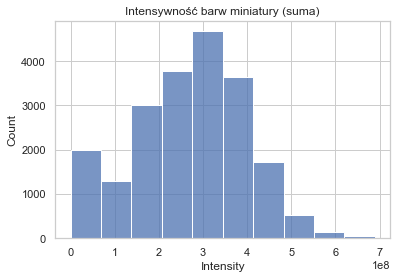

In [5]:
plt.title("Intensywność barw miniatury (suma)")
sns.histplot(data=tn, x='Intensity', bins=10)

<AxesSubplot:title={'center':'Intensywność barw miniatury (czerwony)'}, xlabel='Red', ylabel='Count'>

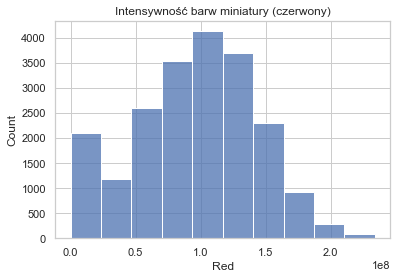

In [9]:
plt.title("Intensywność barw miniatury (czerwony)")
sns.histplot(data=tn, x='Red', bins=10)

<AxesSubplot:title={'center':'Intensywność barw miniatury (zielony)'}, xlabel='Green', ylabel='Count'>

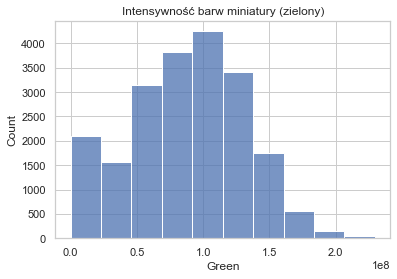

In [10]:
plt.title("Intensywność barw miniatury (zielony)")
sns.histplot(data=tn, x='Green', bins=10)

<AxesSubplot:title={'center':'Intensywność barw miniatury (niebieski)'}, xlabel='Blue', ylabel='Count'>

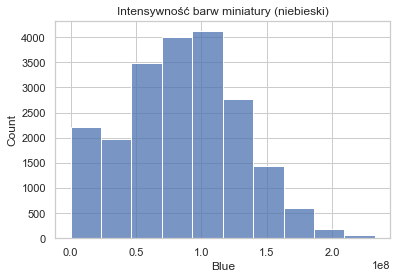

In [11]:
plt.title("Intensywność barw miniatury (niebieski)")
sns.histplot(data=tn, x='Blue', bins=10)

<AxesSubplot:title={'center':'Entropia miniatury'}, xlabel='entropy', ylabel='Count'>

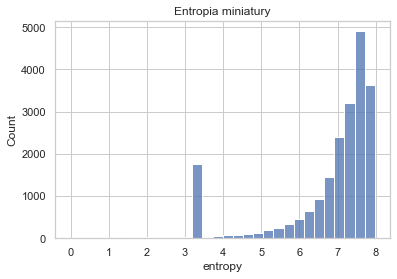

In [17]:
plt.title("Entropia miniatury")
sns.histplot(data=tn, x='entropy', bins=30)

<font size="5"><b>Wykrywanie elementów</b></font>

In [ ]:
#ta część kodu została przeniesiona do Colaba, aby zredukować bardzo duży czas obliczeń
detector = ObjectDetection()
detector.setModelTypeAsRetinaNet()
detector.setModelPath("resnet50_coco_best_v2.1.0.h5")
detector.loadModel()

licznik = 0
#zwraca liste obiektow znalezionych na obrazku
def detect_objects(img_link):
    global licznik
    licznik +=1
    print("Przetwarzanie obrazu nr ", licznik)
    response = requests.get(img_link)
    img = Image.open(BytesIO(response.content))
    img = np.array(img)
    returned_images, detections = detector.detectObjectsFromImage(input_type="array", output_type="array", input_image=img, minimum_percentage_probability=30)
    
    return [det['name'] for det in detections]

tn['objects'] = tn['thumbnail_link_big'].apply(detect_objects)

Przetwarzanie obrazu nr  1
Przetwarzanie obrazu nr  2
Przetwarzanie obrazu nr  3
Przetwarzanie obrazu nr  4
Przetwarzanie obrazu nr  5
Przetwarzanie obrazu nr  6
Przetwarzanie obrazu nr  7
Przetwarzanie obrazu nr  8
Przetwarzanie obrazu nr  9
Przetwarzanie obrazu nr  10
Przetwarzanie obrazu nr  11
Przetwarzanie obrazu nr  12
Przetwarzanie obrazu nr  13
Przetwarzanie obrazu nr  14
Przetwarzanie obrazu nr  15
Przetwarzanie obrazu nr  16
Przetwarzanie obrazu nr  17
Przetwarzanie obrazu nr  18
Przetwarzanie obrazu nr  19
Przetwarzanie obrazu nr  20
Przetwarzanie obrazu nr  21
Przetwarzanie obrazu nr  22
Przetwarzanie obrazu nr  23
Przetwarzanie obrazu nr  24
Przetwarzanie obrazu nr  25
Przetwarzanie obrazu nr  26
Przetwarzanie obrazu nr  27
Przetwarzanie obrazu nr  28
Przetwarzanie obrazu nr  29
Przetwarzanie obrazu nr  30
Przetwarzanie obrazu nr  31
Przetwarzanie obrazu nr  32
Przetwarzanie obrazu nr  33
Przetwarzanie obrazu nr  34
Przetwarzanie obrazu nr  35
Przetwarzanie obrazu nr  36
P

Przetwarzanie obrazu nr  283
Przetwarzanie obrazu nr  284
Przetwarzanie obrazu nr  285
Przetwarzanie obrazu nr  286
Przetwarzanie obrazu nr  287
Przetwarzanie obrazu nr  288
Przetwarzanie obrazu nr  289
Przetwarzanie obrazu nr  290
Przetwarzanie obrazu nr  291
Przetwarzanie obrazu nr  292
Przetwarzanie obrazu nr  293
Przetwarzanie obrazu nr  294
Przetwarzanie obrazu nr  295
Przetwarzanie obrazu nr  296
Przetwarzanie obrazu nr  297
Przetwarzanie obrazu nr  298
Przetwarzanie obrazu nr  299
Przetwarzanie obrazu nr  300
Przetwarzanie obrazu nr  301
Przetwarzanie obrazu nr  302
Przetwarzanie obrazu nr  303
Przetwarzanie obrazu nr  304
Przetwarzanie obrazu nr  305
Przetwarzanie obrazu nr  306
Przetwarzanie obrazu nr  307
Przetwarzanie obrazu nr  308
Przetwarzanie obrazu nr  309
Przetwarzanie obrazu nr  310
Przetwarzanie obrazu nr  311
Przetwarzanie obrazu nr  312
Przetwarzanie obrazu nr  313
Przetwarzanie obrazu nr  314
Przetwarzanie obrazu nr  315
Przetwarzanie obrazu nr  316
Przetwarzanie 

In [14]:
tn = pd.read_csv('tn3.csv')
tn

Unnamed: 0                                 thumbnail_link_big  \
0               0  https://i.ytimg.com/vi/3C66w5Z0ixs/maxresdefau...   
1               1  https://i.ytimg.com/vi/M9Pmf9AB4Mo/maxresdefau...   
2               2  https://i.ytimg.com/vi/J78aPJ3VyNs/maxresdefau...   
3               3  https://i.ytimg.com/vi/kXLn3HkpjaA/maxresdefau...   
4               4  https://i.ytimg.com/vi/VIUo6yapDbc/maxresdefau...   
...           ...                                                ...   
20826       20826  https://i.ytimg.com/vi/r93stUU8yXA/maxresdefau...   
20827       20827  https://i.ytimg.com/vi/84LhrZ-NN_E/maxresdefau...   
20828       20828  https://i.ytimg.com/vi/ZGsavMW4770/maxresdefau...   
20829       20829  https://i.ytimg.com/vi/_3xV0J3dzMs/maxresdefau...   
20830       20830  https://i.ytimg.com/vi/h2UN0EtuY1g/maxresdefau...   

        entropy        Red      Green       Blue  Intensity  \
0      7.443330  177842706  165815593  162852251  506510550   
1      7.166094   92454233   62854385   44517027  199825645   
2      7.878431  120678187   99558149   83089369  303325705   
3      7.791861  127263714  117554113  103429243  348247070   
4      7.863433  153499909  107281923   99107318  359889150   
...         ...        ...        ...        ...        ...   
20826  6.603659   39323474   38599257   35955973  113878704   
20827  3.239539    2094623    2094623    2094623    6283869   
20828  6.707255   49737191   37494319   43191421  130422931   
20829  7.019108   65379019   59856261   54719173  179954453   
20830  3.239539    2094623    2094623    2094623    6283869   

                                                 objects  
0                                   ['person', 'person']  
1                                                     []  
2                            ['person', 'tie', 'banana']  
3      ['train', 'stop sign', 'person', 'person', 'pe...  
4      ['person', 'person', 'person', 'person', 'pers...  
...                                                  ...  
20826                                                 []  
20827                                     ['cell phone']  
20828  ['bottle', 'cup', 'dining table', 'cup', 'cake...  
20829  ['person', 'person', 'person', 'laptop', 'cell...  
20830                                     ['cell phone']  

[20831 rows x 8 columns]

In [2]:
tn = pd.read_csv('tn_faces.csv')
tn = tn.drop('Unnamed: 0', axis=1)

Unnamed: 0                                 thumbnail_link_big  \
0               0  https://i.ytimg.com/vi/3C66w5Z0ixs/maxresdefau...   
1               1  https://i.ytimg.com/vi/M9Pmf9AB4Mo/maxresdefau...   
2               2  https://i.ytimg.com/vi/J78aPJ3VyNs/maxresdefau...   
3               3  https://i.ytimg.com/vi/kXLn3HkpjaA/maxresdefau...   
4               4  https://i.ytimg.com/vi/VIUo6yapDbc/maxresdefau...   
...           ...                                                ...   
20826       20826  https://i.ytimg.com/vi/r93stUU8yXA/maxresdefau...   
20827       20827  https://i.ytimg.com/vi/84LhrZ-NN_E/maxresdefau...   
20828       20828  https://i.ytimg.com/vi/ZGsavMW4770/maxresdefau...   
20829       20829  https://i.ytimg.com/vi/_3xV0J3dzMs/maxresdefau...   
20830       20830  https://i.ytimg.com/vi/h2UN0EtuY1g/maxresdefau...   

        entropy        Red      Green       Blue  Intensity  \
0      7.443330  177842706  165815593  162852251  506510550   
1      7.166094   92454233   62854385   44517027  199825645   
2      7.878431  120678187   99558149   83089369  303325705   
3      7.791861  127263714  117554113  103429243  348247070   
4      7.863433  153499909  107281923   99107318  359889150   
...         ...        ...        ...        ...        ...   
20826  6.603659   39323474   38599257   35955973  113878704   
20827  3.239539    2094623    2094623    2094623    6283869   
20828  6.707255   49737191   37494319   43191421  130422931   
20829  7.019108   65379019   59856261   54719173  179954453   
20830  3.239539    2094623    2094623    2094623    6283869   

                                                 objects  Emotion   Age  \
0                                   ['person', 'person']    happy  31.0   
1                                                     []  neutral  34.0   
2                            ['person', 'tie', 'banana']    angry  37.0   
3      ['train', 'stop sign', 'person', 'person', 'pe...    happy  22.0   
4      ['person', 'person', 'person', 'person', 'pers...     fear  25.0   
...                                                  ...      ...   ...   
20826                                                 []      NaN   NaN   
20827                                     ['cell phone']      NaN   NaN   
20828  ['bottle', 'cup', 'dining table', 'cup', 'cake...      NaN   NaN   
20829  ['person', 'person', 'person', 'laptop', 'cell...      NaN   NaN   
20830                                     ['cell phone']      NaN   NaN   

      Gender             Race  
0        Man  latino hispanic  
1        Man            white  
2        Man   middle eastern  
3        Man            black  
4        Man            white  
...      ...              ...  
20826    NaN              NaN  
20827    NaN              NaN  
20828    NaN              NaN  
20829    NaN              NaN  
20830    NaN              NaN  

[20831 rows x 12 columns]

In [ ]:
#zwraca wiek, plec, emocje oraz rase znalezionej osoby na obrazie
models = {}
models['age'] = DeepFace.build_model('Age')
models['gender'] = DeepFace.build_model('Gender')
models['emotion'] = DeepFace.build_model('Emotion')
models['race'] = DeepFace.build_model('Race')


def face_analysis(img_link):
    try:
        response = requests.get(img_link)
        img = Image.open(BytesIO(response.content))
        img = np.array(img)

        analysis = DeepFace.analyze(img_path = img, actions = ['age', 'gender', 'race', 'emotion'], enforce_detection=False, models=models)
        emotion = analysis['dominant_emotion']
        age = analysis['age']
        gender = analysis['gender']
        dominant_race = analysis['dominant_race']
    except:
        emotion = None
        age = None
        gender = None
        dominant_race = None       
        
    return emotion, age, gender, dominant_race


#tn = tn.apply(face_analysis, axis=1)
#"ręczna" iteracja aby na bieżąco zapisywać zmiany w df
# tn['Emotion'] = None
# tn['Age'] = None
# tn['Gender'] = None
# tn['Race'] = None

#do 12.5k 
#for i in range(len(tn)):
for i in range(8000,len(tn)):
    print("Przetwarzanie obrazu nr ", i)
    tn['Emotion'][i], tn['Age'][i], tn['Gender'][i], tn['Race'][i] = face_analysis(tn['thumbnail_link_big'][i])
    if i%500 == 0:
        tn.to_csv('tn_faces.csv',index=False)



Przetwarzanie obrazu nr  8000


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]


Przetwarzanie obrazu nr  8001


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.75it/s]


Przetwarzanie obrazu nr  8002


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.15it/s]


Przetwarzanie obrazu nr  8003


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.28it/s]


Przetwarzanie obrazu nr  8004


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.43it/s]


Przetwarzanie obrazu nr  8005


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.42it/s]


Przetwarzanie obrazu nr  8006


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  4.00it/s]


Przetwarzanie obrazu nr  8007


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.37it/s]


Przetwarzanie obrazu nr  8008


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.39it/s]


Przetwarzanie obrazu nr  8009


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.10it/s]


Przetwarzanie obrazu nr  8010


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.10it/s]


Przetwarzanie obrazu nr  8011


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.47it/s]


Przetwarzanie obrazu nr  8012


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.47it/s]


Przetwarzanie obrazu nr  8013


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.19it/s]


Przetwarzanie obrazu nr  8014


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.58it/s]


Przetwarzanie obrazu nr  8015


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.15it/s]


Przetwarzanie obrazu nr  8016


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.15it/s]


Przetwarzanie obrazu nr  8017


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.19it/s]


Przetwarzanie obrazu nr  8018


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.90it/s]


Przetwarzanie obrazu nr  8019


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.53it/s]


Przetwarzanie obrazu nr  8020


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.49it/s]


Przetwarzanie obrazu nr  8021


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.52it/s]


Przetwarzanie obrazu nr  8022


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.11it/s]


Przetwarzanie obrazu nr  8023


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.96it/s]


Przetwarzanie obrazu nr  8024


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.58it/s]


Przetwarzanie obrazu nr  8025


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.16it/s]


Przetwarzanie obrazu nr  8026


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.52it/s]


Przetwarzanie obrazu nr  8027


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.70it/s]


Przetwarzanie obrazu nr  8028


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.13it/s]


Przetwarzanie obrazu nr  8029


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.89it/s]


Przetwarzanie obrazu nr  8030


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.65it/s]


Przetwarzanie obrazu nr  8031


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.30it/s]


Przetwarzanie obrazu nr  8032


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.73it/s]


Przetwarzanie obrazu nr  8033


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.19it/s]


Przetwarzanie obrazu nr  8034


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.61it/s]


Przetwarzanie obrazu nr  8035


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.01it/s]


Przetwarzanie obrazu nr  8036


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.21it/s]


Przetwarzanie obrazu nr  8037


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.23it/s]


Przetwarzanie obrazu nr  8038


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.39it/s]


Przetwarzanie obrazu nr  8039


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.46it/s]


Przetwarzanie obrazu nr  8040


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.41it/s]


Przetwarzanie obrazu nr  8041


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.07it/s]


Przetwarzanie obrazu nr  8042


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.04it/s]


Przetwarzanie obrazu nr  8043


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.22it/s]


Przetwarzanie obrazu nr  8044


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.86it/s]


Przetwarzanie obrazu nr  8045


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.94it/s]


Przetwarzanie obrazu nr  8046


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.51it/s]


Przetwarzanie obrazu nr  8047


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.03it/s]


Przetwarzanie obrazu nr  8048


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.05it/s]


Przetwarzanie obrazu nr  8049


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.52it/s]


Przetwarzanie obrazu nr  8050


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.68it/s]


Przetwarzanie obrazu nr  8051


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.65it/s]


Przetwarzanie obrazu nr  8052


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.39it/s]


Przetwarzanie obrazu nr  8053


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.72it/s]


Przetwarzanie obrazu nr  8054


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.52it/s]


Przetwarzanie obrazu nr  8055


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.28it/s]


Przetwarzanie obrazu nr  8056


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.54it/s]


Przetwarzanie obrazu nr  8057


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.50it/s]


Przetwarzanie obrazu nr  8058


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.08it/s]


Przetwarzanie obrazu nr  8059


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.32it/s]


Przetwarzanie obrazu nr  8060


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.54it/s]


Przetwarzanie obrazu nr  8061


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.81it/s]


Przetwarzanie obrazu nr  8062


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.38it/s]


Przetwarzanie obrazu nr  8063


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.23it/s]


Przetwarzanie obrazu nr  8064


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.49it/s]


Przetwarzanie obrazu nr  8065


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.75it/s]


Przetwarzanie obrazu nr  8066


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.75it/s]


Przetwarzanie obrazu nr  8067


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.90it/s]


Przetwarzanie obrazu nr  8068


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.61it/s]


Przetwarzanie obrazu nr  8069


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.65it/s]


Przetwarzanie obrazu nr  8070


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.47it/s]


Przetwarzanie obrazu nr  8071


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.36it/s]


Przetwarzanie obrazu nr  8072


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.37it/s]


Przetwarzanie obrazu nr  8073


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.69it/s]


Przetwarzanie obrazu nr  8074


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.33it/s]


Przetwarzanie obrazu nr  8075


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.35it/s]


Przetwarzanie obrazu nr  8076


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.55it/s]


Przetwarzanie obrazu nr  8077


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.69it/s]


Przetwarzanie obrazu nr  8078


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.94it/s]


Przetwarzanie obrazu nr  8079


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.98it/s]


Przetwarzanie obrazu nr  8080


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.35it/s]


Przetwarzanie obrazu nr  8081


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.43it/s]


Przetwarzanie obrazu nr  8082


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.37it/s]


Przetwarzanie obrazu nr  8083


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.87it/s]


Przetwarzanie obrazu nr  8084


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.43it/s]


Przetwarzanie obrazu nr  8085


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.19it/s]


Przetwarzanie obrazu nr  8086


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.18it/s]


Przetwarzanie obrazu nr  8087


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.06it/s]


Przetwarzanie obrazu nr  8088


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.93it/s]


Przetwarzanie obrazu nr  8089


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.69it/s]


Przetwarzanie obrazu nr  8090


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.06it/s]


Przetwarzanie obrazu nr  8091


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.42it/s]


Przetwarzanie obrazu nr  8092


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.80it/s]


Przetwarzanie obrazu nr  8093


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.23it/s]


Przetwarzanie obrazu nr  8094


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.68it/s]


Przetwarzanie obrazu nr  8095


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.07it/s]


Przetwarzanie obrazu nr  8096


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.40it/s]


Przetwarzanie obrazu nr  8097


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.01it/s]


Przetwarzanie obrazu nr  8098


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.51it/s]


Przetwarzanie obrazu nr  8099


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.04it/s]


Przetwarzanie obrazu nr  8100


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.68it/s]


Przetwarzanie obrazu nr  8101


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.63it/s]


Przetwarzanie obrazu nr  8102


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.32it/s]


Przetwarzanie obrazu nr  8103


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.32it/s]


Przetwarzanie obrazu nr  8104


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.78it/s]


Przetwarzanie obrazu nr  8105


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.90it/s]


Przetwarzanie obrazu nr  8106


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.69it/s]


Przetwarzanie obrazu nr  8107


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.75it/s]


Przetwarzanie obrazu nr  8108


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.41it/s]


Przetwarzanie obrazu nr  8109


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.70it/s]


Przetwarzanie obrazu nr  8110


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.61it/s]


Przetwarzanie obrazu nr  8111


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.47it/s]


Przetwarzanie obrazu nr  8112


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.16it/s]


Przetwarzanie obrazu nr  8113


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.15it/s]


Przetwarzanie obrazu nr  8114


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.38it/s]


Przetwarzanie obrazu nr  8115


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.98it/s]


Przetwarzanie obrazu nr  8116


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.18it/s]


Przetwarzanie obrazu nr  8117


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.63it/s]


Przetwarzanie obrazu nr  8118


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.07it/s]


Przetwarzanie obrazu nr  8119


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.52it/s]


Przetwarzanie obrazu nr  8120


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.64it/s]


Przetwarzanie obrazu nr  8121


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.50it/s]


Przetwarzanie obrazu nr  8122


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.31it/s]


Przetwarzanie obrazu nr  8123


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.69it/s]


Przetwarzanie obrazu nr  8124


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.36it/s]


Przetwarzanie obrazu nr  8125


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.30it/s]


Przetwarzanie obrazu nr  8126


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.16it/s]


Przetwarzanie obrazu nr  8127


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.76it/s]


Przetwarzanie obrazu nr  8128


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.67it/s]


Przetwarzanie obrazu nr  8129


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.90it/s]


Przetwarzanie obrazu nr  8130


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.74it/s]


Przetwarzanie obrazu nr  8131


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.71it/s]


Przetwarzanie obrazu nr  8132


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.06it/s]


Przetwarzanie obrazu nr  8133


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.30it/s]


Przetwarzanie obrazu nr  8134


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.94it/s]


Przetwarzanie obrazu nr  8135


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.97it/s]


Przetwarzanie obrazu nr  8136


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.80it/s]


Przetwarzanie obrazu nr  8137


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.27it/s]


Przetwarzanie obrazu nr  8138


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.85it/s]


Przetwarzanie obrazu nr  8139


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.24it/s]


Przetwarzanie obrazu nr  8140


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.97it/s]


Przetwarzanie obrazu nr  8141


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.02it/s]


Przetwarzanie obrazu nr  8142


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.68it/s]


Przetwarzanie obrazu nr  8143


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.43it/s]


Przetwarzanie obrazu nr  8144


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.38it/s]


Przetwarzanie obrazu nr  8145


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.50it/s]


Przetwarzanie obrazu nr  8146


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.82it/s]


Przetwarzanie obrazu nr  8147


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.51it/s]


Przetwarzanie obrazu nr  8148


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.73it/s]


Przetwarzanie obrazu nr  8149


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.96it/s]


Przetwarzanie obrazu nr  8150


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.79it/s]


Przetwarzanie obrazu nr  8151


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.61it/s]


Przetwarzanie obrazu nr  8152


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.74it/s]


Przetwarzanie obrazu nr  8153


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.98it/s]


Przetwarzanie obrazu nr  8154


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.47it/s]


Przetwarzanie obrazu nr  8155


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.94it/s]


Przetwarzanie obrazu nr  8156


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.93it/s]


Przetwarzanie obrazu nr  8157


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.04it/s]


Przetwarzanie obrazu nr  8158


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.50it/s]


Przetwarzanie obrazu nr  8159


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.73it/s]


Przetwarzanie obrazu nr  8160


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.47it/s]


Przetwarzanie obrazu nr  8161


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.02it/s]


Przetwarzanie obrazu nr  8162


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.85it/s]


Przetwarzanie obrazu nr  8163


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.85it/s]


Przetwarzanie obrazu nr  8164


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.28it/s]


Przetwarzanie obrazu nr  8165


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.90it/s]


Przetwarzanie obrazu nr  8166


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.74it/s]


Przetwarzanie obrazu nr  8167


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.12it/s]


Przetwarzanie obrazu nr  8168


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.87it/s]


Przetwarzanie obrazu nr  8169


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.66it/s]


Przetwarzanie obrazu nr  8170


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.42it/s]


Przetwarzanie obrazu nr  8171


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.90it/s]


Przetwarzanie obrazu nr  8172


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.66it/s]


Przetwarzanie obrazu nr  8173


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.16it/s]


Przetwarzanie obrazu nr  8174


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.05it/s]


Przetwarzanie obrazu nr  8175


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.06it/s]


Przetwarzanie obrazu nr  8176


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.67it/s]


Przetwarzanie obrazu nr  8177


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.97it/s]


Przetwarzanie obrazu nr  8178


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.18it/s]


Przetwarzanie obrazu nr  8179


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.36it/s]


Przetwarzanie obrazu nr  8180


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.71it/s]


Przetwarzanie obrazu nr  8181


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.67it/s]


Przetwarzanie obrazu nr  8182


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.12it/s]


Przetwarzanie obrazu nr  8183


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.36it/s]


Przetwarzanie obrazu nr  8184


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.12it/s]


Przetwarzanie obrazu nr  8185


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.54it/s]


Przetwarzanie obrazu nr  8186


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.35it/s]


Przetwarzanie obrazu nr  8187


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.39it/s]


Przetwarzanie obrazu nr  8188


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.58it/s]


Przetwarzanie obrazu nr  8189


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.03it/s]


Przetwarzanie obrazu nr  8190


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.37it/s]


Przetwarzanie obrazu nr  8191


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.24it/s]


Przetwarzanie obrazu nr  8192


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.63it/s]


Przetwarzanie obrazu nr  8193


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.10it/s]


Przetwarzanie obrazu nr  8194


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.01it/s]


Przetwarzanie obrazu nr  8195


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.39it/s]


Przetwarzanie obrazu nr  8196


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.53it/s]


Przetwarzanie obrazu nr  8197


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.00it/s]


Przetwarzanie obrazu nr  8198


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.79it/s]


Przetwarzanie obrazu nr  8199


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.28it/s]


Przetwarzanie obrazu nr  8200


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.43it/s]


Przetwarzanie obrazu nr  8201


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.80it/s]


Przetwarzanie obrazu nr  8202


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.38it/s]


Przetwarzanie obrazu nr  8203


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.32it/s]


Przetwarzanie obrazu nr  8204


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.50it/s]


Przetwarzanie obrazu nr  8205


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.68it/s]


Przetwarzanie obrazu nr  8206


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.30it/s]


Przetwarzanie obrazu nr  8207


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.89it/s]


Przetwarzanie obrazu nr  8208


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.41it/s]


Przetwarzanie obrazu nr  8209


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.38it/s]


Przetwarzanie obrazu nr  8210


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.60it/s]


Przetwarzanie obrazu nr  8211


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.66it/s]


Przetwarzanie obrazu nr  8212


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.09it/s]


Przetwarzanie obrazu nr  8213


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.38it/s]


Przetwarzanie obrazu nr  8214


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.43it/s]


Przetwarzanie obrazu nr  8215


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.79it/s]


Przetwarzanie obrazu nr  8216


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.23it/s]


Przetwarzanie obrazu nr  8217


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.97it/s]


Przetwarzanie obrazu nr  8218


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.24it/s]


Przetwarzanie obrazu nr  8219


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.81it/s]


Przetwarzanie obrazu nr  8220


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.83it/s]


Przetwarzanie obrazu nr  8221


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.48it/s]


Przetwarzanie obrazu nr  8222


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.37it/s]


Przetwarzanie obrazu nr  8223


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.33it/s]


Przetwarzanie obrazu nr  8224


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.86it/s]


Przetwarzanie obrazu nr  8225


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.93it/s]


Przetwarzanie obrazu nr  8226


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.53it/s]


Przetwarzanie obrazu nr  8227


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.31it/s]


Przetwarzanie obrazu nr  8228


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.91it/s]


Przetwarzanie obrazu nr  8229


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.05it/s]


Przetwarzanie obrazu nr  8230


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.91it/s]


Przetwarzanie obrazu nr  8231


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.74it/s]


Przetwarzanie obrazu nr  8232


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.22it/s]


Przetwarzanie obrazu nr  8233


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.13it/s]


Przetwarzanie obrazu nr  8234


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.32it/s]


Przetwarzanie obrazu nr  8235


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.26it/s]


Przetwarzanie obrazu nr  8236


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.20it/s]


Przetwarzanie obrazu nr  8237


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.47it/s]


Przetwarzanie obrazu nr  8238


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.81it/s]


Przetwarzanie obrazu nr  8239


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.70it/s]


Przetwarzanie obrazu nr  8240


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.78it/s]


Przetwarzanie obrazu nr  8241


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.84it/s]


Przetwarzanie obrazu nr  8242


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.98it/s]


Przetwarzanie obrazu nr  8243


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.45it/s]


Przetwarzanie obrazu nr  8244


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.36it/s]


Przetwarzanie obrazu nr  8245


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.02it/s]


Przetwarzanie obrazu nr  8246


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.62it/s]


Przetwarzanie obrazu nr  8247


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.49it/s]


Przetwarzanie obrazu nr  8248


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.77it/s]


Przetwarzanie obrazu nr  8249


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.63it/s]


Przetwarzanie obrazu nr  8250


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.15it/s]


Przetwarzanie obrazu nr  8251


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.13it/s]


Przetwarzanie obrazu nr  8252


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.90it/s]


Przetwarzanie obrazu nr  8253


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.61it/s]


Przetwarzanie obrazu nr  8254


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.68it/s]


Przetwarzanie obrazu nr  8255


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.46it/s]


Przetwarzanie obrazu nr  8256


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.98it/s]


Przetwarzanie obrazu nr  8257


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.49it/s]


Przetwarzanie obrazu nr  8258


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.13it/s]


Przetwarzanie obrazu nr  8259


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.39it/s]


Przetwarzanie obrazu nr  8260


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.13it/s]


Przetwarzanie obrazu nr  8261


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.12it/s]


Przetwarzanie obrazu nr  8262


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.60it/s]


Przetwarzanie obrazu nr  8263


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.39it/s]


Przetwarzanie obrazu nr  8264


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.42it/s]


Przetwarzanie obrazu nr  8265


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.71it/s]


Przetwarzanie obrazu nr  8266


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.62it/s]


Przetwarzanie obrazu nr  8267


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.96it/s]


Przetwarzanie obrazu nr  8268


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.99it/s]


Przetwarzanie obrazu nr  8269


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.31it/s]


Przetwarzanie obrazu nr  8270


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.70it/s]


Przetwarzanie obrazu nr  8271


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.57it/s]


Przetwarzanie obrazu nr  8272


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.49it/s]


Przetwarzanie obrazu nr  8273


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.78it/s]


Przetwarzanie obrazu nr  8274


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.75it/s]


Przetwarzanie obrazu nr  8275


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.63it/s]


Przetwarzanie obrazu nr  8276


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.35it/s]


Przetwarzanie obrazu nr  8277


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.06it/s]


Przetwarzanie obrazu nr  8278


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.01it/s]


Przetwarzanie obrazu nr  8279


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.66it/s]


Przetwarzanie obrazu nr  8280


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.03it/s]


Przetwarzanie obrazu nr  8281


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.86it/s]


Przetwarzanie obrazu nr  8282


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.41it/s]


Przetwarzanie obrazu nr  8283


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.16it/s]


Przetwarzanie obrazu nr  8284


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.65it/s]


Przetwarzanie obrazu nr  8285


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.27it/s]


Przetwarzanie obrazu nr  8286


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.79it/s]


Przetwarzanie obrazu nr  8287


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.23it/s]


Przetwarzanie obrazu nr  8288


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.00it/s]


Przetwarzanie obrazu nr  8289


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.89it/s]


Przetwarzanie obrazu nr  8290


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.46it/s]


Przetwarzanie obrazu nr  8291


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.59it/s]


Przetwarzanie obrazu nr  8292


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.46it/s]


Przetwarzanie obrazu nr  8293


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.95it/s]


Przetwarzanie obrazu nr  8294


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.60it/s]


Przetwarzanie obrazu nr  8295


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.35it/s]


Przetwarzanie obrazu nr  8296


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.81it/s]


Przetwarzanie obrazu nr  8297


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.66it/s]


Przetwarzanie obrazu nr  8298


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.47it/s]


Przetwarzanie obrazu nr  8299


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.98it/s]


Przetwarzanie obrazu nr  8300


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.99it/s]


Przetwarzanie obrazu nr  8301


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.44it/s]


Przetwarzanie obrazu nr  8302


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.98it/s]


Przetwarzanie obrazu nr  8303


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.83it/s]


Przetwarzanie obrazu nr  8304


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.55it/s]


Przetwarzanie obrazu nr  8305


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.07it/s]


Przetwarzanie obrazu nr  8306


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.14it/s]


Przetwarzanie obrazu nr  8307


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.95it/s]


Przetwarzanie obrazu nr  8308


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.75it/s]


Przetwarzanie obrazu nr  8309


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.09it/s]


Przetwarzanie obrazu nr  8310


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.23it/s]


Przetwarzanie obrazu nr  8311


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.61it/s]


Przetwarzanie obrazu nr  8312


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.81it/s]


Przetwarzanie obrazu nr  8313


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.58it/s]


Przetwarzanie obrazu nr  8314


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.80it/s]


Przetwarzanie obrazu nr  8315


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.89it/s]


Przetwarzanie obrazu nr  8316


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.25it/s]


Przetwarzanie obrazu nr  8317


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.20it/s]


Przetwarzanie obrazu nr  8318


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.45it/s]


Przetwarzanie obrazu nr  8319


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.46it/s]


Przetwarzanie obrazu nr  8320


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.02it/s]


Przetwarzanie obrazu nr  8321


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.83it/s]


Przetwarzanie obrazu nr  8322


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.80it/s]


Przetwarzanie obrazu nr  8323


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.02it/s]


Przetwarzanie obrazu nr  8324


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.14it/s]


Przetwarzanie obrazu nr  8325


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.65it/s]


Przetwarzanie obrazu nr  8326


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.80it/s]


Przetwarzanie obrazu nr  8327


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.11it/s]


Przetwarzanie obrazu nr  8328


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.00it/s]


Przetwarzanie obrazu nr  8329


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.64it/s]


Przetwarzanie obrazu nr  8330


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.03it/s]


Przetwarzanie obrazu nr  8331


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.33it/s]


Przetwarzanie obrazu nr  8332


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.88it/s]


Przetwarzanie obrazu nr  8333


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.85it/s]


Przetwarzanie obrazu nr  8334


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.28it/s]


Przetwarzanie obrazu nr  8335


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.73it/s]


Przetwarzanie obrazu nr  8336


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.83it/s]


Przetwarzanie obrazu nr  8337


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.80it/s]


Przetwarzanie obrazu nr  8338


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.00it/s]


Przetwarzanie obrazu nr  8339


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.38it/s]


Przetwarzanie obrazu nr  8340


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.52it/s]


Przetwarzanie obrazu nr  8341


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.03it/s]


Przetwarzanie obrazu nr  8342


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.91it/s]


Przetwarzanie obrazu nr  8343


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.77it/s]


Przetwarzanie obrazu nr  8344


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.41it/s]


Przetwarzanie obrazu nr  8345


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.56it/s]


Przetwarzanie obrazu nr  8346


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.34it/s]


Przetwarzanie obrazu nr  8347


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.02it/s]


Przetwarzanie obrazu nr  8348


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.41it/s]


Przetwarzanie obrazu nr  8349


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.12it/s]


Przetwarzanie obrazu nr  8350


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.94it/s]


Przetwarzanie obrazu nr  8351


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.31it/s]


Przetwarzanie obrazu nr  8352


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.78it/s]


Przetwarzanie obrazu nr  8353


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.73it/s]


Przetwarzanie obrazu nr  8354


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.89it/s]


Przetwarzanie obrazu nr  8355


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.45it/s]


Przetwarzanie obrazu nr  8356


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.62it/s]


Przetwarzanie obrazu nr  8357


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.19it/s]


Przetwarzanie obrazu nr  8358


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.91it/s]


Przetwarzanie obrazu nr  8359


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.90it/s]


Przetwarzanie obrazu nr  8360


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.13it/s]


Przetwarzanie obrazu nr  8361


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.42it/s]


Przetwarzanie obrazu nr  8362


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.09it/s]


Przetwarzanie obrazu nr  8363


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.40it/s]


Przetwarzanie obrazu nr  8364


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.21it/s]


Przetwarzanie obrazu nr  8365


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.87it/s]


Przetwarzanie obrazu nr  8366


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.61it/s]


Przetwarzanie obrazu nr  8367


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.91it/s]


Przetwarzanie obrazu nr  8368


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.28it/s]


Przetwarzanie obrazu nr  8369


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.61it/s]


Przetwarzanie obrazu nr  8370


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.19it/s]


Przetwarzanie obrazu nr  8371


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.63it/s]


Przetwarzanie obrazu nr  8372


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.17it/s]


Przetwarzanie obrazu nr  8373


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.09it/s]


Przetwarzanie obrazu nr  8374


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.93it/s]


Przetwarzanie obrazu nr  8375


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.77it/s]


Przetwarzanie obrazu nr  8376


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.11it/s]


Przetwarzanie obrazu nr  8377


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.87it/s]


Przetwarzanie obrazu nr  8378


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.42it/s]


Przetwarzanie obrazu nr  8379


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.74it/s]


Przetwarzanie obrazu nr  8380


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.18it/s]


Przetwarzanie obrazu nr  8381


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.31it/s]


Przetwarzanie obrazu nr  8382


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.71it/s]


Przetwarzanie obrazu nr  8383


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.57it/s]


Przetwarzanie obrazu nr  8384


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.53it/s]


Przetwarzanie obrazu nr  8385


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.00it/s]


Przetwarzanie obrazu nr  8386


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.98it/s]


Przetwarzanie obrazu nr  8387


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.86it/s]


Przetwarzanie obrazu nr  8388


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.63it/s]


Przetwarzanie obrazu nr  8389


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.01it/s]


Przetwarzanie obrazu nr  8390


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.74it/s]


Przetwarzanie obrazu nr  8391


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.00it/s]


Przetwarzanie obrazu nr  8392


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.54it/s]


Przetwarzanie obrazu nr  8393


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.47it/s]


Przetwarzanie obrazu nr  8394


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.62it/s]


Przetwarzanie obrazu nr  8395


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.82it/s]


Przetwarzanie obrazu nr  8396


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.42it/s]


Przetwarzanie obrazu nr  8397


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.18it/s]


Przetwarzanie obrazu nr  8398


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.44it/s]


Przetwarzanie obrazu nr  8399


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.46it/s]


Przetwarzanie obrazu nr  8400


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.37it/s]


Przetwarzanie obrazu nr  8401


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.83it/s]


Przetwarzanie obrazu nr  8402


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.95it/s]


Przetwarzanie obrazu nr  8403


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.51it/s]


Przetwarzanie obrazu nr  8404


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.44it/s]


Przetwarzanie obrazu nr  8405


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.75it/s]


Przetwarzanie obrazu nr  8406


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.32it/s]


Przetwarzanie obrazu nr  8407


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.34it/s]


Przetwarzanie obrazu nr  8408


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.35it/s]


Przetwarzanie obrazu nr  8409


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.18it/s]


Przetwarzanie obrazu nr  8410


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.94it/s]


Przetwarzanie obrazu nr  8411


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.62it/s]


Przetwarzanie obrazu nr  8412


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.90it/s]


Przetwarzanie obrazu nr  8413


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.56it/s]


Przetwarzanie obrazu nr  8414


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.96it/s]


Przetwarzanie obrazu nr  8415


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.84it/s]


Przetwarzanie obrazu nr  8416


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.07it/s]


Przetwarzanie obrazu nr  8417


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.64it/s]


Przetwarzanie obrazu nr  8418


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.68it/s]


Przetwarzanie obrazu nr  8419


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.83it/s]


Przetwarzanie obrazu nr  8420


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.01it/s]


Przetwarzanie obrazu nr  8421


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.18it/s]


Przetwarzanie obrazu nr  8422


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.02it/s]


Przetwarzanie obrazu nr  8423


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.96it/s]


Przetwarzanie obrazu nr  8424


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.74it/s]


Przetwarzanie obrazu nr  8425


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.37it/s]


Przetwarzanie obrazu nr  8426


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.32it/s]


Przetwarzanie obrazu nr  8427


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.78it/s]


Przetwarzanie obrazu nr  8428


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.20it/s]


Przetwarzanie obrazu nr  8429


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.32it/s]


Przetwarzanie obrazu nr  8430


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.15it/s]


Przetwarzanie obrazu nr  8431


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.82it/s]


Przetwarzanie obrazu nr  8432


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.34it/s]


Przetwarzanie obrazu nr  8433


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.88it/s]


Przetwarzanie obrazu nr  8434


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.36it/s]


Przetwarzanie obrazu nr  8435


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.17it/s]


Przetwarzanie obrazu nr  8436


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.30it/s]


Przetwarzanie obrazu nr  8437


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.14it/s]


Przetwarzanie obrazu nr  8438


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.75it/s]


Przetwarzanie obrazu nr  8439


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.30it/s]


Przetwarzanie obrazu nr  8440


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.65it/s]


Przetwarzanie obrazu nr  8441


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.06it/s]


Przetwarzanie obrazu nr  8442


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.36it/s]


Przetwarzanie obrazu nr  8443


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.83it/s]


Przetwarzanie obrazu nr  8444


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.46it/s]


Przetwarzanie obrazu nr  8445


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.77it/s]


Przetwarzanie obrazu nr  8446


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.52it/s]


Przetwarzanie obrazu nr  8447


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.39it/s]


Przetwarzanie obrazu nr  8448


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.67it/s]


Przetwarzanie obrazu nr  8449


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.04it/s]


Przetwarzanie obrazu nr  8450


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.96it/s]


Przetwarzanie obrazu nr  8451


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.46it/s]


Przetwarzanie obrazu nr  8452


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.10it/s]


Przetwarzanie obrazu nr  8453


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.03it/s]


Przetwarzanie obrazu nr  8454


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.70it/s]


Przetwarzanie obrazu nr  8455


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.22it/s]


Przetwarzanie obrazu nr  8456


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.48it/s]


Przetwarzanie obrazu nr  8457


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.15it/s]


Przetwarzanie obrazu nr  8458


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.33it/s]


Przetwarzanie obrazu nr  8459


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.23it/s]


Przetwarzanie obrazu nr  8460


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.14it/s]


Przetwarzanie obrazu nr  8461


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.95it/s]


Przetwarzanie obrazu nr  8462


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.98it/s]


Przetwarzanie obrazu nr  8463


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.84it/s]


Przetwarzanie obrazu nr  8464


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.71it/s]


Przetwarzanie obrazu nr  8465


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.79it/s]


Przetwarzanie obrazu nr  8466


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.82it/s]


Przetwarzanie obrazu nr  8467


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.71it/s]


Przetwarzanie obrazu nr  8468


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.37it/s]


Przetwarzanie obrazu nr  8469


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.66it/s]


Przetwarzanie obrazu nr  8470


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.92it/s]


Przetwarzanie obrazu nr  8471


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.10it/s]


Przetwarzanie obrazu nr  8472


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.29it/s]


Przetwarzanie obrazu nr  8473


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.29it/s]


Przetwarzanie obrazu nr  8474


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.38it/s]


Przetwarzanie obrazu nr  8475


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.13it/s]


Przetwarzanie obrazu nr  8476


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.15it/s]


Przetwarzanie obrazu nr  8477


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.36it/s]


Przetwarzanie obrazu nr  8478


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.81it/s]


Przetwarzanie obrazu nr  8479


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.16it/s]


Przetwarzanie obrazu nr  8480


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.39it/s]


Przetwarzanie obrazu nr  8481


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.55it/s]


Przetwarzanie obrazu nr  8482


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.00it/s]


Przetwarzanie obrazu nr  8483


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.62it/s]


Przetwarzanie obrazu nr  8484


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.97it/s]


Przetwarzanie obrazu nr  8485


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.00it/s]


Przetwarzanie obrazu nr  8486


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.44it/s]


Przetwarzanie obrazu nr  8487


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.78it/s]


Przetwarzanie obrazu nr  8488


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.79it/s]


Przetwarzanie obrazu nr  8489


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.99it/s]


Przetwarzanie obrazu nr  8490


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.88it/s]


Przetwarzanie obrazu nr  8491


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.25it/s]


Przetwarzanie obrazu nr  8492


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.17it/s]


Przetwarzanie obrazu nr  8493


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.12it/s]


Przetwarzanie obrazu nr  8494


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  4.00it/s]


Przetwarzanie obrazu nr  8495


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.44it/s]


Przetwarzanie obrazu nr  8496


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.93it/s]


Przetwarzanie obrazu nr  8497


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.04it/s]


Przetwarzanie obrazu nr  8498


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.13it/s]


Przetwarzanie obrazu nr  8499


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.44it/s]


Przetwarzanie obrazu nr  8500


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.98it/s]


Przetwarzanie obrazu nr  8501


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.91it/s]


Przetwarzanie obrazu nr  8502


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.77it/s]


Przetwarzanie obrazu nr  8503


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.46it/s]


Przetwarzanie obrazu nr  8504


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.42it/s]


Przetwarzanie obrazu nr  8505


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.29it/s]


Przetwarzanie obrazu nr  8506


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.82it/s]


Przetwarzanie obrazu nr  8507


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.78it/s]


Przetwarzanie obrazu nr  8508


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.91it/s]


Przetwarzanie obrazu nr  8509


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.85it/s]


Przetwarzanie obrazu nr  8510


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.73it/s]


Przetwarzanie obrazu nr  8511


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.91it/s]


Przetwarzanie obrazu nr  8512


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.55it/s]


Przetwarzanie obrazu nr  8513


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.51it/s]


Przetwarzanie obrazu nr  8514


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.67it/s]


Przetwarzanie obrazu nr  8515


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.81it/s]


Przetwarzanie obrazu nr  8516


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.24it/s]


Przetwarzanie obrazu nr  8517


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.82it/s]


Przetwarzanie obrazu nr  8518


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.61it/s]


Przetwarzanie obrazu nr  8519


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.85it/s]


Przetwarzanie obrazu nr  8520


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.23it/s]


Przetwarzanie obrazu nr  8521


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.18it/s]


Przetwarzanie obrazu nr  8522


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.90it/s]


Przetwarzanie obrazu nr  8523


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.83it/s]


Przetwarzanie obrazu nr  8524


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.00it/s]


Przetwarzanie obrazu nr  8525


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.19it/s]


Przetwarzanie obrazu nr  8526


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.69it/s]


Przetwarzanie obrazu nr  8527


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.26it/s]


Przetwarzanie obrazu nr  8528


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.29it/s]


Przetwarzanie obrazu nr  8529


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.89it/s]


Przetwarzanie obrazu nr  8530


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.59it/s]


Przetwarzanie obrazu nr  8531


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.81it/s]


Przetwarzanie obrazu nr  8532


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.93it/s]


Przetwarzanie obrazu nr  8533


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.16it/s]


Przetwarzanie obrazu nr  8534


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.92it/s]


Przetwarzanie obrazu nr  8535


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.25it/s]


Przetwarzanie obrazu nr  8536


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.18it/s]


Przetwarzanie obrazu nr  8537


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.38it/s]


Przetwarzanie obrazu nr  8538


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.02it/s]


Przetwarzanie obrazu nr  8539


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.63it/s]


Przetwarzanie obrazu nr  8540


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.27it/s]


Przetwarzanie obrazu nr  8541


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.51it/s]


Przetwarzanie obrazu nr  8542


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.79it/s]


Przetwarzanie obrazu nr  8543


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.46it/s]


Przetwarzanie obrazu nr  8544


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.70it/s]


Przetwarzanie obrazu nr  8545


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.08it/s]


Przetwarzanie obrazu nr  8546


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.17it/s]


Przetwarzanie obrazu nr  8547


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.59it/s]


Przetwarzanie obrazu nr  8548


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.07it/s]


Przetwarzanie obrazu nr  8549


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.03it/s]


Przetwarzanie obrazu nr  8550


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.51it/s]


Przetwarzanie obrazu nr  8551


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.92it/s]


Przetwarzanie obrazu nr  8552


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.10it/s]


Przetwarzanie obrazu nr  8553


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.83it/s]


Przetwarzanie obrazu nr  8554


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.73it/s]


Przetwarzanie obrazu nr  8555


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.86it/s]


Przetwarzanie obrazu nr  8556


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.67it/s]


Przetwarzanie obrazu nr  8557


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.17it/s]


Przetwarzanie obrazu nr  8558


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.49it/s]


Przetwarzanie obrazu nr  8559


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.94it/s]


Przetwarzanie obrazu nr  8560


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.07it/s]


Przetwarzanie obrazu nr  8561


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.23it/s]


Przetwarzanie obrazu nr  8562


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.89it/s]


Przetwarzanie obrazu nr  8563


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.07it/s]


Przetwarzanie obrazu nr  8564


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.67it/s]


Przetwarzanie obrazu nr  8565


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.55it/s]


Przetwarzanie obrazu nr  8566


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.08it/s]


Przetwarzanie obrazu nr  8567


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.72it/s]


Przetwarzanie obrazu nr  8568


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.18it/s]


Przetwarzanie obrazu nr  8569


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.04it/s]


Przetwarzanie obrazu nr  8570


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.47it/s]


Przetwarzanie obrazu nr  8571


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.97it/s]


Przetwarzanie obrazu nr  8572


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.93it/s]


Przetwarzanie obrazu nr  8573


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.99it/s]


Przetwarzanie obrazu nr  8574


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.30it/s]


Przetwarzanie obrazu nr  8575


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.32it/s]


Przetwarzanie obrazu nr  8576


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.54it/s]


Przetwarzanie obrazu nr  8577


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.91it/s]


Przetwarzanie obrazu nr  8578


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.33it/s]


Przetwarzanie obrazu nr  8579


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.01it/s]


Przetwarzanie obrazu nr  8580


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.25it/s]


Przetwarzanie obrazu nr  8581


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.05it/s]


Przetwarzanie obrazu nr  8582


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.49it/s]


Przetwarzanie obrazu nr  8583


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.36it/s]


Przetwarzanie obrazu nr  8584


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.30it/s]


Przetwarzanie obrazu nr  8585


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.64it/s]


Przetwarzanie obrazu nr  8586


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.30it/s]


Przetwarzanie obrazu nr  8587


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.37it/s]


Przetwarzanie obrazu nr  8588


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.28it/s]


Przetwarzanie obrazu nr  8589


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.96it/s]


Przetwarzanie obrazu nr  8590


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.15it/s]


Przetwarzanie obrazu nr  8591


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.14it/s]


Przetwarzanie obrazu nr  8592


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.04it/s]


Przetwarzanie obrazu nr  8593


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.13it/s]


Przetwarzanie obrazu nr  8594


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.05it/s]


Przetwarzanie obrazu nr  8595


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.53it/s]


Przetwarzanie obrazu nr  8596


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.52it/s]


Przetwarzanie obrazu nr  8597


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.00it/s]


Przetwarzanie obrazu nr  8598


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.28it/s]


Przetwarzanie obrazu nr  8599


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.64it/s]


Przetwarzanie obrazu nr  8600


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.07it/s]


Przetwarzanie obrazu nr  8601


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.04it/s]


Przetwarzanie obrazu nr  8602


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.20it/s]


Przetwarzanie obrazu nr  8603


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.39it/s]


Przetwarzanie obrazu nr  8604


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.28it/s]


Przetwarzanie obrazu nr  8605


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.91it/s]


Przetwarzanie obrazu nr  8606


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.92it/s]


Przetwarzanie obrazu nr  8607


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.56it/s]


Przetwarzanie obrazu nr  8608


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.05it/s]


Przetwarzanie obrazu nr  8609


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.33it/s]


Przetwarzanie obrazu nr  8610


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.68it/s]


Przetwarzanie obrazu nr  8611


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.74it/s]


Przetwarzanie obrazu nr  8612


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.51it/s]


Przetwarzanie obrazu nr  8613


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.49it/s]


Przetwarzanie obrazu nr  8614


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.86it/s]


Przetwarzanie obrazu nr  8615


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.29it/s]


Przetwarzanie obrazu nr  8616


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.70it/s]


Przetwarzanie obrazu nr  8617


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.57it/s]


Przetwarzanie obrazu nr  8618


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.17it/s]


Przetwarzanie obrazu nr  8619


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.45it/s]


Przetwarzanie obrazu nr  8620


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.64it/s]


Przetwarzanie obrazu nr  8621


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.97it/s]


Przetwarzanie obrazu nr  8622


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.69it/s]


Przetwarzanie obrazu nr  8623


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.06it/s]


Przetwarzanie obrazu nr  8624


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.80it/s]


Przetwarzanie obrazu nr  8625


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.73it/s]


Przetwarzanie obrazu nr  8626


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.22it/s]


Przetwarzanie obrazu nr  8627


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.08it/s]


Przetwarzanie obrazu nr  8628


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.10it/s]


Przetwarzanie obrazu nr  8629


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.37it/s]


Przetwarzanie obrazu nr  8630


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.61it/s]


Przetwarzanie obrazu nr  8631


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.79it/s]


Przetwarzanie obrazu nr  8632


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.92it/s]


Przetwarzanie obrazu nr  8633


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.38it/s]


Przetwarzanie obrazu nr  8634


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.91it/s]


Przetwarzanie obrazu nr  8635


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.21it/s]


Przetwarzanie obrazu nr  8636


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.01it/s]


Przetwarzanie obrazu nr  8637


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.70it/s]


Przetwarzanie obrazu nr  8638


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.36it/s]


Przetwarzanie obrazu nr  8639


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.42it/s]


Przetwarzanie obrazu nr  8640


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.40it/s]


Przetwarzanie obrazu nr  8641


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.34it/s]


Przetwarzanie obrazu nr  8642


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.41it/s]


Przetwarzanie obrazu nr  8643


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.02it/s]


Przetwarzanie obrazu nr  8644


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.63it/s]


Przetwarzanie obrazu nr  8645


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.42it/s]


Przetwarzanie obrazu nr  8646


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.71it/s]


Przetwarzanie obrazu nr  8647


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.60it/s]


Przetwarzanie obrazu nr  8648


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.91it/s]


Przetwarzanie obrazu nr  8649


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.05it/s]


Przetwarzanie obrazu nr  8650


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.40it/s]


Przetwarzanie obrazu nr  8651


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.92it/s]


Przetwarzanie obrazu nr  8652


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.68it/s]


Przetwarzanie obrazu nr  8653


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.32it/s]


Przetwarzanie obrazu nr  8654


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.97it/s]


Przetwarzanie obrazu nr  8655


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.94it/s]


Przetwarzanie obrazu nr  8656


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.83it/s]


Przetwarzanie obrazu nr  8657


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.87it/s]


Przetwarzanie obrazu nr  8658


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.31it/s]


Przetwarzanie obrazu nr  8659


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.93it/s]


Przetwarzanie obrazu nr  8660


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.37it/s]


Przetwarzanie obrazu nr  8661


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.40it/s]


Przetwarzanie obrazu nr  8662


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.30it/s]


Przetwarzanie obrazu nr  8663


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.49it/s]


Przetwarzanie obrazu nr  8664


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.16it/s]


Przetwarzanie obrazu nr  8665


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.58it/s]


Przetwarzanie obrazu nr  8666


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.02it/s]


Przetwarzanie obrazu nr  8667


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.45it/s]


Przetwarzanie obrazu nr  8668


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.94it/s]


Przetwarzanie obrazu nr  8669


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.52it/s]


Przetwarzanie obrazu nr  8670


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.17it/s]


Przetwarzanie obrazu nr  8671


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.90it/s]


Przetwarzanie obrazu nr  8672


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.55it/s]


Przetwarzanie obrazu nr  8673


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.29it/s]


Przetwarzanie obrazu nr  8674


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.75it/s]


Przetwarzanie obrazu nr  8675


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.81it/s]


Przetwarzanie obrazu nr  8676


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.65it/s]


Przetwarzanie obrazu nr  8677


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.99it/s]


Przetwarzanie obrazu nr  8678


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.86it/s]


Przetwarzanie obrazu nr  8679


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.49it/s]


Przetwarzanie obrazu nr  8680


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.45it/s]


Przetwarzanie obrazu nr  8681


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.65it/s]


Przetwarzanie obrazu nr  8682


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.81it/s]


Przetwarzanie obrazu nr  8683


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.37it/s]


Przetwarzanie obrazu nr  8684


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.41it/s]


Przetwarzanie obrazu nr  8685


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.56it/s]


Przetwarzanie obrazu nr  8686


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.42it/s]


Przetwarzanie obrazu nr  8687


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.10it/s]


Przetwarzanie obrazu nr  8688


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.75it/s]


Przetwarzanie obrazu nr  8689


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.15it/s]


Przetwarzanie obrazu nr  8690


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.24it/s]


Przetwarzanie obrazu nr  8691


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.38it/s]


Przetwarzanie obrazu nr  8692


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.42it/s]


Przetwarzanie obrazu nr  8693


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.25it/s]


Przetwarzanie obrazu nr  8694


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.07it/s]


Przetwarzanie obrazu nr  8695


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.39it/s]


Przetwarzanie obrazu nr  8696


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.88it/s]


Przetwarzanie obrazu nr  8697


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.46it/s]


Przetwarzanie obrazu nr  8698


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.71it/s]


Przetwarzanie obrazu nr  8699


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.98it/s]


Przetwarzanie obrazu nr  8700


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.70it/s]


Przetwarzanie obrazu nr  8701


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.04it/s]


Przetwarzanie obrazu nr  8702


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.00it/s]


Przetwarzanie obrazu nr  8703


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.13it/s]


Przetwarzanie obrazu nr  8704


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.57it/s]


Przetwarzanie obrazu nr  8705


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.97it/s]


Przetwarzanie obrazu nr  8706


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.65it/s]


Przetwarzanie obrazu nr  8707


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.46it/s]


Przetwarzanie obrazu nr  8708


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.77it/s]


Przetwarzanie obrazu nr  8709


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.67it/s]


Przetwarzanie obrazu nr  8710


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.13it/s]


Przetwarzanie obrazu nr  8711


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.09it/s]


Przetwarzanie obrazu nr  8712


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.32it/s]


Przetwarzanie obrazu nr  8713


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.37it/s]


Przetwarzanie obrazu nr  8714


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.30it/s]


Przetwarzanie obrazu nr  8715


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.79it/s]


Przetwarzanie obrazu nr  8716


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.00it/s]


Przetwarzanie obrazu nr  8717


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.78it/s]


Przetwarzanie obrazu nr  8718


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.78it/s]


Przetwarzanie obrazu nr  8719


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.18it/s]


Przetwarzanie obrazu nr  8720


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.07it/s]


Przetwarzanie obrazu nr  8721


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.26it/s]


Przetwarzanie obrazu nr  8722


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.22it/s]


Przetwarzanie obrazu nr  8723


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.31it/s]


Przetwarzanie obrazu nr  8724


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.96it/s]


Przetwarzanie obrazu nr  8725


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.48it/s]


Przetwarzanie obrazu nr  8726


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.93it/s]


Przetwarzanie obrazu nr  8727


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.30it/s]


Przetwarzanie obrazu nr  8728


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.93it/s]


Przetwarzanie obrazu nr  8729


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.88it/s]


Przetwarzanie obrazu nr  8730


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.04it/s]


Przetwarzanie obrazu nr  8731


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.78it/s]


Przetwarzanie obrazu nr  8732


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.03it/s]


Przetwarzanie obrazu nr  8733


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.00it/s]


Przetwarzanie obrazu nr  8734


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.87it/s]


Przetwarzanie obrazu nr  8735


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.34it/s]


Przetwarzanie obrazu nr  8736


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.80it/s]


Przetwarzanie obrazu nr  8737


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.09it/s]


Przetwarzanie obrazu nr  8738


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.44it/s]


Przetwarzanie obrazu nr  8739


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.83it/s]


Przetwarzanie obrazu nr  8740


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.33it/s]


Przetwarzanie obrazu nr  8741


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.41it/s]


Przetwarzanie obrazu nr  8742


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.74it/s]


Przetwarzanie obrazu nr  8743


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.90it/s]


Przetwarzanie obrazu nr  8744


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.60it/s]


Przetwarzanie obrazu nr  8745


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.44it/s]


Przetwarzanie obrazu nr  8746


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.46it/s]


Przetwarzanie obrazu nr  8747


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.97it/s]


Przetwarzanie obrazu nr  8748


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.97it/s]


Przetwarzanie obrazu nr  8749


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.27it/s]


Przetwarzanie obrazu nr  8750


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.74it/s]


Przetwarzanie obrazu nr  8751


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.20it/s]


Przetwarzanie obrazu nr  8752


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.45it/s]


Przetwarzanie obrazu nr  8753


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.91it/s]


Przetwarzanie obrazu nr  8754


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.88it/s]


Przetwarzanie obrazu nr  8755


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.41it/s]


Przetwarzanie obrazu nr  8756


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.42it/s]


Przetwarzanie obrazu nr  8757


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.00it/s]


Przetwarzanie obrazu nr  8758


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.81it/s]


Przetwarzanie obrazu nr  8759


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.99it/s]


Przetwarzanie obrazu nr  8760


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.16it/s]


Przetwarzanie obrazu nr  8761


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.09it/s]


Przetwarzanie obrazu nr  8762


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.77it/s]


Przetwarzanie obrazu nr  8763


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.33it/s]


Przetwarzanie obrazu nr  8764


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.92it/s]


Przetwarzanie obrazu nr  8765


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.21it/s]


Przetwarzanie obrazu nr  8766


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.85it/s]


Przetwarzanie obrazu nr  8767


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.83it/s]


Przetwarzanie obrazu nr  8768


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.92it/s]


Przetwarzanie obrazu nr  8769


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.42it/s]


Przetwarzanie obrazu nr  8770


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.74it/s]


Przetwarzanie obrazu nr  8771


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.31it/s]


Przetwarzanie obrazu nr  8772


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.39it/s]


Przetwarzanie obrazu nr  8773


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.06it/s]


Przetwarzanie obrazu nr  8774


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.56it/s]


Przetwarzanie obrazu nr  8775


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.07it/s]


Przetwarzanie obrazu nr  8776


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.53it/s]


Przetwarzanie obrazu nr  8777


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.04it/s]


Przetwarzanie obrazu nr  8778


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.03it/s]


Przetwarzanie obrazu nr  8779


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.23it/s]


Przetwarzanie obrazu nr  8780


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.88it/s]


Przetwarzanie obrazu nr  8781


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.88it/s]


Przetwarzanie obrazu nr  8782


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.74it/s]


Przetwarzanie obrazu nr  8783


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.29it/s]


Przetwarzanie obrazu nr  8784


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.75it/s]


Przetwarzanie obrazu nr  8785


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.10it/s]


Przetwarzanie obrazu nr  8786


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.19it/s]


Przetwarzanie obrazu nr  8787


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.77it/s]


Przetwarzanie obrazu nr  8788


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.53it/s]


Przetwarzanie obrazu nr  8789


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.46it/s]


Przetwarzanie obrazu nr  8790


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.15it/s]


Przetwarzanie obrazu nr  8791


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.13it/s]


Przetwarzanie obrazu nr  8792


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.45it/s]


Przetwarzanie obrazu nr  8793


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.53it/s]


Przetwarzanie obrazu nr  8794


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.11it/s]


Przetwarzanie obrazu nr  8795


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.86it/s]


Przetwarzanie obrazu nr  8796


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.35it/s]


Przetwarzanie obrazu nr  8797


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.14it/s]


Przetwarzanie obrazu nr  8798


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.35it/s]


Przetwarzanie obrazu nr  8799


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.25it/s]


Przetwarzanie obrazu nr  8800


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.73it/s]


Przetwarzanie obrazu nr  8801


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.36it/s]


Przetwarzanie obrazu nr  8802


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.76it/s]


Przetwarzanie obrazu nr  8803


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.81it/s]


Przetwarzanie obrazu nr  8804


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.15it/s]


Przetwarzanie obrazu nr  8805


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.14it/s]


Przetwarzanie obrazu nr  8806


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.75it/s]


Przetwarzanie obrazu nr  8807


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.86it/s]


Przetwarzanie obrazu nr  8808


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.14it/s]


Przetwarzanie obrazu nr  8809


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.80it/s]


Przetwarzanie obrazu nr  8810


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.93it/s]


Przetwarzanie obrazu nr  8811


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.29it/s]


Przetwarzanie obrazu nr  8812


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.92it/s]


Przetwarzanie obrazu nr  8813


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.19it/s]


Przetwarzanie obrazu nr  8814


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.40it/s]


Przetwarzanie obrazu nr  8815


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.34it/s]


Przetwarzanie obrazu nr  8816


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.97it/s]


Przetwarzanie obrazu nr  8817


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.08it/s]


Przetwarzanie obrazu nr  8818


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.68it/s]


Przetwarzanie obrazu nr  8819


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.71it/s]


Przetwarzanie obrazu nr  8820


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.20it/s]


Przetwarzanie obrazu nr  8821


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.42it/s]


Przetwarzanie obrazu nr  8822


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.89it/s]


Przetwarzanie obrazu nr  8823


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.12it/s]


Przetwarzanie obrazu nr  8824


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.60it/s]


Przetwarzanie obrazu nr  8825


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.43it/s]


Przetwarzanie obrazu nr  8826


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.67it/s]

Przetwarzanie obrazu nr  8827



Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.96it/s]


Przetwarzanie obrazu nr  8828


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.30it/s]


Przetwarzanie obrazu nr  8829


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.20it/s]


Przetwarzanie obrazu nr  8830


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.42it/s]


Przetwarzanie obrazu nr  8831


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.17it/s]


Przetwarzanie obrazu nr  8832


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.79it/s]


Przetwarzanie obrazu nr  8833


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.25it/s]


Przetwarzanie obrazu nr  8834


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.64it/s]


Przetwarzanie obrazu nr  8835


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.04it/s]


Przetwarzanie obrazu nr  8836


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.61it/s]


Przetwarzanie obrazu nr  8837


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.55it/s]


Przetwarzanie obrazu nr  8838


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.47it/s]


Przetwarzanie obrazu nr  8839


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.49it/s]


Przetwarzanie obrazu nr  8840


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.84it/s]


Przetwarzanie obrazu nr  8841


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.19it/s]


Przetwarzanie obrazu nr  8842


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.04it/s]


Przetwarzanie obrazu nr  8843


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.30it/s]


Przetwarzanie obrazu nr  8844


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.29it/s]


Przetwarzanie obrazu nr  8845


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.99it/s]


Przetwarzanie obrazu nr  8846


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.89it/s]


Przetwarzanie obrazu nr  8847


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.04it/s]


Przetwarzanie obrazu nr  8848


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.09it/s]


Przetwarzanie obrazu nr  8849


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.38it/s]


Przetwarzanie obrazu nr  8850


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.27it/s]


Przetwarzanie obrazu nr  8851


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.23it/s]


Przetwarzanie obrazu nr  8852


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.15it/s]


Przetwarzanie obrazu nr  8853


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.70it/s]


Przetwarzanie obrazu nr  8854


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.31it/s]


Przetwarzanie obrazu nr  8855


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.09it/s]


Przetwarzanie obrazu nr  8856


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.37it/s]


Przetwarzanie obrazu nr  8857


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.99it/s]


Przetwarzanie obrazu nr  8858


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.52it/s]


Przetwarzanie obrazu nr  8859


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.57it/s]


Przetwarzanie obrazu nr  8860


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.39it/s]


Przetwarzanie obrazu nr  8861


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.72it/s]


Przetwarzanie obrazu nr  8862


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.45it/s]


Przetwarzanie obrazu nr  8863


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.27it/s]


Przetwarzanie obrazu nr  8864


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.84it/s]


Przetwarzanie obrazu nr  8865


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.88it/s]


Przetwarzanie obrazu nr  8866


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.32it/s]


Przetwarzanie obrazu nr  8867


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.13it/s]


Przetwarzanie obrazu nr  8868


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.63it/s]


Przetwarzanie obrazu nr  8869


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.58it/s]


Przetwarzanie obrazu nr  8870


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.10it/s]


Przetwarzanie obrazu nr  8871


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.06it/s]


Przetwarzanie obrazu nr  8872


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.88it/s]


Przetwarzanie obrazu nr  8873


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.07it/s]


Przetwarzanie obrazu nr  8874


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.03it/s]


Przetwarzanie obrazu nr  8875


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.09it/s]


Przetwarzanie obrazu nr  8876


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.63it/s]


Przetwarzanie obrazu nr  8877


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.49it/s]


Przetwarzanie obrazu nr  8878


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.32it/s]


Przetwarzanie obrazu nr  8879


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.09it/s]


Przetwarzanie obrazu nr  8880


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.98it/s]


Przetwarzanie obrazu nr  8881


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.45it/s]


Przetwarzanie obrazu nr  8882


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.19it/s]


Przetwarzanie obrazu nr  8883


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.78it/s]


Przetwarzanie obrazu nr  8884


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.03it/s]


Przetwarzanie obrazu nr  8885


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.20it/s]


Przetwarzanie obrazu nr  8886


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.28it/s]


Przetwarzanie obrazu nr  8887


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.03it/s]


Przetwarzanie obrazu nr  8888


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.21it/s]


Przetwarzanie obrazu nr  8889


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.58it/s]


Przetwarzanie obrazu nr  8890


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.81it/s]


Przetwarzanie obrazu nr  8891


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.79it/s]


Przetwarzanie obrazu nr  8892


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.14it/s]


Przetwarzanie obrazu nr  8893


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.72it/s]


Przetwarzanie obrazu nr  8894


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.98it/s]


Przetwarzanie obrazu nr  8895


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.85it/s]


Przetwarzanie obrazu nr  8896


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.85it/s]


Przetwarzanie obrazu nr  8897


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.45it/s]


Przetwarzanie obrazu nr  8898


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.84it/s]


Przetwarzanie obrazu nr  8899


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.39it/s]


Przetwarzanie obrazu nr  8900


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.04it/s]


Przetwarzanie obrazu nr  8901


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.49it/s]


Przetwarzanie obrazu nr  8902


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.03it/s]


Przetwarzanie obrazu nr  8903


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.23it/s]


Przetwarzanie obrazu nr  8904


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.63it/s]


Przetwarzanie obrazu nr  8905


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.46it/s]


Przetwarzanie obrazu nr  8906


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.49it/s]


Przetwarzanie obrazu nr  8907


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.43it/s]


Przetwarzanie obrazu nr  8908


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.08it/s]


Przetwarzanie obrazu nr  8909


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.90it/s]


Przetwarzanie obrazu nr  8910


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.36it/s]


Przetwarzanie obrazu nr  8911


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.98it/s]


Przetwarzanie obrazu nr  8912


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.45it/s]


Przetwarzanie obrazu nr  8913


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.62it/s]


Przetwarzanie obrazu nr  8914


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.29it/s]


Przetwarzanie obrazu nr  8915


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.94it/s]

Przetwarzanie obrazu nr  8916



Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.87it/s]


Przetwarzanie obrazu nr  8917


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.81it/s]


Przetwarzanie obrazu nr  8918


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.16it/s]


Przetwarzanie obrazu nr  8919


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.60it/s]


Przetwarzanie obrazu nr  8920


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.95it/s]


Przetwarzanie obrazu nr  8921


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.90it/s]


Przetwarzanie obrazu nr  8922


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.68it/s]


Przetwarzanie obrazu nr  8923


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.11it/s]


Przetwarzanie obrazu nr  8924


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.50it/s]


Przetwarzanie obrazu nr  8925


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.84it/s]


Przetwarzanie obrazu nr  8926


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.45it/s]


Przetwarzanie obrazu nr  8927


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.01it/s]


Przetwarzanie obrazu nr  8928


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.87it/s]


Przetwarzanie obrazu nr  8929


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.22it/s]


Przetwarzanie obrazu nr  8930


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.72it/s]


Przetwarzanie obrazu nr  8931


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.67it/s]


Przetwarzanie obrazu nr  8932


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.84it/s]


Przetwarzanie obrazu nr  8933


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.82it/s]


Przetwarzanie obrazu nr  8934


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.74it/s]


Przetwarzanie obrazu nr  8935


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.48it/s]


Przetwarzanie obrazu nr  8936


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.34it/s]


Przetwarzanie obrazu nr  8937


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.35it/s]


Przetwarzanie obrazu nr  8938


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.43it/s]


Przetwarzanie obrazu nr  8939


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.63it/s]


Przetwarzanie obrazu nr  8940


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.46it/s]


Przetwarzanie obrazu nr  8941


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.16it/s]


Przetwarzanie obrazu nr  8942


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.67it/s]


Przetwarzanie obrazu nr  8943


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.87it/s]


Przetwarzanie obrazu nr  8944


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.45it/s]


Przetwarzanie obrazu nr  8945


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.31it/s]


Przetwarzanie obrazu nr  8946


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.05it/s]


Przetwarzanie obrazu nr  8947


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.88it/s]


Przetwarzanie obrazu nr  8948


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.49it/s]


Przetwarzanie obrazu nr  8949


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.78it/s]


Przetwarzanie obrazu nr  8950


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.39it/s]


Przetwarzanie obrazu nr  8951


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.18it/s]


Przetwarzanie obrazu nr  8952


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.67it/s]


Przetwarzanie obrazu nr  8953


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.61it/s]


Przetwarzanie obrazu nr  8954


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.63it/s]


Przetwarzanie obrazu nr  8955


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.76it/s]


Przetwarzanie obrazu nr  8956


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.37it/s]


Przetwarzanie obrazu nr  8957


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.54it/s]


Przetwarzanie obrazu nr  8958


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.39it/s]


Przetwarzanie obrazu nr  8959


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.26it/s]


Przetwarzanie obrazu nr  8960


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.05it/s]


Przetwarzanie obrazu nr  8961


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.75it/s]


Przetwarzanie obrazu nr  8962


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.45it/s]


Przetwarzanie obrazu nr  8963


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.09it/s]


Przetwarzanie obrazu nr  8964


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.46it/s]


Przetwarzanie obrazu nr  8965


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.44it/s]


Przetwarzanie obrazu nr  8966


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.75it/s]


Przetwarzanie obrazu nr  8967


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.97it/s]


Przetwarzanie obrazu nr  8968


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.21it/s]


Przetwarzanie obrazu nr  8969


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.03it/s]


Przetwarzanie obrazu nr  8970


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.44it/s]


Przetwarzanie obrazu nr  8971


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.02it/s]


Przetwarzanie obrazu nr  8972


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.97it/s]


Przetwarzanie obrazu nr  8973


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.52it/s]


Przetwarzanie obrazu nr  8974


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.21it/s]


Przetwarzanie obrazu nr  8975


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.24it/s]


Przetwarzanie obrazu nr  8976


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.56it/s]


Przetwarzanie obrazu nr  8977


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.75it/s]


Przetwarzanie obrazu nr  8978


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.04it/s]


Przetwarzanie obrazu nr  8979


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.87it/s]


Przetwarzanie obrazu nr  8980


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.34it/s]


Przetwarzanie obrazu nr  8981


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.51it/s]


Przetwarzanie obrazu nr  8982


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.03it/s]


Przetwarzanie obrazu nr  8983


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.34it/s]


Przetwarzanie obrazu nr  8984


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.49it/s]


Przetwarzanie obrazu nr  8985


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.84it/s]


Przetwarzanie obrazu nr  8986


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.94it/s]


Przetwarzanie obrazu nr  8987


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.93it/s]


Przetwarzanie obrazu nr  8988


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.69it/s]


Przetwarzanie obrazu nr  8989


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.84it/s]


Przetwarzanie obrazu nr  8990


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.86it/s]


Przetwarzanie obrazu nr  8991


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.04it/s]


Przetwarzanie obrazu nr  8992


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.30it/s]


Przetwarzanie obrazu nr  8993


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.90it/s]


Przetwarzanie obrazu nr  8994


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.16it/s]


Przetwarzanie obrazu nr  8995


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.89it/s]


Przetwarzanie obrazu nr  8996


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.81it/s]


Przetwarzanie obrazu nr  8997


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.79it/s]


Przetwarzanie obrazu nr  8998


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.43it/s]


Przetwarzanie obrazu nr  8999


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.63it/s]


Przetwarzanie obrazu nr  9000


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.25it/s]


Przetwarzanie obrazu nr  9001


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.72it/s]


Przetwarzanie obrazu nr  9002


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.87it/s]


Przetwarzanie obrazu nr  9003


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.26it/s]


Przetwarzanie obrazu nr  9004


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.98it/s]


Przetwarzanie obrazu nr  9005


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.40it/s]


Przetwarzanie obrazu nr  9006


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.83it/s]


Przetwarzanie obrazu nr  9007


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.96it/s]


Przetwarzanie obrazu nr  9008


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.23it/s]


Przetwarzanie obrazu nr  9009


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.66it/s]


Przetwarzanie obrazu nr  9010


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.91it/s]


Przetwarzanie obrazu nr  9011


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.59it/s]


Przetwarzanie obrazu nr  9012


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.89it/s]


Przetwarzanie obrazu nr  9013


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.05it/s]

Przetwarzanie obrazu nr  9014



Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.17it/s]


Przetwarzanie obrazu nr  9015


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.11it/s]


Przetwarzanie obrazu nr  9016


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.73it/s]


Przetwarzanie obrazu nr  9017


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.08it/s]


Przetwarzanie obrazu nr  9018


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.65it/s]


Przetwarzanie obrazu nr  9019


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.05it/s]

Przetwarzanie obrazu nr  9020



Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.17it/s]


Przetwarzanie obrazu nr  9021


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.03it/s]


Przetwarzanie obrazu nr  9022


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.20it/s]


Przetwarzanie obrazu nr  9023


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.92it/s]


Przetwarzanie obrazu nr  9024


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.60it/s]


Przetwarzanie obrazu nr  9025


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.58it/s]


Przetwarzanie obrazu nr  9026


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.31it/s]


Przetwarzanie obrazu nr  9027


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.32it/s]


Przetwarzanie obrazu nr  9028


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.28it/s]


Przetwarzanie obrazu nr  9029


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.30it/s]


Przetwarzanie obrazu nr  9030


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.62it/s]


Przetwarzanie obrazu nr  9031


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.26it/s]


Przetwarzanie obrazu nr  9032


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.71it/s]


Przetwarzanie obrazu nr  9033


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.49it/s]


Przetwarzanie obrazu nr  9034


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.27it/s]


Przetwarzanie obrazu nr  9035


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.66it/s]


Przetwarzanie obrazu nr  9036


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.09it/s]


Przetwarzanie obrazu nr  9037


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.68it/s]


Przetwarzanie obrazu nr  9038


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.34it/s]


Przetwarzanie obrazu nr  9039


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.46it/s]


Przetwarzanie obrazu nr  9040


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.49it/s]


Przetwarzanie obrazu nr  9041


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.47it/s]


Przetwarzanie obrazu nr  9042


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.24it/s]


Przetwarzanie obrazu nr  9043


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.52it/s]


Przetwarzanie obrazu nr  9044


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.86it/s]


Przetwarzanie obrazu nr  9045


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.07it/s]


Przetwarzanie obrazu nr  9046


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.81it/s]


Przetwarzanie obrazu nr  9047


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.63it/s]


Przetwarzanie obrazu nr  9048


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.81it/s]


Przetwarzanie obrazu nr  9049


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.42it/s]


Przetwarzanie obrazu nr  9050


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.83it/s]


Przetwarzanie obrazu nr  9051


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.18it/s]


Przetwarzanie obrazu nr  9052


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.04it/s]


Przetwarzanie obrazu nr  9053


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.84it/s]


Przetwarzanie obrazu nr  9054


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.80it/s]


Przetwarzanie obrazu nr  9055


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.65it/s]


Przetwarzanie obrazu nr  9056


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.95it/s]


Przetwarzanie obrazu nr  9057


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.46it/s]


Przetwarzanie obrazu nr  9058


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.16it/s]


Przetwarzanie obrazu nr  9059


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.83it/s]


Przetwarzanie obrazu nr  9060


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.16it/s]


Przetwarzanie obrazu nr  9061


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.48it/s]


Przetwarzanie obrazu nr  9062


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.75it/s]


Przetwarzanie obrazu nr  9063


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.45it/s]


Przetwarzanie obrazu nr  9064


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.75it/s]


Przetwarzanie obrazu nr  9065


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.33it/s]


Przetwarzanie obrazu nr  9066


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.67it/s]


Przetwarzanie obrazu nr  9067


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.81it/s]


Przetwarzanie obrazu nr  9068


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.01it/s]


Przetwarzanie obrazu nr  9069


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.08it/s]


Przetwarzanie obrazu nr  9070


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.24it/s]


Przetwarzanie obrazu nr  9071


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.16it/s]


Przetwarzanie obrazu nr  9072


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.87it/s]


Przetwarzanie obrazu nr  9073


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.74it/s]


Przetwarzanie obrazu nr  9074


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.82it/s]


Przetwarzanie obrazu nr  9075


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.73it/s]


Przetwarzanie obrazu nr  9076


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.07it/s]


Przetwarzanie obrazu nr  9077


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.23it/s]


Przetwarzanie obrazu nr  9078


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.72it/s]


Przetwarzanie obrazu nr  9079


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.88it/s]


Przetwarzanie obrazu nr  9080


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.26it/s]


Przetwarzanie obrazu nr  9081


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.75it/s]


Przetwarzanie obrazu nr  9082


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.81it/s]


Przetwarzanie obrazu nr  9083


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.31it/s]


Przetwarzanie obrazu nr  9084


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.96it/s]


Przetwarzanie obrazu nr  9085


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.36it/s]


Przetwarzanie obrazu nr  9086


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.57it/s]


Przetwarzanie obrazu nr  9087


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.99it/s]


Przetwarzanie obrazu nr  9088


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.23it/s]


Przetwarzanie obrazu nr  9089


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.46it/s]


Przetwarzanie obrazu nr  9090


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.09it/s]


Przetwarzanie obrazu nr  9091


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.40it/s]


Przetwarzanie obrazu nr  9092


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.79it/s]


Przetwarzanie obrazu nr  9093


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.18it/s]


Przetwarzanie obrazu nr  9094


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.36it/s]


Przetwarzanie obrazu nr  9095


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.03it/s]


Przetwarzanie obrazu nr  9096


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.19it/s]


Przetwarzanie obrazu nr  9097


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.78it/s]


Przetwarzanie obrazu nr  9098


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.59it/s]


Przetwarzanie obrazu nr  9099


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.16it/s]


Przetwarzanie obrazu nr  9100


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.14it/s]


Przetwarzanie obrazu nr  9101


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.97it/s]


Przetwarzanie obrazu nr  9102


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.40it/s]


Przetwarzanie obrazu nr  9103


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.00it/s]


Przetwarzanie obrazu nr  9104


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.85it/s]


Przetwarzanie obrazu nr  9105


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.37it/s]


Przetwarzanie obrazu nr  9106


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.14it/s]


Przetwarzanie obrazu nr  9107


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.89it/s]


Przetwarzanie obrazu nr  9108


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.93it/s]


Przetwarzanie obrazu nr  9109


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.23it/s]


Przetwarzanie obrazu nr  9110


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.95it/s]


Przetwarzanie obrazu nr  9111


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.01it/s]


Przetwarzanie obrazu nr  9112


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.17it/s]


Przetwarzanie obrazu nr  9113


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.14it/s]


Przetwarzanie obrazu nr  9114


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.00it/s]


Przetwarzanie obrazu nr  9115


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.79it/s]


Przetwarzanie obrazu nr  9116


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.91it/s]


Przetwarzanie obrazu nr  9117


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.92it/s]


Przetwarzanie obrazu nr  9118


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.51it/s]


Przetwarzanie obrazu nr  9119


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.77it/s]


Przetwarzanie obrazu nr  9120


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.69it/s]


Przetwarzanie obrazu nr  9121


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.06it/s]


Przetwarzanie obrazu nr  9122


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.27it/s]


Przetwarzanie obrazu nr  9123


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.58it/s]


Przetwarzanie obrazu nr  9124


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.09it/s]


Przetwarzanie obrazu nr  9125


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.74it/s]


Przetwarzanie obrazu nr  9126


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.94it/s]


Przetwarzanie obrazu nr  9127


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.70it/s]


Przetwarzanie obrazu nr  9128


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.37it/s]

Przetwarzanie obrazu nr  9129



Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.24it/s]


Przetwarzanie obrazu nr  9130


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.87it/s]


Przetwarzanie obrazu nr  9131


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.29it/s]


Przetwarzanie obrazu nr  9132


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.90it/s]


Przetwarzanie obrazu nr  9133


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.24it/s]


Przetwarzanie obrazu nr  9134


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.26it/s]


Przetwarzanie obrazu nr  9135


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.09it/s]


Przetwarzanie obrazu nr  9136


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.42it/s]


Przetwarzanie obrazu nr  9137


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.56it/s]


Przetwarzanie obrazu nr  9138


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.21it/s]


Przetwarzanie obrazu nr  9139


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.34it/s]


Przetwarzanie obrazu nr  9140


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.15it/s]


Przetwarzanie obrazu nr  9141


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.55it/s]


Przetwarzanie obrazu nr  9142


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.27it/s]


Przetwarzanie obrazu nr  9143


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.08it/s]


Przetwarzanie obrazu nr  9144


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.56it/s]


Przetwarzanie obrazu nr  9145


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.25it/s]


Przetwarzanie obrazu nr  9146


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.36it/s]


Przetwarzanie obrazu nr  9147


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.32it/s]


Przetwarzanie obrazu nr  9148


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.16it/s]


Przetwarzanie obrazu nr  9149


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.14it/s]


Przetwarzanie obrazu nr  9150


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.11it/s]


Przetwarzanie obrazu nr  9151


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.00it/s]


Przetwarzanie obrazu nr  9152


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.76it/s]


Przetwarzanie obrazu nr  9153


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.29it/s]


Przetwarzanie obrazu nr  9154


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.73it/s]


Przetwarzanie obrazu nr  9155


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.17it/s]


Przetwarzanie obrazu nr  9156


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.79it/s]


Przetwarzanie obrazu nr  9157


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.17it/s]


Przetwarzanie obrazu nr  9158


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.95it/s]


Przetwarzanie obrazu nr  9159


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.36it/s]


Przetwarzanie obrazu nr  9160


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.89it/s]


Przetwarzanie obrazu nr  9161


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.79it/s]


Przetwarzanie obrazu nr  9162


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.32it/s]


Przetwarzanie obrazu nr  9163


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.14it/s]


Przetwarzanie obrazu nr  9164


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.56it/s]


Przetwarzanie obrazu nr  9165


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.71it/s]


Przetwarzanie obrazu nr  9166


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.96it/s]


Przetwarzanie obrazu nr  9167


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.11it/s]


Przetwarzanie obrazu nr  9168


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.05it/s]


Przetwarzanie obrazu nr  9169


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.12it/s]


Przetwarzanie obrazu nr  9170


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.32it/s]


Przetwarzanie obrazu nr  9171


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.14it/s]


Przetwarzanie obrazu nr  9172


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.30it/s]


Przetwarzanie obrazu nr  9173


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.58it/s]


Przetwarzanie obrazu nr  9174


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.89it/s]


Przetwarzanie obrazu nr  9175


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.76it/s]


Przetwarzanie obrazu nr  9176


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.71it/s]


Przetwarzanie obrazu nr  9177


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.84it/s]


Przetwarzanie obrazu nr  9178


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.67it/s]


Przetwarzanie obrazu nr  9179


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.01it/s]


Przetwarzanie obrazu nr  9180


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.25it/s]


Przetwarzanie obrazu nr  9181


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.86it/s]


Przetwarzanie obrazu nr  9182


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.84it/s]


Przetwarzanie obrazu nr  9183


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.15it/s]


Przetwarzanie obrazu nr  9184


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.52it/s]


Przetwarzanie obrazu nr  9185


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.84it/s]


Przetwarzanie obrazu nr  9186


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.36it/s]


Przetwarzanie obrazu nr  9187


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.37it/s]


Przetwarzanie obrazu nr  9188


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.36it/s]


Przetwarzanie obrazu nr  9189


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.17it/s]


Przetwarzanie obrazu nr  9190


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.61it/s]


Przetwarzanie obrazu nr  9191


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.99it/s]


Przetwarzanie obrazu nr  9192


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.77it/s]


Przetwarzanie obrazu nr  9193


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.81it/s]


Przetwarzanie obrazu nr  9194


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.02it/s]


Przetwarzanie obrazu nr  9195


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.92it/s]


Przetwarzanie obrazu nr  9196


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.95it/s]


Przetwarzanie obrazu nr  9197


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.69it/s]


Przetwarzanie obrazu nr  9198


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.75it/s]


Przetwarzanie obrazu nr  9199


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.61it/s]


Przetwarzanie obrazu nr  9200


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.01it/s]


Przetwarzanie obrazu nr  9201


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.11it/s]


Przetwarzanie obrazu nr  9202


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.82it/s]


Przetwarzanie obrazu nr  9203


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.74it/s]


Przetwarzanie obrazu nr  9204


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.51it/s]


Przetwarzanie obrazu nr  9205


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.45it/s]


Przetwarzanie obrazu nr  9206


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.63it/s]


Przetwarzanie obrazu nr  9207


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.86it/s]


Przetwarzanie obrazu nr  9208


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.49it/s]


Przetwarzanie obrazu nr  9209


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.97it/s]


Przetwarzanie obrazu nr  9210


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.91it/s]


Przetwarzanie obrazu nr  9211


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.01it/s]


Przetwarzanie obrazu nr  9212


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.67it/s]


Przetwarzanie obrazu nr  9213


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.18it/s]


Przetwarzanie obrazu nr  9214


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.64it/s]


Przetwarzanie obrazu nr  9215


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.48it/s]


Przetwarzanie obrazu nr  9216


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.77it/s]


Przetwarzanie obrazu nr  9217


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.86it/s]


Przetwarzanie obrazu nr  9218


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.01it/s]


Przetwarzanie obrazu nr  9219


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.32it/s]


Przetwarzanie obrazu nr  9220


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.42it/s]


Przetwarzanie obrazu nr  9221


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.36it/s]


Przetwarzanie obrazu nr  9222


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.39it/s]


Przetwarzanie obrazu nr  9223


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.37it/s]


Przetwarzanie obrazu nr  9224


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.62it/s]


Przetwarzanie obrazu nr  9225


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.15it/s]


Przetwarzanie obrazu nr  9226


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.71it/s]


Przetwarzanie obrazu nr  9227


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.17it/s]


Przetwarzanie obrazu nr  9228


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.74it/s]


Przetwarzanie obrazu nr  9229


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.36it/s]


Przetwarzanie obrazu nr  9230


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.62it/s]


Przetwarzanie obrazu nr  9231


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.14it/s]


Przetwarzanie obrazu nr  9232


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.43it/s]


Przetwarzanie obrazu nr  9233


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.51it/s]


Przetwarzanie obrazu nr  9234


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.37it/s]


Przetwarzanie obrazu nr  9235


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.97it/s]


Przetwarzanie obrazu nr  9236


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.60it/s]


Przetwarzanie obrazu nr  9237


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.29it/s]


Przetwarzanie obrazu nr  9238


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.84it/s]


Przetwarzanie obrazu nr  9239


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.27it/s]


Przetwarzanie obrazu nr  9240


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.00it/s]


Przetwarzanie obrazu nr  9241


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.90it/s]


Przetwarzanie obrazu nr  9242


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.79it/s]


Przetwarzanie obrazu nr  9243


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.55it/s]


Przetwarzanie obrazu nr  9244


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.99it/s]


Przetwarzanie obrazu nr  9245


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.24it/s]


Przetwarzanie obrazu nr  9246


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.53it/s]


Przetwarzanie obrazu nr  9247


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.72it/s]


Przetwarzanie obrazu nr  9248


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.22it/s]


Przetwarzanie obrazu nr  9249


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.53it/s]


Przetwarzanie obrazu nr  9250


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.07it/s]


Przetwarzanie obrazu nr  9251


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.72it/s]


Przetwarzanie obrazu nr  9252


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.11it/s]


Przetwarzanie obrazu nr  9253


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.02it/s]


Przetwarzanie obrazu nr  9254


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.29it/s]


Przetwarzanie obrazu nr  9255


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.94it/s]


Przetwarzanie obrazu nr  9256


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.28it/s]


Przetwarzanie obrazu nr  9257


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.05it/s]


Przetwarzanie obrazu nr  9258


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.72it/s]


Przetwarzanie obrazu nr  9259


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.90it/s]


Przetwarzanie obrazu nr  9260


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.76it/s]


Przetwarzanie obrazu nr  9261


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.18it/s]


Przetwarzanie obrazu nr  9262


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.90it/s]


Przetwarzanie obrazu nr  9263


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.98it/s]


Przetwarzanie obrazu nr  9264


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.56it/s]


Przetwarzanie obrazu nr  9265


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.38it/s]


Przetwarzanie obrazu nr  9266


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.40it/s]


Przetwarzanie obrazu nr  9267


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.10it/s]


Przetwarzanie obrazu nr  9268


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.47it/s]


Przetwarzanie obrazu nr  9269


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.95it/s]


Przetwarzanie obrazu nr  9270


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.29it/s]


Przetwarzanie obrazu nr  9271


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.25it/s]


Przetwarzanie obrazu nr  9272


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.29it/s]


Przetwarzanie obrazu nr  9273


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.08it/s]


Przetwarzanie obrazu nr  9274


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.07it/s]


Przetwarzanie obrazu nr  9275


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.71it/s]


Przetwarzanie obrazu nr  9276


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.00it/s]


Przetwarzanie obrazu nr  9277


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.44it/s]


Przetwarzanie obrazu nr  9278


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.24it/s]


Przetwarzanie obrazu nr  9279


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.27it/s]


Przetwarzanie obrazu nr  9280


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.99it/s]


Przetwarzanie obrazu nr  9281


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.87it/s]


Przetwarzanie obrazu nr  9282


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.85it/s]


Przetwarzanie obrazu nr  9283


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.72it/s]


Przetwarzanie obrazu nr  9284


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.15it/s]


Przetwarzanie obrazu nr  9285


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.74it/s]


Przetwarzanie obrazu nr  9286


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.24it/s]


Przetwarzanie obrazu nr  9287


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.97it/s]


Przetwarzanie obrazu nr  9288


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.06it/s]


Przetwarzanie obrazu nr  9289


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.94it/s]


Przetwarzanie obrazu nr  9290


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.75it/s]


Przetwarzanie obrazu nr  9291


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.82it/s]


Przetwarzanie obrazu nr  9292


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.53it/s]


Przetwarzanie obrazu nr  9293


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.13it/s]


Przetwarzanie obrazu nr  9294


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.32it/s]


Przetwarzanie obrazu nr  9295


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.44it/s]


Przetwarzanie obrazu nr  9296


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.87it/s]


Przetwarzanie obrazu nr  9297


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.93it/s]


Przetwarzanie obrazu nr  9298


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.75it/s]


Przetwarzanie obrazu nr  9299


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.06it/s]


Przetwarzanie obrazu nr  9300


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.83it/s]


Przetwarzanie obrazu nr  9301


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.27it/s]


Przetwarzanie obrazu nr  9302


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.57it/s]


Przetwarzanie obrazu nr  9303


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.17it/s]


Przetwarzanie obrazu nr  9304


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.25it/s]


Przetwarzanie obrazu nr  9305


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.25it/s]


Przetwarzanie obrazu nr  9306


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.59it/s]


Przetwarzanie obrazu nr  9307


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.71it/s]


Przetwarzanie obrazu nr  9308


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.29it/s]


Przetwarzanie obrazu nr  9309


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.46it/s]


Przetwarzanie obrazu nr  9310


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.33it/s]


Przetwarzanie obrazu nr  9311


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.30it/s]


Przetwarzanie obrazu nr  9312


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.01it/s]


Przetwarzanie obrazu nr  9313


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.49it/s]


Przetwarzanie obrazu nr  9314


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.70it/s]


Przetwarzanie obrazu nr  9315


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.25it/s]


Przetwarzanie obrazu nr  9316


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.30it/s]


Przetwarzanie obrazu nr  9317


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.43it/s]


Przetwarzanie obrazu nr  9318


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.93it/s]


Przetwarzanie obrazu nr  9319


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.16it/s]


Przetwarzanie obrazu nr  9320


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.51it/s]


Przetwarzanie obrazu nr  9321


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.11it/s]


Przetwarzanie obrazu nr  9322


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.75it/s]


Przetwarzanie obrazu nr  9323


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.33it/s]


Przetwarzanie obrazu nr  9324


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.88it/s]


Przetwarzanie obrazu nr  9325


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.04it/s]


Przetwarzanie obrazu nr  9326


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.23it/s]


Przetwarzanie obrazu nr  9327


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.63it/s]


Przetwarzanie obrazu nr  9328


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.72it/s]


Przetwarzanie obrazu nr  9329


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.94it/s]


Przetwarzanie obrazu nr  9330


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.03it/s]


Przetwarzanie obrazu nr  9331


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.16it/s]


Przetwarzanie obrazu nr  9332


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.62it/s]


Przetwarzanie obrazu nr  9333


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.91it/s]


Przetwarzanie obrazu nr  9334


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.34it/s]


Przetwarzanie obrazu nr  9335


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.41it/s]


Przetwarzanie obrazu nr  9336


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.82it/s]


Przetwarzanie obrazu nr  9337


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.00it/s]


Przetwarzanie obrazu nr  9338


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.40it/s]


Przetwarzanie obrazu nr  9339


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.77it/s]


Przetwarzanie obrazu nr  9340


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.92it/s]


Przetwarzanie obrazu nr  9341


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.29it/s]


Przetwarzanie obrazu nr  9342


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.79it/s]


Przetwarzanie obrazu nr  9343


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.04it/s]


Przetwarzanie obrazu nr  9344


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.06it/s]


Przetwarzanie obrazu nr  9345


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.11it/s]


Przetwarzanie obrazu nr  9346


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.15it/s]


Przetwarzanie obrazu nr  9347


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.45it/s]


Przetwarzanie obrazu nr  9348


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.01it/s]


Przetwarzanie obrazu nr  9349


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.69it/s]


Przetwarzanie obrazu nr  9350


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.04it/s]


Przetwarzanie obrazu nr  9351


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.32it/s]


Przetwarzanie obrazu nr  9352


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.30it/s]


Przetwarzanie obrazu nr  9353


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.07it/s]


Przetwarzanie obrazu nr  9354


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.44it/s]


Przetwarzanie obrazu nr  9355


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.33it/s]


Przetwarzanie obrazu nr  9356


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.11it/s]


Przetwarzanie obrazu nr  9357


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.32it/s]


Przetwarzanie obrazu nr  9358


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.73it/s]


Przetwarzanie obrazu nr  9359


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.44it/s]


Przetwarzanie obrazu nr  9360


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.67it/s]


Przetwarzanie obrazu nr  9361


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.40it/s]


Przetwarzanie obrazu nr  9362


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.77it/s]


Przetwarzanie obrazu nr  9363


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.94it/s]


Przetwarzanie obrazu nr  9364


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.00it/s]


Przetwarzanie obrazu nr  9365


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.25it/s]


Przetwarzanie obrazu nr  9366


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.16it/s]


Przetwarzanie obrazu nr  9367


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.87it/s]


Przetwarzanie obrazu nr  9368


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.12it/s]


Przetwarzanie obrazu nr  9369


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.34it/s]


Przetwarzanie obrazu nr  9370


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.39it/s]


Przetwarzanie obrazu nr  9371


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.19it/s]


Przetwarzanie obrazu nr  9372


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.59it/s]


Przetwarzanie obrazu nr  9373


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.52it/s]


Przetwarzanie obrazu nr  9374


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.77it/s]


Przetwarzanie obrazu nr  9375


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.32it/s]


Przetwarzanie obrazu nr  9376


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.13it/s]


Przetwarzanie obrazu nr  9377


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.81it/s]


Przetwarzanie obrazu nr  9378


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.94it/s]


Przetwarzanie obrazu nr  9379


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.82it/s]


Przetwarzanie obrazu nr  9380


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.83it/s]


Przetwarzanie obrazu nr  9381


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.87it/s]


Przetwarzanie obrazu nr  9382


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.87it/s]


Przetwarzanie obrazu nr  9383


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.96it/s]


Przetwarzanie obrazu nr  9384


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.15it/s]


Przetwarzanie obrazu nr  9385


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.12it/s]


Przetwarzanie obrazu nr  9386


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.83it/s]


Przetwarzanie obrazu nr  9387


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.99it/s]


Przetwarzanie obrazu nr  9388


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.24it/s]


Przetwarzanie obrazu nr  9389


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.89it/s]


Przetwarzanie obrazu nr  9390


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.64it/s]


Przetwarzanie obrazu nr  9391


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.80it/s]


Przetwarzanie obrazu nr  9392


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.82it/s]


Przetwarzanie obrazu nr  9393


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.59it/s]


Przetwarzanie obrazu nr  9394


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.63it/s]


Przetwarzanie obrazu nr  9395


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.06it/s]


Przetwarzanie obrazu nr  9396


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.08it/s]


Przetwarzanie obrazu nr  9397


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.35it/s]


Przetwarzanie obrazu nr  9398


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.00it/s]


Przetwarzanie obrazu nr  9399


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.25it/s]


Przetwarzanie obrazu nr  9400


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.53it/s]


Przetwarzanie obrazu nr  9401


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.17it/s]


Przetwarzanie obrazu nr  9402


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.88it/s]


Przetwarzanie obrazu nr  9403


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.92it/s]


Przetwarzanie obrazu nr  9404


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.95it/s]


Przetwarzanie obrazu nr  9405


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.65it/s]


Przetwarzanie obrazu nr  9406


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.20it/s]


Przetwarzanie obrazu nr  9407


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.76it/s]


Przetwarzanie obrazu nr  9408


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.20it/s]


Przetwarzanie obrazu nr  9409


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.01it/s]


Przetwarzanie obrazu nr  9410


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.31it/s]


Przetwarzanie obrazu nr  9411


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.21it/s]


Przetwarzanie obrazu nr  9412


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.04it/s]


Przetwarzanie obrazu nr  9413


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.32it/s]


Przetwarzanie obrazu nr  9414


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.07it/s]


Przetwarzanie obrazu nr  9415


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.37it/s]


Przetwarzanie obrazu nr  9416


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.05it/s]


Przetwarzanie obrazu nr  9417


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.24it/s]


Przetwarzanie obrazu nr  9418


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.92it/s]


Przetwarzanie obrazu nr  9419


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.07it/s]


Przetwarzanie obrazu nr  9420


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.49it/s]


Przetwarzanie obrazu nr  9421


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.03it/s]


Przetwarzanie obrazu nr  9422


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.47it/s]


Przetwarzanie obrazu nr  9423


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.69it/s]


Przetwarzanie obrazu nr  9424


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.04it/s]


Przetwarzanie obrazu nr  9425


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.20it/s]


Przetwarzanie obrazu nr  9426


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.28it/s]


Przetwarzanie obrazu nr  9427


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.84it/s]


Przetwarzanie obrazu nr  9428


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.42it/s]


Przetwarzanie obrazu nr  9429


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.03it/s]


Przetwarzanie obrazu nr  9430


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.14it/s]


Przetwarzanie obrazu nr  9431


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.15it/s]


Przetwarzanie obrazu nr  9432


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.64it/s]


Przetwarzanie obrazu nr  9433


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.85it/s]


Przetwarzanie obrazu nr  9434


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.67it/s]


Przetwarzanie obrazu nr  9435


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.38it/s]


Przetwarzanie obrazu nr  9436


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.16it/s]


Przetwarzanie obrazu nr  9437


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.69it/s]


Przetwarzanie obrazu nr  9438


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.37it/s]


Przetwarzanie obrazu nr  9439


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.27it/s]


Przetwarzanie obrazu nr  9440


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.51it/s]


Przetwarzanie obrazu nr  9441


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.31it/s]


Przetwarzanie obrazu nr  9442


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.17it/s]


Przetwarzanie obrazu nr  9443


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.72it/s]


Przetwarzanie obrazu nr  9444


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.39it/s]


Przetwarzanie obrazu nr  9445


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.90it/s]


Przetwarzanie obrazu nr  9446


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.88it/s]


Przetwarzanie obrazu nr  9447


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.49it/s]


Przetwarzanie obrazu nr  9448


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.87it/s]


Przetwarzanie obrazu nr  9449


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.95it/s]


Przetwarzanie obrazu nr  9450


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.52it/s]


Przetwarzanie obrazu nr  9451


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.97it/s]


Przetwarzanie obrazu nr  9452


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.15it/s]


Przetwarzanie obrazu nr  9453


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.59it/s]


Przetwarzanie obrazu nr  9454


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.95it/s]


Przetwarzanie obrazu nr  9455


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.93it/s]


Przetwarzanie obrazu nr  9456


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.90it/s]


Przetwarzanie obrazu nr  9457


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.01it/s]


Przetwarzanie obrazu nr  9458


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.05it/s]


Przetwarzanie obrazu nr  9459


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.68it/s]


Przetwarzanie obrazu nr  9460


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.86it/s]


Przetwarzanie obrazu nr  9461


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.93it/s]


Przetwarzanie obrazu nr  9462


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.87it/s]


Przetwarzanie obrazu nr  9463


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.23it/s]


Przetwarzanie obrazu nr  9464


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.15it/s]


Przetwarzanie obrazu nr  9465


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.00it/s]


Przetwarzanie obrazu nr  9466


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.32it/s]


Przetwarzanie obrazu nr  9467


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.16it/s]


Przetwarzanie obrazu nr  9468


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.89it/s]


Przetwarzanie obrazu nr  9469


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.85it/s]


Przetwarzanie obrazu nr  9470


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.59it/s]


Przetwarzanie obrazu nr  9471


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.69it/s]


Przetwarzanie obrazu nr  9472


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.90it/s]


Przetwarzanie obrazu nr  9473


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.32it/s]


Przetwarzanie obrazu nr  9474


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.77it/s]


Przetwarzanie obrazu nr  9475


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.61it/s]


Przetwarzanie obrazu nr  9476


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.54it/s]


Przetwarzanie obrazu nr  9477


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.15it/s]


Przetwarzanie obrazu nr  9478


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.84it/s]


Przetwarzanie obrazu nr  9479


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.64it/s]


Przetwarzanie obrazu nr  9480


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.04it/s]


Przetwarzanie obrazu nr  9481


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.32it/s]


Przetwarzanie obrazu nr  9482


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.01it/s]


Przetwarzanie obrazu nr  9483


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.45it/s]


Przetwarzanie obrazu nr  9484


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.93it/s]


Przetwarzanie obrazu nr  9485


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.67it/s]


Przetwarzanie obrazu nr  9486


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.99it/s]


Przetwarzanie obrazu nr  9487


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.50it/s]


Przetwarzanie obrazu nr  9488


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.36it/s]


Przetwarzanie obrazu nr  9489


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.70it/s]


Przetwarzanie obrazu nr  9490


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.26it/s]


Przetwarzanie obrazu nr  9491


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.83it/s]


Przetwarzanie obrazu nr  9492


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.67it/s]


Przetwarzanie obrazu nr  9493


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.92it/s]


Przetwarzanie obrazu nr  9494


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.48it/s]


Przetwarzanie obrazu nr  9495


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.93it/s]


Przetwarzanie obrazu nr  9496


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.95it/s]


Przetwarzanie obrazu nr  9497


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.45it/s]


Przetwarzanie obrazu nr  9498


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.90it/s]


Przetwarzanie obrazu nr  9499


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.44it/s]


Przetwarzanie obrazu nr  9500


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.48it/s]


Przetwarzanie obrazu nr  9501


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.47it/s]


Przetwarzanie obrazu nr  9502


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.23it/s]


Przetwarzanie obrazu nr  9503


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.00it/s]


Przetwarzanie obrazu nr  9504


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.64it/s]


Przetwarzanie obrazu nr  9505


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.76it/s]


Przetwarzanie obrazu nr  9506


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.57it/s]


Przetwarzanie obrazu nr  9507


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.84it/s]


Przetwarzanie obrazu nr  9508


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.82it/s]


Przetwarzanie obrazu nr  9509


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.87it/s]


Przetwarzanie obrazu nr  9510


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.86it/s]


Przetwarzanie obrazu nr  9511


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.90it/s]


Przetwarzanie obrazu nr  9512


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.75it/s]


Przetwarzanie obrazu nr  9513


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.08it/s]


Przetwarzanie obrazu nr  9514


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.23it/s]


Przetwarzanie obrazu nr  9515


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.15it/s]


Przetwarzanie obrazu nr  9516


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.44it/s]


Przetwarzanie obrazu nr  9517


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.22it/s]


Przetwarzanie obrazu nr  9518


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.62it/s]


Przetwarzanie obrazu nr  9519


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.10it/s]


Przetwarzanie obrazu nr  9520


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.72it/s]


Przetwarzanie obrazu nr  9521


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.20it/s]


Przetwarzanie obrazu nr  9522


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.22it/s]


Przetwarzanie obrazu nr  9523


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.80it/s]


Przetwarzanie obrazu nr  9524


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.33it/s]


Przetwarzanie obrazu nr  9525


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.23it/s]


Przetwarzanie obrazu nr  9526


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.82it/s]


Przetwarzanie obrazu nr  9527


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.94it/s]


Przetwarzanie obrazu nr  9528


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.57it/s]


Przetwarzanie obrazu nr  9529


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.68it/s]


Przetwarzanie obrazu nr  9530


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.96it/s]


Przetwarzanie obrazu nr  9531


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.95it/s]


Przetwarzanie obrazu nr  9532


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.77it/s]


Przetwarzanie obrazu nr  9533


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.94it/s]


Przetwarzanie obrazu nr  9534


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.55it/s]


Przetwarzanie obrazu nr  9535


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.80it/s]


Przetwarzanie obrazu nr  9536


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.01it/s]


Przetwarzanie obrazu nr  9537


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.87it/s]


Przetwarzanie obrazu nr  9538


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.05it/s]


Przetwarzanie obrazu nr  9539


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.76it/s]


Przetwarzanie obrazu nr  9540


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.44it/s]


Przetwarzanie obrazu nr  9541


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.66it/s]


Przetwarzanie obrazu nr  9542


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.80it/s]


Przetwarzanie obrazu nr  9543


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.78it/s]


Przetwarzanie obrazu nr  9544


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.00it/s]


Przetwarzanie obrazu nr  9545


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.75it/s]


Przetwarzanie obrazu nr  9546


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.21it/s]


Przetwarzanie obrazu nr  9547


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.92it/s]


Przetwarzanie obrazu nr  9548


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.27it/s]


Przetwarzanie obrazu nr  9549


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.46it/s]


Przetwarzanie obrazu nr  9550


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.99it/s]


Przetwarzanie obrazu nr  9551


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.88it/s]


Przetwarzanie obrazu nr  9552


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.56it/s]


Przetwarzanie obrazu nr  9553


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.54it/s]


Przetwarzanie obrazu nr  9554


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.75it/s]


Przetwarzanie obrazu nr  9555


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.20it/s]


Przetwarzanie obrazu nr  9556


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.15it/s]


Przetwarzanie obrazu nr  9557


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.64it/s]


Przetwarzanie obrazu nr  9558


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.61it/s]


Przetwarzanie obrazu nr  9559


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.69it/s]


Przetwarzanie obrazu nr  9560


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.12it/s]


Przetwarzanie obrazu nr  9561


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.48it/s]


Przetwarzanie obrazu nr  9562


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.38it/s]


Przetwarzanie obrazu nr  9563


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.53it/s]


Przetwarzanie obrazu nr  9564


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.12it/s]


Przetwarzanie obrazu nr  9565


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.79it/s]


Przetwarzanie obrazu nr  9566


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.31it/s]


Przetwarzanie obrazu nr  9567


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.88it/s]


Przetwarzanie obrazu nr  9568


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.12it/s]


Przetwarzanie obrazu nr  9569


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.16it/s]


Przetwarzanie obrazu nr  9570


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.43it/s]


Przetwarzanie obrazu nr  9571


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.89it/s]


Przetwarzanie obrazu nr  9572


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.42it/s]


Przetwarzanie obrazu nr  9573


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.94it/s]


Przetwarzanie obrazu nr  9574


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.67it/s]


Przetwarzanie obrazu nr  9575


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.68it/s]


Przetwarzanie obrazu nr  9576


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.60it/s]


Przetwarzanie obrazu nr  9577


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.66it/s]


Przetwarzanie obrazu nr  9578


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.00it/s]


Przetwarzanie obrazu nr  9579


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.64it/s]


Przetwarzanie obrazu nr  9580


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.81it/s]


Przetwarzanie obrazu nr  9581


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.96it/s]


Przetwarzanie obrazu nr  9582


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.29it/s]


Przetwarzanie obrazu nr  9583


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.96it/s]


Przetwarzanie obrazu nr  9584


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.29it/s]


Przetwarzanie obrazu nr  9585


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.89it/s]


Przetwarzanie obrazu nr  9586


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.25it/s]


Przetwarzanie obrazu nr  9587


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.21it/s]


Przetwarzanie obrazu nr  9588


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.07it/s]


Przetwarzanie obrazu nr  9589


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.87it/s]


Przetwarzanie obrazu nr  9590


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.12it/s]


Przetwarzanie obrazu nr  9591


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.72it/s]


Przetwarzanie obrazu nr  9592


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.55it/s]


Przetwarzanie obrazu nr  9593


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.16it/s]


Przetwarzanie obrazu nr  9594


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.09it/s]


Przetwarzanie obrazu nr  9595


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.20it/s]


Przetwarzanie obrazu nr  9596


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.03it/s]


Przetwarzanie obrazu nr  9597


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.96it/s]


Przetwarzanie obrazu nr  9598


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.54it/s]


Przetwarzanie obrazu nr  9599


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.45it/s]


Przetwarzanie obrazu nr  9600


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.35it/s]


Przetwarzanie obrazu nr  9601


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.85it/s]


Przetwarzanie obrazu nr  9602


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.44it/s]


Przetwarzanie obrazu nr  9603


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.98it/s]


Przetwarzanie obrazu nr  9604


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.88it/s]


Przetwarzanie obrazu nr  9605


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.67it/s]


Przetwarzanie obrazu nr  9606


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.46it/s]


Przetwarzanie obrazu nr  9607


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.25it/s]


Przetwarzanie obrazu nr  9608


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.86it/s]


Przetwarzanie obrazu nr  9609


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.67it/s]


Przetwarzanie obrazu nr  9610


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.54it/s]


Przetwarzanie obrazu nr  9611


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.65it/s]


Przetwarzanie obrazu nr  9612


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.18it/s]


Przetwarzanie obrazu nr  9613


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.84it/s]


Przetwarzanie obrazu nr  9614


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.50it/s]


Przetwarzanie obrazu nr  9615


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.84it/s]


Przetwarzanie obrazu nr  9616


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  2.00it/s]


Przetwarzanie obrazu nr  9617


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.85it/s]


Przetwarzanie obrazu nr  9618


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.27it/s]


Przetwarzanie obrazu nr  9619


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.32it/s]


Przetwarzanie obrazu nr  9620


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.34it/s]


Przetwarzanie obrazu nr  9621


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.13it/s]


Przetwarzanie obrazu nr  9622


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.34it/s]


Przetwarzanie obrazu nr  9623


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.89it/s]


Przetwarzanie obrazu nr  9624


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.42it/s]


Przetwarzanie obrazu nr  9625


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.31it/s]


Przetwarzanie obrazu nr  9626


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.11it/s]


Przetwarzanie obrazu nr  9627


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.78it/s]


Przetwarzanie obrazu nr  9628


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.08it/s]


Przetwarzanie obrazu nr  9629


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.15it/s]


Przetwarzanie obrazu nr  9630


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.14it/s]


Przetwarzanie obrazu nr  9631


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.51it/s]


Przetwarzanie obrazu nr  9632


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.28it/s]


Przetwarzanie obrazu nr  9633


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  2.00it/s]


Przetwarzanie obrazu nr  9634


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.24it/s]


Przetwarzanie obrazu nr  9635


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.25it/s]


Przetwarzanie obrazu nr  9636


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.76it/s]


Przetwarzanie obrazu nr  9637


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.50it/s]


Przetwarzanie obrazu nr  9638


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.04it/s]


Przetwarzanie obrazu nr  9639


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.19it/s]


Przetwarzanie obrazu nr  9640


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.20it/s]


Przetwarzanie obrazu nr  9641


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.97it/s]


Przetwarzanie obrazu nr  9642


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.31it/s]


Przetwarzanie obrazu nr  9643


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.35it/s]


Przetwarzanie obrazu nr  9644


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.37it/s]


Przetwarzanie obrazu nr  9645


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.97it/s]


Przetwarzanie obrazu nr  9646


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.60it/s]


Przetwarzanie obrazu nr  9647


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.93it/s]


Przetwarzanie obrazu nr  9648


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.15it/s]


Przetwarzanie obrazu nr  9649


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.89it/s]


Przetwarzanie obrazu nr  9650


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.75it/s]


Przetwarzanie obrazu nr  9651


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.25it/s]


Przetwarzanie obrazu nr  9652


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.21it/s]


Przetwarzanie obrazu nr  9653


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.56it/s]


Przetwarzanie obrazu nr  9654


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.13it/s]


Przetwarzanie obrazu nr  9655


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.27it/s]


Przetwarzanie obrazu nr  9656


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.39it/s]


Przetwarzanie obrazu nr  9657


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.12it/s]


Przetwarzanie obrazu nr  9658


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.23it/s]


Przetwarzanie obrazu nr  9659


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.38it/s]


Przetwarzanie obrazu nr  9660


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.40it/s]


Przetwarzanie obrazu nr  9661


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.08it/s]


Przetwarzanie obrazu nr  9662


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.34it/s]


Przetwarzanie obrazu nr  9663


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.27it/s]


Przetwarzanie obrazu nr  9664


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.35it/s]


Przetwarzanie obrazu nr  9665


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.15it/s]


Przetwarzanie obrazu nr  9666


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.06it/s]


Przetwarzanie obrazu nr  9667


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.26it/s]


Przetwarzanie obrazu nr  9668


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.07it/s]


Przetwarzanie obrazu nr  9669


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.56it/s]


Przetwarzanie obrazu nr  9670


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.23it/s]


Przetwarzanie obrazu nr  9671


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.03it/s]


Przetwarzanie obrazu nr  9672


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.19it/s]


Przetwarzanie obrazu nr  9673


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.66it/s]


Przetwarzanie obrazu nr  9674


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.19it/s]


Przetwarzanie obrazu nr  9675


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.18it/s]


Przetwarzanie obrazu nr  9676


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.20it/s]


Przetwarzanie obrazu nr  9677


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.34it/s]


Przetwarzanie obrazu nr  9678


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.15it/s]


Przetwarzanie obrazu nr  9679


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.44it/s]


Przetwarzanie obrazu nr  9680


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.18it/s]


Przetwarzanie obrazu nr  9681


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.04it/s]


Przetwarzanie obrazu nr  9682


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.14it/s]


Przetwarzanie obrazu nr  9683


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.93it/s]


Przetwarzanie obrazu nr  9684


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.75it/s]


Przetwarzanie obrazu nr  9685


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.22it/s]


Przetwarzanie obrazu nr  9686


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.89it/s]


Przetwarzanie obrazu nr  9687


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.91it/s]


Przetwarzanie obrazu nr  9688


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.82it/s]


Przetwarzanie obrazu nr  9689


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.65it/s]


Przetwarzanie obrazu nr  9690


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.07it/s]


Przetwarzanie obrazu nr  9691


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.95it/s]


Przetwarzanie obrazu nr  9692


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.11it/s]


Przetwarzanie obrazu nr  9693


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.44it/s]


Przetwarzanie obrazu nr  9694


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.93it/s]


Przetwarzanie obrazu nr  9695


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.21it/s]


Przetwarzanie obrazu nr  9696


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.89it/s]


Przetwarzanie obrazu nr  9697


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.55it/s]


Przetwarzanie obrazu nr  9698


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.02it/s]


Przetwarzanie obrazu nr  9699


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.98it/s]


Przetwarzanie obrazu nr  9700


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.10it/s]


Przetwarzanie obrazu nr  9701


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.27it/s]


Przetwarzanie obrazu nr  9702


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.70it/s]


Przetwarzanie obrazu nr  9703


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.74it/s]


Przetwarzanie obrazu nr  9704


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.65it/s]


Przetwarzanie obrazu nr  9705


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.15it/s]


Przetwarzanie obrazu nr  9706


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.93it/s]


Przetwarzanie obrazu nr  9707


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.18it/s]


Przetwarzanie obrazu nr  9708


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.01it/s]


Przetwarzanie obrazu nr  9709


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.16it/s]


Przetwarzanie obrazu nr  9710


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.11it/s]


Przetwarzanie obrazu nr  9711


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.91it/s]


Przetwarzanie obrazu nr  9712


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.43it/s]


Przetwarzanie obrazu nr  9713


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.10it/s]


Przetwarzanie obrazu nr  9714


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.25it/s]


Przetwarzanie obrazu nr  9715


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.57it/s]


Przetwarzanie obrazu nr  9716


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.65it/s]


Przetwarzanie obrazu nr  9717


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.97it/s]


Przetwarzanie obrazu nr  9718


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.30it/s]


Przetwarzanie obrazu nr  9719


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.15it/s]


Przetwarzanie obrazu nr  9720


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.87it/s]


Przetwarzanie obrazu nr  9721


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.04it/s]


Przetwarzanie obrazu nr  9722


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.81it/s]


Przetwarzanie obrazu nr  9723


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.28it/s]


Przetwarzanie obrazu nr  9724


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.01it/s]


Przetwarzanie obrazu nr  9725


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.79it/s]


Przetwarzanie obrazu nr  9726


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.90it/s]


Przetwarzanie obrazu nr  9727


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.12it/s]


Przetwarzanie obrazu nr  9728


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.93it/s]


Przetwarzanie obrazu nr  9729


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.10it/s]


Przetwarzanie obrazu nr  9730


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.15it/s]


Przetwarzanie obrazu nr  9731


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.32it/s]


Przetwarzanie obrazu nr  9732


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.28it/s]


Przetwarzanie obrazu nr  9733


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.38it/s]


Przetwarzanie obrazu nr  9734


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.11it/s]


Przetwarzanie obrazu nr  9735


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.91it/s]


Przetwarzanie obrazu nr  9736


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.32it/s]


Przetwarzanie obrazu nr  9737


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.71it/s]


Przetwarzanie obrazu nr  9738


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.85it/s]


Przetwarzanie obrazu nr  9739


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.21it/s]


Przetwarzanie obrazu nr  9740


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.83it/s]


Przetwarzanie obrazu nr  9741


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.93it/s]


Przetwarzanie obrazu nr  9742


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.27it/s]


Przetwarzanie obrazu nr  9743


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.11it/s]


Przetwarzanie obrazu nr  9744


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.21it/s]


Przetwarzanie obrazu nr  9745


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.70it/s]


Przetwarzanie obrazu nr  9746


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.62it/s]


Przetwarzanie obrazu nr  9747


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.14it/s]


Przetwarzanie obrazu nr  9748


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.34it/s]


Przetwarzanie obrazu nr  9749


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.58it/s]


Przetwarzanie obrazu nr  9750


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.89it/s]


Przetwarzanie obrazu nr  9751


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.12it/s]


Przetwarzanie obrazu nr  9752


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.21it/s]


Przetwarzanie obrazu nr  9753


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.88it/s]


Przetwarzanie obrazu nr  9754


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.16it/s]


Przetwarzanie obrazu nr  9755


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.14it/s]


Przetwarzanie obrazu nr  9756


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.03it/s]


Przetwarzanie obrazu nr  9757


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.31it/s]


Przetwarzanie obrazu nr  9758


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.84it/s]


Przetwarzanie obrazu nr  9759


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.80it/s]


Przetwarzanie obrazu nr  9760


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.48it/s]


Przetwarzanie obrazu nr  9761


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.02it/s]


Przetwarzanie obrazu nr  9762


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.17it/s]


Przetwarzanie obrazu nr  9763


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.02it/s]


Przetwarzanie obrazu nr  9764


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.14it/s]


Przetwarzanie obrazu nr  9765


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.01it/s]


Przetwarzanie obrazu nr  9766


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.95it/s]


Przetwarzanie obrazu nr  9767


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.01it/s]


Przetwarzanie obrazu nr  9768


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.18it/s]


Przetwarzanie obrazu nr  9769


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.80it/s]


Przetwarzanie obrazu nr  9770


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.08it/s]


Przetwarzanie obrazu nr  9771


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.10it/s]


Przetwarzanie obrazu nr  9772


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.28it/s]


Przetwarzanie obrazu nr  9773


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.27it/s]


Przetwarzanie obrazu nr  9774


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.83it/s]


Przetwarzanie obrazu nr  9775


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.30it/s]


Przetwarzanie obrazu nr  9776


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.05it/s]


Przetwarzanie obrazu nr  9777


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.98it/s]


Przetwarzanie obrazu nr  9778


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.18it/s]


Przetwarzanie obrazu nr  9779


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.73it/s]


Przetwarzanie obrazu nr  9780


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.80it/s]


Przetwarzanie obrazu nr  9781


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.07it/s]


Przetwarzanie obrazu nr  9782


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.20it/s]


Przetwarzanie obrazu nr  9783


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.42it/s]


Przetwarzanie obrazu nr  9784


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.21it/s]


Przetwarzanie obrazu nr  9785


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.40it/s]


Przetwarzanie obrazu nr  9786


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.85it/s]


Przetwarzanie obrazu nr  9787


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.30it/s]


Przetwarzanie obrazu nr  9788


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.03it/s]


Przetwarzanie obrazu nr  9789


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.44it/s]


Przetwarzanie obrazu nr  9790


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.74it/s]


Przetwarzanie obrazu nr  9791


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.21it/s]


Przetwarzanie obrazu nr  9792


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.33it/s]


Przetwarzanie obrazu nr  9793


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.99it/s]


Przetwarzanie obrazu nr  9794


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.20it/s]


Przetwarzanie obrazu nr  9795


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.98it/s]


Przetwarzanie obrazu nr  9796


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.96it/s]


Przetwarzanie obrazu nr  9797


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.34it/s]


Przetwarzanie obrazu nr  9798


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.31it/s]


Przetwarzanie obrazu nr  9799


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.63it/s]


Przetwarzanie obrazu nr  9800


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.06it/s]


Przetwarzanie obrazu nr  9801


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.18it/s]


Przetwarzanie obrazu nr  9802


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.10it/s]


Przetwarzanie obrazu nr  9803


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.05it/s]


Przetwarzanie obrazu nr  9804


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.05it/s]


Przetwarzanie obrazu nr  9805


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.56it/s]


Przetwarzanie obrazu nr  9806


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.13it/s]


Przetwarzanie obrazu nr  9807


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.98it/s]


Przetwarzanie obrazu nr  9808


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.25it/s]


Przetwarzanie obrazu nr  9809


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.23it/s]


Przetwarzanie obrazu nr  9810


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.81it/s]


Przetwarzanie obrazu nr  9811


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.34it/s]


Przetwarzanie obrazu nr  9812


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.09it/s]


Przetwarzanie obrazu nr  9813


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.60it/s]


Przetwarzanie obrazu nr  9814


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.01it/s]


Przetwarzanie obrazu nr  9815


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.95it/s]


Przetwarzanie obrazu nr  9816


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.71it/s]


Przetwarzanie obrazu nr  9817


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.05it/s]


Przetwarzanie obrazu nr  9818


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.08it/s]


Przetwarzanie obrazu nr  9819


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.76it/s]


Przetwarzanie obrazu nr  9820


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.71it/s]


Przetwarzanie obrazu nr  9821


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.12it/s]


Przetwarzanie obrazu nr  9822


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.43it/s]


Przetwarzanie obrazu nr  9823


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.09it/s]


Przetwarzanie obrazu nr  9824


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.10it/s]


Przetwarzanie obrazu nr  9825


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.34it/s]


Przetwarzanie obrazu nr  9826


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  2.00it/s]


Przetwarzanie obrazu nr  9827


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.08it/s]


Przetwarzanie obrazu nr  9828


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.90it/s]


Przetwarzanie obrazu nr  9829


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.40it/s]


Przetwarzanie obrazu nr  9830


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.94it/s]


Przetwarzanie obrazu nr  9831


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.21it/s]


Przetwarzanie obrazu nr  9832


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.36it/s]


Przetwarzanie obrazu nr  9833


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.93it/s]


Przetwarzanie obrazu nr  9834


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.77it/s]


Przetwarzanie obrazu nr  9835


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.02it/s]


Przetwarzanie obrazu nr  9836


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.54it/s]


Przetwarzanie obrazu nr  9837


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.13it/s]


Przetwarzanie obrazu nr  9838


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.32it/s]


Przetwarzanie obrazu nr  9839


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.86it/s]


Przetwarzanie obrazu nr  9840


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.93it/s]


Przetwarzanie obrazu nr  9841


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.41it/s]


Przetwarzanie obrazu nr  9842


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.93it/s]


Przetwarzanie obrazu nr  9843


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.78it/s]


Przetwarzanie obrazu nr  9844


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.31it/s]


Przetwarzanie obrazu nr  9845


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.25it/s]


Przetwarzanie obrazu nr  9846


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.21it/s]


Przetwarzanie obrazu nr  9847


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.27it/s]


Przetwarzanie obrazu nr  9848


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.15it/s]


Przetwarzanie obrazu nr  9849


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.25it/s]


Przetwarzanie obrazu nr  9850


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.53it/s]


Przetwarzanie obrazu nr  9851


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.20it/s]


Przetwarzanie obrazu nr  9852


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.05it/s]


Przetwarzanie obrazu nr  9853


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.00it/s]


Przetwarzanie obrazu nr  9854


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.81it/s]


Przetwarzanie obrazu nr  9855


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.03it/s]


Przetwarzanie obrazu nr  9856


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.22it/s]


Przetwarzanie obrazu nr  9857


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.95it/s]


Przetwarzanie obrazu nr  9858


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.06it/s]


Przetwarzanie obrazu nr  9859


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.22it/s]


Przetwarzanie obrazu nr  9860


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.96it/s]


Przetwarzanie obrazu nr  9861


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.34it/s]


Przetwarzanie obrazu nr  9862


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.75it/s]


Przetwarzanie obrazu nr  9863


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.94it/s]


Przetwarzanie obrazu nr  9864


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.71it/s]


Przetwarzanie obrazu nr  9865


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.10it/s]


Przetwarzanie obrazu nr  9866


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.76it/s]


Przetwarzanie obrazu nr  9867


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.91it/s]


Przetwarzanie obrazu nr  9868


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.69it/s]


Przetwarzanie obrazu nr  9869


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.97it/s]


Przetwarzanie obrazu nr  9870


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.20it/s]


Przetwarzanie obrazu nr  9871


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.17it/s]


Przetwarzanie obrazu nr  9872


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.43it/s]


Przetwarzanie obrazu nr  9873


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.41it/s]


Przetwarzanie obrazu nr  9874


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.38it/s]


Przetwarzanie obrazu nr  9875


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.24it/s]


Przetwarzanie obrazu nr  9876


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.75it/s]


Przetwarzanie obrazu nr  9877


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.04it/s]


Przetwarzanie obrazu nr  9878


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.20it/s]


Przetwarzanie obrazu nr  9879


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.32it/s]


Przetwarzanie obrazu nr  9880


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.18it/s]


Przetwarzanie obrazu nr  9881


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.49it/s]


Przetwarzanie obrazu nr  9882


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.48it/s]


Przetwarzanie obrazu nr  9883


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.20it/s]


Przetwarzanie obrazu nr  9884


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.22it/s]


Przetwarzanie obrazu nr  9885


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.31it/s]


Przetwarzanie obrazu nr  9886


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.25it/s]


Przetwarzanie obrazu nr  9887


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.50it/s]


Przetwarzanie obrazu nr  9888


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.21it/s]


Przetwarzanie obrazu nr  9889


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.08it/s]


Przetwarzanie obrazu nr  9890


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.54it/s]


Przetwarzanie obrazu nr  9891


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.66it/s]


Przetwarzanie obrazu nr  9892


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.93it/s]


Przetwarzanie obrazu nr  9893


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.73it/s]


Przetwarzanie obrazu nr  9894


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.02it/s]


Przetwarzanie obrazu nr  9895


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.22it/s]


Przetwarzanie obrazu nr  9896


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.61it/s]


Przetwarzanie obrazu nr  9897


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.04it/s]


Przetwarzanie obrazu nr  9898


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.92it/s]


Przetwarzanie obrazu nr  9899


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.46it/s]


Przetwarzanie obrazu nr  9900


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.38it/s]


Przetwarzanie obrazu nr  9901


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.88it/s]


Przetwarzanie obrazu nr  9902


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.21it/s]


Przetwarzanie obrazu nr  9903


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.02it/s]


Przetwarzanie obrazu nr  9904


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.27it/s]


Przetwarzanie obrazu nr  9905


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.28it/s]


Przetwarzanie obrazu nr  9906


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.25it/s]


Przetwarzanie obrazu nr  9907


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.77it/s]


Przetwarzanie obrazu nr  9908


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.10it/s]


Przetwarzanie obrazu nr  9909


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.13it/s]


Przetwarzanie obrazu nr  9910


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.11it/s]


Przetwarzanie obrazu nr  9911


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.84it/s]


Przetwarzanie obrazu nr  9912


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.93it/s]


Przetwarzanie obrazu nr  9913


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.38it/s]


Przetwarzanie obrazu nr  9914


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.13it/s]


Przetwarzanie obrazu nr  9915


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.17it/s]


Przetwarzanie obrazu nr  9916


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.37it/s]


Przetwarzanie obrazu nr  9917


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.05it/s]


Przetwarzanie obrazu nr  9918


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.54it/s]


Przetwarzanie obrazu nr  9919


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.76it/s]


Przetwarzanie obrazu nr  9920


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.87it/s]


Przetwarzanie obrazu nr  9921


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.30it/s]


Przetwarzanie obrazu nr  9922


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.08it/s]


Przetwarzanie obrazu nr  9923


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.26it/s]


Przetwarzanie obrazu nr  9924


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.15it/s]


Przetwarzanie obrazu nr  9925


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.59it/s]


Przetwarzanie obrazu nr  9926


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.25it/s]


Przetwarzanie obrazu nr  9927


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.62it/s]


Przetwarzanie obrazu nr  9928


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.07it/s]


Przetwarzanie obrazu nr  9929


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.83it/s]


Przetwarzanie obrazu nr  9930


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.46it/s]


Przetwarzanie obrazu nr  9931


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.28it/s]


Przetwarzanie obrazu nr  9932


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.88it/s]


Przetwarzanie obrazu nr  9933


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.71it/s]


Przetwarzanie obrazu nr  9934


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.81it/s]


Przetwarzanie obrazu nr  9935


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.39it/s]


Przetwarzanie obrazu nr  9936


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.98it/s]


Przetwarzanie obrazu nr  9937


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.62it/s]


Przetwarzanie obrazu nr  9938


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.03it/s]


Przetwarzanie obrazu nr  9939


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.13it/s]


Przetwarzanie obrazu nr  9940


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.77it/s]


Przetwarzanie obrazu nr  9941


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.41it/s]


Przetwarzanie obrazu nr  9942


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.21it/s]


Przetwarzanie obrazu nr  9943


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.10it/s]


Przetwarzanie obrazu nr  9944


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.21it/s]


Przetwarzanie obrazu nr  9945


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.51it/s]


Przetwarzanie obrazu nr  9946


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.14it/s]


Przetwarzanie obrazu nr  9947


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.00it/s]


Przetwarzanie obrazu nr  9948


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.90it/s]


Przetwarzanie obrazu nr  9949


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.91it/s]


Przetwarzanie obrazu nr  9950


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.22it/s]


Przetwarzanie obrazu nr  9951


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.79it/s]


Przetwarzanie obrazu nr  9952


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.76it/s]


Przetwarzanie obrazu nr  9953


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.94it/s]


Przetwarzanie obrazu nr  9954


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.31it/s]


Przetwarzanie obrazu nr  9955


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.15it/s]


Przetwarzanie obrazu nr  9956


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.98it/s]


Przetwarzanie obrazu nr  9957


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.62it/s]


Przetwarzanie obrazu nr  9958


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.10it/s]


Przetwarzanie obrazu nr  9959


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.62it/s]


Przetwarzanie obrazu nr  9960


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.89it/s]


Przetwarzanie obrazu nr  9961


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.47it/s]


Przetwarzanie obrazu nr  9962


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.20it/s]


Przetwarzanie obrazu nr  9963


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.55it/s]


Przetwarzanie obrazu nr  9964


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.10it/s]


Przetwarzanie obrazu nr  9965


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.72it/s]


Przetwarzanie obrazu nr  9966


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.77it/s]


Przetwarzanie obrazu nr  9967


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.30it/s]


Przetwarzanie obrazu nr  9968


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.26it/s]


Przetwarzanie obrazu nr  9969


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.66it/s]


Przetwarzanie obrazu nr  9970


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.09it/s]


Przetwarzanie obrazu nr  9971


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.87it/s]


Przetwarzanie obrazu nr  9972


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.65it/s]


Przetwarzanie obrazu nr  9973


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.03it/s]


Przetwarzanie obrazu nr  9974


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.69it/s]


Przetwarzanie obrazu nr  9975


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.85it/s]


Przetwarzanie obrazu nr  9976


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.64it/s]


Przetwarzanie obrazu nr  9977


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.89it/s]


Przetwarzanie obrazu nr  9978


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.97it/s]


Przetwarzanie obrazu nr  9979


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.91it/s]


Przetwarzanie obrazu nr  9980


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.86it/s]


Przetwarzanie obrazu nr  9981


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.89it/s]


Przetwarzanie obrazu nr  9982


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.11it/s]


Przetwarzanie obrazu nr  9983


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  2.00it/s]


Przetwarzanie obrazu nr  9984


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.28it/s]


Przetwarzanie obrazu nr  9985


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.11it/s]


Przetwarzanie obrazu nr  9986


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.01it/s]


Przetwarzanie obrazu nr  9987


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.91it/s]


Przetwarzanie obrazu nr  9988


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.86it/s]


Przetwarzanie obrazu nr  9989


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.98it/s]


Przetwarzanie obrazu nr  9990


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.06it/s]


Przetwarzanie obrazu nr  9991


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.74it/s]


Przetwarzanie obrazu nr  9992


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.06it/s]


Przetwarzanie obrazu nr  9993


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.27it/s]


Przetwarzanie obrazu nr  9994


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.98it/s]


Przetwarzanie obrazu nr  9995


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.89it/s]


Przetwarzanie obrazu nr  9996


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.16it/s]


Przetwarzanie obrazu nr  9997


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.17it/s]


Przetwarzanie obrazu nr  9998


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.92it/s]


Przetwarzanie obrazu nr  9999


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.92it/s]


Przetwarzanie obrazu nr  10000


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.78it/s]


Przetwarzanie obrazu nr  10001


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.84it/s]


Przetwarzanie obrazu nr  10002


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.93it/s]


Przetwarzanie obrazu nr  10003


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.66it/s]


Przetwarzanie obrazu nr  10004


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.18it/s]


Przetwarzanie obrazu nr  10005


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.76it/s]


Przetwarzanie obrazu nr  10006


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.25it/s]


Przetwarzanie obrazu nr  10007


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.93it/s]


Przetwarzanie obrazu nr  10008


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.07it/s]


Przetwarzanie obrazu nr  10009


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.82it/s]


Przetwarzanie obrazu nr  10010


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.21it/s]


Przetwarzanie obrazu nr  10011


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.16it/s]


Przetwarzanie obrazu nr  10012


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.89it/s]


Przetwarzanie obrazu nr  10013


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.23it/s]


Przetwarzanie obrazu nr  10014


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.22it/s]


Przetwarzanie obrazu nr  10015


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.44it/s]


Przetwarzanie obrazu nr  10016


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.47it/s]


Przetwarzanie obrazu nr  10017


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.69it/s]


Przetwarzanie obrazu nr  10018


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.98it/s]


Przetwarzanie obrazu nr  10019


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.62it/s]


Przetwarzanie obrazu nr  10020


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.43it/s]


Przetwarzanie obrazu nr  10021


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.25it/s]


Przetwarzanie obrazu nr  10022


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.39it/s]


Przetwarzanie obrazu nr  10023


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.25it/s]


Przetwarzanie obrazu nr  10024


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.33it/s]


Przetwarzanie obrazu nr  10025


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.56it/s]


Przetwarzanie obrazu nr  10026


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.34it/s]


Przetwarzanie obrazu nr  10027


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.12it/s]


Przetwarzanie obrazu nr  10028


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.95it/s]


Przetwarzanie obrazu nr  10029


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.81it/s]


Przetwarzanie obrazu nr  10030


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.00it/s]


Przetwarzanie obrazu nr  10031


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.08it/s]


Przetwarzanie obrazu nr  10032


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.16it/s]


Przetwarzanie obrazu nr  10033


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.93it/s]


Przetwarzanie obrazu nr  10034


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.90it/s]


Przetwarzanie obrazu nr  10035


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.26it/s]


Przetwarzanie obrazu nr  10036


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.54it/s]


Przetwarzanie obrazu nr  10037


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.25it/s]


Przetwarzanie obrazu nr  10038


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.34it/s]


Przetwarzanie obrazu nr  10039


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.26it/s]


Przetwarzanie obrazu nr  10040


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.17it/s]


Przetwarzanie obrazu nr  10041


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.87it/s]


Przetwarzanie obrazu nr  10042


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.13it/s]


Przetwarzanie obrazu nr  10043


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.04it/s]


Przetwarzanie obrazu nr  10044


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.08it/s]


Przetwarzanie obrazu nr  10045


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.43it/s]


Przetwarzanie obrazu nr  10046


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.12it/s]


Przetwarzanie obrazu nr  10047


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.68it/s]


Przetwarzanie obrazu nr  10048


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.14it/s]


Przetwarzanie obrazu nr  10049


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.72it/s]


Przetwarzanie obrazu nr  10050


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.20it/s]


Przetwarzanie obrazu nr  10051


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.16it/s]


Przetwarzanie obrazu nr  10052


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.96it/s]


Przetwarzanie obrazu nr  10053


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.00it/s]


Przetwarzanie obrazu nr  10054


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.88it/s]


Przetwarzanie obrazu nr  10055


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.90it/s]


Przetwarzanie obrazu nr  10056


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.15it/s]


Przetwarzanie obrazu nr  10057


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.43it/s]


Przetwarzanie obrazu nr  10058


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.50it/s]

Przetwarzanie obrazu nr  10059



Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.54it/s]


Przetwarzanie obrazu nr  10060


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.10it/s]


Przetwarzanie obrazu nr  10061


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.26it/s]


Przetwarzanie obrazu nr  10062


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.97it/s]


Przetwarzanie obrazu nr  10063


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.15it/s]


Przetwarzanie obrazu nr  10064


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.79it/s]


Przetwarzanie obrazu nr  10065


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.89it/s]


Przetwarzanie obrazu nr  10066


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.22it/s]


Przetwarzanie obrazu nr  10067


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.09it/s]


Przetwarzanie obrazu nr  10068


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.37it/s]


Przetwarzanie obrazu nr  10069


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.55it/s]


Przetwarzanie obrazu nr  10070


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.48it/s]


Przetwarzanie obrazu nr  10071


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.74it/s]


Przetwarzanie obrazu nr  10072


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.93it/s]


Przetwarzanie obrazu nr  10073


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.19it/s]


Przetwarzanie obrazu nr  10074


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.90it/s]


Przetwarzanie obrazu nr  10075


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.24it/s]


Przetwarzanie obrazu nr  10076


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.41it/s]


Przetwarzanie obrazu nr  10077


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.09it/s]


Przetwarzanie obrazu nr  10078


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.01it/s]


Przetwarzanie obrazu nr  10079


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.50it/s]


Przetwarzanie obrazu nr  10080


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.93it/s]


Przetwarzanie obrazu nr  10081


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.51it/s]


Przetwarzanie obrazu nr  10082


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.15it/s]


Przetwarzanie obrazu nr  10083


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.29it/s]


Przetwarzanie obrazu nr  10084


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.92it/s]


Przetwarzanie obrazu nr  10085


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.46it/s]


Przetwarzanie obrazu nr  10086


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.42it/s]


Przetwarzanie obrazu nr  10087


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.21it/s]


Przetwarzanie obrazu nr  10088


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.08it/s]


Przetwarzanie obrazu nr  10089


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.18it/s]


Przetwarzanie obrazu nr  10090


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.93it/s]


Przetwarzanie obrazu nr  10091


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.99it/s]


Przetwarzanie obrazu nr  10092


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.35it/s]


Przetwarzanie obrazu nr  10093


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.63it/s]


Przetwarzanie obrazu nr  10094


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.35it/s]


Przetwarzanie obrazu nr  10095


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.95it/s]


Przetwarzanie obrazu nr  10096


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.24it/s]


Przetwarzanie obrazu nr  10097


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.09it/s]


Przetwarzanie obrazu nr  10098


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.99it/s]


Przetwarzanie obrazu nr  10099


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.88it/s]


Przetwarzanie obrazu nr  10100


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.12it/s]


Przetwarzanie obrazu nr  10101


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.23it/s]


Przetwarzanie obrazu nr  10102


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.06it/s]


Przetwarzanie obrazu nr  10103


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.90it/s]


Przetwarzanie obrazu nr  10104


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.14it/s]


Przetwarzanie obrazu nr  10105


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.16it/s]


Przetwarzanie obrazu nr  10106


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.87it/s]


Przetwarzanie obrazu nr  10107


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.70it/s]


Przetwarzanie obrazu nr  10108


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.72it/s]


Przetwarzanie obrazu nr  10109


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.98it/s]


Przetwarzanie obrazu nr  10110


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.92it/s]


Przetwarzanie obrazu nr  10111


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.99it/s]


Przetwarzanie obrazu nr  10112


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.29it/s]


Przetwarzanie obrazu nr  10113


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.46it/s]


Przetwarzanie obrazu nr  10114


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.01it/s]

Przetwarzanie obrazu nr  10115



Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.21it/s]


Przetwarzanie obrazu nr  10116


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.22it/s]


Przetwarzanie obrazu nr  10117


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.02it/s]


Przetwarzanie obrazu nr  10118


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.12it/s]


Przetwarzanie obrazu nr  10119


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.36it/s]


Przetwarzanie obrazu nr  10120


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.03it/s]


Przetwarzanie obrazu nr  10121


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  2.00it/s]


Przetwarzanie obrazu nr  10122


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.15it/s]


Przetwarzanie obrazu nr  10123


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.08it/s]


Przetwarzanie obrazu nr  10124


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.96it/s]


Przetwarzanie obrazu nr  10125


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.08it/s]


Przetwarzanie obrazu nr  10126


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.43it/s]


Przetwarzanie obrazu nr  10127


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.04it/s]


Przetwarzanie obrazu nr  10128


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.94it/s]


Przetwarzanie obrazu nr  10129


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.26it/s]


Przetwarzanie obrazu nr  10130


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.84it/s]


Przetwarzanie obrazu nr  10131


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.98it/s]


Przetwarzanie obrazu nr  10132


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.50it/s]


Przetwarzanie obrazu nr  10133


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.29it/s]


Przetwarzanie obrazu nr  10134


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.83it/s]


Przetwarzanie obrazu nr  10135


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.03it/s]


Przetwarzanie obrazu nr  10136


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.91it/s]


Przetwarzanie obrazu nr  10137


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.86it/s]


Przetwarzanie obrazu nr  10138


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.04it/s]


Przetwarzanie obrazu nr  10139


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.96it/s]


Przetwarzanie obrazu nr  10140


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.98it/s]


Przetwarzanie obrazu nr  10141


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.98it/s]


Przetwarzanie obrazu nr  10142


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.49it/s]


Przetwarzanie obrazu nr  10143


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.10it/s]


Przetwarzanie obrazu nr  10144


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.86it/s]


Przetwarzanie obrazu nr  10145


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.23it/s]


Przetwarzanie obrazu nr  10146


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.31it/s]


Przetwarzanie obrazu nr  10147


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.86it/s]


Przetwarzanie obrazu nr  10148


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.39it/s]


Przetwarzanie obrazu nr  10149


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.43it/s]


Przetwarzanie obrazu nr  10150


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.63it/s]


Przetwarzanie obrazu nr  10151


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.14it/s]


Przetwarzanie obrazu nr  10152


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.38it/s]


Przetwarzanie obrazu nr  10153


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.21it/s]


Przetwarzanie obrazu nr  10154


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.91it/s]


Przetwarzanie obrazu nr  10155


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.37it/s]


Przetwarzanie obrazu nr  10156


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.86it/s]


Przetwarzanie obrazu nr  10157


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.88it/s]


Przetwarzanie obrazu nr  10158


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.89it/s]


Przetwarzanie obrazu nr  10159


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.18it/s]


Przetwarzanie obrazu nr  10160


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.83it/s]


Przetwarzanie obrazu nr  10161


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.49it/s]


Przetwarzanie obrazu nr  10162


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.32it/s]


Przetwarzanie obrazu nr  10163


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.24it/s]


Przetwarzanie obrazu nr  10164


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.20it/s]


Przetwarzanie obrazu nr  10165


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.71it/s]


Przetwarzanie obrazu nr  10166


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.17it/s]


Przetwarzanie obrazu nr  10167


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.09it/s]


Przetwarzanie obrazu nr  10168


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.84it/s]


Przetwarzanie obrazu nr  10169


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.82it/s]


Przetwarzanie obrazu nr  10170


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.05it/s]


Przetwarzanie obrazu nr  10171


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.01it/s]


Przetwarzanie obrazu nr  10172


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.07it/s]


Przetwarzanie obrazu nr  10173


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.13it/s]


Przetwarzanie obrazu nr  10174


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.88it/s]


Przetwarzanie obrazu nr  10175


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.13it/s]


Przetwarzanie obrazu nr  10176


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.10it/s]


Przetwarzanie obrazu nr  10177


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.19it/s]


Przetwarzanie obrazu nr  10178


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.13it/s]


Przetwarzanie obrazu nr  10179


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.04it/s]


Przetwarzanie obrazu nr  10180


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.37it/s]


Przetwarzanie obrazu nr  10181


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.03it/s]


Przetwarzanie obrazu nr  10182


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.94it/s]


Przetwarzanie obrazu nr  10183


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.03it/s]


Przetwarzanie obrazu nr  10184


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.88it/s]


Przetwarzanie obrazu nr  10185


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.88it/s]


Przetwarzanie obrazu nr  10186


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.90it/s]


Przetwarzanie obrazu nr  10187


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.12it/s]


Przetwarzanie obrazu nr  10188


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.36it/s]


Przetwarzanie obrazu nr  10189


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.89it/s]


Przetwarzanie obrazu nr  10190


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.25it/s]


Przetwarzanie obrazu nr  10191


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.89it/s]


Przetwarzanie obrazu nr  10192


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.53it/s]


Przetwarzanie obrazu nr  10193


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.13it/s]


Przetwarzanie obrazu nr  10194


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.58it/s]


Przetwarzanie obrazu nr  10195


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.19it/s]


Przetwarzanie obrazu nr  10196


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.34it/s]


Przetwarzanie obrazu nr  10197


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.03it/s]


Przetwarzanie obrazu nr  10198


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.20it/s]


Przetwarzanie obrazu nr  10199


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.76it/s]


Przetwarzanie obrazu nr  10200


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.33it/s]


Przetwarzanie obrazu nr  10201


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.27it/s]


Przetwarzanie obrazu nr  10202


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.16it/s]


Przetwarzanie obrazu nr  10203


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.16it/s]


Przetwarzanie obrazu nr  10204


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.07it/s]


Przetwarzanie obrazu nr  10205


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.85it/s]


Przetwarzanie obrazu nr  10206


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.16it/s]


Przetwarzanie obrazu nr  10207


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.24it/s]


Przetwarzanie obrazu nr  10208


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.06it/s]


Przetwarzanie obrazu nr  10209


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.28it/s]


Przetwarzanie obrazu nr  10210


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.15it/s]


Przetwarzanie obrazu nr  10211


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.27it/s]


Przetwarzanie obrazu nr  10212


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.07it/s]


Przetwarzanie obrazu nr  10213


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.28it/s]


Przetwarzanie obrazu nr  10214


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.71it/s]


Przetwarzanie obrazu nr  10215


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.09it/s]


Przetwarzanie obrazu nr  10216


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.22it/s]


Przetwarzanie obrazu nr  10217


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.95it/s]


Przetwarzanie obrazu nr  10218


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.07it/s]


Przetwarzanie obrazu nr  10219


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.85it/s]


Przetwarzanie obrazu nr  10220


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.75it/s]


Przetwarzanie obrazu nr  10221


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.54it/s]


Przetwarzanie obrazu nr  10222


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.83it/s]


Przetwarzanie obrazu nr  10223


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.39it/s]


Przetwarzanie obrazu nr  10224


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.23it/s]


Przetwarzanie obrazu nr  10225


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.05it/s]


Przetwarzanie obrazu nr  10226


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.17it/s]


Przetwarzanie obrazu nr  10227


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.09it/s]


Przetwarzanie obrazu nr  10228


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.99it/s]


Przetwarzanie obrazu nr  10229


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.01it/s]


Przetwarzanie obrazu nr  10230


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.23it/s]


Przetwarzanie obrazu nr  10231


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.05it/s]


Przetwarzanie obrazu nr  10232


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.96it/s]


Przetwarzanie obrazu nr  10233


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.83it/s]


Przetwarzanie obrazu nr  10234


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.21it/s]


Przetwarzanie obrazu nr  10235


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.66it/s]


Przetwarzanie obrazu nr  10236


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.42it/s]


Przetwarzanie obrazu nr  10237


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.95it/s]


Przetwarzanie obrazu nr  10238


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.01it/s]


Przetwarzanie obrazu nr  10239


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.55it/s]


Przetwarzanie obrazu nr  10240


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.46it/s]


Przetwarzanie obrazu nr  10241


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.08it/s]


Przetwarzanie obrazu nr  10242


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.62it/s]


Przetwarzanie obrazu nr  10243


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.68it/s]


Przetwarzanie obrazu nr  10244


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.20it/s]


Przetwarzanie obrazu nr  10245


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.21it/s]


Przetwarzanie obrazu nr  10246


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  2.00it/s]


Przetwarzanie obrazu nr  10247


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.26it/s]


Przetwarzanie obrazu nr  10248


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.23it/s]


Przetwarzanie obrazu nr  10249


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.19it/s]


Przetwarzanie obrazu nr  10250


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.07it/s]


Przetwarzanie obrazu nr  10251


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.90it/s]


Przetwarzanie obrazu nr  10252


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.13it/s]


Przetwarzanie obrazu nr  10253


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.97it/s]


Przetwarzanie obrazu nr  10254


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.99it/s]


Przetwarzanie obrazu nr  10255


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.36it/s]


Przetwarzanie obrazu nr  10256


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  2.00it/s]


Przetwarzanie obrazu nr  10257


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.26it/s]


Przetwarzanie obrazu nr  10258


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.34it/s]


Przetwarzanie obrazu nr  10259


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.80it/s]


Przetwarzanie obrazu nr  10260


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.13it/s]


Przetwarzanie obrazu nr  10261


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.58it/s]


Przetwarzanie obrazu nr  10262


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.34it/s]


Przetwarzanie obrazu nr  10263


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.93it/s]


Przetwarzanie obrazu nr  10264


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.73it/s]


Przetwarzanie obrazu nr  10265


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.86it/s]


Przetwarzanie obrazu nr  10266


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.02it/s]


Przetwarzanie obrazu nr  10267


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.82it/s]


Przetwarzanie obrazu nr  10268


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.78it/s]


Przetwarzanie obrazu nr  10269


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.38it/s]


Przetwarzanie obrazu nr  10270


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.03it/s]


Przetwarzanie obrazu nr  10271


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.29it/s]


Przetwarzanie obrazu nr  10272


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.91it/s]


Przetwarzanie obrazu nr  10273


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.96it/s]


Przetwarzanie obrazu nr  10274


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.11it/s]


Przetwarzanie obrazu nr  10275


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.15it/s]


Przetwarzanie obrazu nr  10276


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.49it/s]


Przetwarzanie obrazu nr  10277


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.27it/s]


Przetwarzanie obrazu nr  10278


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.52it/s]


Przetwarzanie obrazu nr  10279


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.39it/s]


Przetwarzanie obrazu nr  10280


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.78it/s]


Przetwarzanie obrazu nr  10281


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.37it/s]


Przetwarzanie obrazu nr  10282


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.46it/s]


Przetwarzanie obrazu nr  10283


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.35it/s]


Przetwarzanie obrazu nr  10284


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.56it/s]


Przetwarzanie obrazu nr  10285


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.63it/s]


Przetwarzanie obrazu nr  10286


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.03it/s]


Przetwarzanie obrazu nr  10287


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.07it/s]


Przetwarzanie obrazu nr  10288


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.45it/s]


Przetwarzanie obrazu nr  10289


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.29it/s]


Przetwarzanie obrazu nr  10290


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.42it/s]


Przetwarzanie obrazu nr  10291


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.08it/s]


Przetwarzanie obrazu nr  10292


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.50it/s]


Przetwarzanie obrazu nr  10293


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.86it/s]


Przetwarzanie obrazu nr  10294


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.29it/s]


Przetwarzanie obrazu nr  10295


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  2.00it/s]


Przetwarzanie obrazu nr  10296


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.18it/s]


Przetwarzanie obrazu nr  10297


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.00it/s]


Przetwarzanie obrazu nr  10298


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.40it/s]


Przetwarzanie obrazu nr  10299


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.11it/s]


Przetwarzanie obrazu nr  10300


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.39it/s]


Przetwarzanie obrazu nr  10301


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.40it/s]


Przetwarzanie obrazu nr  10302


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.18it/s]


Przetwarzanie obrazu nr  10303


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.63it/s]


Przetwarzanie obrazu nr  10304


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.45it/s]


Przetwarzanie obrazu nr  10305


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.21it/s]


Przetwarzanie obrazu nr  10306


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.28it/s]


Przetwarzanie obrazu nr  10307


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.29it/s]


Przetwarzanie obrazu nr  10308


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.26it/s]


Przetwarzanie obrazu nr  10309


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.16it/s]


Przetwarzanie obrazu nr  10310


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.95it/s]


Przetwarzanie obrazu nr  10311


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.04it/s]


Przetwarzanie obrazu nr  10312


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.40it/s]


Przetwarzanie obrazu nr  10313


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.95it/s]


Przetwarzanie obrazu nr  10314


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.30it/s]


Przetwarzanie obrazu nr  10315


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  2.00it/s]


Przetwarzanie obrazu nr  10316


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.84it/s]


Przetwarzanie obrazu nr  10317


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.07it/s]


Przetwarzanie obrazu nr  10318


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.99it/s]


Przetwarzanie obrazu nr  10319


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.96it/s]


Przetwarzanie obrazu nr  10320


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.31it/s]


Przetwarzanie obrazu nr  10321


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.85it/s]


Przetwarzanie obrazu nr  10322


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.60it/s]


Przetwarzanie obrazu nr  10323


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.12it/s]


Przetwarzanie obrazu nr  10324


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.42it/s]


Przetwarzanie obrazu nr  10325


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.11it/s]


Przetwarzanie obrazu nr  10326


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.28it/s]


Przetwarzanie obrazu nr  10327


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.48it/s]


Przetwarzanie obrazu nr  10328


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.06it/s]


Przetwarzanie obrazu nr  10329


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.18it/s]


Przetwarzanie obrazu nr  10330


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.05it/s]


Przetwarzanie obrazu nr  10331


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.91it/s]


Przetwarzanie obrazu nr  10332


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.02it/s]


Przetwarzanie obrazu nr  10333


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.25it/s]


Przetwarzanie obrazu nr  10334


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.58it/s]


Przetwarzanie obrazu nr  10335


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.84it/s]


Przetwarzanie obrazu nr  10336


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.10it/s]


Przetwarzanie obrazu nr  10337


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.92it/s]


Przetwarzanie obrazu nr  10338


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.14it/s]


Przetwarzanie obrazu nr  10339


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.93it/s]


Przetwarzanie obrazu nr  10340


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.22it/s]


Przetwarzanie obrazu nr  10341


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.52it/s]


Przetwarzanie obrazu nr  10342


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.90it/s]


Przetwarzanie obrazu nr  10343


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.25it/s]


Przetwarzanie obrazu nr  10344


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.14it/s]


Przetwarzanie obrazu nr  10345


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.19it/s]


Przetwarzanie obrazu nr  10346


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.90it/s]


Przetwarzanie obrazu nr  10347


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.27it/s]


Przetwarzanie obrazu nr  10348


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.97it/s]


Przetwarzanie obrazu nr  10349


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.30it/s]


Przetwarzanie obrazu nr  10350


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.18it/s]


Przetwarzanie obrazu nr  10351


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.39it/s]


Przetwarzanie obrazu nr  10352


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.04it/s]


Przetwarzanie obrazu nr  10353


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.88it/s]


Przetwarzanie obrazu nr  10354


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.95it/s]


Przetwarzanie obrazu nr  10355


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.01it/s]


Przetwarzanie obrazu nr  10356


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.02it/s]


Przetwarzanie obrazu nr  10357


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.59it/s]


Przetwarzanie obrazu nr  10358


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.27it/s]


Przetwarzanie obrazu nr  10359


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.06it/s]


Przetwarzanie obrazu nr  10360


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.06it/s]


Przetwarzanie obrazu nr  10361


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.03it/s]


Przetwarzanie obrazu nr  10362


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.14it/s]


Przetwarzanie obrazu nr  10363


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.92it/s]


Przetwarzanie obrazu nr  10364


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.35it/s]


Przetwarzanie obrazu nr  10365


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.34it/s]


Przetwarzanie obrazu nr  10366


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.89it/s]


Przetwarzanie obrazu nr  10367


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.74it/s]


Przetwarzanie obrazu nr  10368


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.01it/s]


Przetwarzanie obrazu nr  10369


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.94it/s]


Przetwarzanie obrazu nr  10370


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.02it/s]


Przetwarzanie obrazu nr  10371


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.30it/s]


Przetwarzanie obrazu nr  10372


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.74it/s]


Przetwarzanie obrazu nr  10373


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.06it/s]


Przetwarzanie obrazu nr  10374


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.66it/s]


Przetwarzanie obrazu nr  10375


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.56it/s]


Przetwarzanie obrazu nr  10376


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.65it/s]


Przetwarzanie obrazu nr  10377


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.20it/s]


Przetwarzanie obrazu nr  10378


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.11it/s]


Przetwarzanie obrazu nr  10379


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.82it/s]


Przetwarzanie obrazu nr  10380


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.31it/s]


Przetwarzanie obrazu nr  10381


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.15it/s]


Przetwarzanie obrazu nr  10382


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.86it/s]


Przetwarzanie obrazu nr  10383


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.16it/s]


Przetwarzanie obrazu nr  10384


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.54it/s]


Przetwarzanie obrazu nr  10385


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.92it/s]


Przetwarzanie obrazu nr  10386


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.27it/s]


Przetwarzanie obrazu nr  10387


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.84it/s]


Przetwarzanie obrazu nr  10388


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.89it/s]


Przetwarzanie obrazu nr  10389


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.69it/s]


Przetwarzanie obrazu nr  10390


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.09it/s]


Przetwarzanie obrazu nr  10391


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.12it/s]


Przetwarzanie obrazu nr  10392


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.51it/s]


Przetwarzanie obrazu nr  10393


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.76it/s]


Przetwarzanie obrazu nr  10394


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.11it/s]


Przetwarzanie obrazu nr  10395


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.29it/s]


Przetwarzanie obrazu nr  10396


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.89it/s]


Przetwarzanie obrazu nr  10397


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.74it/s]


Przetwarzanie obrazu nr  10398


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.59it/s]


Przetwarzanie obrazu nr  10399


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.11it/s]


Przetwarzanie obrazu nr  10400


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.35it/s]


Przetwarzanie obrazu nr  10401


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.87it/s]


Przetwarzanie obrazu nr  10402


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.19it/s]


Przetwarzanie obrazu nr  10403


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.87it/s]


Przetwarzanie obrazu nr  10404


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.42it/s]


Przetwarzanie obrazu nr  10405


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.81it/s]


Przetwarzanie obrazu nr  10406


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.83it/s]


Przetwarzanie obrazu nr  10407


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.38it/s]


Przetwarzanie obrazu nr  10408


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.10it/s]


Przetwarzanie obrazu nr  10409


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.22it/s]


Przetwarzanie obrazu nr  10410


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.05it/s]


Przetwarzanie obrazu nr  10411


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  2.00it/s]


Przetwarzanie obrazu nr  10412


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.34it/s]


Przetwarzanie obrazu nr  10413


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.34it/s]


Przetwarzanie obrazu nr  10414


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.02it/s]


Przetwarzanie obrazu nr  10415


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.43it/s]


Przetwarzanie obrazu nr  10416


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.15it/s]


Przetwarzanie obrazu nr  10417


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.94it/s]


Przetwarzanie obrazu nr  10418


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.19it/s]


Przetwarzanie obrazu nr  10419


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.33it/s]


Przetwarzanie obrazu nr  10420


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.18it/s]


Przetwarzanie obrazu nr  10421


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.12it/s]


Przetwarzanie obrazu nr  10422


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.84it/s]


Przetwarzanie obrazu nr  10423


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.88it/s]


Przetwarzanie obrazu nr  10424


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.11it/s]


Przetwarzanie obrazu nr  10425


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.46it/s]


Przetwarzanie obrazu nr  10426


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.10it/s]


Przetwarzanie obrazu nr  10427


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.44it/s]


Przetwarzanie obrazu nr  10428


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.15it/s]


Przetwarzanie obrazu nr  10429


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.51it/s]


Przetwarzanie obrazu nr  10430


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.09it/s]


Przetwarzanie obrazu nr  10431


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.79it/s]


Przetwarzanie obrazu nr  10432


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.11it/s]


Przetwarzanie obrazu nr  10433


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.67it/s]


Przetwarzanie obrazu nr  10434


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.90it/s]


Przetwarzanie obrazu nr  10435


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.27it/s]


Przetwarzanie obrazu nr  10436


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.70it/s]


Przetwarzanie obrazu nr  10437


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.77it/s]


Przetwarzanie obrazu nr  10438


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.45it/s]


Przetwarzanie obrazu nr  10439


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.44it/s]


Przetwarzanie obrazu nr  10440


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.27it/s]


Przetwarzanie obrazu nr  10441


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.16it/s]


Przetwarzanie obrazu nr  10442


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.94it/s]


Przetwarzanie obrazu nr  10443


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.73it/s]


Przetwarzanie obrazu nr  10444


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.05it/s]


Przetwarzanie obrazu nr  10445


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.92it/s]


Przetwarzanie obrazu nr  10446


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.55it/s]


Przetwarzanie obrazu nr  10447


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.21it/s]


Przetwarzanie obrazu nr  10448


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.99it/s]


Przetwarzanie obrazu nr  10449


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.49it/s]


Przetwarzanie obrazu nr  10450


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.76it/s]


Przetwarzanie obrazu nr  10451


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.01it/s]


Przetwarzanie obrazu nr  10452


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.16it/s]


Przetwarzanie obrazu nr  10453


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.13it/s]


Przetwarzanie obrazu nr  10454


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.10it/s]


Przetwarzanie obrazu nr  10455


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.03it/s]


Przetwarzanie obrazu nr  10456


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.14it/s]


Przetwarzanie obrazu nr  10457


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.09it/s]


Przetwarzanie obrazu nr  10458


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.07it/s]


Przetwarzanie obrazu nr  10459


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.10it/s]


Przetwarzanie obrazu nr  10460


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.79it/s]


Przetwarzanie obrazu nr  10461


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.37it/s]


Przetwarzanie obrazu nr  10462


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.25it/s]


Przetwarzanie obrazu nr  10463


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.14it/s]


Przetwarzanie obrazu nr  10464


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.69it/s]


Przetwarzanie obrazu nr  10465


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.98it/s]


Przetwarzanie obrazu nr  10466


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.10it/s]


Przetwarzanie obrazu nr  10467


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.36it/s]


Przetwarzanie obrazu nr  10468


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.09it/s]


Przetwarzanie obrazu nr  10469


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.15it/s]


Przetwarzanie obrazu nr  10470


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.75it/s]


Przetwarzanie obrazu nr  10471


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.55it/s]


Przetwarzanie obrazu nr  10472


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.78it/s]


Przetwarzanie obrazu nr  10473


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.87it/s]


Przetwarzanie obrazu nr  10474


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.56it/s]


Przetwarzanie obrazu nr  10475


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.38it/s]


Przetwarzanie obrazu nr  10476


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.46it/s]


Przetwarzanie obrazu nr  10477


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.24it/s]


Przetwarzanie obrazu nr  10478


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.03it/s]


Przetwarzanie obrazu nr  10479


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.91it/s]


Przetwarzanie obrazu nr  10480


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.08it/s]


Przetwarzanie obrazu nr  10481


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.76it/s]


Przetwarzanie obrazu nr  10482


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.84it/s]


Przetwarzanie obrazu nr  10483


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.19it/s]


Przetwarzanie obrazu nr  10484


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.34it/s]


Przetwarzanie obrazu nr  10485


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.08it/s]


Przetwarzanie obrazu nr  10486


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.42it/s]


Przetwarzanie obrazu nr  10487


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.56it/s]


Przetwarzanie obrazu nr  10488


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.44it/s]


Przetwarzanie obrazu nr  10489


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.13it/s]


Przetwarzanie obrazu nr  10490


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.78it/s]


Przetwarzanie obrazu nr  10491


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.89it/s]


Przetwarzanie obrazu nr  10492


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.12it/s]


Przetwarzanie obrazu nr  10493


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.16it/s]


Przetwarzanie obrazu nr  10494


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.19it/s]


Przetwarzanie obrazu nr  10495


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.40it/s]


Przetwarzanie obrazu nr  10496


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.02it/s]


Przetwarzanie obrazu nr  10497


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.48it/s]


Przetwarzanie obrazu nr  10498


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.86it/s]


Przetwarzanie obrazu nr  10499


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.08it/s]


Przetwarzanie obrazu nr  10500


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.49it/s]


Przetwarzanie obrazu nr  10501


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.02it/s]


Przetwarzanie obrazu nr  10502


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.33it/s]


Przetwarzanie obrazu nr  10503


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.85it/s]


Przetwarzanie obrazu nr  10504


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.82it/s]


Przetwarzanie obrazu nr  10505


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.08it/s]


Przetwarzanie obrazu nr  10506


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.93it/s]


Przetwarzanie obrazu nr  10507


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.03it/s]


Przetwarzanie obrazu nr  10508


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.11it/s]


Przetwarzanie obrazu nr  10509


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.02it/s]


Przetwarzanie obrazu nr  10510


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.11it/s]


Przetwarzanie obrazu nr  10511


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.95it/s]


Przetwarzanie obrazu nr  10512


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.89it/s]


Przetwarzanie obrazu nr  10513


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.93it/s]


Przetwarzanie obrazu nr  10514


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.12it/s]


Przetwarzanie obrazu nr  10515


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.33it/s]


Przetwarzanie obrazu nr  10516


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.31it/s]


Przetwarzanie obrazu nr  10517


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.20it/s]


Przetwarzanie obrazu nr  10518


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.62it/s]


Przetwarzanie obrazu nr  10519


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.93it/s]


Przetwarzanie obrazu nr  10520


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.21it/s]


Przetwarzanie obrazu nr  10521


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.21it/s]


Przetwarzanie obrazu nr  10522


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.19it/s]


Przetwarzanie obrazu nr  10523


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.19it/s]


Przetwarzanie obrazu nr  10524


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.81it/s]


Przetwarzanie obrazu nr  10525


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.64it/s]


Przetwarzanie obrazu nr  10526


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.10it/s]


Przetwarzanie obrazu nr  10527


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.89it/s]


Przetwarzanie obrazu nr  10528


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.03it/s]


Przetwarzanie obrazu nr  10529


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.87it/s]


Przetwarzanie obrazu nr  10530


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.29it/s]


Przetwarzanie obrazu nr  10531


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.33it/s]


Przetwarzanie obrazu nr  10532


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.72it/s]


Przetwarzanie obrazu nr  10533


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.75it/s]


Przetwarzanie obrazu nr  10534


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.81it/s]


Przetwarzanie obrazu nr  10535


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.11it/s]


Przetwarzanie obrazu nr  10536


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.27it/s]


Przetwarzanie obrazu nr  10537


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.58it/s]


Przetwarzanie obrazu nr  10538


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.60it/s]


Przetwarzanie obrazu nr  10539


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.56it/s]


Przetwarzanie obrazu nr  10540


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.16it/s]


Przetwarzanie obrazu nr  10541


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.22it/s]


Przetwarzanie obrazu nr  10542


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.27it/s]


Przetwarzanie obrazu nr  10543


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.75it/s]


Przetwarzanie obrazu nr  10544


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.97it/s]


Przetwarzanie obrazu nr  10545


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.08it/s]


Przetwarzanie obrazu nr  10546


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.13it/s]


Przetwarzanie obrazu nr  10547


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.24it/s]


Przetwarzanie obrazu nr  10548


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.03it/s]


Przetwarzanie obrazu nr  10549


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.20it/s]


Przetwarzanie obrazu nr  10550


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.27it/s]


Przetwarzanie obrazu nr  10551


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.44it/s]


Przetwarzanie obrazu nr  10552


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.66it/s]


Przetwarzanie obrazu nr  10553


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.27it/s]


Przetwarzanie obrazu nr  10554


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.20it/s]


Przetwarzanie obrazu nr  10555


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.67it/s]


Przetwarzanie obrazu nr  10556


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.10it/s]


Przetwarzanie obrazu nr  10557


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.16it/s]


Przetwarzanie obrazu nr  10558


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.10it/s]


Przetwarzanie obrazu nr  10559


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.04it/s]


Przetwarzanie obrazu nr  10560


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.08it/s]


Przetwarzanie obrazu nr  10561


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.44it/s]


Przetwarzanie obrazu nr  10562


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.38it/s]


Przetwarzanie obrazu nr  10563


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.16it/s]


Przetwarzanie obrazu nr  10564


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.22it/s]


Przetwarzanie obrazu nr  10565


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.25it/s]


Przetwarzanie obrazu nr  10566


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.37it/s]


Przetwarzanie obrazu nr  10567


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.92it/s]


Przetwarzanie obrazu nr  10568


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.43it/s]


Przetwarzanie obrazu nr  10569


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.20it/s]


Przetwarzanie obrazu nr  10570


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.53it/s]


Przetwarzanie obrazu nr  10571


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.90it/s]


Przetwarzanie obrazu nr  10572


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.64it/s]


Przetwarzanie obrazu nr  10573


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.81it/s]


Przetwarzanie obrazu nr  10574


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.03it/s]


Przetwarzanie obrazu nr  10575


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.29it/s]


Przetwarzanie obrazu nr  10576


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.86it/s]


Przetwarzanie obrazu nr  10577


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.93it/s]


Przetwarzanie obrazu nr  10578


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.01it/s]


Przetwarzanie obrazu nr  10579


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.02it/s]


Przetwarzanie obrazu nr  10580


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.38it/s]


Przetwarzanie obrazu nr  10581


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.52it/s]


Przetwarzanie obrazu nr  10582


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.04it/s]


Przetwarzanie obrazu nr  10583


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.38it/s]


Przetwarzanie obrazu nr  10584


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.58it/s]


Przetwarzanie obrazu nr  10585


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.84it/s]


Przetwarzanie obrazu nr  10586


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.05it/s]


Przetwarzanie obrazu nr  10587


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.21it/s]


Przetwarzanie obrazu nr  10588


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.30it/s]


Przetwarzanie obrazu nr  10589


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.24it/s]


Przetwarzanie obrazu nr  10590


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.23it/s]


Przetwarzanie obrazu nr  10591


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.77it/s]


Przetwarzanie obrazu nr  10592


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.79it/s]


Przetwarzanie obrazu nr  10593


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.85it/s]


Przetwarzanie obrazu nr  10594


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.73it/s]


Przetwarzanie obrazu nr  10595


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.92it/s]


Przetwarzanie obrazu nr  10596


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.97it/s]


Przetwarzanie obrazu nr  10597


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.03it/s]


Przetwarzanie obrazu nr  10598


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.34it/s]


Przetwarzanie obrazu nr  10599


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.86it/s]


Przetwarzanie obrazu nr  10600


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.10it/s]


Przetwarzanie obrazu nr  10601


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.13it/s]


Przetwarzanie obrazu nr  10602


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.13it/s]


Przetwarzanie obrazu nr  10603


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.44it/s]


Przetwarzanie obrazu nr  10604


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.38it/s]


Przetwarzanie obrazu nr  10605


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.90it/s]


Przetwarzanie obrazu nr  10606


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.68it/s]


Przetwarzanie obrazu nr  10607


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.03it/s]


Przetwarzanie obrazu nr  10608


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.89it/s]


Przetwarzanie obrazu nr  10609


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.34it/s]


Przetwarzanie obrazu nr  10610


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.01it/s]


Przetwarzanie obrazu nr  10611


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.01it/s]


Przetwarzanie obrazu nr  10612


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.37it/s]


Przetwarzanie obrazu nr  10613


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.40it/s]


Przetwarzanie obrazu nr  10614


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.27it/s]


Przetwarzanie obrazu nr  10615


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.40it/s]


Przetwarzanie obrazu nr  10616


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.92it/s]


Przetwarzanie obrazu nr  10617


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.28it/s]


Przetwarzanie obrazu nr  10618


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.81it/s]


Przetwarzanie obrazu nr  10619


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.89it/s]


Przetwarzanie obrazu nr  10620


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.14it/s]


Przetwarzanie obrazu nr  10621


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.06it/s]


Przetwarzanie obrazu nr  10622


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.45it/s]


Przetwarzanie obrazu nr  10623


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.34it/s]


Przetwarzanie obrazu nr  10624


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.74it/s]


Przetwarzanie obrazu nr  10625


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.11it/s]


Przetwarzanie obrazu nr  10626


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.11it/s]


Przetwarzanie obrazu nr  10627


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.24it/s]


Przetwarzanie obrazu nr  10628


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.19it/s]


Przetwarzanie obrazu nr  10629


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.71it/s]


Przetwarzanie obrazu nr  10630


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.35it/s]


Przetwarzanie obrazu nr  10631


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.19it/s]


Przetwarzanie obrazu nr  10632


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.85it/s]


Przetwarzanie obrazu nr  10633


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.27it/s]


Przetwarzanie obrazu nr  10634


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.00it/s]


Przetwarzanie obrazu nr  10635


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.11it/s]


Przetwarzanie obrazu nr  10636


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.71it/s]


Przetwarzanie obrazu nr  10637


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.29it/s]


Przetwarzanie obrazu nr  10638


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.28it/s]


Przetwarzanie obrazu nr  10639


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.14it/s]


Przetwarzanie obrazu nr  10640


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.20it/s]


Przetwarzanie obrazu nr  10641


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.33it/s]


Przetwarzanie obrazu nr  10642


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.71it/s]


Przetwarzanie obrazu nr  10643


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.13it/s]


Przetwarzanie obrazu nr  10644


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.29it/s]


Przetwarzanie obrazu nr  10645


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.87it/s]


Przetwarzanie obrazu nr  10646


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.11it/s]


Przetwarzanie obrazu nr  10647


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.01it/s]


Przetwarzanie obrazu nr  10648


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.11it/s]


Przetwarzanie obrazu nr  10649


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.21it/s]


Przetwarzanie obrazu nr  10650


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.16it/s]


Przetwarzanie obrazu nr  10651


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.11it/s]


Przetwarzanie obrazu nr  10652


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.06it/s]


Przetwarzanie obrazu nr  10653


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.91it/s]


Przetwarzanie obrazu nr  10654


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.23it/s]


Przetwarzanie obrazu nr  10655


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.12it/s]


Przetwarzanie obrazu nr  10656


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.75it/s]


Przetwarzanie obrazu nr  10657


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.06it/s]


Przetwarzanie obrazu nr  10658


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.42it/s]


Przetwarzanie obrazu nr  10659


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.91it/s]


Przetwarzanie obrazu nr  10660


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.05it/s]


Przetwarzanie obrazu nr  10661


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.05it/s]


Przetwarzanie obrazu nr  10662


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.65it/s]


Przetwarzanie obrazu nr  10663


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.32it/s]


Przetwarzanie obrazu nr  10664


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.37it/s]


Przetwarzanie obrazu nr  10665


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.93it/s]


Przetwarzanie obrazu nr  10666


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.31it/s]


Przetwarzanie obrazu nr  10667


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.19it/s]


Przetwarzanie obrazu nr  10668


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.23it/s]


Przetwarzanie obrazu nr  10669


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.08it/s]


Przetwarzanie obrazu nr  10670


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.80it/s]


Przetwarzanie obrazu nr  10671


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.41it/s]


Przetwarzanie obrazu nr  10672


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.94it/s]


Przetwarzanie obrazu nr  10673


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.15it/s]


Przetwarzanie obrazu nr  10674


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.66it/s]


Przetwarzanie obrazu nr  10675


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.80it/s]


Przetwarzanie obrazu nr  10676


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.83it/s]


Przetwarzanie obrazu nr  10677


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.22it/s]


Przetwarzanie obrazu nr  10678


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.06it/s]


Przetwarzanie obrazu nr  10679


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.87it/s]


Przetwarzanie obrazu nr  10680


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.06it/s]


Przetwarzanie obrazu nr  10681


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.23it/s]


Przetwarzanie obrazu nr  10682


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.00it/s]


Przetwarzanie obrazu nr  10683


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.73it/s]


Przetwarzanie obrazu nr  10684


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.28it/s]


Przetwarzanie obrazu nr  10685


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.44it/s]


Przetwarzanie obrazu nr  10686


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.08it/s]


Przetwarzanie obrazu nr  10687


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.02it/s]


Przetwarzanie obrazu nr  10688


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.75it/s]


Przetwarzanie obrazu nr  10689


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.11it/s]


Przetwarzanie obrazu nr  10690


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.42it/s]


Przetwarzanie obrazu nr  10691


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.19it/s]


Przetwarzanie obrazu nr  10692


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.51it/s]


Przetwarzanie obrazu nr  10693


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.93it/s]


Przetwarzanie obrazu nr  10694


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.99it/s]


Przetwarzanie obrazu nr  10695


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.33it/s]


Przetwarzanie obrazu nr  10696


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.05it/s]


Przetwarzanie obrazu nr  10697


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.53it/s]


Przetwarzanie obrazu nr  10698


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.82it/s]


Przetwarzanie obrazu nr  10699


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.93it/s]


Przetwarzanie obrazu nr  10700


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.82it/s]


Przetwarzanie obrazu nr  10701


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.83it/s]


Przetwarzanie obrazu nr  10702


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.22it/s]


Przetwarzanie obrazu nr  10703


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.14it/s]


Przetwarzanie obrazu nr  10704


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.92it/s]


Przetwarzanie obrazu nr  10705


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.74it/s]


Przetwarzanie obrazu nr  10706


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.31it/s]


Przetwarzanie obrazu nr  10707


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.18it/s]


Przetwarzanie obrazu nr  10708


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.59it/s]


Przetwarzanie obrazu nr  10709


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.15it/s]


Przetwarzanie obrazu nr  10710


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.32it/s]


Przetwarzanie obrazu nr  10711


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.91it/s]


Przetwarzanie obrazu nr  10712


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.42it/s]


Przetwarzanie obrazu nr  10713


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.79it/s]


Przetwarzanie obrazu nr  10714


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.96it/s]


Przetwarzanie obrazu nr  10715


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.94it/s]


Przetwarzanie obrazu nr  10716


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.26it/s]


Przetwarzanie obrazu nr  10717


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.45it/s]


Przetwarzanie obrazu nr  10718


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.30it/s]


Przetwarzanie obrazu nr  10719


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.15it/s]


Przetwarzanie obrazu nr  10720


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.28it/s]


Przetwarzanie obrazu nr  10721


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.73it/s]


Przetwarzanie obrazu nr  10722


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.11it/s]


Przetwarzanie obrazu nr  10723


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.40it/s]


Przetwarzanie obrazu nr  10724


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.47it/s]


Przetwarzanie obrazu nr  10725


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.25it/s]


Przetwarzanie obrazu nr  10726


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.01it/s]


Przetwarzanie obrazu nr  10727


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.97it/s]


Przetwarzanie obrazu nr  10728


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.43it/s]


Przetwarzanie obrazu nr  10729


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.02it/s]


Przetwarzanie obrazu nr  10730


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.05it/s]


Przetwarzanie obrazu nr  10731


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.35it/s]


Przetwarzanie obrazu nr  10732


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.30it/s]


Przetwarzanie obrazu nr  10733


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.27it/s]


Przetwarzanie obrazu nr  10734


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.18it/s]


Przetwarzanie obrazu nr  10735


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.11it/s]


Przetwarzanie obrazu nr  10736


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.29it/s]


Przetwarzanie obrazu nr  10737


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.79it/s]


Przetwarzanie obrazu nr  10738


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.02it/s]


Przetwarzanie obrazu nr  10739


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.25it/s]


Przetwarzanie obrazu nr  10740


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.23it/s]


Przetwarzanie obrazu nr  10741


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.10it/s]


Przetwarzanie obrazu nr  10742


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.02it/s]


Przetwarzanie obrazu nr  10743


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.17it/s]


Przetwarzanie obrazu nr  10744


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.57it/s]


Przetwarzanie obrazu nr  10745


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.03it/s]


Przetwarzanie obrazu nr  10746


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.14it/s]


Przetwarzanie obrazu nr  10747


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.14it/s]


Przetwarzanie obrazu nr  10748


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.01it/s]


Przetwarzanie obrazu nr  10749


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.13it/s]


Przetwarzanie obrazu nr  10750


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.05it/s]


Przetwarzanie obrazu nr  10751


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.93it/s]


Przetwarzanie obrazu nr  10752


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.28it/s]


Przetwarzanie obrazu nr  10753


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.45it/s]


Przetwarzanie obrazu nr  10754


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.25it/s]


Przetwarzanie obrazu nr  10755


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.81it/s]


Przetwarzanie obrazu nr  10756


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.32it/s]


Przetwarzanie obrazu nr  10757


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.83it/s]


Przetwarzanie obrazu nr  10758


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.37it/s]


Przetwarzanie obrazu nr  10759


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.29it/s]


Przetwarzanie obrazu nr  10760


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.13it/s]


Przetwarzanie obrazu nr  10761


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.02it/s]


Przetwarzanie obrazu nr  10762


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.23it/s]


Przetwarzanie obrazu nr  10763


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.03it/s]


Przetwarzanie obrazu nr  10764


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.87it/s]


Przetwarzanie obrazu nr  10765


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.06it/s]


Przetwarzanie obrazu nr  10766


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.82it/s]


Przetwarzanie obrazu nr  10767


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.90it/s]


Przetwarzanie obrazu nr  10768


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.64it/s]


Przetwarzanie obrazu nr  10769


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.04it/s]


Przetwarzanie obrazu nr  10770


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.78it/s]


Przetwarzanie obrazu nr  10771


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.07it/s]


Przetwarzanie obrazu nr  10772


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.91it/s]


Przetwarzanie obrazu nr  10773


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.39it/s]


Przetwarzanie obrazu nr  10774


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.58it/s]


Przetwarzanie obrazu nr  10775


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.86it/s]


Przetwarzanie obrazu nr  10776


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.00it/s]


Przetwarzanie obrazu nr  10777


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.91it/s]


Przetwarzanie obrazu nr  10778


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.91it/s]


Przetwarzanie obrazu nr  10779


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.07it/s]


Przetwarzanie obrazu nr  10780


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.86it/s]


Przetwarzanie obrazu nr  10781


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.01it/s]


Przetwarzanie obrazu nr  10782


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.05it/s]


Przetwarzanie obrazu nr  10783


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.67it/s]


Przetwarzanie obrazu nr  10784


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.65it/s]


Przetwarzanie obrazu nr  10785


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.31it/s]


Przetwarzanie obrazu nr  10786


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.83it/s]


Przetwarzanie obrazu nr  10787


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.92it/s]


Przetwarzanie obrazu nr  10788


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.40it/s]


Przetwarzanie obrazu nr  10789


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.62it/s]


Przetwarzanie obrazu nr  10790


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.24it/s]


Przetwarzanie obrazu nr  10791


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.40it/s]


Przetwarzanie obrazu nr  10792


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.17it/s]


Przetwarzanie obrazu nr  10793


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.27it/s]


Przetwarzanie obrazu nr  10794


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.97it/s]


Przetwarzanie obrazu nr  10795


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.21it/s]


Przetwarzanie obrazu nr  10796


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.05it/s]


Przetwarzanie obrazu nr  10797


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.97it/s]


Przetwarzanie obrazu nr  10798


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.90it/s]


Przetwarzanie obrazu nr  10799


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.30it/s]


Przetwarzanie obrazu nr  10800


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  2.00it/s]


Przetwarzanie obrazu nr  10801


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.39it/s]


Przetwarzanie obrazu nr  10802


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.08it/s]


Przetwarzanie obrazu nr  10803


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.97it/s]


Przetwarzanie obrazu nr  10804


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.04it/s]


Przetwarzanie obrazu nr  10805


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.12it/s]


Przetwarzanie obrazu nr  10806


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.19it/s]


Przetwarzanie obrazu nr  10807


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.91it/s]


Przetwarzanie obrazu nr  10808


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.04it/s]


Przetwarzanie obrazu nr  10809


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.03it/s]


Przetwarzanie obrazu nr  10810


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.03it/s]


Przetwarzanie obrazu nr  10811


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.03it/s]


Przetwarzanie obrazu nr  10812


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.09it/s]


Przetwarzanie obrazu nr  10813


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.01it/s]


Przetwarzanie obrazu nr  10814


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.11it/s]


Przetwarzanie obrazu nr  10815


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.01it/s]


Przetwarzanie obrazu nr  10816


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.20it/s]


Przetwarzanie obrazu nr  10817


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.55it/s]


Przetwarzanie obrazu nr  10818


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  2.00it/s]


Przetwarzanie obrazu nr  10819


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.31it/s]


Przetwarzanie obrazu nr  10820


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.80it/s]


Przetwarzanie obrazu nr  10821


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.23it/s]


Przetwarzanie obrazu nr  10822


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.23it/s]


Przetwarzanie obrazu nr  10823


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.34it/s]


Przetwarzanie obrazu nr  10824


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.99it/s]


Przetwarzanie obrazu nr  10825


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.08it/s]


Przetwarzanie obrazu nr  10826


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.74it/s]


Przetwarzanie obrazu nr  10827


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.28it/s]


Przetwarzanie obrazu nr  10828


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.92it/s]


Przetwarzanie obrazu nr  10829


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.39it/s]


Przetwarzanie obrazu nr  10830


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.36it/s]


Przetwarzanie obrazu nr  10831


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.26it/s]


Przetwarzanie obrazu nr  10832


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.89it/s]


Przetwarzanie obrazu nr  10833


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.10it/s]


Przetwarzanie obrazu nr  10834


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.57it/s]


Przetwarzanie obrazu nr  10835


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.37it/s]


Przetwarzanie obrazu nr  10836


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.13it/s]


Przetwarzanie obrazu nr  10837


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.80it/s]


Przetwarzanie obrazu nr  10838


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.62it/s]


Przetwarzanie obrazu nr  10839


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.65it/s]


Przetwarzanie obrazu nr  10840


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.02it/s]


Przetwarzanie obrazu nr  10841


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.51it/s]


Przetwarzanie obrazu nr  10842


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.15it/s]


Przetwarzanie obrazu nr  10843


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.06it/s]


Przetwarzanie obrazu nr  10844


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.30it/s]


Przetwarzanie obrazu nr  10845


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.21it/s]


Przetwarzanie obrazu nr  10846


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.07it/s]


Przetwarzanie obrazu nr  10847


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.01it/s]


Przetwarzanie obrazu nr  10848


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.14it/s]


Przetwarzanie obrazu nr  10849


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.33it/s]


Przetwarzanie obrazu nr  10850


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.06it/s]


Przetwarzanie obrazu nr  10851


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.22it/s]


Przetwarzanie obrazu nr  10852


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.89it/s]


Przetwarzanie obrazu nr  10853


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.51it/s]


Przetwarzanie obrazu nr  10854


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.60it/s]


Przetwarzanie obrazu nr  10855


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.90it/s]


Przetwarzanie obrazu nr  10856


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.26it/s]


Przetwarzanie obrazu nr  10857


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.12it/s]


Przetwarzanie obrazu nr  10858


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.82it/s]


Przetwarzanie obrazu nr  10859


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.14it/s]


Przetwarzanie obrazu nr  10860


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.22it/s]


Przetwarzanie obrazu nr  10861


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.82it/s]


Przetwarzanie obrazu nr  10862


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.11it/s]


Przetwarzanie obrazu nr  10863


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.87it/s]


Przetwarzanie obrazu nr  10864


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.75it/s]


Przetwarzanie obrazu nr  10865


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.71it/s]


Przetwarzanie obrazu nr  10866


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.30it/s]


Przetwarzanie obrazu nr  10867


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.47it/s]


Przetwarzanie obrazu nr  10868


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.25it/s]


Przetwarzanie obrazu nr  10869


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.10it/s]


Przetwarzanie obrazu nr  10870


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.89it/s]


Przetwarzanie obrazu nr  10871


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.85it/s]


Przetwarzanie obrazu nr  10872


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.11it/s]


Przetwarzanie obrazu nr  10873


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.88it/s]


Przetwarzanie obrazu nr  10874


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.18it/s]


Przetwarzanie obrazu nr  10875


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.17it/s]


Przetwarzanie obrazu nr  10876


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.91it/s]


Przetwarzanie obrazu nr  10877


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.10it/s]


Przetwarzanie obrazu nr  10878


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.25it/s]


Przetwarzanie obrazu nr  10879


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.16it/s]


Przetwarzanie obrazu nr  10880


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.05it/s]


Przetwarzanie obrazu nr  10881


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.83it/s]


Przetwarzanie obrazu nr  10882


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.35it/s]


Przetwarzanie obrazu nr  10883


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.85it/s]


Przetwarzanie obrazu nr  10884


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.18it/s]


Przetwarzanie obrazu nr  10885


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.15it/s]


Przetwarzanie obrazu nr  10886


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.95it/s]


Przetwarzanie obrazu nr  10887


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.62it/s]


Przetwarzanie obrazu nr  10888


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.68it/s]


Przetwarzanie obrazu nr  10889


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.43it/s]


Przetwarzanie obrazu nr  10890


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.23it/s]


Przetwarzanie obrazu nr  10891


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.68it/s]


Przetwarzanie obrazu nr  10892


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.02it/s]


Przetwarzanie obrazu nr  10893


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.38it/s]


Przetwarzanie obrazu nr  10894


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.15it/s]


Przetwarzanie obrazu nr  10895


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.87it/s]


Przetwarzanie obrazu nr  10896


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.26it/s]


Przetwarzanie obrazu nr  10897


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.95it/s]


Przetwarzanie obrazu nr  10898


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.45it/s]


Przetwarzanie obrazu nr  10899


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.77it/s]


Przetwarzanie obrazu nr  10900


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.21it/s]


Przetwarzanie obrazu nr  10901


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.24it/s]


Przetwarzanie obrazu nr  10902


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.98it/s]


Przetwarzanie obrazu nr  10903


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.50it/s]


Przetwarzanie obrazu nr  10904


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.13it/s]


Przetwarzanie obrazu nr  10905


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.25it/s]


Przetwarzanie obrazu nr  10906


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.33it/s]


Przetwarzanie obrazu nr  10907


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.18it/s]


Przetwarzanie obrazu nr  10908


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.17it/s]


Przetwarzanie obrazu nr  10909


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.91it/s]


Przetwarzanie obrazu nr  10910


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.91it/s]


Przetwarzanie obrazu nr  10911


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.96it/s]


Przetwarzanie obrazu nr  10912


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.25it/s]


Przetwarzanie obrazu nr  10913


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.07it/s]


Przetwarzanie obrazu nr  10914


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.12it/s]


Przetwarzanie obrazu nr  10915


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.06it/s]


Przetwarzanie obrazu nr  10916


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.75it/s]


Przetwarzanie obrazu nr  10917


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.92it/s]


Przetwarzanie obrazu nr  10918


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.43it/s]


Przetwarzanie obrazu nr  10919


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.40it/s]


Przetwarzanie obrazu nr  10920


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.36it/s]


Przetwarzanie obrazu nr  10921


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.41it/s]


Przetwarzanie obrazu nr  10922


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.16it/s]


Przetwarzanie obrazu nr  10923


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.90it/s]


Przetwarzanie obrazu nr  10924


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.07it/s]


Przetwarzanie obrazu nr  10925


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.08it/s]


Przetwarzanie obrazu nr  10926


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.09it/s]


Przetwarzanie obrazu nr  10927


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.64it/s]


Przetwarzanie obrazu nr  10928


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.16it/s]


Przetwarzanie obrazu nr  10929


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.14it/s]


Przetwarzanie obrazu nr  10930


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.94it/s]


Przetwarzanie obrazu nr  10931


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.31it/s]


Przetwarzanie obrazu nr  10932


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.51it/s]


Przetwarzanie obrazu nr  10933


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.44it/s]


Przetwarzanie obrazu nr  10934


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.29it/s]


Przetwarzanie obrazu nr  10935


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.40it/s]


Przetwarzanie obrazu nr  10936


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.20it/s]


Przetwarzanie obrazu nr  10937


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.10it/s]


Przetwarzanie obrazu nr  10938


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.47it/s]


Przetwarzanie obrazu nr  10939


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.03it/s]


Przetwarzanie obrazu nr  10940


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.24it/s]


Przetwarzanie obrazu nr  10941


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.53it/s]


Przetwarzanie obrazu nr  10942


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.06it/s]


Przetwarzanie obrazu nr  10943


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.15it/s]


Przetwarzanie obrazu nr  10944


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.17it/s]


Przetwarzanie obrazu nr  10945


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.32it/s]


Przetwarzanie obrazu nr  10946


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.60it/s]


Przetwarzanie obrazu nr  10947


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.26it/s]


Przetwarzanie obrazu nr  10948


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.82it/s]


Przetwarzanie obrazu nr  10949


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.98it/s]


Przetwarzanie obrazu nr  10950


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.16it/s]


Przetwarzanie obrazu nr  10951


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.25it/s]


Przetwarzanie obrazu nr  10952


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.92it/s]


Przetwarzanie obrazu nr  10953


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.27it/s]


Przetwarzanie obrazu nr  10954


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.95it/s]


Przetwarzanie obrazu nr  10955


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.23it/s]


Przetwarzanie obrazu nr  10956


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.93it/s]


Przetwarzanie obrazu nr  10957


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.23it/s]


Przetwarzanie obrazu nr  10958


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.55it/s]


Przetwarzanie obrazu nr  10959


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.36it/s]


Przetwarzanie obrazu nr  10960


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.83it/s]


Przetwarzanie obrazu nr  10961


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.28it/s]


Przetwarzanie obrazu nr  10962


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.08it/s]


Przetwarzanie obrazu nr  10963


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.14it/s]


Przetwarzanie obrazu nr  10964


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.14it/s]


Przetwarzanie obrazu nr  10965


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.89it/s]


Przetwarzanie obrazu nr  10966


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.81it/s]


Przetwarzanie obrazu nr  10967


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.23it/s]


Przetwarzanie obrazu nr  10968


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.07it/s]


Przetwarzanie obrazu nr  10969


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.47it/s]


Przetwarzanie obrazu nr  10970


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.06it/s]


Przetwarzanie obrazu nr  10971


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.03it/s]


Przetwarzanie obrazu nr  10972


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.22it/s]


Przetwarzanie obrazu nr  10973


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.27it/s]


Przetwarzanie obrazu nr  10974


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.56it/s]


Przetwarzanie obrazu nr  10975


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.24it/s]


Przetwarzanie obrazu nr  10976


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.15it/s]


Przetwarzanie obrazu nr  10977


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.32it/s]


Przetwarzanie obrazu nr  10978


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.03it/s]


Przetwarzanie obrazu nr  10979


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  2.00it/s]


Przetwarzanie obrazu nr  10980


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.95it/s]


Przetwarzanie obrazu nr  10981


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.52it/s]


Przetwarzanie obrazu nr  10982


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.04it/s]


Przetwarzanie obrazu nr  10983


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.97it/s]


Przetwarzanie obrazu nr  10984


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.27it/s]


Przetwarzanie obrazu nr  10985


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.22it/s]


Przetwarzanie obrazu nr  10986


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.23it/s]


Przetwarzanie obrazu nr  10987


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.24it/s]


Przetwarzanie obrazu nr  10988


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.21it/s]


Przetwarzanie obrazu nr  10989


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.83it/s]


Przetwarzanie obrazu nr  10990


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.94it/s]


Przetwarzanie obrazu nr  10991


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.79it/s]


Przetwarzanie obrazu nr  10992


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.21it/s]


Przetwarzanie obrazu nr  10993


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.86it/s]

Przetwarzanie obrazu nr  10994



Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.21it/s]


Przetwarzanie obrazu nr  10995


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.49it/s]


Przetwarzanie obrazu nr  10996


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.96it/s]


Przetwarzanie obrazu nr  10997


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.71it/s]


Przetwarzanie obrazu nr  10998


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.23it/s]


Przetwarzanie obrazu nr  10999


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.00it/s]


Przetwarzanie obrazu nr  11000


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.95it/s]


Przetwarzanie obrazu nr  11001


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.68it/s]


Przetwarzanie obrazu nr  11002


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.78it/s]


Przetwarzanie obrazu nr  11003


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.04it/s]


Przetwarzanie obrazu nr  11004


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.12it/s]


Przetwarzanie obrazu nr  11005


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.27it/s]


Przetwarzanie obrazu nr  11006


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.04it/s]


Przetwarzanie obrazu nr  11007


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.97it/s]


Przetwarzanie obrazu nr  11008


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.65it/s]


Przetwarzanie obrazu nr  11009


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.85it/s]


Przetwarzanie obrazu nr  11010


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.84it/s]


Przetwarzanie obrazu nr  11011


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.48it/s]


Przetwarzanie obrazu nr  11012


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.05it/s]


Przetwarzanie obrazu nr  11013


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.30it/s]


Przetwarzanie obrazu nr  11014


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.25it/s]


Przetwarzanie obrazu nr  11015


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.25it/s]


Przetwarzanie obrazu nr  11016


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.01it/s]


Przetwarzanie obrazu nr  11017


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.22it/s]


Przetwarzanie obrazu nr  11018


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.84it/s]


Przetwarzanie obrazu nr  11019


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.08it/s]


Przetwarzanie obrazu nr  11020


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  2.00it/s]


Przetwarzanie obrazu nr  11021


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.19it/s]


Przetwarzanie obrazu nr  11022


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.01it/s]


Przetwarzanie obrazu nr  11023


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.21it/s]


Przetwarzanie obrazu nr  11024


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.78it/s]


Przetwarzanie obrazu nr  11025


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.73it/s]


Przetwarzanie obrazu nr  11026


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.91it/s]


Przetwarzanie obrazu nr  11027


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.90it/s]


Przetwarzanie obrazu nr  11028


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.42it/s]


Przetwarzanie obrazu nr  11029


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.01it/s]


Przetwarzanie obrazu nr  11030


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.92it/s]


Przetwarzanie obrazu nr  11031


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.19it/s]


Przetwarzanie obrazu nr  11032


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.96it/s]


Przetwarzanie obrazu nr  11033


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.68it/s]


Przetwarzanie obrazu nr  11034


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.30it/s]


Przetwarzanie obrazu nr  11035


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.15it/s]


Przetwarzanie obrazu nr  11036


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.28it/s]


Przetwarzanie obrazu nr  11037


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.99it/s]


Przetwarzanie obrazu nr  11038


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.13it/s]


Przetwarzanie obrazu nr  11039


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.58it/s]


Przetwarzanie obrazu nr  11040


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.04it/s]


Przetwarzanie obrazu nr  11041


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.84it/s]


Przetwarzanie obrazu nr  11042


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.72it/s]


Przetwarzanie obrazu nr  11043


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.96it/s]


Przetwarzanie obrazu nr  11044


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.00it/s]


Przetwarzanie obrazu nr  11045


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.04it/s]


Przetwarzanie obrazu nr  11046


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.73it/s]


Przetwarzanie obrazu nr  11047


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.54it/s]


Przetwarzanie obrazu nr  11048


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.08it/s]


Przetwarzanie obrazu nr  11049


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.89it/s]


Przetwarzanie obrazu nr  11050


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.78it/s]


Przetwarzanie obrazu nr  11051


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.08it/s]


Przetwarzanie obrazu nr  11052


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.08it/s]


Przetwarzanie obrazu nr  11053


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.42it/s]


Przetwarzanie obrazu nr  11054


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.84it/s]


Przetwarzanie obrazu nr  11055


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.09it/s]


Przetwarzanie obrazu nr  11056


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.04it/s]


Przetwarzanie obrazu nr  11057


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.06it/s]


Przetwarzanie obrazu nr  11058


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.12it/s]


Przetwarzanie obrazu nr  11059


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.42it/s]


Przetwarzanie obrazu nr  11060


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.96it/s]


Przetwarzanie obrazu nr  11061


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.22it/s]


Przetwarzanie obrazu nr  11062


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.98it/s]


Przetwarzanie obrazu nr  11063


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.97it/s]


Przetwarzanie obrazu nr  11064


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.54it/s]


Przetwarzanie obrazu nr  11065


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.23it/s]


Przetwarzanie obrazu nr  11066


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.91it/s]


Przetwarzanie obrazu nr  11067


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.24it/s]


Przetwarzanie obrazu nr  11068


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.29it/s]


Przetwarzanie obrazu nr  11069


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.41it/s]


Przetwarzanie obrazu nr  11070


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.89it/s]


Przetwarzanie obrazu nr  11071


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.00it/s]


Przetwarzanie obrazu nr  11072


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.97it/s]


Przetwarzanie obrazu nr  11073


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.96it/s]


Przetwarzanie obrazu nr  11074


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.19it/s]


Przetwarzanie obrazu nr  11075


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.90it/s]


Przetwarzanie obrazu nr  11076


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.73it/s]


Przetwarzanie obrazu nr  11077


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.75it/s]


Przetwarzanie obrazu nr  11078


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.90it/s]


Przetwarzanie obrazu nr  11079


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.36it/s]


Przetwarzanie obrazu nr  11080


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.43it/s]


Przetwarzanie obrazu nr  11081


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.31it/s]


Przetwarzanie obrazu nr  11082


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.49it/s]


Przetwarzanie obrazu nr  11083


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.29it/s]


Przetwarzanie obrazu nr  11084


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.05it/s]


Przetwarzanie obrazu nr  11085


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.15it/s]


Przetwarzanie obrazu nr  11086


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.13it/s]


Przetwarzanie obrazu nr  11087


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.24it/s]


Przetwarzanie obrazu nr  11088


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.53it/s]


Przetwarzanie obrazu nr  11089


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.32it/s]


Przetwarzanie obrazu nr  11090


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.54it/s]


Przetwarzanie obrazu nr  11091


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.83it/s]


Przetwarzanie obrazu nr  11092


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.55it/s]


Przetwarzanie obrazu nr  11093


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.77it/s]


Przetwarzanie obrazu nr  11094


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.61it/s]


Przetwarzanie obrazu nr  11095


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.13it/s]


Przetwarzanie obrazu nr  11096


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.87it/s]


Przetwarzanie obrazu nr  11097


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.41it/s]


Przetwarzanie obrazu nr  11098


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.09it/s]


Przetwarzanie obrazu nr  11099


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.15it/s]


Przetwarzanie obrazu nr  11100


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.69it/s]


Przetwarzanie obrazu nr  11101


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.33it/s]


Przetwarzanie obrazu nr  11102


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.02it/s]


Przetwarzanie obrazu nr  11103


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.86it/s]


Przetwarzanie obrazu nr  11104


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.05it/s]


Przetwarzanie obrazu nr  11105


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.44it/s]


Przetwarzanie obrazu nr  11106


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.04it/s]


Przetwarzanie obrazu nr  11107


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.39it/s]


Przetwarzanie obrazu nr  11108


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.86it/s]


Przetwarzanie obrazu nr  11109


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.11it/s]


Przetwarzanie obrazu nr  11110


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.92it/s]


Przetwarzanie obrazu nr  11111


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.45it/s]


Przetwarzanie obrazu nr  11112


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.87it/s]


Przetwarzanie obrazu nr  11113


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.85it/s]


Przetwarzanie obrazu nr  11114


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.25it/s]


Przetwarzanie obrazu nr  11115


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.25it/s]


Przetwarzanie obrazu nr  11116


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.26it/s]


Przetwarzanie obrazu nr  11117


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.31it/s]


Przetwarzanie obrazu nr  11118


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.15it/s]


Przetwarzanie obrazu nr  11119


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.07it/s]


Przetwarzanie obrazu nr  11120


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.02it/s]


Przetwarzanie obrazu nr  11121


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.16it/s]


Przetwarzanie obrazu nr  11122


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.34it/s]


Przetwarzanie obrazu nr  11123


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.06it/s]


Przetwarzanie obrazu nr  11124


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.08it/s]


Przetwarzanie obrazu nr  11125


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  2.00it/s]


Przetwarzanie obrazu nr  11126


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.98it/s]


Przetwarzanie obrazu nr  11127


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.29it/s]


Przetwarzanie obrazu nr  11128


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.36it/s]


Przetwarzanie obrazu nr  11129


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.29it/s]


Przetwarzanie obrazu nr  11130


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.03it/s]


Przetwarzanie obrazu nr  11131


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.20it/s]


Przetwarzanie obrazu nr  11132


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.79it/s]


Przetwarzanie obrazu nr  11133


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.41it/s]


Przetwarzanie obrazu nr  11134


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.27it/s]


Przetwarzanie obrazu nr  11135


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.62it/s]


Przetwarzanie obrazu nr  11136


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.21it/s]


Przetwarzanie obrazu nr  11137


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.25it/s]


Przetwarzanie obrazu nr  11138


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.26it/s]


Przetwarzanie obrazu nr  11139


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.86it/s]


Przetwarzanie obrazu nr  11140


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.83it/s]


Przetwarzanie obrazu nr  11141


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.82it/s]


Przetwarzanie obrazu nr  11142


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.07it/s]


Przetwarzanie obrazu nr  11143


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.78it/s]


Przetwarzanie obrazu nr  11144


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.45it/s]


Przetwarzanie obrazu nr  11145


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.21it/s]


Przetwarzanie obrazu nr  11146


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.07it/s]


Przetwarzanie obrazu nr  11147


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.06it/s]


Przetwarzanie obrazu nr  11148


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.27it/s]


Przetwarzanie obrazu nr  11149


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.08it/s]


Przetwarzanie obrazu nr  11150


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.90it/s]


Przetwarzanie obrazu nr  11151


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.91it/s]


Przetwarzanie obrazu nr  11152


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.81it/s]


Przetwarzanie obrazu nr  11153


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.54it/s]


Przetwarzanie obrazu nr  11154


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.31it/s]


Przetwarzanie obrazu nr  11155


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.67it/s]


Przetwarzanie obrazu nr  11156


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.05it/s]


Przetwarzanie obrazu nr  11157


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.12it/s]


Przetwarzanie obrazu nr  11158


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.17it/s]


Przetwarzanie obrazu nr  11159


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.16it/s]


Przetwarzanie obrazu nr  11160


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.53it/s]


Przetwarzanie obrazu nr  11161


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.42it/s]


Przetwarzanie obrazu nr  11162


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.03it/s]


Przetwarzanie obrazu nr  11163


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.20it/s]


Przetwarzanie obrazu nr  11164


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.46it/s]


Przetwarzanie obrazu nr  11165


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.47it/s]


Przetwarzanie obrazu nr  11166


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.08it/s]


Przetwarzanie obrazu nr  11167


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.14it/s]


Przetwarzanie obrazu nr  11168


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.23it/s]


Przetwarzanie obrazu nr  11169


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.67it/s]


Przetwarzanie obrazu nr  11170


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.87it/s]


Przetwarzanie obrazu nr  11171


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.24it/s]


Przetwarzanie obrazu nr  11172


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.07it/s]


Przetwarzanie obrazu nr  11173


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.17it/s]


Przetwarzanie obrazu nr  11174


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.08it/s]


Przetwarzanie obrazu nr  11175


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.43it/s]


Przetwarzanie obrazu nr  11176


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.31it/s]


Przetwarzanie obrazu nr  11177


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.98it/s]


Przetwarzanie obrazu nr  11178


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.09it/s]


Przetwarzanie obrazu nr  11179


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.28it/s]


Przetwarzanie obrazu nr  11180


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.42it/s]


Przetwarzanie obrazu nr  11181


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.47it/s]


Przetwarzanie obrazu nr  11182


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.47it/s]


Przetwarzanie obrazu nr  11183


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.71it/s]


Przetwarzanie obrazu nr  11184


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.62it/s]


Przetwarzanie obrazu nr  11185


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.32it/s]


Przetwarzanie obrazu nr  11186


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.34it/s]


Przetwarzanie obrazu nr  11187


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.10it/s]


Przetwarzanie obrazu nr  11188


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.64it/s]


Przetwarzanie obrazu nr  11189


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.06it/s]


Przetwarzanie obrazu nr  11190


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.23it/s]


Przetwarzanie obrazu nr  11191


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.80it/s]


Przetwarzanie obrazu nr  11192


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.22it/s]


Przetwarzanie obrazu nr  11193


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.87it/s]


Przetwarzanie obrazu nr  11194


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.71it/s]


Przetwarzanie obrazu nr  11195


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.23it/s]


Przetwarzanie obrazu nr  11196


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.89it/s]


Przetwarzanie obrazu nr  11197


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.01it/s]


Przetwarzanie obrazu nr  11198


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.11it/s]


Przetwarzanie obrazu nr  11199


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.27it/s]


Przetwarzanie obrazu nr  11200


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.96it/s]


Przetwarzanie obrazu nr  11201


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.14it/s]


Przetwarzanie obrazu nr  11202


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.78it/s]


Przetwarzanie obrazu nr  11203


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.46it/s]


Przetwarzanie obrazu nr  11204


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.83it/s]


Przetwarzanie obrazu nr  11205


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.40it/s]


Przetwarzanie obrazu nr  11206


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.83it/s]


Przetwarzanie obrazu nr  11207


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.93it/s]


Przetwarzanie obrazu nr  11208


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.83it/s]


Przetwarzanie obrazu nr  11209


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.36it/s]


Przetwarzanie obrazu nr  11210


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.57it/s]


Przetwarzanie obrazu nr  11211


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.97it/s]


Przetwarzanie obrazu nr  11212


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.77it/s]


Przetwarzanie obrazu nr  11213


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.20it/s]


Przetwarzanie obrazu nr  11214


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.44it/s]


Przetwarzanie obrazu nr  11215


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.37it/s]


Przetwarzanie obrazu nr  11216


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.27it/s]


Przetwarzanie obrazu nr  11217


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.32it/s]


Przetwarzanie obrazu nr  11218


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.19it/s]


Przetwarzanie obrazu nr  11219


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.15it/s]


Przetwarzanie obrazu nr  11220


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.01it/s]


Przetwarzanie obrazu nr  11221


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.24it/s]


Przetwarzanie obrazu nr  11222


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.27it/s]


Przetwarzanie obrazu nr  11223


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.22it/s]


Przetwarzanie obrazu nr  11224


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.02it/s]


Przetwarzanie obrazu nr  11225


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.96it/s]


Przetwarzanie obrazu nr  11226


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.76it/s]


Przetwarzanie obrazu nr  11227


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.72it/s]


Przetwarzanie obrazu nr  11228


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.99it/s]


Przetwarzanie obrazu nr  11229


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.08it/s]


Przetwarzanie obrazu nr  11230


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.39it/s]


Przetwarzanie obrazu nr  11231


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.88it/s]


Przetwarzanie obrazu nr  11232


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.16it/s]


Przetwarzanie obrazu nr  11233


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.99it/s]


Przetwarzanie obrazu nr  11234


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.15it/s]


Przetwarzanie obrazu nr  11235


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.09it/s]


Przetwarzanie obrazu nr  11236


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.07it/s]


Przetwarzanie obrazu nr  11237


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.14it/s]


Przetwarzanie obrazu nr  11238


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.67it/s]


Przetwarzanie obrazu nr  11239


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.89it/s]


Przetwarzanie obrazu nr  11240


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.77it/s]


Przetwarzanie obrazu nr  11241


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.10it/s]


Przetwarzanie obrazu nr  11242


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.12it/s]


Przetwarzanie obrazu nr  11243


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.86it/s]


Przetwarzanie obrazu nr  11244


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.27it/s]


Przetwarzanie obrazu nr  11245


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.95it/s]


Przetwarzanie obrazu nr  11246


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.18it/s]


Przetwarzanie obrazu nr  11247


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.88it/s]


Przetwarzanie obrazu nr  11248


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.08it/s]


Przetwarzanie obrazu nr  11249


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.36it/s]


Przetwarzanie obrazu nr  11250


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.02it/s]


Przetwarzanie obrazu nr  11251


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.05it/s]


Przetwarzanie obrazu nr  11252


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.12it/s]


Przetwarzanie obrazu nr  11253


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.74it/s]


Przetwarzanie obrazu nr  11254


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.08it/s]


Przetwarzanie obrazu nr  11255


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.06it/s]


Przetwarzanie obrazu nr  11256


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.79it/s]


Przetwarzanie obrazu nr  11257


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.09it/s]


Przetwarzanie obrazu nr  11258


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.13it/s]


Przetwarzanie obrazu nr  11259


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.08it/s]


Przetwarzanie obrazu nr  11260


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.87it/s]


Przetwarzanie obrazu nr  11261


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.94it/s]


Przetwarzanie obrazu nr  11262


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.31it/s]


Przetwarzanie obrazu nr  11263


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.93it/s]


Przetwarzanie obrazu nr  11264


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.89it/s]


Przetwarzanie obrazu nr  11265


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.71it/s]


Przetwarzanie obrazu nr  11266


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.06it/s]


Przetwarzanie obrazu nr  11267


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.18it/s]


Przetwarzanie obrazu nr  11268


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.99it/s]


Przetwarzanie obrazu nr  11269


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.04it/s]


Przetwarzanie obrazu nr  11270


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.31it/s]


Przetwarzanie obrazu nr  11271


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.87it/s]


Przetwarzanie obrazu nr  11272


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.99it/s]


Przetwarzanie obrazu nr  11273


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.41it/s]


Przetwarzanie obrazu nr  11274


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.27it/s]


Przetwarzanie obrazu nr  11275


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.39it/s]


Przetwarzanie obrazu nr  11276


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.65it/s]


Przetwarzanie obrazu nr  11277


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.72it/s]


Przetwarzanie obrazu nr  11278


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.55it/s]


Przetwarzanie obrazu nr  11279


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.65it/s]


Przetwarzanie obrazu nr  11280


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.80it/s]


Przetwarzanie obrazu nr  11281


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.84it/s]


Przetwarzanie obrazu nr  11282


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.96it/s]


Przetwarzanie obrazu nr  11283


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.98it/s]


Przetwarzanie obrazu nr  11284


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.89it/s]


Przetwarzanie obrazu nr  11285


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.04it/s]


Przetwarzanie obrazu nr  11286


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.09it/s]


Przetwarzanie obrazu nr  11287


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.33it/s]


Przetwarzanie obrazu nr  11288


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.74it/s]


Przetwarzanie obrazu nr  11289


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.37it/s]


Przetwarzanie obrazu nr  11290


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.87it/s]


Przetwarzanie obrazu nr  11291


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.01it/s]


Przetwarzanie obrazu nr  11292


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.35it/s]


Przetwarzanie obrazu nr  11293


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.25it/s]


Przetwarzanie obrazu nr  11294


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.30it/s]


Przetwarzanie obrazu nr  11295


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.75it/s]


Przetwarzanie obrazu nr  11296


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.03it/s]


Przetwarzanie obrazu nr  11297


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.98it/s]


Przetwarzanie obrazu nr  11298


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.87it/s]


Przetwarzanie obrazu nr  11299


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.27it/s]


Przetwarzanie obrazu nr  11300


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.22it/s]


Przetwarzanie obrazu nr  11301


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  2.00it/s]


Przetwarzanie obrazu nr  11302


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.95it/s]


Przetwarzanie obrazu nr  11303


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.90it/s]


Przetwarzanie obrazu nr  11304


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.02it/s]


Przetwarzanie obrazu nr  11305


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.89it/s]


Przetwarzanie obrazu nr  11306


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.84it/s]


Przetwarzanie obrazu nr  11307


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.41it/s]


Przetwarzanie obrazu nr  11308


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.22it/s]


Przetwarzanie obrazu nr  11309


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.17it/s]


Przetwarzanie obrazu nr  11310


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.01it/s]


Przetwarzanie obrazu nr  11311


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.98it/s]


Przetwarzanie obrazu nr  11312


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.26it/s]


Przetwarzanie obrazu nr  11313


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.64it/s]


Przetwarzanie obrazu nr  11314


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.93it/s]


Przetwarzanie obrazu nr  11315


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.19it/s]


Przetwarzanie obrazu nr  11316


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.55it/s]


Przetwarzanie obrazu nr  11317


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.22it/s]


Przetwarzanie obrazu nr  11318


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.02it/s]


Przetwarzanie obrazu nr  11319


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.19it/s]


Przetwarzanie obrazu nr  11320


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.27it/s]


Przetwarzanie obrazu nr  11321


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.91it/s]


Przetwarzanie obrazu nr  11322


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.29it/s]


Przetwarzanie obrazu nr  11323


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.04it/s]


Przetwarzanie obrazu nr  11324


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.23it/s]


Przetwarzanie obrazu nr  11325


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.09it/s]


Przetwarzanie obrazu nr  11326


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.48it/s]


Przetwarzanie obrazu nr  11327


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.22it/s]


Przetwarzanie obrazu nr  11328


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  2.00it/s]


Przetwarzanie obrazu nr  11329


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.94it/s]


Przetwarzanie obrazu nr  11330


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.81it/s]


Przetwarzanie obrazu nr  11331


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.10it/s]


Przetwarzanie obrazu nr  11332


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.14it/s]


Przetwarzanie obrazu nr  11333


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.93it/s]


Przetwarzanie obrazu nr  11334


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.25it/s]


Przetwarzanie obrazu nr  11335


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.26it/s]


Przetwarzanie obrazu nr  11336


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.89it/s]


Przetwarzanie obrazu nr  11337


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.03it/s]


Przetwarzanie obrazu nr  11338


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.06it/s]


Przetwarzanie obrazu nr  11339


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.91it/s]


Przetwarzanie obrazu nr  11340


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.44it/s]


Przetwarzanie obrazu nr  11341


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.01it/s]


Przetwarzanie obrazu nr  11342


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.94it/s]


Przetwarzanie obrazu nr  11343


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.33it/s]


Przetwarzanie obrazu nr  11344


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.11it/s]


Przetwarzanie obrazu nr  11345


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.90it/s]


Przetwarzanie obrazu nr  11346


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.76it/s]


Przetwarzanie obrazu nr  11347


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.14it/s]


Przetwarzanie obrazu nr  11348


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.46it/s]


Przetwarzanie obrazu nr  11349


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.30it/s]


Przetwarzanie obrazu nr  11350


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.13it/s]


Przetwarzanie obrazu nr  11351


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.41it/s]


Przetwarzanie obrazu nr  11352


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.25it/s]


Przetwarzanie obrazu nr  11353


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.63it/s]


Przetwarzanie obrazu nr  11354


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.14it/s]


Przetwarzanie obrazu nr  11355


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.50it/s]


Przetwarzanie obrazu nr  11356


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.41it/s]


Przetwarzanie obrazu nr  11357


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.15it/s]


Przetwarzanie obrazu nr  11358


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.04it/s]


Przetwarzanie obrazu nr  11359


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.61it/s]


Przetwarzanie obrazu nr  11360


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.13it/s]


Przetwarzanie obrazu nr  11361


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.97it/s]


Przetwarzanie obrazu nr  11362


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.78it/s]


Przetwarzanie obrazu nr  11363


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.00it/s]


Przetwarzanie obrazu nr  11364


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.38it/s]


Przetwarzanie obrazu nr  11365


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.94it/s]


Przetwarzanie obrazu nr  11366


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.37it/s]


Przetwarzanie obrazu nr  11367


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.46it/s]


Przetwarzanie obrazu nr  11368


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.00it/s]


Przetwarzanie obrazu nr  11369


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.49it/s]


Przetwarzanie obrazu nr  11370


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.66it/s]


Przetwarzanie obrazu nr  11371


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.74it/s]


Przetwarzanie obrazu nr  11372


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.57it/s]


Przetwarzanie obrazu nr  11373


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.41it/s]


Przetwarzanie obrazu nr  11374


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.16it/s]


Przetwarzanie obrazu nr  11375


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.08it/s]


Przetwarzanie obrazu nr  11376


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.22it/s]


Przetwarzanie obrazu nr  11377


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.69it/s]


Przetwarzanie obrazu nr  11378


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.43it/s]


Przetwarzanie obrazu nr  11379


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.98it/s]


Przetwarzanie obrazu nr  11380


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.29it/s]


Przetwarzanie obrazu nr  11381


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.92it/s]


Przetwarzanie obrazu nr  11382


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.84it/s]


Przetwarzanie obrazu nr  11383


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.98it/s]


Przetwarzanie obrazu nr  11384


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.88it/s]


Przetwarzanie obrazu nr  11385


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.05it/s]


Przetwarzanie obrazu nr  11386


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.75it/s]


Przetwarzanie obrazu nr  11387


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.94it/s]


Przetwarzanie obrazu nr  11388


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.38it/s]


Przetwarzanie obrazu nr  11389


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.03it/s]


Przetwarzanie obrazu nr  11390


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.95it/s]


Przetwarzanie obrazu nr  11391


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.88it/s]


Przetwarzanie obrazu nr  11392


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.20it/s]


Przetwarzanie obrazu nr  11393


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.19it/s]


Przetwarzanie obrazu nr  11394


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.38it/s]


Przetwarzanie obrazu nr  11395


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.82it/s]


Przetwarzanie obrazu nr  11396


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.03it/s]


Przetwarzanie obrazu nr  11397


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.22it/s]


Przetwarzanie obrazu nr  11398


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.13it/s]


Przetwarzanie obrazu nr  11399


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.90it/s]


Przetwarzanie obrazu nr  11400


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.18it/s]


Przetwarzanie obrazu nr  11401


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.19it/s]


Przetwarzanie obrazu nr  11402


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.25it/s]


Przetwarzanie obrazu nr  11403


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.28it/s]


Przetwarzanie obrazu nr  11404


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.23it/s]


Przetwarzanie obrazu nr  11405


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.75it/s]


Przetwarzanie obrazu nr  11406


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.83it/s]


Przetwarzanie obrazu nr  11407


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.14it/s]


Przetwarzanie obrazu nr  11408


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.70it/s]


Przetwarzanie obrazu nr  11409


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.32it/s]


Przetwarzanie obrazu nr  11410


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.25it/s]


Przetwarzanie obrazu nr  11411


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.33it/s]


Przetwarzanie obrazu nr  11412


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.22it/s]


Przetwarzanie obrazu nr  11413


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.82it/s]


Przetwarzanie obrazu nr  11414


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.16it/s]


Przetwarzanie obrazu nr  11415


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.16it/s]


Przetwarzanie obrazu nr  11416


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.57it/s]


Przetwarzanie obrazu nr  11417


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.63it/s]


Przetwarzanie obrazu nr  11418


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.36it/s]


Przetwarzanie obrazu nr  11419


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.17it/s]


Przetwarzanie obrazu nr  11420


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.73it/s]


Przetwarzanie obrazu nr  11421


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.33it/s]


Przetwarzanie obrazu nr  11422


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.89it/s]


Przetwarzanie obrazu nr  11423


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.16it/s]


Przetwarzanie obrazu nr  11424


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.25it/s]


Przetwarzanie obrazu nr  11425


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.71it/s]


Przetwarzanie obrazu nr  11426


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.86it/s]


Przetwarzanie obrazu nr  11427


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.99it/s]


Przetwarzanie obrazu nr  11428


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.07it/s]


Przetwarzanie obrazu nr  11429


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.85it/s]


Przetwarzanie obrazu nr  11430


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.89it/s]


Przetwarzanie obrazu nr  11431


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.39it/s]


Przetwarzanie obrazu nr  11432


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.25it/s]


Przetwarzanie obrazu nr  11433


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.14it/s]


Przetwarzanie obrazu nr  11434


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.78it/s]


Przetwarzanie obrazu nr  11435


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.79it/s]


Przetwarzanie obrazu nr  11436


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.09it/s]


Przetwarzanie obrazu nr  11437


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.06it/s]


Przetwarzanie obrazu nr  11438


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.52it/s]


Przetwarzanie obrazu nr  11439


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.89it/s]


Przetwarzanie obrazu nr  11440


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.02it/s]


Przetwarzanie obrazu nr  11441


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.97it/s]


Przetwarzanie obrazu nr  11442


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.96it/s]


Przetwarzanie obrazu nr  11443


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.25it/s]


Przetwarzanie obrazu nr  11444


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.51it/s]


Przetwarzanie obrazu nr  11445


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.62it/s]


Przetwarzanie obrazu nr  11446


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.93it/s]


Przetwarzanie obrazu nr  11447


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.03it/s]


Przetwarzanie obrazu nr  11448


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.90it/s]


Przetwarzanie obrazu nr  11449


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.33it/s]


Przetwarzanie obrazu nr  11450


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.11it/s]


Przetwarzanie obrazu nr  11451


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.93it/s]


Przetwarzanie obrazu nr  11452


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.20it/s]


Przetwarzanie obrazu nr  11453


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.07it/s]


Przetwarzanie obrazu nr  11454


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.28it/s]


Przetwarzanie obrazu nr  11455


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.56it/s]


Przetwarzanie obrazu nr  11456


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.75it/s]


Przetwarzanie obrazu nr  11457


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.28it/s]


Przetwarzanie obrazu nr  11458


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.91it/s]


Przetwarzanie obrazu nr  11459


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.93it/s]


Przetwarzanie obrazu nr  11460


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.94it/s]


Przetwarzanie obrazu nr  11461


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.26it/s]


Przetwarzanie obrazu nr  11462


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.17it/s]


Przetwarzanie obrazu nr  11463


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.22it/s]


Przetwarzanie obrazu nr  11464


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.05it/s]


Przetwarzanie obrazu nr  11465


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.57it/s]


Przetwarzanie obrazu nr  11466


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.22it/s]


Przetwarzanie obrazu nr  11467


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.18it/s]


Przetwarzanie obrazu nr  11468


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.26it/s]


Przetwarzanie obrazu nr  11469


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.98it/s]


Przetwarzanie obrazu nr  11470


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.95it/s]


Przetwarzanie obrazu nr  11471


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.93it/s]


Przetwarzanie obrazu nr  11472


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.05it/s]


Przetwarzanie obrazu nr  11473


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.65it/s]


Przetwarzanie obrazu nr  11474


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.09it/s]


Przetwarzanie obrazu nr  11475


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.29it/s]


Przetwarzanie obrazu nr  11476


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.87it/s]


Przetwarzanie obrazu nr  11477


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.31it/s]


Przetwarzanie obrazu nr  11478


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.02it/s]


Przetwarzanie obrazu nr  11479


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.69it/s]


Przetwarzanie obrazu nr  11480


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.77it/s]


Przetwarzanie obrazu nr  11481


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.01it/s]


Przetwarzanie obrazu nr  11482


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.85it/s]


Przetwarzanie obrazu nr  11483


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.85it/s]


Przetwarzanie obrazu nr  11484


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.66it/s]


Przetwarzanie obrazu nr  11485


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.07it/s]


Przetwarzanie obrazu nr  11486


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.42it/s]


Przetwarzanie obrazu nr  11487


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.41it/s]


Przetwarzanie obrazu nr  11488


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.80it/s]


Przetwarzanie obrazu nr  11489


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.13it/s]


Przetwarzanie obrazu nr  11490


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.47it/s]


Przetwarzanie obrazu nr  11491


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.22it/s]


Przetwarzanie obrazu nr  11492


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.04it/s]


Przetwarzanie obrazu nr  11493


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.91it/s]


Przetwarzanie obrazu nr  11494


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.21it/s]


Przetwarzanie obrazu nr  11495


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.85it/s]


Przetwarzanie obrazu nr  11496


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.97it/s]


Przetwarzanie obrazu nr  11497


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.51it/s]


Przetwarzanie obrazu nr  11498


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.08it/s]


Przetwarzanie obrazu nr  11499


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.20it/s]


Przetwarzanie obrazu nr  11500


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.31it/s]


Przetwarzanie obrazu nr  11501


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.29it/s]


Przetwarzanie obrazu nr  11502


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.13it/s]


Przetwarzanie obrazu nr  11503


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.08it/s]


Przetwarzanie obrazu nr  11504


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.28it/s]


Przetwarzanie obrazu nr  11505


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.44it/s]


Przetwarzanie obrazu nr  11506


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.08it/s]


Przetwarzanie obrazu nr  11507


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.52it/s]


Przetwarzanie obrazu nr  11508


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.22it/s]


Przetwarzanie obrazu nr  11509


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.29it/s]


Przetwarzanie obrazu nr  11510


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.39it/s]


Przetwarzanie obrazu nr  11511


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  2.00it/s]


Przetwarzanie obrazu nr  11512


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.84it/s]


Przetwarzanie obrazu nr  11513


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.19it/s]


Przetwarzanie obrazu nr  11514


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.29it/s]


Przetwarzanie obrazu nr  11515


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.47it/s]


Przetwarzanie obrazu nr  11516


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.32it/s]


Przetwarzanie obrazu nr  11517


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.26it/s]


Przetwarzanie obrazu nr  11518


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.23it/s]


Przetwarzanie obrazu nr  11519


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.93it/s]


Przetwarzanie obrazu nr  11520


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.98it/s]


Przetwarzanie obrazu nr  11521


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.25it/s]


Przetwarzanie obrazu nr  11522


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.36it/s]


Przetwarzanie obrazu nr  11523


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.03it/s]


Przetwarzanie obrazu nr  11524


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.60it/s]


Przetwarzanie obrazu nr  11525


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.63it/s]


Przetwarzanie obrazu nr  11526


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.04it/s]


Przetwarzanie obrazu nr  11527


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.14it/s]


Przetwarzanie obrazu nr  11528


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.58it/s]


Przetwarzanie obrazu nr  11529


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.34it/s]


Przetwarzanie obrazu nr  11530


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.88it/s]


Przetwarzanie obrazu nr  11531


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.96it/s]


Przetwarzanie obrazu nr  11532


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.81it/s]


Przetwarzanie obrazu nr  11533


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.57it/s]


Przetwarzanie obrazu nr  11534


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.23it/s]


Przetwarzanie obrazu nr  11535


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.50it/s]


Przetwarzanie obrazu nr  11536


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.18it/s]


Przetwarzanie obrazu nr  11537


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.12it/s]


Przetwarzanie obrazu nr  11538


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.88it/s]


Przetwarzanie obrazu nr  11539


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.93it/s]


Przetwarzanie obrazu nr  11540


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.91it/s]


Przetwarzanie obrazu nr  11541


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.31it/s]


Przetwarzanie obrazu nr  11542


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.65it/s]


Przetwarzanie obrazu nr  11543


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.41it/s]


Przetwarzanie obrazu nr  11544


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.19it/s]


Przetwarzanie obrazu nr  11545


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.86it/s]


Przetwarzanie obrazu nr  11546


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.09it/s]


Przetwarzanie obrazu nr  11547


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.27it/s]


Przetwarzanie obrazu nr  11548


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.21it/s]


Przetwarzanie obrazu nr  11549


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.01it/s]


Przetwarzanie obrazu nr  11550


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.10it/s]


Przetwarzanie obrazu nr  11551


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.80it/s]


Przetwarzanie obrazu nr  11552


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.16it/s]


Przetwarzanie obrazu nr  11553


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.24it/s]


Przetwarzanie obrazu nr  11554


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.37it/s]


Przetwarzanie obrazu nr  11555


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.02it/s]


Przetwarzanie obrazu nr  11556


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.80it/s]


Przetwarzanie obrazu nr  11557


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.76it/s]


Przetwarzanie obrazu nr  11558


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.10it/s]


Przetwarzanie obrazu nr  11559


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.43it/s]


Przetwarzanie obrazu nr  11560


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.80it/s]


Przetwarzanie obrazu nr  11561


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.69it/s]


Przetwarzanie obrazu nr  11562


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.41it/s]


Przetwarzanie obrazu nr  11563


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.21it/s]


Przetwarzanie obrazu nr  11564


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.16it/s]


Przetwarzanie obrazu nr  11565


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.35it/s]


Przetwarzanie obrazu nr  11566


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.97it/s]


Przetwarzanie obrazu nr  11567


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.32it/s]


Przetwarzanie obrazu nr  11568


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.33it/s]


Przetwarzanie obrazu nr  11569


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.05it/s]


Przetwarzanie obrazu nr  11570


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.78it/s]


Przetwarzanie obrazu nr  11571


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  2.00it/s]


Przetwarzanie obrazu nr  11572


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.73it/s]


Przetwarzanie obrazu nr  11573


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.24it/s]


Przetwarzanie obrazu nr  11574


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.34it/s]


Przetwarzanie obrazu nr  11575


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.36it/s]


Przetwarzanie obrazu nr  11576


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.24it/s]


Przetwarzanie obrazu nr  11577


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.22it/s]


Przetwarzanie obrazu nr  11578


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.20it/s]


Przetwarzanie obrazu nr  11579


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.06it/s]


Przetwarzanie obrazu nr  11580


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.01it/s]


Przetwarzanie obrazu nr  11581


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.95it/s]


Przetwarzanie obrazu nr  11582


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.21it/s]


Przetwarzanie obrazu nr  11583


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.98it/s]


Przetwarzanie obrazu nr  11584


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.98it/s]


Przetwarzanie obrazu nr  11585


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.04it/s]


Przetwarzanie obrazu nr  11586


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.03it/s]


Przetwarzanie obrazu nr  11587


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.85it/s]


Przetwarzanie obrazu nr  11588


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.10it/s]


Przetwarzanie obrazu nr  11589


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.99it/s]


Przetwarzanie obrazu nr  11590


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.05it/s]


Przetwarzanie obrazu nr  11591


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.92it/s]


Przetwarzanie obrazu nr  11592


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.85it/s]


Przetwarzanie obrazu nr  11593


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.85it/s]


Przetwarzanie obrazu nr  11594


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.08it/s]


Przetwarzanie obrazu nr  11595


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.85it/s]


Przetwarzanie obrazu nr  11596


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.02it/s]


Przetwarzanie obrazu nr  11597


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.43it/s]


Przetwarzanie obrazu nr  11598


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.37it/s]


Przetwarzanie obrazu nr  11599


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.95it/s]


Przetwarzanie obrazu nr  11600


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.04it/s]


Przetwarzanie obrazu nr  11601


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.14it/s]


Przetwarzanie obrazu nr  11602


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.97it/s]


Przetwarzanie obrazu nr  11603


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.69it/s]


Przetwarzanie obrazu nr  11604


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.85it/s]


Przetwarzanie obrazu nr  11605


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.64it/s]


Przetwarzanie obrazu nr  11606


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.48it/s]


Przetwarzanie obrazu nr  11607


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.15it/s]


Przetwarzanie obrazu nr  11608


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.72it/s]


Przetwarzanie obrazu nr  11609


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.90it/s]


Przetwarzanie obrazu nr  11610


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.53it/s]


Przetwarzanie obrazu nr  11611


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.97it/s]


Przetwarzanie obrazu nr  11612


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.28it/s]


Przetwarzanie obrazu nr  11613


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.56it/s]


Przetwarzanie obrazu nr  11614


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.12it/s]


Przetwarzanie obrazu nr  11615


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.69it/s]


Przetwarzanie obrazu nr  11616


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.84it/s]


Przetwarzanie obrazu nr  11617


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.95it/s]


Przetwarzanie obrazu nr  11618


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.49it/s]


Przetwarzanie obrazu nr  11619


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.29it/s]


Przetwarzanie obrazu nr  11620


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.38it/s]


Przetwarzanie obrazu nr  11621


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.93it/s]


Przetwarzanie obrazu nr  11622


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.21it/s]


Przetwarzanie obrazu nr  11623


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.31it/s]


Przetwarzanie obrazu nr  11624


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.19it/s]


Przetwarzanie obrazu nr  11625


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.91it/s]


Przetwarzanie obrazu nr  11626


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.27it/s]


Przetwarzanie obrazu nr  11627


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.96it/s]


Przetwarzanie obrazu nr  11628


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.97it/s]


Przetwarzanie obrazu nr  11629


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.19it/s]


Przetwarzanie obrazu nr  11630


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.07it/s]


Przetwarzanie obrazu nr  11631


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.93it/s]


Przetwarzanie obrazu nr  11632


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.93it/s]


Przetwarzanie obrazu nr  11633


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.09it/s]


Przetwarzanie obrazu nr  11634


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.34it/s]


Przetwarzanie obrazu nr  11635


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.72it/s]


Przetwarzanie obrazu nr  11636


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.07it/s]


Przetwarzanie obrazu nr  11637


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.77it/s]


Przetwarzanie obrazu nr  11638


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.12it/s]


Przetwarzanie obrazu nr  11639


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.30it/s]


Przetwarzanie obrazu nr  11640


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.11it/s]


Przetwarzanie obrazu nr  11641


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.32it/s]


Przetwarzanie obrazu nr  11642


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.07it/s]


Przetwarzanie obrazu nr  11643


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.42it/s]


Przetwarzanie obrazu nr  11644


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.77it/s]


Przetwarzanie obrazu nr  11645


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.64it/s]


Przetwarzanie obrazu nr  11646


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.93it/s]


Przetwarzanie obrazu nr  11647


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.07it/s]


Przetwarzanie obrazu nr  11648


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.14it/s]


Przetwarzanie obrazu nr  11649


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.34it/s]


Przetwarzanie obrazu nr  11650


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.08it/s]


Przetwarzanie obrazu nr  11651


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.40it/s]


Przetwarzanie obrazu nr  11652


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.82it/s]


Przetwarzanie obrazu nr  11653


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.97it/s]


Przetwarzanie obrazu nr  11654


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.01it/s]


Przetwarzanie obrazu nr  11655


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.04it/s]


Przetwarzanie obrazu nr  11656


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.98it/s]


Przetwarzanie obrazu nr  11657


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.93it/s]


Przetwarzanie obrazu nr  11658


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.02it/s]


Przetwarzanie obrazu nr  11659


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.26it/s]


Przetwarzanie obrazu nr  11660


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.13it/s]


Przetwarzanie obrazu nr  11661


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.09it/s]


Przetwarzanie obrazu nr  11662


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.33it/s]


Przetwarzanie obrazu nr  11663


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.43it/s]


Przetwarzanie obrazu nr  11664


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.96it/s]


Przetwarzanie obrazu nr  11665


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.98it/s]


Przetwarzanie obrazu nr  11666


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.17it/s]


Przetwarzanie obrazu nr  11667


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.35it/s]


Przetwarzanie obrazu nr  11668


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.32it/s]


Przetwarzanie obrazu nr  11669


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.02it/s]


Przetwarzanie obrazu nr  11670


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.06it/s]


Przetwarzanie obrazu nr  11671


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.38it/s]


Przetwarzanie obrazu nr  11672


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.45it/s]


Przetwarzanie obrazu nr  11673


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.99it/s]


Przetwarzanie obrazu nr  11674


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.18it/s]


Przetwarzanie obrazu nr  11675


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.15it/s]


Przetwarzanie obrazu nr  11676


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.92it/s]


Przetwarzanie obrazu nr  11677


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.85it/s]


Przetwarzanie obrazu nr  11678


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.10it/s]


Przetwarzanie obrazu nr  11679


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.70it/s]


Przetwarzanie obrazu nr  11680


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.74it/s]


Przetwarzanie obrazu nr  11681


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.73it/s]


Przetwarzanie obrazu nr  11682


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.87it/s]


Przetwarzanie obrazu nr  11683


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.68it/s]


Przetwarzanie obrazu nr  11684


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.39it/s]


Przetwarzanie obrazu nr  11685


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.25it/s]


Przetwarzanie obrazu nr  11686


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.22it/s]


Przetwarzanie obrazu nr  11687


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.89it/s]


Przetwarzanie obrazu nr  11688


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.48it/s]


Przetwarzanie obrazu nr  11689


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.04it/s]


Przetwarzanie obrazu nr  11690


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.05it/s]


Przetwarzanie obrazu nr  11691


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.30it/s]


Przetwarzanie obrazu nr  11692


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.47it/s]


Przetwarzanie obrazu nr  11693


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.65it/s]


Przetwarzanie obrazu nr  11694


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.26it/s]


Przetwarzanie obrazu nr  11695


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.32it/s]


Przetwarzanie obrazu nr  11696


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.86it/s]


Przetwarzanie obrazu nr  11697


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.41it/s]


Przetwarzanie obrazu nr  11698


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.67it/s]


Przetwarzanie obrazu nr  11699


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.72it/s]


Przetwarzanie obrazu nr  11700


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.16it/s]


Przetwarzanie obrazu nr  11701


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.81it/s]


Przetwarzanie obrazu nr  11702


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.93it/s]


Przetwarzanie obrazu nr  11703


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.66it/s]


Przetwarzanie obrazu nr  11704


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.75it/s]


Przetwarzanie obrazu nr  11705


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.83it/s]


Przetwarzanie obrazu nr  11706


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.08it/s]


Przetwarzanie obrazu nr  11707


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.33it/s]


Przetwarzanie obrazu nr  11708


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.37it/s]


Przetwarzanie obrazu nr  11709


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.69it/s]


Przetwarzanie obrazu nr  11710


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.96it/s]


Przetwarzanie obrazu nr  11711


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.15it/s]


Przetwarzanie obrazu nr  11712


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.26it/s]


Przetwarzanie obrazu nr  11713


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.97it/s]


Przetwarzanie obrazu nr  11714


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.29it/s]


Przetwarzanie obrazu nr  11715


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.21it/s]


Przetwarzanie obrazu nr  11716


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.81it/s]


Przetwarzanie obrazu nr  11717


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.15it/s]


Przetwarzanie obrazu nr  11718


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.63it/s]


Przetwarzanie obrazu nr  11719


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.28it/s]


Przetwarzanie obrazu nr  11720


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.98it/s]


Przetwarzanie obrazu nr  11721


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.24it/s]


Przetwarzanie obrazu nr  11722


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.82it/s]


Przetwarzanie obrazu nr  11723


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.07it/s]


Przetwarzanie obrazu nr  11724


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.95it/s]


Przetwarzanie obrazu nr  11725


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.35it/s]


Przetwarzanie obrazu nr  11726


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.84it/s]


Przetwarzanie obrazu nr  11727


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.70it/s]


Przetwarzanie obrazu nr  11728


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.15it/s]


Przetwarzanie obrazu nr  11729


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.28it/s]


Przetwarzanie obrazu nr  11730


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.20it/s]


Przetwarzanie obrazu nr  11731


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.04it/s]


Przetwarzanie obrazu nr  11732


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.22it/s]


Przetwarzanie obrazu nr  11733


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.26it/s]


Przetwarzanie obrazu nr  11734


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.05it/s]


Przetwarzanie obrazu nr  11735


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.09it/s]


Przetwarzanie obrazu nr  11736


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.50it/s]


Przetwarzanie obrazu nr  11737


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.04it/s]


Przetwarzanie obrazu nr  11738


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.32it/s]


Przetwarzanie obrazu nr  11739


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.87it/s]


Przetwarzanie obrazu nr  11740


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.48it/s]


Przetwarzanie obrazu nr  11741


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.20it/s]


Przetwarzanie obrazu nr  11742


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.20it/s]


Przetwarzanie obrazu nr  11743


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.00it/s]


Przetwarzanie obrazu nr  11744


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.11it/s]


Przetwarzanie obrazu nr  11745


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.26it/s]


Przetwarzanie obrazu nr  11746


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.42it/s]


Przetwarzanie obrazu nr  11747


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.28it/s]


Przetwarzanie obrazu nr  11748


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.28it/s]


Przetwarzanie obrazu nr  11749


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.25it/s]


Przetwarzanie obrazu nr  11750


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.48it/s]


Przetwarzanie obrazu nr  11751


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.24it/s]


Przetwarzanie obrazu nr  11752


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.57it/s]


Przetwarzanie obrazu nr  11753


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.01it/s]


Przetwarzanie obrazu nr  11754


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.16it/s]


Przetwarzanie obrazu nr  11755


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.28it/s]


Przetwarzanie obrazu nr  11756


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.78it/s]


Przetwarzanie obrazu nr  11757


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.73it/s]


Przetwarzanie obrazu nr  11758


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.94it/s]


Przetwarzanie obrazu nr  11759


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.56it/s]


Przetwarzanie obrazu nr  11760


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.40it/s]


Przetwarzanie obrazu nr  11761


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.12it/s]


Przetwarzanie obrazu nr  11762


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.09it/s]


Przetwarzanie obrazu nr  11763


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.32it/s]


Przetwarzanie obrazu nr  11764


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.81it/s]


Przetwarzanie obrazu nr  11765


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.27it/s]


Przetwarzanie obrazu nr  11766


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.85it/s]


Przetwarzanie obrazu nr  11767


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.11it/s]


Przetwarzanie obrazu nr  11768


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.05it/s]


Przetwarzanie obrazu nr  11769


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.25it/s]


Przetwarzanie obrazu nr  11770


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.39it/s]


Przetwarzanie obrazu nr  11771


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.08it/s]


Przetwarzanie obrazu nr  11772


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.96it/s]


Przetwarzanie obrazu nr  11773


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.98it/s]


Przetwarzanie obrazu nr  11774


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.16it/s]


Przetwarzanie obrazu nr  11775


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.10it/s]


Przetwarzanie obrazu nr  11776


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.44it/s]


Przetwarzanie obrazu nr  11777


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.78it/s]


Przetwarzanie obrazu nr  11778


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.06it/s]


Przetwarzanie obrazu nr  11779


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.29it/s]


Przetwarzanie obrazu nr  11780


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.96it/s]


Przetwarzanie obrazu nr  11781


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.04it/s]


Przetwarzanie obrazu nr  11782


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.64it/s]


Przetwarzanie obrazu nr  11783


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.29it/s]


Przetwarzanie obrazu nr  11784


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.25it/s]


Przetwarzanie obrazu nr  11785


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.87it/s]


Przetwarzanie obrazu nr  11786


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.23it/s]


Przetwarzanie obrazu nr  11787


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.14it/s]


Przetwarzanie obrazu nr  11788


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.61it/s]


Przetwarzanie obrazu nr  11789


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.86it/s]


Przetwarzanie obrazu nr  11790


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.44it/s]


Przetwarzanie obrazu nr  11791


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.18it/s]


Przetwarzanie obrazu nr  11792


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.03it/s]


Przetwarzanie obrazu nr  11793


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.39it/s]


Przetwarzanie obrazu nr  11794


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.09it/s]


Przetwarzanie obrazu nr  11795


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.29it/s]


Przetwarzanie obrazu nr  11796


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.44it/s]


Przetwarzanie obrazu nr  11797


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.31it/s]


Przetwarzanie obrazu nr  11798


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.89it/s]


Przetwarzanie obrazu nr  11799


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.20it/s]


Przetwarzanie obrazu nr  11800


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.39it/s]


Przetwarzanie obrazu nr  11801


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.19it/s]


Przetwarzanie obrazu nr  11802


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.72it/s]


Przetwarzanie obrazu nr  11803


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.30it/s]


Przetwarzanie obrazu nr  11804


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.92it/s]


Przetwarzanie obrazu nr  11805


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.06it/s]


Przetwarzanie obrazu nr  11806


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.72it/s]


Przetwarzanie obrazu nr  11807


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.72it/s]


Przetwarzanie obrazu nr  11808


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.70it/s]


Przetwarzanie obrazu nr  11809


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.14it/s]


Przetwarzanie obrazu nr  11810


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.11it/s]


Przetwarzanie obrazu nr  11811


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.42it/s]


Przetwarzanie obrazu nr  11812


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.52it/s]


Przetwarzanie obrazu nr  11813


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.79it/s]


Przetwarzanie obrazu nr  11814


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.10it/s]


Przetwarzanie obrazu nr  11815


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.95it/s]


Przetwarzanie obrazu nr  11816


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.86it/s]


Przetwarzanie obrazu nr  11817


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.02it/s]


Przetwarzanie obrazu nr  11818


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.15it/s]


Przetwarzanie obrazu nr  11819


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.21it/s]


Przetwarzanie obrazu nr  11820


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.26it/s]


Przetwarzanie obrazu nr  11821


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.17it/s]


Przetwarzanie obrazu nr  11822


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.14it/s]


Przetwarzanie obrazu nr  11823


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.03it/s]


Przetwarzanie obrazu nr  11824


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.86it/s]


Przetwarzanie obrazu nr  11825


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.74it/s]


Przetwarzanie obrazu nr  11826


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.52it/s]


Przetwarzanie obrazu nr  11827


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.02it/s]


Przetwarzanie obrazu nr  11828


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.77it/s]


Przetwarzanie obrazu nr  11829


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.26it/s]


Przetwarzanie obrazu nr  11830


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.91it/s]


Przetwarzanie obrazu nr  11831


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.96it/s]


Przetwarzanie obrazu nr  11832


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.31it/s]


Przetwarzanie obrazu nr  11833


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.27it/s]


Przetwarzanie obrazu nr  11834


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.80it/s]


Przetwarzanie obrazu nr  11835


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.01it/s]


Przetwarzanie obrazu nr  11836


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.95it/s]


Przetwarzanie obrazu nr  11837


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.23it/s]


Przetwarzanie obrazu nr  11838


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.19it/s]


Przetwarzanie obrazu nr  11839


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.17it/s]


Przetwarzanie obrazu nr  11840


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.52it/s]


Przetwarzanie obrazu nr  11841


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.13it/s]


Przetwarzanie obrazu nr  11842


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.30it/s]


Przetwarzanie obrazu nr  11843


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.35it/s]


Przetwarzanie obrazu nr  11844


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.01it/s]


Przetwarzanie obrazu nr  11845


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.90it/s]


Przetwarzanie obrazu nr  11846


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.09it/s]


Przetwarzanie obrazu nr  11847


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.52it/s]


Przetwarzanie obrazu nr  11848


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.91it/s]


Przetwarzanie obrazu nr  11849


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.99it/s]


Przetwarzanie obrazu nr  11850


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.96it/s]


Przetwarzanie obrazu nr  11851


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.43it/s]


Przetwarzanie obrazu nr  11852


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.09it/s]


Przetwarzanie obrazu nr  11853


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.15it/s]


Przetwarzanie obrazu nr  11854


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.83it/s]


Przetwarzanie obrazu nr  11855


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.81it/s]


Przetwarzanie obrazu nr  11856


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.50it/s]


Przetwarzanie obrazu nr  11857


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.25it/s]


Przetwarzanie obrazu nr  11858


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.30it/s]


Przetwarzanie obrazu nr  11859


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.07it/s]


Przetwarzanie obrazu nr  11860


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.84it/s]


Przetwarzanie obrazu nr  11861


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.22it/s]


Przetwarzanie obrazu nr  11862


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.76it/s]


Przetwarzanie obrazu nr  11863


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.12it/s]


Przetwarzanie obrazu nr  11864


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.12it/s]


Przetwarzanie obrazu nr  11865


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.80it/s]


Przetwarzanie obrazu nr  11866


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.58it/s]


Przetwarzanie obrazu nr  11867


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.99it/s]


Przetwarzanie obrazu nr  11868


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.70it/s]


Przetwarzanie obrazu nr  11869


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.70it/s]


Przetwarzanie obrazu nr  11870


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.02it/s]


Przetwarzanie obrazu nr  11871


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.15it/s]


Przetwarzanie obrazu nr  11872


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.69it/s]


Przetwarzanie obrazu nr  11873


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.13it/s]


Przetwarzanie obrazu nr  11874


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.57it/s]


Przetwarzanie obrazu nr  11875


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.45it/s]


Przetwarzanie obrazu nr  11876


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.37it/s]


Przetwarzanie obrazu nr  11877


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.94it/s]


Przetwarzanie obrazu nr  11878


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.94it/s]


Przetwarzanie obrazu nr  11879


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.90it/s]


Przetwarzanie obrazu nr  11880


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.67it/s]


Przetwarzanie obrazu nr  11881


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.85it/s]


Przetwarzanie obrazu nr  11882


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.86it/s]


Przetwarzanie obrazu nr  11883


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.04it/s]


Przetwarzanie obrazu nr  11884


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.05it/s]


Przetwarzanie obrazu nr  11885


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.35it/s]


Przetwarzanie obrazu nr  11886


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.68it/s]


Przetwarzanie obrazu nr  11887


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.13it/s]


Przetwarzanie obrazu nr  11888


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.46it/s]


Przetwarzanie obrazu nr  11889


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.98it/s]


Przetwarzanie obrazu nr  11890


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.38it/s]


Przetwarzanie obrazu nr  11891


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.89it/s]


Przetwarzanie obrazu nr  11892


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.12it/s]


Przetwarzanie obrazu nr  11893


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.57it/s]


Przetwarzanie obrazu nr  11894


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.07it/s]


Przetwarzanie obrazu nr  11895


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.30it/s]


Przetwarzanie obrazu nr  11896


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.14it/s]


Przetwarzanie obrazu nr  11897


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.08it/s]


Przetwarzanie obrazu nr  11898


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.02it/s]


Przetwarzanie obrazu nr  11899


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.06it/s]


Przetwarzanie obrazu nr  11900


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.53it/s]


Przetwarzanie obrazu nr  11901


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.21it/s]


Przetwarzanie obrazu nr  11902


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.82it/s]


Przetwarzanie obrazu nr  11903


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.83it/s]


Przetwarzanie obrazu nr  11904


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.19it/s]


Przetwarzanie obrazu nr  11905


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.05it/s]


Przetwarzanie obrazu nr  11906


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.78it/s]


Przetwarzanie obrazu nr  11907


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.49it/s]


Przetwarzanie obrazu nr  11908


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.14it/s]


Przetwarzanie obrazu nr  11909


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.64it/s]


Przetwarzanie obrazu nr  11910


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.39it/s]


Przetwarzanie obrazu nr  11911


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.91it/s]


Przetwarzanie obrazu nr  11912


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.10it/s]


Przetwarzanie obrazu nr  11913


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.10it/s]


Przetwarzanie obrazu nr  11914


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.09it/s]


Przetwarzanie obrazu nr  11915


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.07it/s]


Przetwarzanie obrazu nr  11916


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.20it/s]


Przetwarzanie obrazu nr  11917


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.84it/s]


Przetwarzanie obrazu nr  11918


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.04it/s]


Przetwarzanie obrazu nr  11919


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.32it/s]


Przetwarzanie obrazu nr  11920


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.17it/s]


Przetwarzanie obrazu nr  11921


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.16it/s]


Przetwarzanie obrazu nr  11922


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.34it/s]


Przetwarzanie obrazu nr  11923


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.83it/s]


Przetwarzanie obrazu nr  11924


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.16it/s]


Przetwarzanie obrazu nr  11925


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.17it/s]


Przetwarzanie obrazu nr  11926


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.23it/s]


Przetwarzanie obrazu nr  11927


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.21it/s]


Przetwarzanie obrazu nr  11928


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.15it/s]


Przetwarzanie obrazu nr  11929


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.42it/s]


Przetwarzanie obrazu nr  11930


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.45it/s]


Przetwarzanie obrazu nr  11931


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.41it/s]


Przetwarzanie obrazu nr  11932


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.09it/s]


Przetwarzanie obrazu nr  11933


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.93it/s]


Przetwarzanie obrazu nr  11934


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.27it/s]


Przetwarzanie obrazu nr  11935


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.93it/s]


Przetwarzanie obrazu nr  11936


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.63it/s]


Przetwarzanie obrazu nr  11937


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.06it/s]


Przetwarzanie obrazu nr  11938


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.22it/s]


Przetwarzanie obrazu nr  11939


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.19it/s]


Przetwarzanie obrazu nr  11940


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.90it/s]


Przetwarzanie obrazu nr  11941


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.31it/s]


Przetwarzanie obrazu nr  11942


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.81it/s]


Przetwarzanie obrazu nr  11943


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.83it/s]


Przetwarzanie obrazu nr  11944


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.99it/s]


Przetwarzanie obrazu nr  11945


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.97it/s]


Przetwarzanie obrazu nr  11946


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.25it/s]


Przetwarzanie obrazu nr  11947


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.14it/s]


Przetwarzanie obrazu nr  11948


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.13it/s]


Przetwarzanie obrazu nr  11949


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.27it/s]


Przetwarzanie obrazu nr  11950


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.19it/s]


Przetwarzanie obrazu nr  11951


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.89it/s]


Przetwarzanie obrazu nr  11952


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.14it/s]


Przetwarzanie obrazu nr  11953


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.12it/s]


Przetwarzanie obrazu nr  11954


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.21it/s]


Przetwarzanie obrazu nr  11955


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.46it/s]


Przetwarzanie obrazu nr  11956


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.24it/s]


Przetwarzanie obrazu nr  11957


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  2.00it/s]


Przetwarzanie obrazu nr  11958


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.32it/s]


Przetwarzanie obrazu nr  11959


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.04it/s]


Przetwarzanie obrazu nr  11960


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.22it/s]


Przetwarzanie obrazu nr  11961


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.98it/s]


Przetwarzanie obrazu nr  11962


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.94it/s]


Przetwarzanie obrazu nr  11963


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.95it/s]


Przetwarzanie obrazu nr  11964


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.19it/s]


Przetwarzanie obrazu nr  11965


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.13it/s]


Przetwarzanie obrazu nr  11966


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.83it/s]


Przetwarzanie obrazu nr  11967


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.20it/s]


Przetwarzanie obrazu nr  11968


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.93it/s]


Przetwarzanie obrazu nr  11969


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.67it/s]


Przetwarzanie obrazu nr  11970


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.39it/s]


Przetwarzanie obrazu nr  11971


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.97it/s]


Przetwarzanie obrazu nr  11972


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.86it/s]


Przetwarzanie obrazu nr  11973


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.93it/s]


Przetwarzanie obrazu nr  11974


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.78it/s]


Przetwarzanie obrazu nr  11975


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.98it/s]


Przetwarzanie obrazu nr  11976


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.79it/s]


Przetwarzanie obrazu nr  11977


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.14it/s]


Przetwarzanie obrazu nr  11978


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.89it/s]


Przetwarzanie obrazu nr  11979


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.83it/s]


Przetwarzanie obrazu nr  11980


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.03it/s]


Przetwarzanie obrazu nr  11981


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.25it/s]


Przetwarzanie obrazu nr  11982


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.56it/s]


Przetwarzanie obrazu nr  11983


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.88it/s]


Przetwarzanie obrazu nr  11984


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.97it/s]


Przetwarzanie obrazu nr  11985


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.25it/s]


Przetwarzanie obrazu nr  11986


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.38it/s]


Przetwarzanie obrazu nr  11987


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.43it/s]


Przetwarzanie obrazu nr  11988


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.25it/s]


Przetwarzanie obrazu nr  11989


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.20it/s]


Przetwarzanie obrazu nr  11990


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.96it/s]


Przetwarzanie obrazu nr  11991


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.66it/s]


Przetwarzanie obrazu nr  11992


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.91it/s]


Przetwarzanie obrazu nr  11993


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.14it/s]


Przetwarzanie obrazu nr  11994


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.18it/s]


Przetwarzanie obrazu nr  11995


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.94it/s]


Przetwarzanie obrazu nr  11996


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.12it/s]


Przetwarzanie obrazu nr  11997


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.04it/s]


Przetwarzanie obrazu nr  11998


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.97it/s]


Przetwarzanie obrazu nr  11999


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.24it/s]


Przetwarzanie obrazu nr  12000


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.17it/s]


Przetwarzanie obrazu nr  12001


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.90it/s]


Przetwarzanie obrazu nr  12002


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.77it/s]


Przetwarzanie obrazu nr  12003


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.86it/s]


Przetwarzanie obrazu nr  12004


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.30it/s]


Przetwarzanie obrazu nr  12005


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.83it/s]


Przetwarzanie obrazu nr  12006


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.19it/s]


Przetwarzanie obrazu nr  12007


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.12it/s]


Przetwarzanie obrazu nr  12008


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.16it/s]


Przetwarzanie obrazu nr  12009


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.06it/s]


Przetwarzanie obrazu nr  12010


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.14it/s]


Przetwarzanie obrazu nr  12011


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.54it/s]


Przetwarzanie obrazu nr  12012


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.57it/s]


Przetwarzanie obrazu nr  12013


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.23it/s]


Przetwarzanie obrazu nr  12014


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.90it/s]


Przetwarzanie obrazu nr  12015


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.94it/s]


Przetwarzanie obrazu nr  12016


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.98it/s]


Przetwarzanie obrazu nr  12017


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.87it/s]


Przetwarzanie obrazu nr  12018


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.21it/s]


Przetwarzanie obrazu nr  12019


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.48it/s]


Przetwarzanie obrazu nr  12020


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.39it/s]


Przetwarzanie obrazu nr  12021


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.47it/s]


Przetwarzanie obrazu nr  12022


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.55it/s]


Przetwarzanie obrazu nr  12023


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.29it/s]


Przetwarzanie obrazu nr  12024


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.27it/s]


Przetwarzanie obrazu nr  12025


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.14it/s]


Przetwarzanie obrazu nr  12026


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.05it/s]


Przetwarzanie obrazu nr  12027


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.10it/s]


Przetwarzanie obrazu nr  12028


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.47it/s]


Przetwarzanie obrazu nr  12029


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.49it/s]


Przetwarzanie obrazu nr  12030


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.14it/s]


Przetwarzanie obrazu nr  12031


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.94it/s]


Przetwarzanie obrazu nr  12032


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.93it/s]


Przetwarzanie obrazu nr  12033


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.08it/s]


Przetwarzanie obrazu nr  12034


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.72it/s]


Przetwarzanie obrazu nr  12035


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.20it/s]


Przetwarzanie obrazu nr  12036


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.25it/s]


Przetwarzanie obrazu nr  12037


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.95it/s]


Przetwarzanie obrazu nr  12038


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.56it/s]


Przetwarzanie obrazu nr  12039


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.11it/s]


Przetwarzanie obrazu nr  12040


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.09it/s]


Przetwarzanie obrazu nr  12041


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.48it/s]


Przetwarzanie obrazu nr  12042


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.82it/s]


Przetwarzanie obrazu nr  12043


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.97it/s]


Przetwarzanie obrazu nr  12044


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.45it/s]


Przetwarzanie obrazu nr  12045


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.04it/s]


Przetwarzanie obrazu nr  12046


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.87it/s]


Przetwarzanie obrazu nr  12047


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.40it/s]


Przetwarzanie obrazu nr  12048


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.99it/s]


Przetwarzanie obrazu nr  12049


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.13it/s]


Przetwarzanie obrazu nr  12050


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.14it/s]


Przetwarzanie obrazu nr  12051


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.98it/s]


Przetwarzanie obrazu nr  12052


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.33it/s]


Przetwarzanie obrazu nr  12053


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.11it/s]


Przetwarzanie obrazu nr  12054


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.39it/s]


Przetwarzanie obrazu nr  12055


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.61it/s]


Przetwarzanie obrazu nr  12056


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.19it/s]


Przetwarzanie obrazu nr  12057


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.77it/s]


Przetwarzanie obrazu nr  12058


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  2.00it/s]


Przetwarzanie obrazu nr  12059


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.68it/s]


Przetwarzanie obrazu nr  12060


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.96it/s]


Przetwarzanie obrazu nr  12061


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.51it/s]


Przetwarzanie obrazu nr  12062


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.25it/s]


Przetwarzanie obrazu nr  12063


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.30it/s]


Przetwarzanie obrazu nr  12064


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.97it/s]


Przetwarzanie obrazu nr  12065


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.01it/s]


Przetwarzanie obrazu nr  12066


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.01it/s]


Przetwarzanie obrazu nr  12067


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.87it/s]


Przetwarzanie obrazu nr  12068


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.68it/s]


Przetwarzanie obrazu nr  12069


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.28it/s]


Przetwarzanie obrazu nr  12070


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.31it/s]


Przetwarzanie obrazu nr  12071


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.94it/s]


Przetwarzanie obrazu nr  12072


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.94it/s]


Przetwarzanie obrazu nr  12073


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.18it/s]


Przetwarzanie obrazu nr  12074


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.00it/s]


Przetwarzanie obrazu nr  12075


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.89it/s]


Przetwarzanie obrazu nr  12076


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.17it/s]


Przetwarzanie obrazu nr  12077


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.05it/s]


Przetwarzanie obrazu nr  12078


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.34it/s]


Przetwarzanie obrazu nr  12079


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.88it/s]


Przetwarzanie obrazu nr  12080


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.66it/s]


Przetwarzanie obrazu nr  12081


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.32it/s]


Przetwarzanie obrazu nr  12082


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.97it/s]


Przetwarzanie obrazu nr  12083


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.11it/s]


Przetwarzanie obrazu nr  12084


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.22it/s]


Przetwarzanie obrazu nr  12085


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.28it/s]


Przetwarzanie obrazu nr  12086


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.05it/s]


Przetwarzanie obrazu nr  12087


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.31it/s]


Przetwarzanie obrazu nr  12088


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.08it/s]


Przetwarzanie obrazu nr  12089


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.40it/s]


Przetwarzanie obrazu nr  12090


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.93it/s]


Przetwarzanie obrazu nr  12091


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.95it/s]


Przetwarzanie obrazu nr  12092


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.34it/s]


Przetwarzanie obrazu nr  12093


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.39it/s]


Przetwarzanie obrazu nr  12094


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.48it/s]


Przetwarzanie obrazu nr  12095


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.24it/s]


Przetwarzanie obrazu nr  12096


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.18it/s]


Przetwarzanie obrazu nr  12097


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.06it/s]


Przetwarzanie obrazu nr  12098


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.56it/s]


Przetwarzanie obrazu nr  12099


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.20it/s]


Przetwarzanie obrazu nr  12100


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.60it/s]


Przetwarzanie obrazu nr  12101


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.24it/s]


Przetwarzanie obrazu nr  12102


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.17it/s]


Przetwarzanie obrazu nr  12103


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.23it/s]


Przetwarzanie obrazu nr  12104


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.64it/s]


Przetwarzanie obrazu nr  12105


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.20it/s]


Przetwarzanie obrazu nr  12106


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.95it/s]


Przetwarzanie obrazu nr  12107


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.48it/s]


Przetwarzanie obrazu nr  12108


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.29it/s]


Przetwarzanie obrazu nr  12109


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.61it/s]


Przetwarzanie obrazu nr  12110


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.05it/s]


Przetwarzanie obrazu nr  12111


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.91it/s]


Przetwarzanie obrazu nr  12112


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.75it/s]


Przetwarzanie obrazu nr  12113


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.02it/s]


Przetwarzanie obrazu nr  12114


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.23it/s]


Przetwarzanie obrazu nr  12115


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.19it/s]


Przetwarzanie obrazu nr  12116


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.13it/s]


Przetwarzanie obrazu nr  12117


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.88it/s]


Przetwarzanie obrazu nr  12118


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.83it/s]


Przetwarzanie obrazu nr  12119


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.15it/s]


Przetwarzanie obrazu nr  12120


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.53it/s]


Przetwarzanie obrazu nr  12121


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.03it/s]


Przetwarzanie obrazu nr  12122


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.87it/s]


Przetwarzanie obrazu nr  12123


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.98it/s]


Przetwarzanie obrazu nr  12124


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.09it/s]


Przetwarzanie obrazu nr  12125


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.97it/s]


Przetwarzanie obrazu nr  12126


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.93it/s]


Przetwarzanie obrazu nr  12127


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.99it/s]


Przetwarzanie obrazu nr  12128


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.68it/s]


Przetwarzanie obrazu nr  12129


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.18it/s]


Przetwarzanie obrazu nr  12130


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.08it/s]


Przetwarzanie obrazu nr  12131


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.06it/s]


Przetwarzanie obrazu nr  12132


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.96it/s]


Przetwarzanie obrazu nr  12133


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.98it/s]


Przetwarzanie obrazu nr  12134


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.87it/s]


Przetwarzanie obrazu nr  12135


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.05it/s]


Przetwarzanie obrazu nr  12136


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.03it/s]


Przetwarzanie obrazu nr  12137


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.92it/s]


Przetwarzanie obrazu nr  12138


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.21it/s]


Przetwarzanie obrazu nr  12139


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.92it/s]


Przetwarzanie obrazu nr  12140


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.42it/s]


Przetwarzanie obrazu nr  12141


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.75it/s]


Przetwarzanie obrazu nr  12142


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.24it/s]


Przetwarzanie obrazu nr  12143


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.82it/s]


Przetwarzanie obrazu nr  12144


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.51it/s]


Przetwarzanie obrazu nr  12145


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.72it/s]


Przetwarzanie obrazu nr  12146


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.37it/s]


Przetwarzanie obrazu nr  12147


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.48it/s]


Przetwarzanie obrazu nr  12148


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.16it/s]


Przetwarzanie obrazu nr  12149


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.75it/s]


Przetwarzanie obrazu nr  12150


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.22it/s]


Przetwarzanie obrazu nr  12151


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.28it/s]


Przetwarzanie obrazu nr  12152


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.50it/s]


Przetwarzanie obrazu nr  12153


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.03it/s]


Przetwarzanie obrazu nr  12154


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.26it/s]


Przetwarzanie obrazu nr  12155


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.22it/s]


Przetwarzanie obrazu nr  12156


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.19it/s]


Przetwarzanie obrazu nr  12157


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.21it/s]


Przetwarzanie obrazu nr  12158


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.93it/s]


Przetwarzanie obrazu nr  12159


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.80it/s]


Przetwarzanie obrazu nr  12160


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.83it/s]


Przetwarzanie obrazu nr  12161


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.18it/s]


Przetwarzanie obrazu nr  12162


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.07it/s]


Przetwarzanie obrazu nr  12163


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.03it/s]


Przetwarzanie obrazu nr  12164


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.87it/s]


Przetwarzanie obrazu nr  12165


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.30it/s]


Przetwarzanie obrazu nr  12166


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.93it/s]


Przetwarzanie obrazu nr  12167


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.13it/s]


Przetwarzanie obrazu nr  12168


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.19it/s]


Przetwarzanie obrazu nr  12169


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.69it/s]


Przetwarzanie obrazu nr  12170


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.03it/s]


Przetwarzanie obrazu nr  12171


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.88it/s]


Przetwarzanie obrazu nr  12172


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.07it/s]


Przetwarzanie obrazu nr  12173


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.29it/s]


Przetwarzanie obrazu nr  12174


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.14it/s]


Przetwarzanie obrazu nr  12175


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.15it/s]


Przetwarzanie obrazu nr  12176


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.10it/s]


Przetwarzanie obrazu nr  12177


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.17it/s]


Przetwarzanie obrazu nr  12178


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.37it/s]


Przetwarzanie obrazu nr  12179


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.62it/s]


Przetwarzanie obrazu nr  12180


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.03it/s]


Przetwarzanie obrazu nr  12181


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.21it/s]


Przetwarzanie obrazu nr  12182


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.36it/s]


Przetwarzanie obrazu nr  12183


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.91it/s]


Przetwarzanie obrazu nr  12184


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.59it/s]


Przetwarzanie obrazu nr  12185


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.20it/s]


Przetwarzanie obrazu nr  12186


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.04it/s]


Przetwarzanie obrazu nr  12187


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.32it/s]


Przetwarzanie obrazu nr  12188


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.86it/s]


Przetwarzanie obrazu nr  12189


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.05it/s]


Przetwarzanie obrazu nr  12190


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.25it/s]


Przetwarzanie obrazu nr  12191


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.12it/s]


Przetwarzanie obrazu nr  12192


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.19it/s]


Przetwarzanie obrazu nr  12193


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.42it/s]


Przetwarzanie obrazu nr  12194


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.18it/s]


Przetwarzanie obrazu nr  12195


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.86it/s]


Przetwarzanie obrazu nr  12196


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.39it/s]


Przetwarzanie obrazu nr  12197


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.46it/s]


Przetwarzanie obrazu nr  12198


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.22it/s]


Przetwarzanie obrazu nr  12199


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.12it/s]


Przetwarzanie obrazu nr  12200


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.80it/s]


Przetwarzanie obrazu nr  12201


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.44it/s]


Przetwarzanie obrazu nr  12202


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.68it/s]


Przetwarzanie obrazu nr  12203


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.27it/s]


Przetwarzanie obrazu nr  12204


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.35it/s]


Przetwarzanie obrazu nr  12205


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.61it/s]


Przetwarzanie obrazu nr  12206


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.07it/s]


Przetwarzanie obrazu nr  12207


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.15it/s]


Przetwarzanie obrazu nr  12208


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.27it/s]


Przetwarzanie obrazu nr  12209


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.84it/s]


Przetwarzanie obrazu nr  12210


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.94it/s]


Przetwarzanie obrazu nr  12211


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.61it/s]


Przetwarzanie obrazu nr  12212


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.28it/s]


Przetwarzanie obrazu nr  12213


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.08it/s]


Przetwarzanie obrazu nr  12214


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.90it/s]


Przetwarzanie obrazu nr  12215


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.42it/s]


Przetwarzanie obrazu nr  12216


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.91it/s]


Przetwarzanie obrazu nr  12217


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.21it/s]


Przetwarzanie obrazu nr  12218


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.18it/s]


Przetwarzanie obrazu nr  12219


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.23it/s]


Przetwarzanie obrazu nr  12220


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.05it/s]


Przetwarzanie obrazu nr  12221


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.72it/s]


Przetwarzanie obrazu nr  12222


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.17it/s]


Przetwarzanie obrazu nr  12223


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.09it/s]


Przetwarzanie obrazu nr  12224


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.00it/s]


Przetwarzanie obrazu nr  12225


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.18it/s]


Przetwarzanie obrazu nr  12226


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.84it/s]


Przetwarzanie obrazu nr  12227


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.48it/s]


Przetwarzanie obrazu nr  12228


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.95it/s]


Przetwarzanie obrazu nr  12229


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.16it/s]


Przetwarzanie obrazu nr  12230


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.07it/s]


Przetwarzanie obrazu nr  12231


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.30it/s]


Przetwarzanie obrazu nr  12232


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.16it/s]


Przetwarzanie obrazu nr  12233


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.36it/s]


Przetwarzanie obrazu nr  12234


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.47it/s]


Przetwarzanie obrazu nr  12235


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.21it/s]


Przetwarzanie obrazu nr  12236


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.82it/s]


Przetwarzanie obrazu nr  12237


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.29it/s]


Przetwarzanie obrazu nr  12238


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.97it/s]


Przetwarzanie obrazu nr  12239


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.96it/s]


Przetwarzanie obrazu nr  12240


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.98it/s]


Przetwarzanie obrazu nr  12241


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.32it/s]


Przetwarzanie obrazu nr  12242


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.10it/s]


Przetwarzanie obrazu nr  12243


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.17it/s]


Przetwarzanie obrazu nr  12244


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.91it/s]


Przetwarzanie obrazu nr  12245


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.25it/s]


Przetwarzanie obrazu nr  12246


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.27it/s]


Przetwarzanie obrazu nr  12247


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.08it/s]


Przetwarzanie obrazu nr  12248


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.78it/s]


Przetwarzanie obrazu nr  12249


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.96it/s]


Przetwarzanie obrazu nr  12250


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.19it/s]


Przetwarzanie obrazu nr  12251


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.40it/s]


Przetwarzanie obrazu nr  12252


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.77it/s]


Przetwarzanie obrazu nr  12253


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.21it/s]


Przetwarzanie obrazu nr  12254


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.41it/s]


Przetwarzanie obrazu nr  12255


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.12it/s]


Przetwarzanie obrazu nr  12256


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.49it/s]


Przetwarzanie obrazu nr  12257


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.25it/s]


Przetwarzanie obrazu nr  12258


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.89it/s]


Przetwarzanie obrazu nr  12259


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.11it/s]


Przetwarzanie obrazu nr  12260


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.13it/s]


Przetwarzanie obrazu nr  12261


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.54it/s]


Przetwarzanie obrazu nr  12262


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.51it/s]


Przetwarzanie obrazu nr  12263


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.83it/s]


Przetwarzanie obrazu nr  12264


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.85it/s]


Przetwarzanie obrazu nr  12265


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.37it/s]


Przetwarzanie obrazu nr  12266


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.13it/s]


Przetwarzanie obrazu nr  12267


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.20it/s]


Przetwarzanie obrazu nr  12268


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.19it/s]


Przetwarzanie obrazu nr  12269


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  2.00it/s]


Przetwarzanie obrazu nr  12270


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.00it/s]


Przetwarzanie obrazu nr  12271


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.12it/s]


Przetwarzanie obrazu nr  12272


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.32it/s]


Przetwarzanie obrazu nr  12273


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.26it/s]


Przetwarzanie obrazu nr  12274


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.81it/s]


Przetwarzanie obrazu nr  12275


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.50it/s]


Przetwarzanie obrazu nr  12276


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.03it/s]


Przetwarzanie obrazu nr  12277


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.90it/s]


Przetwarzanie obrazu nr  12278


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.06it/s]


Przetwarzanie obrazu nr  12279


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.32it/s]


Przetwarzanie obrazu nr  12280


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.86it/s]


Przetwarzanie obrazu nr  12281


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.91it/s]


Przetwarzanie obrazu nr  12282


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.18it/s]


Przetwarzanie obrazu nr  12283


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.92it/s]


Przetwarzanie obrazu nr  12284


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.26it/s]


Przetwarzanie obrazu nr  12285


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.96it/s]


Przetwarzanie obrazu nr  12286


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.10it/s]


Przetwarzanie obrazu nr  12287


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.87it/s]


Przetwarzanie obrazu nr  12288


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.95it/s]


Przetwarzanie obrazu nr  12289


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.46it/s]


Przetwarzanie obrazu nr  12290


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.52it/s]


Przetwarzanie obrazu nr  12291


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.74it/s]


Przetwarzanie obrazu nr  12292


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.38it/s]


Przetwarzanie obrazu nr  12293


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.80it/s]


Przetwarzanie obrazu nr  12294


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.19it/s]


Przetwarzanie obrazu nr  12295


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.88it/s]


Przetwarzanie obrazu nr  12296


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.86it/s]


Przetwarzanie obrazu nr  12297


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.65it/s]


Przetwarzanie obrazu nr  12298


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.33it/s]


Przetwarzanie obrazu nr  12299


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.55it/s]


Przetwarzanie obrazu nr  12300


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.28it/s]


Przetwarzanie obrazu nr  12301


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.07it/s]


Przetwarzanie obrazu nr  12302


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.07it/s]


Przetwarzanie obrazu nr  12303


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.90it/s]


Przetwarzanie obrazu nr  12304


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.51it/s]


Przetwarzanie obrazu nr  12305


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.66it/s]


Przetwarzanie obrazu nr  12306


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.72it/s]


Przetwarzanie obrazu nr  12307


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.91it/s]


Przetwarzanie obrazu nr  12308


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.74it/s]


Przetwarzanie obrazu nr  12309


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.28it/s]


Przetwarzanie obrazu nr  12310


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.02it/s]


Przetwarzanie obrazu nr  12311


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.17it/s]


Przetwarzanie obrazu nr  12312


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.31it/s]


Przetwarzanie obrazu nr  12313


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.23it/s]


Przetwarzanie obrazu nr  12314


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.34it/s]


Przetwarzanie obrazu nr  12315


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.18it/s]


Przetwarzanie obrazu nr  12316


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.39it/s]


Przetwarzanie obrazu nr  12317


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.36it/s]


Przetwarzanie obrazu nr  12318


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.92it/s]


Przetwarzanie obrazu nr  12319


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.83it/s]


Przetwarzanie obrazu nr  12320


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.95it/s]


Przetwarzanie obrazu nr  12321


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.36it/s]


Przetwarzanie obrazu nr  12322


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.22it/s]


Przetwarzanie obrazu nr  12323


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.31it/s]


Przetwarzanie obrazu nr  12324


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.14it/s]


Przetwarzanie obrazu nr  12325


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.32it/s]


Przetwarzanie obrazu nr  12326


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.84it/s]


Przetwarzanie obrazu nr  12327


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.10it/s]


Przetwarzanie obrazu nr  12328


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.98it/s]


Przetwarzanie obrazu nr  12329


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.97it/s]


Przetwarzanie obrazu nr  12330


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.87it/s]


Przetwarzanie obrazu nr  12331


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.61it/s]


Przetwarzanie obrazu nr  12332


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.16it/s]


Przetwarzanie obrazu nr  12333


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.85it/s]


Przetwarzanie obrazu nr  12334


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.01it/s]


Przetwarzanie obrazu nr  12335


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.69it/s]


Przetwarzanie obrazu nr  12336


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.18it/s]


Przetwarzanie obrazu nr  12337


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.22it/s]


Przetwarzanie obrazu nr  12338


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.98it/s]


Przetwarzanie obrazu nr  12339


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.47it/s]


Przetwarzanie obrazu nr  12340


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.91it/s]


Przetwarzanie obrazu nr  12341


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.26it/s]


Przetwarzanie obrazu nr  12342


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.06it/s]


Przetwarzanie obrazu nr  12343


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.21it/s]


Przetwarzanie obrazu nr  12344


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.39it/s]


Przetwarzanie obrazu nr  12345


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.88it/s]


Przetwarzanie obrazu nr  12346


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.87it/s]


Przetwarzanie obrazu nr  12347


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.42it/s]


Przetwarzanie obrazu nr  12348


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.39it/s]


Przetwarzanie obrazu nr  12349


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.86it/s]


Przetwarzanie obrazu nr  12350


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.60it/s]


Przetwarzanie obrazu nr  12351


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.10it/s]


Przetwarzanie obrazu nr  12352


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.74it/s]


Przetwarzanie obrazu nr  12353


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.31it/s]


Przetwarzanie obrazu nr  12354


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.11it/s]


Przetwarzanie obrazu nr  12355


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.27it/s]


Przetwarzanie obrazu nr  12356


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.92it/s]


Przetwarzanie obrazu nr  12357


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.02it/s]


Przetwarzanie obrazu nr  12358


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.61it/s]


Przetwarzanie obrazu nr  12359


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.12it/s]


Przetwarzanie obrazu nr  12360


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.08it/s]


Przetwarzanie obrazu nr  12361


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.26it/s]


Przetwarzanie obrazu nr  12362


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.44it/s]


Przetwarzanie obrazu nr  12363


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.43it/s]


Przetwarzanie obrazu nr  12364


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.56it/s]


Przetwarzanie obrazu nr  12365


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.69it/s]


Przetwarzanie obrazu nr  12366


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.21it/s]


Przetwarzanie obrazu nr  12367


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.41it/s]


Przetwarzanie obrazu nr  12368


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.41it/s]


Przetwarzanie obrazu nr  12369


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.36it/s]


Przetwarzanie obrazu nr  12370


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.39it/s]


Przetwarzanie obrazu nr  12371


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.86it/s]


Przetwarzanie obrazu nr  12372


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.07it/s]


Przetwarzanie obrazu nr  12373


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.91it/s]


Przetwarzanie obrazu nr  12374


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.98it/s]


Przetwarzanie obrazu nr  12375


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.99it/s]


Przetwarzanie obrazu nr  12376


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.31it/s]


Przetwarzanie obrazu nr  12377


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.42it/s]


Przetwarzanie obrazu nr  12378


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.54it/s]


Przetwarzanie obrazu nr  12379


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.00it/s]


Przetwarzanie obrazu nr  12380


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.02it/s]


Przetwarzanie obrazu nr  12381


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.31it/s]


Przetwarzanie obrazu nr  12382


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.11it/s]


Przetwarzanie obrazu nr  12383


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.60it/s]


Przetwarzanie obrazu nr  12384


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.13it/s]


Przetwarzanie obrazu nr  12385


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.75it/s]


Przetwarzanie obrazu nr  12386


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.13it/s]


Przetwarzanie obrazu nr  12387


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.22it/s]


Przetwarzanie obrazu nr  12388


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.04it/s]


Przetwarzanie obrazu nr  12389


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.82it/s]


Przetwarzanie obrazu nr  12390


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.70it/s]


Przetwarzanie obrazu nr  12391


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.69it/s]


Przetwarzanie obrazu nr  12392


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.52it/s]


Przetwarzanie obrazu nr  12393


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.86it/s]


Przetwarzanie obrazu nr  12394


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.78it/s]


Przetwarzanie obrazu nr  12395


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.13it/s]


Przetwarzanie obrazu nr  12396


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.61it/s]


Przetwarzanie obrazu nr  12397


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.84it/s]


Przetwarzanie obrazu nr  12398


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.54it/s]


Przetwarzanie obrazu nr  12399


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.22it/s]


Przetwarzanie obrazu nr  12400


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.97it/s]


Przetwarzanie obrazu nr  12401


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.81it/s]


Przetwarzanie obrazu nr  12402


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.95it/s]


Przetwarzanie obrazu nr  12403


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.81it/s]


Przetwarzanie obrazu nr  12404


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.95it/s]


Przetwarzanie obrazu nr  12405


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.91it/s]


Przetwarzanie obrazu nr  12406


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.99it/s]


Przetwarzanie obrazu nr  12407


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.61it/s]


Przetwarzanie obrazu nr  12408


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.23it/s]


Przetwarzanie obrazu nr  12409


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.94it/s]


Przetwarzanie obrazu nr  12410


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.28it/s]


Przetwarzanie obrazu nr  12411


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.94it/s]


Przetwarzanie obrazu nr  12412


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.24it/s]


Przetwarzanie obrazu nr  12413


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.11it/s]


Przetwarzanie obrazu nr  12414


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.84it/s]


Przetwarzanie obrazu nr  12415


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.18it/s]


Przetwarzanie obrazu nr  12416


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.50it/s]


Przetwarzanie obrazu nr  12417


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.16it/s]


Przetwarzanie obrazu nr  12418


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.18it/s]


Przetwarzanie obrazu nr  12419


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.34it/s]


Przetwarzanie obrazu nr  12420


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.35it/s]


Przetwarzanie obrazu nr  12421


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.38it/s]


Przetwarzanie obrazu nr  12422


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.18it/s]


Przetwarzanie obrazu nr  12423


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.47it/s]


Przetwarzanie obrazu nr  12424


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.34it/s]


Przetwarzanie obrazu nr  12425


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.96it/s]


Przetwarzanie obrazu nr  12426


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.91it/s]


Przetwarzanie obrazu nr  12427


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.48it/s]


Przetwarzanie obrazu nr  12428


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.31it/s]


Przetwarzanie obrazu nr  12429


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.03it/s]


Przetwarzanie obrazu nr  12430


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.32it/s]


Przetwarzanie obrazu nr  12431


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.13it/s]


Przetwarzanie obrazu nr  12432


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.36it/s]


Przetwarzanie obrazu nr  12433


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.98it/s]


Przetwarzanie obrazu nr  12434


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.81it/s]


Przetwarzanie obrazu nr  12435


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.24it/s]


Przetwarzanie obrazu nr  12436


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.37it/s]


Przetwarzanie obrazu nr  12437


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.02it/s]


Przetwarzanie obrazu nr  12438


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.15it/s]


Przetwarzanie obrazu nr  12439


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.22it/s]


Przetwarzanie obrazu nr  12440


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.61it/s]


Przetwarzanie obrazu nr  12441


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.13it/s]


Przetwarzanie obrazu nr  12442


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.86it/s]


Przetwarzanie obrazu nr  12443


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.43it/s]


Przetwarzanie obrazu nr  12444


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.08it/s]


Przetwarzanie obrazu nr  12445


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.03it/s]


Przetwarzanie obrazu nr  12446


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.07it/s]


Przetwarzanie obrazu nr  12447


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.05it/s]


Przetwarzanie obrazu nr  12448


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.11it/s]


Przetwarzanie obrazu nr  12449


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.15it/s]


Przetwarzanie obrazu nr  12450


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.25it/s]


Przetwarzanie obrazu nr  12451


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.05it/s]


Przetwarzanie obrazu nr  12452


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.09it/s]


Przetwarzanie obrazu nr  12453


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.33it/s]


Przetwarzanie obrazu nr  12454


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.29it/s]


Przetwarzanie obrazu nr  12455


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.25it/s]


Przetwarzanie obrazu nr  12456


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.88it/s]


Przetwarzanie obrazu nr  12457


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.90it/s]


Przetwarzanie obrazu nr  12458


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.48it/s]


Przetwarzanie obrazu nr  12459


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.68it/s]


Przetwarzanie obrazu nr  12460


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.10it/s]


Przetwarzanie obrazu nr  12461


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.33it/s]


Przetwarzanie obrazu nr  12462


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.01it/s]


Przetwarzanie obrazu nr  12463


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.37it/s]


Przetwarzanie obrazu nr  12464


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.70it/s]


Przetwarzanie obrazu nr  12465


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.82it/s]


Przetwarzanie obrazu nr  12466


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.60it/s]


Przetwarzanie obrazu nr  12467


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.73it/s]


Przetwarzanie obrazu nr  12468


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.55it/s]


Przetwarzanie obrazu nr  12469


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.74it/s]


Przetwarzanie obrazu nr  12470


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.43it/s]


Przetwarzanie obrazu nr  12471


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  2.00it/s]


Przetwarzanie obrazu nr  12472


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.29it/s]


Przetwarzanie obrazu nr  12473


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.32it/s]


Przetwarzanie obrazu nr  12474


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.78it/s]


Przetwarzanie obrazu nr  12475


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.58it/s]


Przetwarzanie obrazu nr  12476


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.38it/s]


Przetwarzanie obrazu nr  12477


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.79it/s]


Przetwarzanie obrazu nr  12478


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.82it/s]


Przetwarzanie obrazu nr  12479


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.96it/s]


Przetwarzanie obrazu nr  12480


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.66it/s]


Przetwarzanie obrazu nr  12481


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.91it/s]


Przetwarzanie obrazu nr  12482


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.75it/s]


Przetwarzanie obrazu nr  12483


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.75it/s]


Przetwarzanie obrazu nr  12484


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.86it/s]


Przetwarzanie obrazu nr  12485


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.13it/s]


Przetwarzanie obrazu nr  12486


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.84it/s]


Przetwarzanie obrazu nr  12487


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.69it/s]


Przetwarzanie obrazu nr  12488


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.92it/s]


Przetwarzanie obrazu nr  12489


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.49it/s]


Przetwarzanie obrazu nr  12490


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.95it/s]


Przetwarzanie obrazu nr  12491


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.91it/s]


Przetwarzanie obrazu nr  12492


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.99it/s]


Przetwarzanie obrazu nr  12493


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.84it/s]


Przetwarzanie obrazu nr  12494


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.24it/s]


Przetwarzanie obrazu nr  12495


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.36it/s]


Przetwarzanie obrazu nr  12496


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.92it/s]


Przetwarzanie obrazu nr  12497


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.94it/s]


Przetwarzanie obrazu nr  12498


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.16it/s]


Przetwarzanie obrazu nr  12499


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.30it/s]


Przetwarzanie obrazu nr  12500


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.17it/s]


Przetwarzanie obrazu nr  12501


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.18it/s]


Przetwarzanie obrazu nr  12502


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.79it/s]


Przetwarzanie obrazu nr  12503


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.89it/s]


Przetwarzanie obrazu nr  12504


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.03it/s]


Przetwarzanie obrazu nr  12505


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.46it/s]


Przetwarzanie obrazu nr  12506


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.99it/s]


Przetwarzanie obrazu nr  12507


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.14it/s]


Przetwarzanie obrazu nr  12508


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.21it/s]


Przetwarzanie obrazu nr  12509


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.85it/s]


Przetwarzanie obrazu nr  12510


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.73it/s]


Przetwarzanie obrazu nr  12511


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.66it/s]


Przetwarzanie obrazu nr  12512


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.78it/s]


Przetwarzanie obrazu nr  12513


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.99it/s]


Przetwarzanie obrazu nr  12514


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.33it/s]


Przetwarzanie obrazu nr  12515


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.30it/s]


Przetwarzanie obrazu nr  12516


Action: race:  50%|███████████████████████████████████                                   | 2/4 [00:01<00:01,  1.32it/s]


Przetwarzanie obrazu nr  12517


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.98it/s]


Przetwarzanie obrazu nr  12518


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.26it/s]


Przetwarzanie obrazu nr  12519


Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.99it/s]


Przetwarzanie obrazu nr  12520


Finding actions:   0%|                                                                           | 0/4 [00:00<?, ?it/s]

<font size="5"><b>Analiza wykrytych elementów</b></font>

In [8]:
tn.head()

thumbnail_link_big   entropy        Red  \
0  https://i.ytimg.com/vi/3C66w5Z0ixs/maxresdefau...  7.443330  177842706   
1  https://i.ytimg.com/vi/M9Pmf9AB4Mo/maxresdefau...  7.166094   92454233   
2  https://i.ytimg.com/vi/J78aPJ3VyNs/maxresdefau...  7.878431  120678187   
3  https://i.ytimg.com/vi/kXLn3HkpjaA/maxresdefau...  7.791861  127263714   
4  https://i.ytimg.com/vi/VIUo6yapDbc/maxresdefau...  7.863433  153499909   

       Green       Blue  Intensity  \
0  165815593  162852251  506510550   
1   62854385   44517027  199825645   
2   99558149   83089369  303325705   
3  117554113  103429243  348247070   
4  107281923   99107318  359889150   

                                             objects  Emotion   Age Gender  \
0                               ['person', 'person']    happy  31.0    Man   
1                                                 []  neutral  34.0    Man   
2                        ['person', 'tie', 'banana']    angry  37.0    Man   
3  ['train', 'stop sign', 'person', 'person', 'pe...    happy  22.0    Man   
4  ['person', 'person', 'person', 'person', 'pers...     fear  25.0    Man   

              Race  
0  latino hispanic  
1            white  
2   middle eastern  
3            black  
4            white

<AxesSubplot:title={'center':'Liczba osób znalezionych na miniaturze'}, xlabel='person_count', ylabel='count'>

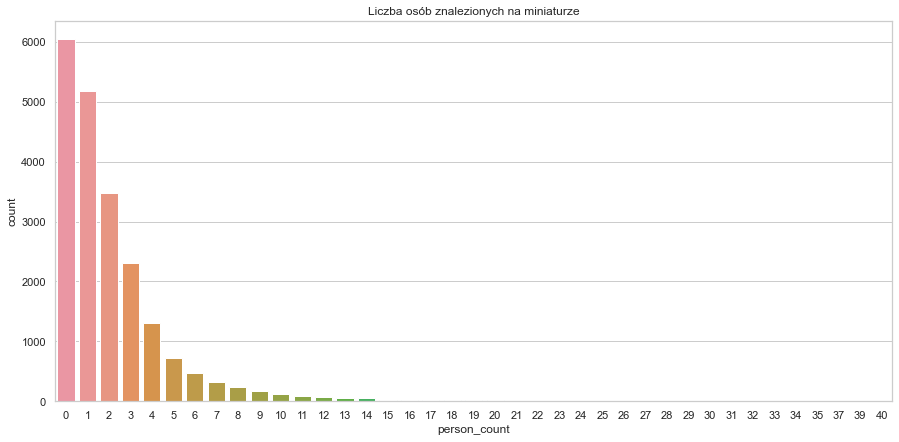

In [25]:
#Liczba osób na miniaturze
def count_person(objects):
    person_count = objects.count('person')
    return person_count
tn['person_count'] = tn['objects'].apply(count_person)

plt.figure(figsize=(15,7))
plt.title("Liczba osób znalezionych na miniaturze")
sns.countplot(x="person_count", data=tn)

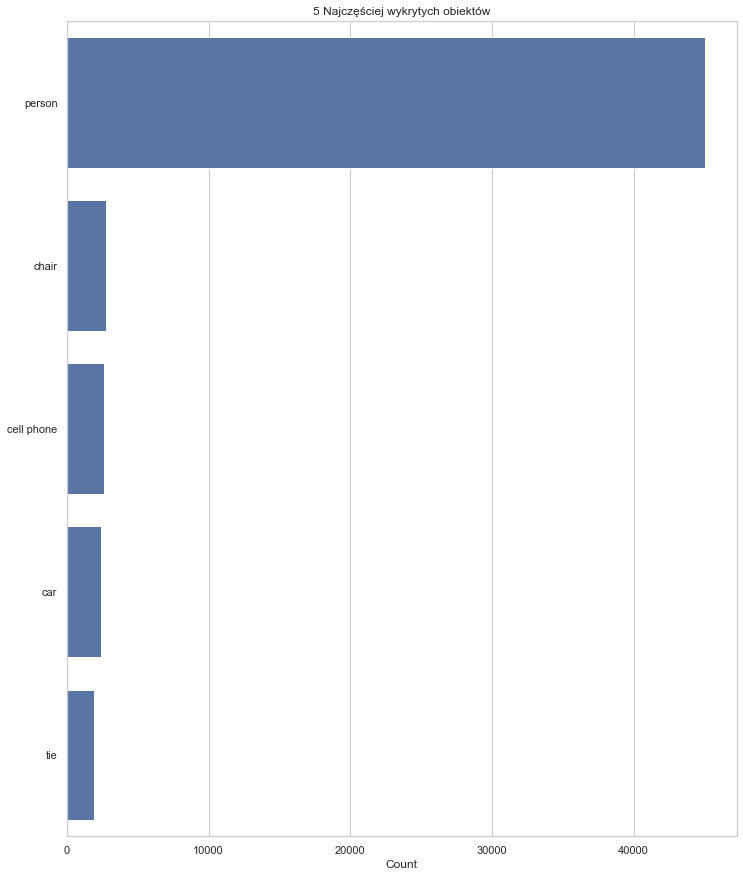

In [41]:
#Najcześciej wykryte obiekty na miniaturze
objects_counter = {}

for index, row in tn.iterrows():
    objs_list_str = row['objects']
    objs_list = ast.literal_eval(objs_list_str)
    for obj in objs_list:
        if obj not in objects_counter:
            objects_counter[obj] = 0
        objects_counter[obj] += 1

def show_histogram(item_counts, title=None):
    plot_df = pd.DataFrame.from_dict(item_counts).rename(columns={0:'Object', 1:'Count'})
    
    f, ax = plt.subplots(figsize=(12, 15))
    p = sns.barplot(x="Count", y="Object", data=plot_df, color="b")
    p.set(xlabel="Count", ylabel="", title=title)


objects_counter = Counter(objects_counter)
show_histogram(objects_counter.most_common(5), "5 Najczęściej wykrytych obiektów")        

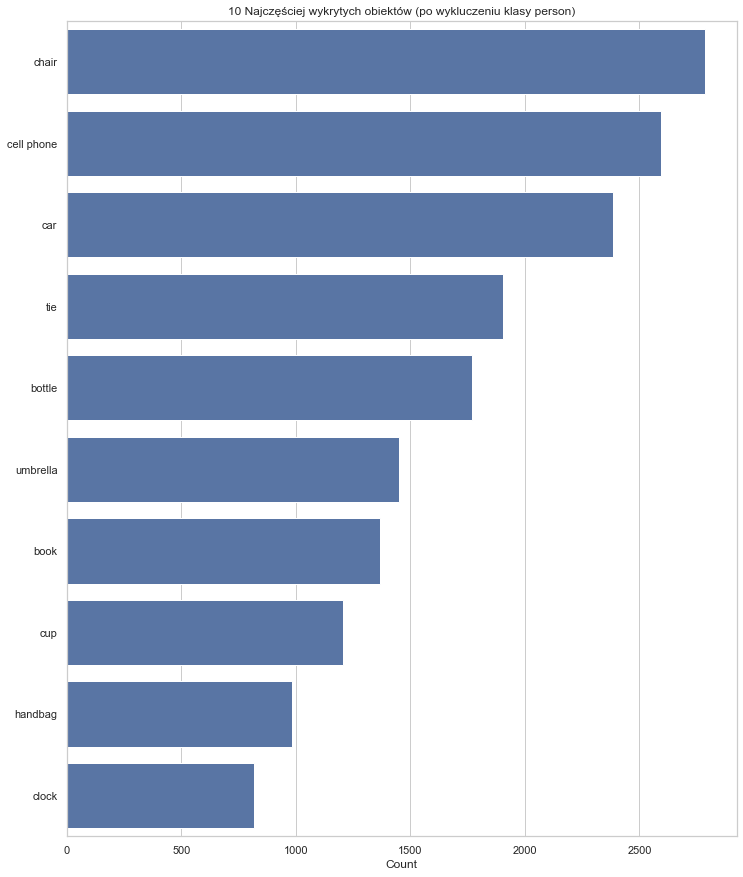

In [43]:
del objects_counter['person']
show_histogram(objects_counter.most_common(10), "10 Najczęściej wykrytych obiektów (po wykluczeniu klasy person)")

In [ ]:
#Kolejne wizualizacje przedstawiają informacje wydobyte z 12.5k pierwszych miniatur (tyle udało się wydobyć na chwilę obecną)

<AxesSubplot:title={'center':'Wiek wykrytych twarzy'}, xlabel='Age', ylabel='Count'>

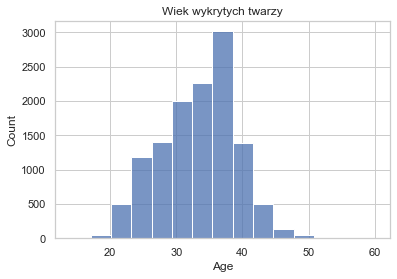

In [47]:
plt.title("Wiek wykrytych twarzy")
sns.histplot(data=tn, x='Age', bins=15)

<AxesSubplot:title={'center':'Płeć wykrytych twarzy'}, xlabel='Gender', ylabel='count'>

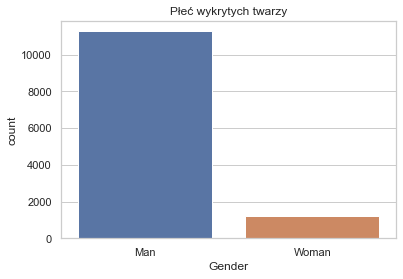

In [48]:
plt.title("Płeć wykrytych twarzy")
sns.countplot(x="Gender", data=tn)

<AxesSubplot:title={'center':'Rasa wykrytych twarzy'}, xlabel='Race', ylabel='count'>

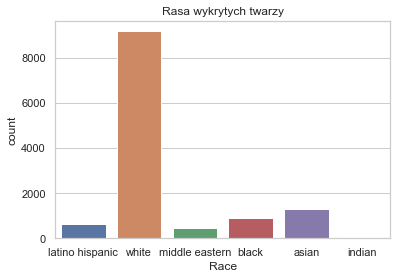

In [49]:
plt.title("Rasa wykrytych twarzy")
sns.countplot(x="Race", data=tn)

<AxesSubplot:title={'center':'Emocje wykrytych twarzy'}, xlabel='Emotion', ylabel='count'>

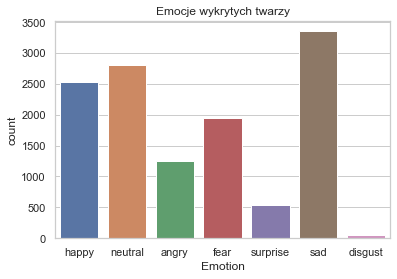

In [50]:
plt.title("Emocje wykrytych twarzy")
sns.countplot(x="Emotion", data=tn)